### Problem Definition  



In this assignment, we want to implement a convolutional neural network for semantic segmentation. Semantic segmentation is used in a variety of domains such as scene understanding, inferring support relationships among objects to autonomous driving. For this purpose, we used the SegNet architecture and CamVid Dataset. SegNet Architecture consists of 3 main parts; An encoder network, a corresponding decoder network,  followed by a pixel-wise classification layer. Due to the time and Hardware limitages, we used SegNet Basic with 4 Encoder and Decoder and we study effect of adding Batch Normalization layer


In [ ]:
#Importing required libraries 
import numpy as np 
import pandas as pd 
import os, sys 
from PIL import Image
import random , statistics
import matplotlib.pyplot as plt

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
import torch.optim as optim

from tqdm import tqdm 

In [ ]:
#Mounting to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download the dataset files from the links to your google drive 

In [ ]:
!wget -P /content/drive/My\ Drive/ https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz

--2021-05-03 11:22:15--  https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.102.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.102.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598913237 (571M) [application/x-tar]
Saving to: ‘/content/drive/My Drive/camvid.tgz’

camvid.tgz          100%[===================>] 571.17M  48.6MB/s    in 11s     

2021-05-03 11:22:26 (50.3 MB/s) - ‘/content/drive/My Drive/camvid.tgz’ saved [598913237/598913237]



In [ ]:
!wget -P /content/drive/My\ Drive/ http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip

--2021-05-03 11:22:26--  http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip
Resolving mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)... 129.169.82.147
Connecting to mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)|129.169.82.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16567585 (16M) [application/zip]
Saving to: ‘/content/drive/My Drive/LabeledApproved_full.zip’

LabeledApproved_ful 100%[===================>]  15.80M  1.68MB/s    in 11s     

2021-05-03 11:22:38 (1.42 MB/s) - ‘/content/drive/My Drive/LabeledApproved_full.zip’ saved [16567585/16567585]



In [ ]:
!wget -P /content/drive/My\ Drive/ http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt

--2021-05-03 11:22:38--  http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt
Resolving mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)... 129.169.82.147
Connecting to mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)|129.169.82.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 634 [text/plain]
Saving to: ‘/content/drive/My Drive/label_colors.txt’

label_colors.txt    100%[===================>]     634  --.-KB/s    in 0s      

2021-05-03 11:22:38 (114 MB/s) - ‘/content/drive/My Drive/label_colors.txt’ saved [634/634]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Load Data

For the sake of speed, copy the dataset files to the root directory of notebook and unziped them. 

In [ ]:
!cp /content/drive/My\ Drive/label_colors.txt ./

In [ ]:
!cp /content/drive/My\ Drive/camvid.tgz ./

In [ ]:
!tar xf /content/camvid.tgz 

In [ ]:
!cp /content/drive/My\ Drive/LabeledApproved_full.zip ./

In [ ]:
!unzip  /content/LabeledApproved_full.zip -d /content/labels

Archive:  /content/LabeledApproved_full.zip
  inflating: /content/labels/0001TP_006690_L.png  
  inflating: /content/labels/0001TP_006720_L.png  
  inflating: /content/labels/0001TP_006750_L.png  
  inflating: /content/labels/0001TP_006780_L.png  
  inflating: /content/labels/0001TP_006810_L.png  
  inflating: /content/labels/0001TP_006840_L.png  
  inflating: /content/labels/0001TP_006870_L.png  
  inflating: /content/labels/0001TP_006900_L.png  
  inflating: /content/labels/0001TP_006930_L.png  
  inflating: /content/labels/0001TP_006960_L.png  
  inflating: /content/labels/0001TP_006990_L.png  
  inflating: /content/labels/0001TP_007020_L.png  
  inflating: /content/labels/0001TP_007050_L.png  
  inflating: /content/labels/0001TP_007080_L.png  
  inflating: /content/labels/0001TP_007110_L.png  
  inflating: /content/labels/0001TP_007140_L.png  
  inflating: /content/labels/0001TP_007170_L.png  
  inflating: /content/labels/0001TP_007200_L.png  
  inflating: /content/labels/0001TP_00

### CamVid Dataset Class

In [ ]:
class CustomToTensor(object):
    """
    A transformation like TOTensor of pytorch that Convert PIL Images
    in sample to pytorch Tensors without rescaling them.
    """
    
    def __call__(self, image):
        return torch.Tensor(np.transpose(np.array(image),(2,0,1)))
        
    
class CamVid_Dataset(torch.utils.data.Dataset):
    
    """
    Characterize CamVid Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """

    def __init__(self, data_root, list_IDs, labels = None, labels_root = None,
                 data_transform = None, label_transform = None, labelcolors_root = None):
        
        self.data_root = data_root
        self.list_IDs = list_IDs
        self.labels = labels
        self.labels_root = labels_root
        self.data_transform = data_transform
        self.label_transform = label_transform 
        self.labelcolors_root = labelcolors_root 
        self.labels_2_RGB , self.RGB_2_labels, self.RGB_Labels = self._load_labelcolors_maps()
        self.num_classes = len(list(self.RGB_2_labels.values()))
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = self._load_data(ID)
        y = self._load_label(ID)

        return X, y

    def _load_data(self, ID):
        """ 
        Load data from the directory root and transform
        
        Arguments
        ------------
        ID : string, 
             ID of data in the root
        
        Returns
        ------------
        data : torch tensor,
               the transformed data
        """
        data = Image.open(self.data_root + "/" + ID)
        data = self.data_transform(data) 
        return data

    def _load_label(self, ID):
        """ 
        Load label data from the directory root and transform
        
        Arguments
        ------------
        ID : string, 
             ID of data in the root
        
        Returns
        ------------
        label : torch tensor,
               the transformed label of data
        """
        ID = ID.replace(".png","_L.png")
        lbl = Image.open(self.labels_root + "/" + ID)
        lbl = self.label_transform(lbl)
        label = self._map_colors_2_label(lbl)
        return label
    
    def _map_colors_2_label(self, label):
        """ 
        Convert RGB values of each pixel to label coding of correspnding class
        
        Arguments
        ------------
        label : torch tensor, of shape (3, n_h, n_w)

        Returns
        ------------
        label_map : torch tensor, of shape (n_h, n_w)

        """
        label_map = []
        for labelcolor in list(self.labels_2_RGB.values()):
            labelcolor_map = torch.all(torch.eq(label,Tensor(labelcolor).view(3,1,1)),dim = 0)
            label_map.append(labelcolor_map)

        label_map = torch.stack(label_map, dim = 0)
        label_map = torch.argmax(label_map.int(), dim = 0)

        return label_map 

    def _load_labelcolors_maps(self):
        """ 
        Create RGB to label code, and label code to RGB converter

        Returns
        ------------
        labels_2_RGB : dict, its keys are label codings of each class, an integer in the range of num_classes
                             and its values are corresponding rgb, a tuple (r,g,b)    

        RGB_2_labels : dict, its keys are rgb values, a tuple (r,g,b)
                             and its values are corresponding label coding of each class, an integer in the range of num_classes
        
        RGB_Labels : DataFrame
        """
        RGB_Labels = pd.read_csv(self.labelcolors_root, header = None,sep = ' ',names = ["R","G","Blabel"])

        RGB_Labels[['B','Label1','Label2']] = RGB_Labels.Blabel.str.split("\t",expand = True)
        RGB_Labels['B'] = RGB_Labels['B'].astype('int')
        RGB_Labels['Label2']  = [str(i or '') for i in RGB_Labels['Label2'] ]

        RGB_Labels['Label'] = RGB_Labels['Label1'] + RGB_Labels['Label2'] 
        RGB_Labels['Label'] = RGB_Labels['Label'].astype('category')
        RGB_Labels['Code_Label'] = RGB_Labels['Label'].cat.codes

        del RGB_Labels['Blabel']
        del RGB_Labels['Label1']
        del RGB_Labels['Label2'] 

        RGBlabels = RGB_Labels.to_dict('records')

        labels_2_RGB = {}
        RGB_2_labels = {}
        
        for dic in RGBlabels:
            labels_2_RGB[dic['Code_Label']] = [dic['R'],dic['G'],dic['B']]            
            RGB_2_labels[tuple((dic['R'],dic['G'],dic['B']))] = dic['Code_Label']

        return  labels_2_RGB , RGB_2_labels, RGB_Labels

    def test_network(self, inputs, outputs, labels):
        """ 
        Plot test images, ground truth label, and the network prediction
        
        Arguments
        ------------
        inputs : torch tensor, of shape (3,n_h,n_w)
        outputs: torch tensor, of shape (1,n_h,n_w)
        labels : torch tensor, of shape (1,n_h,n_w)
        """  
        labels2rgb = self.labels_2_RGB
        def map_label_to_rgb(y):
            return labels2rgb[y[0]]

        outputs = torch.argmax(outputs, dim = 1, keepdims = True).numpy()
        outputs = np.apply_along_axis(map_label_to_rgb, 1, outputs)
        
        labels = labels.numpy()
        labels =  np.apply_along_axis(map_label_to_rgb, 1, np.expand_dims(labels,axis = 1))

        # create figure
        fig = plt.figure(figsize=(16, 12))
        
        # setting values to rows and column variables
        rows = 3
        columns = 3


        for i in range(inputs.shape[0]): 
            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, (3*i +1))
            # showing image
            plt.imshow(inputs[i,:,:,:].permute(1,2,0))
            plt.title("Input Image {}".format(i),fontsize = 10)

            # Adds a subplot at the 2nd position
            fig.add_subplot(rows, columns, (3*i +2))
            # showing image
            plt.imshow(np.transpose(labels[i,:,:,:],(1,2,0)))
            plt.title("Target Image {}".format(i),fontsize = 10)

            # Adds a subplot at the 3rd position
            fig.add_subplot(rows, columns, (3*i +3))
            # showing image
            plt.imshow(np.transpose(outputs[i,:,:,:],(1,2,0)))
            plt.title("Output Image {}".format(i),fontsize = 10)
        return  

    def get_FrameData(self):
        return self.RGB_Labels,self.labels_2_RGB , self.RGB_2_labels

    def labels_weight(self):
        """ 
        Calculate median frequency balancing to balance classes.
        
        Returns
        ------------
        new_weights : list, length = num of calsses
                      where the weight assigned to a class in the loss function
                      is the ratio of the median of class frequencies computed 
                      on the entire training set divided by the class frequency.
        """  
        weights = [0] * self.num_classes

        for index in range(len(self.list_IDs)):
            ID = self.list_IDs[index]
            ID = ID.replace(".png","_L.png")
            lbl = Image.open(self.labels_root + "/" + ID)
            lbl = self.label_transform(lbl)

            for i,labelcolor in enumerate(list(self.labels_2_RGB.values())):
                labelcolor_map = torch.all(torch.eq(lbl,Tensor(labelcolor).view(3,1,1)),dim = 0)
                weights[i] += torch.sum(labelcolor_map.int())
                
        median = statistics.median(weights)
        new_weights = [median / (w + (w == 0) * median ) for w in weights]

        return new_weights

## SegNet_Basic model

#### SegNet_Basic Architecture

In [ ]:
class SegNet_Basic(nn.Module):
    """
    Implement the network architecture which was used in SegNet Basic Paper.
    """
    def __init__(self, num_classes = 32):
        super(SegNet_Basic, self).__init__()
        
        self.num_classes = num_classes

        # Encoder :
        # First layer 
        self.conv1 = nn.Conv2d(3, 64, 7 , padding = 3)
        self.pool1 = nn.MaxPool2d(2, 2,return_indices = True)
        # Second layer
        self.conv2 = nn.Conv2d(64, 64, 7 , padding = 3)
        self.pool2 = nn.MaxPool2d(2, 2,return_indices = True)
        # Third layer
        self.conv3 = nn.Conv2d(64, 64, 7 , padding = 3)
        self.pool3 = nn.MaxPool2d(2, 2,return_indices = True)
        # Fourth layer
        self.conv4 = nn.Conv2d(64, 64, 7 , padding = 3)
        self.pool4 = nn.MaxPool2d(2, 2,return_indices = True)

        # Decoder : 
        # First layer 
        self.upsampling4 = nn.MaxUnpool2d(2, 2)
        self.conv4_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
        # Second layer
        self.upsampling3 = nn.MaxUnpool2d(2, 2)
        self.conv3_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
        # Third layer
        self.upsampling2 = nn.MaxUnpool2d(2, 2)
        self.conv2_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
        # Fourth layer
        self.upsampling1 = nn.MaxUnpool2d(2, 2)
        self.conv1_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)

        # Classifier :
        # Softmax Layer
        self.softmax_layer = nn.Conv2d(64, self.num_classes, 1)

    def forward(self,x):
        # Encoder :
        
        # First layer 
        x = self.conv1(x)
        x = F.relu(x)
        x, indices1 = self.pool1(x)

        # Second layer
        x = self.conv2(x)
        x = F.relu(x)
        x, indices2 = self.pool2(x)

        # Third layer
        x = self.conv3(x)
        x = F.relu(x)
        x, indices3 = self.pool3(x)
        shape = x.shape # it's needed because components of the shape are odd numbers and disrupted by max pooling

        # Fourth layer
        x = self.conv4(x)
        x = F.relu(x)
        x, indices4 = self.pool4(x)

        # Decoder:
        
        # First layer
        x = self.upsampling4(x, indices4,shape)
        x = self.conv4_d(x)

        # Second layer
        x = self.upsampling3(x, indices3)
        x = self.conv3_d(x)
        
        # Third layer
        x = self.upsampling2(x, indices2)
        x = self.conv2_d(x)
        
        # Fourth layer
        x = self.upsampling1(x, indices1)
        x = self.conv1_d(x)
        
        # Classifier:
        
        # Softmax layer
        x = self.softmax_layer(x)
        
        return x

#### Split Dataset and Activate CUDA

In [ ]:
#train/val/test split 
torch.manual_seed(2045) 

image_folder = "/content/camvid/images"
images_names = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
images_names.remove("test.txt")
images_names.remove("Seq05VD_f02610.png")

num_samples = len(images_names)
random.shuffle(images_names)
train_names = images_names[0 : int(0.8 * num_samples)]
validation_names = images_names[int(0.8 * num_samples) : -3]
test_names = images_names[-3:]

partition = {'train' : train_names , 'validation' : validation_names,
             'test' : test_names}


In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

### Train SegNet_Basic without weight balancing

#### Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 500

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic()
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

dataiter = iter(training_generator)
batch_train_data, batch_train_labels = dataiter.next()

dataiter = iter(validation_generator)
batch_data, batch_labels = dataiter.next()
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training

    # Transfer to GPU
    batch_train_data, batch_train_labels = batch_train_data.to(device), batch_train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(batch_train_data)

    loss = criterion(batch_train_outputs, batch_train_labels.long())
    loss.backward()
    optimizer.step()

    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels)

    if train_cnt % 10 == 9:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1

    

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for batch_data, batch_labels in tqdm(validation_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        val_loss = criterion(batch_outputs, batch_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

100%|██████████| 500/500 [16:30<00:00,  1.98s/it]


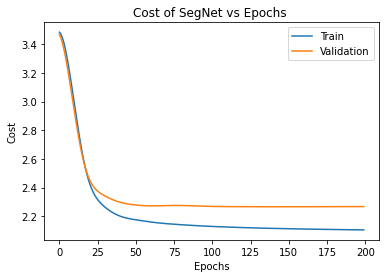

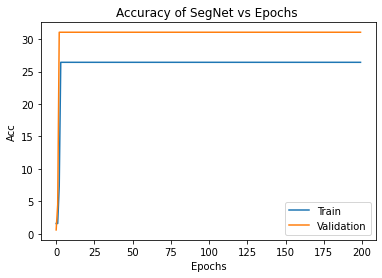

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet vs Epochs ")
    plt.ylabel('Acc')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

#### Training   

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 40

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic()
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []


# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1

    

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

 18%|█▊        | 10/56 [00:19<01:33,  2.04s/it]

Cost of Train data after 10 iterations in epoch 1 : 3.470024



 36%|███▌      | 20/56 [00:36<01:03,  1.76s/it]

Cost of Train data after 20 iterations in epoch 1 : 3.385908



 54%|█████▎    | 30/56 [00:54<00:47,  1.82s/it]

Cost of Train data after 30 iterations in epoch 1 : 3.271254



 71%|███████▏  | 40/56 [01:12<00:30,  1.88s/it]

Cost of Train data after 40 iterations in epoch 1 : 3.156524



 89%|████████▉ | 50/56 [01:30<00:11,  1.94s/it]

Cost of Train data after 50 iterations in epoch 1 : 3.043668



100%|██████████| 56/56 [01:39<00:00,  1.78s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.43s/it]

Cost of Validation data after 10 iterations in epoch 1 : 2.931170



 18%|█▊        | 10/56 [00:19<01:16,  1.67s/it]

Cost of Train data after 10 iterations in epoch 2 : 2.886526



 36%|███▌      | 20/56 [00:36<00:56,  1.57s/it]

Cost of Train data after 20 iterations in epoch 2 : 2.791507



 54%|█████▎    | 30/56 [00:54<00:41,  1.60s/it]

Cost of Train data after 30 iterations in epoch 2 : 2.735638



 71%|███████▏  | 40/56 [01:12<00:25,  1.58s/it]

Cost of Train data after 40 iterations in epoch 2 : 2.643484



 89%|████████▉ | 50/56 [01:29<00:09,  1.59s/it]

Cost of Train data after 50 iterations in epoch 2 : 2.616825



100%|██████████| 56/56 [01:40<00:00,  1.79s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.42s/it]

Cost of Validation data after 10 iterations in epoch 2 : 2.565348



 18%|█▊        | 10/56 [00:18<01:15,  1.64s/it]

Cost of Train data after 10 iterations in epoch 3 : 2.507427



 36%|███▌      | 20/56 [00:36<00:57,  1.61s/it]

Cost of Train data after 20 iterations in epoch 3 : 2.524550



 54%|█████▎    | 30/56 [00:54<00:41,  1.60s/it]

Cost of Train data after 30 iterations in epoch 3 : 2.453653



 71%|███████▏  | 40/56 [01:12<00:25,  1.57s/it]

Cost of Train data after 40 iterations in epoch 3 : 2.440106



 89%|████████▉ | 50/56 [01:29<00:09,  1.59s/it]

Cost of Train data after 50 iterations in epoch 3 : 2.418793



100%|██████████| 56/56 [01:40<00:00,  1.79s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.43s/it]

Cost of Validation data after 10 iterations in epoch 3 : 2.416390



 18%|█▊        | 10/56 [00:19<01:19,  1.73s/it]

Cost of Train data after 10 iterations in epoch 4 : 2.359757



 36%|███▌      | 20/56 [00:37<00:57,  1.61s/it]

Cost of Train data after 20 iterations in epoch 4 : 2.384028



 54%|█████▎    | 30/56 [00:54<00:41,  1.59s/it]

Cost of Train data after 30 iterations in epoch 4 : 2.371397



 71%|███████▏  | 40/56 [01:12<00:25,  1.59s/it]

Cost of Train data after 40 iterations in epoch 4 : 2.352265



 89%|████████▉ | 50/56 [01:30<00:09,  1.60s/it]

Cost of Train data after 50 iterations in epoch 4 : 2.364712



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.42s/it]

Cost of Validation data after 10 iterations in epoch 4 : 2.344755



 18%|█▊        | 10/56 [00:18<01:16,  1.67s/it]

Cost of Train data after 10 iterations in epoch 5 : 2.302227



 36%|███▌      | 20/56 [00:36<01:00,  1.68s/it]

Cost of Train data after 20 iterations in epoch 5 : 2.289097



 54%|█████▎    | 30/56 [00:54<00:41,  1.58s/it]

Cost of Train data after 30 iterations in epoch 5 : 2.332136



 71%|███████▏  | 40/56 [01:12<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 5 : 2.299606



 89%|████████▉ | 50/56 [01:30<00:09,  1.57s/it]

Cost of Train data after 50 iterations in epoch 5 : 2.305287



100%|██████████| 56/56 [01:40<00:00,  1.80s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.42s/it]

Cost of Validation data after 10 iterations in epoch 5 : 2.294312



 18%|█▊        | 10/56 [00:19<01:17,  1.68s/it]

Cost of Train data after 10 iterations in epoch 6 : 2.295798



 36%|███▌      | 20/56 [00:37<00:58,  1.62s/it]

Cost of Train data after 20 iterations in epoch 6 : 2.250087



 54%|█████▎    | 30/56 [00:54<00:41,  1.59s/it]

Cost of Train data after 30 iterations in epoch 6 : 2.249207



 71%|███████▏  | 40/56 [01:12<00:25,  1.59s/it]

Cost of Train data after 40 iterations in epoch 6 : 2.258551



 89%|████████▉ | 50/56 [01:30<00:09,  1.60s/it]

Cost of Train data after 50 iterations in epoch 6 : 2.281098



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.42s/it]

Cost of Validation data after 10 iterations in epoch 6 : 2.241990



 18%|█▊        | 10/56 [00:19<01:18,  1.70s/it]

Cost of Train data after 10 iterations in epoch 7 : 2.210667



 36%|███▌      | 20/56 [00:37<00:58,  1.61s/it]

Cost of Train data after 20 iterations in epoch 7 : 2.286650



 54%|█████▎    | 30/56 [00:55<00:42,  1.62s/it]

Cost of Train data after 30 iterations in epoch 7 : 2.224724



 71%|███████▏  | 40/56 [01:12<00:24,  1.56s/it]

Cost of Train data after 40 iterations in epoch 7 : 2.294833



 89%|████████▉ | 50/56 [01:30<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 7 : 2.237733



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.45s/it]

Cost of Validation data after 10 iterations in epoch 7 : 2.258274



 18%|█▊        | 10/56 [00:19<01:17,  1.69s/it]

Cost of Train data after 10 iterations in epoch 8 : 2.249185



 36%|███▌      | 20/56 [00:37<00:58,  1.61s/it]

Cost of Train data after 20 iterations in epoch 8 : 2.240199



 54%|█████▎    | 30/56 [00:54<00:41,  1.60s/it]

Cost of Train data after 30 iterations in epoch 8 : 2.220260



 71%|███████▏  | 40/56 [01:12<00:25,  1.61s/it]

Cost of Train data after 40 iterations in epoch 8 : 2.225550



 89%|████████▉ | 50/56 [01:30<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 8 : 2.243761



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 8 : 2.236305



 18%|█▊        | 10/56 [00:19<01:17,  1.69s/it]

Cost of Train data after 10 iterations in epoch 9 : 2.262357



 36%|███▌      | 20/56 [00:36<00:57,  1.60s/it]

Cost of Train data after 20 iterations in epoch 9 : 2.204142



 54%|█████▎    | 30/56 [00:54<00:43,  1.67s/it]

Cost of Train data after 30 iterations in epoch 9 : 2.259103



 71%|███████▏  | 40/56 [01:12<00:27,  1.70s/it]

Cost of Train data after 40 iterations in epoch 9 : 2.185795



 89%|████████▉ | 50/56 [01:30<00:10,  1.69s/it]

Cost of Train data after 50 iterations in epoch 9 : 2.223882



100%|██████████| 56/56 [01:40<00:00,  1.79s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.42s/it]

Cost of Validation data after 10 iterations in epoch 9 : 2.195872



 18%|█▊        | 10/56 [00:19<01:18,  1.70s/it]

Cost of Train data after 10 iterations in epoch 10 : 2.216471



 36%|███▌      | 20/56 [00:37<00:57,  1.59s/it]

Cost of Train data after 20 iterations in epoch 10 : 2.198392



 54%|█████▎    | 30/56 [00:55<00:41,  1.61s/it]

Cost of Train data after 30 iterations in epoch 10 : 2.255985



 71%|███████▏  | 40/56 [01:13<00:25,  1.60s/it]

Cost of Train data after 40 iterations in epoch 10 : 2.204540



 89%|████████▉ | 50/56 [01:31<00:09,  1.60s/it]

Cost of Train data after 50 iterations in epoch 10 : 2.199016



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.43s/it]

Cost of Validation data after 10 iterations in epoch 10 : 2.203226



 18%|█▊        | 10/56 [00:18<01:17,  1.68s/it]

Cost of Train data after 10 iterations in epoch 11 : 2.201317



 36%|███▌      | 20/56 [00:37<00:59,  1.64s/it]

Cost of Train data after 20 iterations in epoch 11 : 2.211798



 54%|█████▎    | 30/56 [00:55<00:42,  1.63s/it]

Cost of Train data after 30 iterations in epoch 11 : 2.204758



 71%|███████▏  | 40/56 [01:13<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 11 : 2.223005



 89%|████████▉ | 50/56 [01:31<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 11 : 2.199629



100%|██████████| 56/56 [01:41<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 11 : 2.222512



 18%|█▊        | 10/56 [00:19<01:17,  1.68s/it]

Cost of Train data after 10 iterations in epoch 12 : 2.174772



 36%|███▌      | 20/56 [00:37<00:58,  1.63s/it]

Cost of Train data after 20 iterations in epoch 12 : 2.210722



 54%|█████▎    | 30/56 [00:55<00:41,  1.60s/it]

Cost of Train data after 30 iterations in epoch 12 : 2.200017



 71%|███████▏  | 40/56 [01:13<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 12 : 2.195894



 89%|████████▉ | 50/56 [01:31<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 12 : 2.194343



100%|██████████| 56/56 [01:42<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 12 : 2.190484



 18%|█▊        | 10/56 [00:18<01:17,  1.69s/it]

Cost of Train data after 10 iterations in epoch 13 : 2.162072



 36%|███▌      | 20/56 [00:36<00:57,  1.60s/it]

Cost of Train data after 20 iterations in epoch 13 : 2.238862



 54%|█████▎    | 30/56 [00:55<00:42,  1.62s/it]

Cost of Train data after 30 iterations in epoch 13 : 2.206080



 71%|███████▏  | 40/56 [01:12<00:25,  1.59s/it]

Cost of Train data after 40 iterations in epoch 13 : 2.193038



 89%|████████▉ | 50/56 [01:30<00:09,  1.59s/it]

Cost of Train data after 50 iterations in epoch 13 : 2.190440



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.45s/it]

Cost of Validation data after 10 iterations in epoch 13 : 2.193210



 18%|█▊        | 10/56 [00:19<01:18,  1.71s/it]

Cost of Train data after 10 iterations in epoch 14 : 2.192904



 36%|███▌      | 20/56 [00:37<01:06,  1.86s/it]

Cost of Train data after 20 iterations in epoch 14 : 2.194620



 54%|█████▎    | 30/56 [00:55<00:47,  1.81s/it]

Cost of Train data after 30 iterations in epoch 14 : 2.183448



 71%|███████▏  | 40/56 [01:13<00:28,  1.81s/it]

Cost of Train data after 40 iterations in epoch 14 : 2.201080



 89%|████████▉ | 50/56 [01:31<00:10,  1.81s/it]

Cost of Train data after 50 iterations in epoch 14 : 2.205252



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.41s/it]

Cost of Validation data after 10 iterations in epoch 14 : 2.178846



 18%|█▊        | 10/56 [00:19<01:19,  1.74s/it]

Cost of Train data after 10 iterations in epoch 15 : 2.199800



 36%|███▌      | 20/56 [00:37<00:59,  1.65s/it]

Cost of Train data after 20 iterations in epoch 15 : 2.180055



 54%|█████▎    | 30/56 [00:55<00:41,  1.60s/it]

Cost of Train data after 30 iterations in epoch 15 : 2.181532



 71%|███████▏  | 40/56 [01:13<00:25,  1.60s/it]

Cost of Train data after 40 iterations in epoch 15 : 2.194301



 89%|████████▉ | 50/56 [01:31<00:09,  1.58s/it]

Cost of Train data after 50 iterations in epoch 15 : 2.194724



100%|██████████| 56/56 [01:41<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 15 : 2.173875



 18%|█▊        | 10/56 [00:19<01:18,  1.70s/it]

Cost of Train data after 10 iterations in epoch 16 : 2.173464



 36%|███▌      | 20/56 [00:38<01:00,  1.68s/it]

Cost of Train data after 20 iterations in epoch 16 : 2.178257



 54%|█████▎    | 30/56 [00:56<00:41,  1.59s/it]

Cost of Train data after 30 iterations in epoch 16 : 2.169132



 71%|███████▏  | 40/56 [01:14<00:26,  1.63s/it]

Cost of Train data after 40 iterations in epoch 16 : 2.172043



 89%|████████▉ | 50/56 [01:32<00:09,  1.63s/it]

Cost of Train data after 50 iterations in epoch 16 : 2.207015



100%|██████████| 56/56 [01:43<00:00,  1.85s/it]

 71%|███████▏  | 10/14 [00:17<00:06,  1.51s/it]

Cost of Validation data after 10 iterations in epoch 16 : 2.175370



 18%|█▊        | 10/56 [00:19<01:18,  1.70s/it]

Cost of Train data after 10 iterations in epoch 17 : 2.143637



 36%|███▌      | 20/56 [00:38<00:58,  1.61s/it]

Cost of Train data after 20 iterations in epoch 17 : 2.178922



 54%|█████▎    | 30/56 [00:56<00:42,  1.64s/it]

Cost of Train data after 30 iterations in epoch 17 : 2.161700



 71%|███████▏  | 40/56 [01:14<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 17 : 2.225244



 89%|████████▉ | 50/56 [01:33<00:09,  1.65s/it]

Cost of Train data after 50 iterations in epoch 17 : 2.196043



100%|██████████| 56/56 [01:43<00:00,  1.85s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 17 : 2.168186



 18%|█▊        | 10/56 [00:19<01:19,  1.72s/it]

Cost of Train data after 10 iterations in epoch 18 : 2.210686



 36%|███▌      | 20/56 [00:37<00:58,  1.62s/it]

Cost of Train data after 20 iterations in epoch 18 : 2.164632



 54%|█████▎    | 30/56 [00:55<00:42,  1.63s/it]

Cost of Train data after 30 iterations in epoch 18 : 2.188760



 71%|███████▏  | 40/56 [01:14<00:26,  1.68s/it]

Cost of Train data after 40 iterations in epoch 18 : 2.175420



 89%|████████▉ | 50/56 [01:32<00:09,  1.63s/it]

Cost of Train data after 50 iterations in epoch 18 : 2.181809



100%|██████████| 56/56 [01:43<00:00,  1.85s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.46s/it]

Cost of Validation data after 10 iterations in epoch 18 : 2.164243



 18%|█▊        | 10/56 [00:19<01:18,  1.70s/it]

Cost of Train data after 10 iterations in epoch 19 : 2.189552



 36%|███▌      | 20/56 [00:37<00:57,  1.59s/it]

Cost of Train data after 20 iterations in epoch 19 : 2.161738



 54%|█████▎    | 30/56 [00:54<00:42,  1.65s/it]

Cost of Train data after 30 iterations in epoch 19 : 2.171278



 71%|███████▏  | 40/56 [01:13<00:29,  1.81s/it]

Cost of Train data after 40 iterations in epoch 19 : 2.187843



 89%|████████▉ | 50/56 [01:31<00:10,  1.78s/it]

Cost of Train data after 50 iterations in epoch 19 : 2.184807



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.45s/it]

Cost of Validation data after 10 iterations in epoch 19 : 2.191131



 18%|█▊        | 10/56 [00:19<01:19,  1.72s/it]

Cost of Train data after 10 iterations in epoch 20 : 2.166724



 36%|███▌      | 20/56 [00:37<00:58,  1.62s/it]

Cost of Train data after 20 iterations in epoch 20 : 2.151425



 54%|█████▎    | 30/56 [00:56<00:45,  1.74s/it]

Cost of Train data after 30 iterations in epoch 20 : 2.183137



 71%|███████▏  | 40/56 [01:14<00:28,  1.76s/it]

Cost of Train data after 40 iterations in epoch 20 : 2.203972



 89%|████████▉ | 50/56 [01:32<00:10,  1.75s/it]

Cost of Train data after 50 iterations in epoch 20 : 2.151285



100%|██████████| 56/56 [01:42<00:00,  1.83s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.47s/it]

Cost of Validation data after 10 iterations in epoch 20 : 2.182636



 18%|█▊        | 10/56 [00:19<01:19,  1.72s/it]

Cost of Train data after 10 iterations in epoch 21 : 2.184622



 36%|███▌      | 20/56 [00:37<00:58,  1.63s/it]

Cost of Train data after 20 iterations in epoch 21 : 2.193138



 54%|█████▎    | 30/56 [00:55<00:41,  1.58s/it]

Cost of Train data after 30 iterations in epoch 21 : 2.180661



 71%|███████▏  | 40/56 [01:13<00:26,  1.63s/it]

Cost of Train data after 40 iterations in epoch 21 : 2.168569



 89%|████████▉ | 50/56 [01:32<00:10,  1.67s/it]

Cost of Train data after 50 iterations in epoch 21 : 2.141403



100%|██████████| 56/56 [01:42<00:00,  1.83s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.45s/it]

Cost of Validation data after 10 iterations in epoch 21 : 2.173679



 18%|█▊        | 10/56 [00:19<01:18,  1.70s/it]

Cost of Train data after 10 iterations in epoch 22 : 2.168876



 36%|███▌      | 20/56 [00:37<00:58,  1.64s/it]

Cost of Train data after 20 iterations in epoch 22 : 2.142714



 54%|█████▎    | 30/56 [00:55<00:41,  1.61s/it]

Cost of Train data after 30 iterations in epoch 22 : 2.198443



 71%|███████▏  | 40/56 [01:13<00:26,  1.63s/it]

Cost of Train data after 40 iterations in epoch 22 : 2.206001



 89%|████████▉ | 50/56 [01:31<00:09,  1.62s/it]

Cost of Train data after 50 iterations in epoch 22 : 2.160977



100%|██████████| 56/56 [01:42<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.46s/it]

Cost of Validation data after 10 iterations in epoch 22 : 2.163784



 18%|█▊        | 10/56 [00:19<01:19,  1.72s/it]

Cost of Train data after 10 iterations in epoch 23 : 2.153710



 36%|███▌      | 20/56 [00:37<01:00,  1.69s/it]

Cost of Train data after 20 iterations in epoch 23 : 2.169100



 54%|█████▎    | 30/56 [00:55<00:44,  1.71s/it]

Cost of Train data after 30 iterations in epoch 23 : 2.179410



 71%|███████▏  | 40/56 [01:12<00:26,  1.63s/it]

Cost of Train data after 40 iterations in epoch 23 : 2.178935



 89%|████████▉ | 50/56 [01:30<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 23 : 2.158653



100%|██████████| 56/56 [01:42<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:17<00:05,  1.48s/it]

Cost of Validation data after 10 iterations in epoch 23 : 2.146976



 18%|█▊        | 10/56 [00:19<01:17,  1.69s/it]

Cost of Train data after 10 iterations in epoch 24 : 2.162033



 36%|███▌      | 20/56 [00:37<00:58,  1.63s/it]

Cost of Train data after 20 iterations in epoch 24 : 2.192706



 54%|█████▎    | 30/56 [00:55<00:42,  1.62s/it]

Cost of Train data after 30 iterations in epoch 24 : 2.151802



 71%|███████▏  | 40/56 [01:14<00:27,  1.70s/it]

Cost of Train data after 40 iterations in epoch 24 : 2.169206



 89%|████████▉ | 50/56 [01:33<00:09,  1.64s/it]

Cost of Train data after 50 iterations in epoch 24 : 2.172437



100%|██████████| 56/56 [01:43<00:00,  1.86s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.47s/it]

Cost of Validation data after 10 iterations in epoch 24 : 2.145485



 18%|█▊        | 10/56 [00:19<01:18,  1.71s/it]

Cost of Train data after 10 iterations in epoch 25 : 2.162326



 36%|███▌      | 20/56 [00:37<00:57,  1.61s/it]

Cost of Train data after 20 iterations in epoch 25 : 2.160211



 54%|█████▎    | 30/56 [00:55<00:42,  1.62s/it]

Cost of Train data after 30 iterations in epoch 25 : 2.151716



 71%|███████▏  | 40/56 [01:13<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 25 : 2.171847



 89%|████████▉ | 50/56 [01:31<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 25 : 2.200042



100%|██████████| 56/56 [01:42<00:00,  1.83s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.43s/it]

Cost of Validation data after 10 iterations in epoch 25 : 2.159607



 18%|█▊        | 10/56 [00:19<01:17,  1.67s/it]

Cost of Train data after 10 iterations in epoch 26 : 2.158020



 36%|███▌      | 20/56 [00:37<00:57,  1.61s/it]

Cost of Train data after 20 iterations in epoch 26 : 2.189198



 54%|█████▎    | 30/56 [00:55<00:41,  1.61s/it]

Cost of Train data after 30 iterations in epoch 26 : 2.145345



 71%|███████▏  | 40/56 [01:13<00:25,  1.61s/it]

Cost of Train data after 40 iterations in epoch 26 : 2.203525



 89%|████████▉ | 50/56 [01:30<00:09,  1.57s/it]

Cost of Train data after 50 iterations in epoch 26 : 2.160015



100%|██████████| 56/56 [01:41<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.46s/it]

Cost of Validation data after 10 iterations in epoch 26 : 2.163048



 18%|█▊        | 10/56 [00:19<01:16,  1.67s/it]

Cost of Train data after 10 iterations in epoch 27 : 2.163507



 36%|███▌      | 20/56 [00:37<00:58,  1.62s/it]

Cost of Train data after 20 iterations in epoch 27 : 2.119922



 54%|█████▎    | 30/56 [00:55<00:41,  1.60s/it]

Cost of Train data after 30 iterations in epoch 27 : 2.187660



 71%|███████▏  | 40/56 [01:13<00:25,  1.60s/it]

Cost of Train data after 40 iterations in epoch 27 : 2.145248



 89%|████████▉ | 50/56 [01:31<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 27 : 2.182696



100%|██████████| 56/56 [01:41<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 27 : 2.153088



 18%|█▊        | 10/56 [00:19<01:17,  1.69s/it]

Cost of Train data after 10 iterations in epoch 28 : 2.150469



 36%|███▌      | 20/56 [00:37<00:59,  1.65s/it]

Cost of Train data after 20 iterations in epoch 28 : 2.213029



 54%|█████▎    | 30/56 [00:55<00:41,  1.60s/it]

Cost of Train data after 30 iterations in epoch 28 : 2.182920



 71%|███████▏  | 40/56 [01:13<00:26,  1.63s/it]

Cost of Train data after 40 iterations in epoch 28 : 2.117100



 89%|████████▉ | 50/56 [01:31<00:09,  1.62s/it]

Cost of Train data after 50 iterations in epoch 28 : 2.162097



100%|██████████| 56/56 [01:42<00:00,  1.83s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 28 : 2.163972



 18%|█▊        | 10/56 [00:18<01:17,  1.68s/it]

Cost of Train data after 10 iterations in epoch 29 : 2.165344



 36%|███▌      | 20/56 [00:36<00:57,  1.59s/it]

Cost of Train data after 20 iterations in epoch 29 : 2.183558



 54%|█████▎    | 30/56 [00:54<00:41,  1.61s/it]

Cost of Train data after 30 iterations in epoch 29 : 2.159505



 71%|███████▏  | 40/56 [01:12<00:26,  1.64s/it]

Cost of Train data after 40 iterations in epoch 29 : 2.165743



 89%|████████▉ | 50/56 [01:30<00:09,  1.67s/it]

Cost of Train data after 50 iterations in epoch 29 : 2.153444



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.45s/it]

Cost of Validation data after 10 iterations in epoch 29 : 2.168628



 18%|█▊        | 10/56 [00:19<01:19,  1.73s/it]

Cost of Train data after 10 iterations in epoch 30 : 2.184432



 36%|███▌      | 20/56 [00:37<00:56,  1.58s/it]

Cost of Train data after 20 iterations in epoch 30 : 2.138553



 54%|█████▎    | 30/56 [00:55<00:42,  1.63s/it]

Cost of Train data after 30 iterations in epoch 30 : 2.153177



 71%|███████▏  | 40/56 [01:13<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 30 : 2.162399



 89%|████████▉ | 50/56 [01:31<00:10,  1.67s/it]

Cost of Train data after 50 iterations in epoch 30 : 2.204233



100%|██████████| 56/56 [01:42<00:00,  1.83s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.46s/it]

Cost of Validation data after 10 iterations in epoch 30 : 2.167258



 18%|█▊        | 10/56 [00:19<01:18,  1.72s/it]

Cost of Train data after 10 iterations in epoch 31 : 2.187900



 36%|███▌      | 20/56 [00:37<00:58,  1.62s/it]

Cost of Train data after 20 iterations in epoch 31 : 2.175617



 54%|█████▎    | 30/56 [00:55<00:42,  1.62s/it]

Cost of Train data after 30 iterations in epoch 31 : 2.160054



 71%|███████▏  | 40/56 [01:13<00:26,  1.64s/it]

Cost of Train data after 40 iterations in epoch 31 : 2.121064



 89%|████████▉ | 50/56 [01:31<00:09,  1.64s/it]

Cost of Train data after 50 iterations in epoch 31 : 2.186463



100%|██████████| 56/56 [01:42<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.41s/it]

Cost of Validation data after 10 iterations in epoch 31 : 2.155870



 18%|█▊        | 10/56 [00:19<01:19,  1.73s/it]

Cost of Train data after 10 iterations in epoch 32 : 2.143365



 36%|███▌      | 20/56 [00:37<00:59,  1.65s/it]

Cost of Train data after 20 iterations in epoch 32 : 2.182866



 54%|█████▎    | 30/56 [00:55<00:41,  1.58s/it]

Cost of Train data after 30 iterations in epoch 32 : 2.145905



 71%|███████▏  | 40/56 [01:13<00:26,  1.63s/it]

Cost of Train data after 40 iterations in epoch 32 : 2.188217



 89%|████████▉ | 50/56 [01:31<00:09,  1.63s/it]

Cost of Train data after 50 iterations in epoch 32 : 2.150343



100%|██████████| 56/56 [01:42<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:17<00:06,  1.54s/it]

Cost of Validation data after 10 iterations in epoch 32 : 2.153545



 18%|█▊        | 10/56 [00:19<01:18,  1.72s/it]

Cost of Train data after 10 iterations in epoch 33 : 2.163810



 36%|███▌      | 20/56 [00:37<00:58,  1.64s/it]

Cost of Train data after 20 iterations in epoch 33 : 2.169266



 54%|█████▎    | 30/56 [00:55<00:42,  1.62s/it]

Cost of Train data after 30 iterations in epoch 33 : 2.175362



 71%|███████▏  | 40/56 [01:13<00:26,  1.68s/it]

Cost of Train data after 40 iterations in epoch 33 : 2.155205



 89%|████████▉ | 50/56 [01:31<00:10,  1.68s/it]

Cost of Train data after 50 iterations in epoch 33 : 2.144418



100%|██████████| 56/56 [01:41<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.45s/it]

Cost of Validation data after 10 iterations in epoch 33 : 2.160534



 18%|█▊        | 10/56 [00:19<01:19,  1.73s/it]

Cost of Train data after 10 iterations in epoch 34 : 2.184561



 36%|███▌      | 20/56 [00:37<00:58,  1.63s/it]

Cost of Train data after 20 iterations in epoch 34 : 2.140114



 54%|█████▎    | 30/56 [00:55<00:42,  1.63s/it]

Cost of Train data after 30 iterations in epoch 34 : 2.158266



 71%|███████▏  | 40/56 [01:13<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 34 : 2.142736



 89%|████████▉ | 50/56 [01:31<00:09,  1.61s/it]

Cost of Train data after 50 iterations in epoch 34 : 2.150122



100%|██████████| 56/56 [01:42<00:00,  1.83s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 34 : 2.150042



 18%|█▊        | 10/56 [00:19<01:19,  1.72s/it]

Cost of Train data after 10 iterations in epoch 35 : 2.182296



 36%|███▌      | 20/56 [00:37<00:58,  1.63s/it]

Cost of Train data after 20 iterations in epoch 35 : 2.113526



 54%|█████▎    | 30/56 [00:55<00:41,  1.59s/it]

Cost of Train data after 30 iterations in epoch 35 : 2.179581



 71%|███████▏  | 40/56 [01:13<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 35 : 2.185033



 89%|████████▉ | 50/56 [01:31<00:09,  1.64s/it]

Cost of Train data after 50 iterations in epoch 35 : 2.151178



100%|██████████| 56/56 [01:42<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 35 : 2.154830



 18%|█▊        | 10/56 [00:19<01:16,  1.67s/it]

Cost of Train data after 10 iterations in epoch 36 : 2.148489



 36%|███▌      | 20/56 [00:36<00:58,  1.61s/it]

Cost of Train data after 20 iterations in epoch 36 : 2.147149



 54%|█████▎    | 30/56 [00:54<00:40,  1.57s/it]

Cost of Train data after 30 iterations in epoch 36 : 2.180887



 71%|███████▏  | 40/56 [01:13<00:25,  1.61s/it]

Cost of Train data after 40 iterations in epoch 36 : 2.162147



 89%|████████▉ | 50/56 [01:30<00:09,  1.59s/it]

Cost of Train data after 50 iterations in epoch 36 : 2.152671



100%|██████████| 56/56 [01:41<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 36 : 2.141749



 18%|█▊        | 10/56 [00:19<01:17,  1.68s/it]

Cost of Train data after 10 iterations in epoch 37 : 2.157759



 36%|███▌      | 20/56 [00:36<00:57,  1.60s/it]

Cost of Train data after 20 iterations in epoch 37 : 2.153728



 54%|█████▎    | 30/56 [00:54<00:41,  1.59s/it]

Cost of Train data after 30 iterations in epoch 37 : 2.158585



 71%|███████▏  | 40/56 [01:13<00:26,  1.63s/it]

Cost of Train data after 40 iterations in epoch 37 : 2.169209



 89%|████████▉ | 50/56 [01:30<00:09,  1.63s/it]

Cost of Train data after 50 iterations in epoch 37 : 2.150748



100%|██████████| 56/56 [01:41<00:00,  1.82s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.45s/it]

Cost of Validation data after 10 iterations in epoch 37 : 2.148770



 18%|█▊        | 10/56 [00:18<01:18,  1.70s/it]

Cost of Train data after 10 iterations in epoch 38 : 2.176133



 36%|███▌      | 20/56 [00:36<00:56,  1.57s/it]

Cost of Train data after 20 iterations in epoch 38 : 2.140945



 54%|█████▎    | 30/56 [00:54<00:42,  1.62s/it]

Cost of Train data after 30 iterations in epoch 38 : 2.138461



 71%|███████▏  | 40/56 [01:12<00:25,  1.62s/it]

Cost of Train data after 40 iterations in epoch 38 : 2.200406



 89%|████████▉ | 50/56 [01:30<00:09,  1.62s/it]

Cost of Train data after 50 iterations in epoch 38 : 2.161586



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 38 : 2.146500



 18%|█▊        | 10/56 [00:18<01:16,  1.66s/it]

Cost of Train data after 10 iterations in epoch 39 : 2.150580



 36%|███▌      | 20/56 [00:36<00:57,  1.59s/it]

Cost of Train data after 20 iterations in epoch 39 : 2.148776



 54%|█████▎    | 30/56 [00:54<00:41,  1.59s/it]

Cost of Train data after 30 iterations in epoch 39 : 2.165397



 71%|███████▏  | 40/56 [01:12<00:25,  1.61s/it]

Cost of Train data after 40 iterations in epoch 39 : 2.140507



 89%|████████▉ | 50/56 [01:30<00:09,  1.62s/it]

Cost of Train data after 50 iterations in epoch 39 : 2.200249



100%|██████████| 56/56 [01:40<00:00,  1.80s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.44s/it]

Cost of Validation data after 10 iterations in epoch 39 : 2.134633



 18%|█▊        | 10/56 [00:18<01:16,  1.66s/it]

Cost of Train data after 10 iterations in epoch 40 : 2.170924



 36%|███▌      | 20/56 [00:36<00:58,  1.62s/it]

Cost of Train data after 20 iterations in epoch 40 : 2.171999



 54%|█████▎    | 30/56 [00:54<00:40,  1.57s/it]

Cost of Train data after 30 iterations in epoch 40 : 2.141348



 71%|███████▏  | 40/56 [01:12<00:25,  1.59s/it]

Cost of Train data after 40 iterations in epoch 40 : 2.136739



 89%|████████▉ | 50/56 [01:30<00:09,  1.62s/it]

Cost of Train data after 50 iterations in epoch 40 : 2.167756



100%|██████████| 56/56 [01:41<00:00,  1.81s/it]

 71%|███████▏  | 10/14 [00:16<00:05,  1.41s/it]

Cost of Validation data after 10 iterations in epoch 40 : 2.157632



100%|██████████| 40/40 [1:23:11<00:00, 124.79s/it]


#### Train

In [ ]:
# Parameters
params = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 40

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1

    

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.33s/it]

  3%|▎         | 2/70 [00:03<02:50,  2.50s/it]

  4%|▍         | 3/70 [00:06<02:42,  2.42s/it]

  6%|▌         | 4/70 [00:06<02:03,  1.87s/it]

  7%|▋         | 5/70 [00:08<02:08,  1.98s/it]

  9%|▊         | 6/70 [00:09<01:40,  1.57s/it]

 10%|█         | 7/70 [00:11<01:51,  1.77s/it]

 11%|█▏        | 8/70 [00:12<01:27,  1.42s/it]

 13%|█▎        | 9/70 [00:14<01:42,  1.67s/it]

 14%|█▍        | 10/70 [00:15<01:20,  1.35s/it]

Cost of Train data after 10 iterations in epoch 1 : 2.153755




 16%|█▌        | 11/70 [00:17<01:37,  1.65s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.33s/it]

 19%|█▊        | 13/70 [00:20<01:30,  1.59s/it]

 20%|██        | 14/70 [00:20<01:12,  1.29s/it]

 21%|██▏       | 15/70 [00:23<01:26,  1.57s/it]

 23%|██▎       | 16/70 [00:23<01:09,  1.28s/it]

 24%|██▍       | 17/70 [00:25<01:21,  1.53s/it]

 26%|██▌       | 18/70 [00:26<01:05,  1.25s/it]

 27%|██▋       | 19/70 [00:28<01:17,  1.52s/it]

 29%|██▊       | 20/70 [00:29<01:02,  1.25s/it]

Cost of Train data after 20 iterations in epoch 1 : 2.187465




 30%|███       | 21/70 [00:31<01:14,  1.52s/it]

 31%|███▏      | 22/70 [00:32<01:00,  1.25s/it]

 33%|███▎      | 23/70 [00:34<01:13,  1.56s/it]

 34%|███▍      | 24/70 [00:34<00:58,  1.27s/it]

 36%|███▌      | 25/70 [00:37<01:10,  1.56s/it]

 37%|███▋      | 26/70 [00:37<00:56,  1.28s/it]

 39%|███▊      | 27/70 [00:39<01:06,  1.54s/it]

 40%|████      | 28/70 [00:40<00:54,  1.30s/it]

 41%|████▏     | 29/70 [00:42<01:02,  1.53s/it]

 43%|████▎     | 30/70 [00:43<00:51,  1.28s/it]

Cost of Train data after 30 iterations in epoch 1 : 2.130571




 44%|████▍     | 31/70 [00:45<00:59,  1.53s/it]

 46%|████▌     | 32/70 [00:46<00:49,  1.30s/it]

 47%|████▋     | 33/70 [00:48<00:55,  1.50s/it]

 49%|████▊     | 34/70 [00:49<00:47,  1.31s/it]

 50%|█████     | 35/70 [00:51<00:52,  1.51s/it]

 51%|█████▏    | 36/70 [00:51<00:44,  1.31s/it]

 53%|█████▎    | 37/70 [00:54<00:50,  1.54s/it]

 54%|█████▍    | 38/70 [00:54<00:42,  1.33s/it]

 56%|█████▌    | 39/70 [00:56<00:46,  1.50s/it]

 57%|█████▋    | 40/70 [00:57<00:39,  1.33s/it]

Cost of Train data after 40 iterations in epoch 1 : 2.179587




 59%|█████▊    | 41/70 [00:59<00:43,  1.52s/it]

 60%|██████    | 42/70 [01:00<00:36,  1.30s/it]

 61%|██████▏   | 43/70 [01:02<00:41,  1.55s/it]

 63%|██████▎   | 44/70 [01:03<00:34,  1.31s/it]

 64%|██████▍   | 45/70 [01:05<00:38,  1.54s/it]

 66%|██████▌   | 46/70 [01:06<00:31,  1.31s/it]

 67%|██████▋   | 47/70 [01:08<00:35,  1.53s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.31s/it]

 70%|███████   | 49/70 [01:11<00:32,  1.54s/it]

 71%|███████▏  | 50/70 [01:11<00:26,  1.30s/it]

Cost of Train data after 50 iterations in epoch 1 : 2.179856




 73%|███████▎  | 51/70 [01:14<00:29,  1.55s/it]

 74%|███████▍  | 52/70 [01:14<00:23,  1.32s/it]

 76%|███████▌  | 53/70 [01:16<00:26,  1.55s/it]

 77%|███████▋  | 54/70 [01:17<00:21,  1.33s/it]

 79%|███████▊  | 55/70 [01:19<00:23,  1.54s/it]

 80%|████████  | 56/70 [01:20<00:18,  1.35s/it]

 81%|████████▏ | 57/70 [01:22<00:19,  1.51s/it]

 83%|████████▎ | 58/70 [01:23<00:15,  1.32s/it]

 84%|████████▍ | 59/70 [01:25<00:16,  1.48s/it]

 86%|████████▌ | 60/70 [01:26<00:13,  1.32s/it]

Cost of Train data after 60 iterations in epoch 1 : 2.106594




 87%|████████▋ | 61/70 [01:28<00:13,  1.52s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:31<00:10,  1.53s/it]

 91%|█████████▏| 64/70 [01:31<00:07,  1.27s/it]

 93%|█████████▎| 65/70 [01:33<00:07,  1.55s/it]

 94%|█████████▍| 66/70 [01:34<00:05,  1.27s/it]

 96%|█████████▌| 67/70 [01:36<00:04,  1.58s/it]

 97%|█████████▋| 68/70 [01:37<00:02,  1.29s/it]

 99%|█████████▊| 69/70 [01:39<00:01,  1.53s/it]

100%|██████████| 70/70 [01:40<00:00,  1.43s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 1 : 2.167055




  6%|▌         | 1/18 [00:02<00:47,  2.79s/it]

 11%|█         | 2/18 [00:02<00:31,  2.00s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.13s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.54s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.82s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.55s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 1 : 2.164958




 61%|██████    | 11/18 [00:15<00:10,  1.51s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.11s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.47s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.47s/it]

 89%|████████▉ | 16/18 [00:20<00:02,  1.07s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

  2%|▎         | 1/40 [02:02<1:19:43, 122.66s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:44,  3.26s/it]

  3%|▎         | 2/70 [00:03<02:47,  2.46s/it]

  4%|▍         | 3/70 [00:06<02:40,  2.39s/it]

  6%|▌         | 4/70 [00:06<02:02,  1.85s/it]

  7%|▋         | 5/70 [00:08<02:07,  1.96s/it]

  9%|▊         | 6/70 [00:09<01:39,  1.55s/it]

 10%|█         | 7/70 [00:11<01:48,  1.72s/it]

 11%|█▏        | 8/70 [00:12<01:26,  1.39s/it]

 13%|█▎        | 9/70 [00:14<01:38,  1.62s/it]

 14%|█▍        | 10/70 [00:14<01:18,  1.31s/it]

Cost of Train data after 10 iterations in epoch 2 : 2.157320




 16%|█▌        | 11/70 [00:17<01:36,  1.64s/it]

 17%|█▋        | 12/70 [00:17<01:16,  1.33s/it]

 19%|█▊        | 13/70 [00:20<01:29,  1.57s/it]

 20%|██        | 14/70 [00:20<01:11,  1.28s/it]

 21%|██▏       | 15/70 [00:22<01:25,  1.55s/it]

 23%|██▎       | 16/70 [00:23<01:08,  1.27s/it]

 24%|██▍       | 17/70 [00:25<01:23,  1.58s/it]

 26%|██▌       | 18/70 [00:26<01:06,  1.29s/it]

 27%|██▋       | 19/70 [00:28<01:19,  1.55s/it]

 29%|██▊       | 20/70 [00:29<01:03,  1.27s/it]

Cost of Train data after 20 iterations in epoch 2 : 2.172572




 30%|███       | 21/70 [00:31<01:17,  1.59s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.29s/it]

 33%|███▎      | 23/70 [00:34<01:14,  1.58s/it]

 34%|███▍      | 24/70 [00:34<00:59,  1.29s/it]

 36%|███▌      | 25/70 [00:37<01:11,  1.58s/it]

 37%|███▋      | 26/70 [00:37<00:56,  1.29s/it]

 39%|███▊      | 27/70 [00:40<01:07,  1.57s/it]

 40%|████      | 28/70 [00:40<00:53,  1.28s/it]

 41%|████▏     | 29/70 [00:42<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:43<00:51,  1.28s/it]

Cost of Train data after 30 iterations in epoch 2 : 2.130651




 44%|████▍     | 31/70 [00:45<01:00,  1.55s/it]

 46%|████▌     | 32/70 [00:46<00:48,  1.26s/it]

 47%|████▋     | 33/70 [00:48<00:58,  1.59s/it]

 49%|████▊     | 34/70 [00:49<00:46,  1.30s/it]

 50%|█████     | 35/70 [00:51<00:54,  1.57s/it]

 51%|█████▏    | 36/70 [00:52<00:43,  1.28s/it]

 53%|█████▎    | 37/70 [00:54<00:52,  1.59s/it]

 54%|█████▍    | 38/70 [00:54<00:41,  1.29s/it]

 56%|█████▌    | 39/70 [00:57<00:47,  1.54s/it]

 57%|█████▋    | 40/70 [00:57<00:37,  1.26s/it]

Cost of Train data after 40 iterations in epoch 2 : 2.187847




 59%|█████▊    | 41/70 [01:00<00:45,  1.58s/it]

 60%|██████    | 42/70 [01:00<00:36,  1.29s/it]

 61%|██████▏   | 43/70 [01:02<00:42,  1.58s/it]

 63%|██████▎   | 44/70 [01:03<00:33,  1.29s/it]

 64%|██████▍   | 45/70 [01:05<00:40,  1.60s/it]

 66%|██████▌   | 46/70 [01:06<00:31,  1.31s/it]

 67%|██████▋   | 47/70 [01:08<00:36,  1.60s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.30s/it]

 70%|███████   | 49/70 [01:11<00:33,  1.61s/it]

 71%|███████▏  | 50/70 [01:12<00:26,  1.31s/it]

Cost of Train data after 50 iterations in epoch 2 : 2.131310




 73%|███████▎  | 51/70 [01:14<00:30,  1.59s/it]

 74%|███████▍  | 52/70 [01:15<00:23,  1.29s/it]

 76%|███████▌  | 53/70 [01:17<00:26,  1.56s/it]

 77%|███████▋  | 54/70 [01:17<00:20,  1.28s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.54s/it]

 80%|████████  | 56/70 [01:20<00:17,  1.26s/it]

 81%|████████▏ | 57/70 [01:22<00:19,  1.54s/it]

 83%|████████▎ | 58/70 [01:23<00:15,  1.26s/it]

 84%|████████▍ | 59/70 [01:25<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:26<00:12,  1.28s/it]

Cost of Train data after 60 iterations in epoch 2 : 2.172880




 87%|████████▋ | 61/70 [01:28<00:14,  1.58s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.29s/it]

 90%|█████████ | 63/70 [01:31<00:10,  1.57s/it]

 91%|█████████▏| 64/70 [01:32<00:07,  1.28s/it]

 93%|█████████▎| 65/70 [01:34<00:08,  1.61s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.31s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.63s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.32s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.52s/it]

100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 2 : 2.148428




  6%|▌         | 1/18 [00:02<00:47,  2.80s/it]

 11%|█         | 2/18 [00:02<00:32,  2.01s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.11s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.53s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.77s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.30s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.63s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.20s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 2 : 2.178002




 61%|██████    | 11/18 [00:15<00:10,  1.53s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.12s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.51s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.52s/it]

 89%|████████▉ | 16/18 [00:20<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

  5%|▌         | 2/40 [04:05<1:17:47, 122.84s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:47,  3.30s/it]

  3%|▎         | 2/70 [00:03<02:49,  2.49s/it]

  4%|▍         | 3/70 [00:06<02:40,  2.39s/it]

  6%|▌         | 4/70 [00:06<02:02,  1.85s/it]

  7%|▋         | 5/70 [00:08<02:07,  1.96s/it]

  9%|▊         | 6/70 [00:09<01:39,  1.56s/it]

 10%|█         | 7/70 [00:11<01:47,  1.71s/it]

 11%|█▏        | 8/70 [00:12<01:25,  1.38s/it]

 13%|█▎        | 9/70 [00:14<01:38,  1.62s/it]

 14%|█▍        | 10/70 [00:14<01:18,  1.32s/it]

Cost of Train data after 10 iterations in epoch 3 : 2.140159




 16%|█▌        | 11/70 [00:17<01:31,  1.55s/it]

 17%|█▋        | 12/70 [00:17<01:13,  1.27s/it]

 19%|█▊        | 13/70 [00:19<01:30,  1.58s/it]

 20%|██        | 14/70 [00:20<01:12,  1.29s/it]

 21%|██▏       | 15/70 [00:22<01:26,  1.58s/it]

 23%|██▎       | 16/70 [00:23<01:09,  1.29s/it]

 24%|██▍       | 17/70 [00:25<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:26<01:07,  1.30s/it]

 27%|██▋       | 19/70 [00:28<01:23,  1.63s/it]

 29%|██▊       | 20/70 [00:29<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 3 : 2.143665




 30%|███       | 21/70 [00:31<01:15,  1.54s/it]

 31%|███▏      | 22/70 [00:32<01:00,  1.26s/it]

 33%|███▎      | 23/70 [00:34<01:13,  1.56s/it]

 34%|███▍      | 24/70 [00:34<00:58,  1.27s/it]

 36%|███▌      | 25/70 [00:37<01:10,  1.57s/it]

 37%|███▋      | 26/70 [00:37<00:56,  1.28s/it]

 39%|███▊      | 27/70 [00:39<01:06,  1.56s/it]

 40%|████      | 28/70 [00:40<00:53,  1.27s/it]

 41%|████▏     | 29/70 [00:42<01:04,  1.56s/it]

 43%|████▎     | 30/70 [00:43<00:51,  1.28s/it]

Cost of Train data after 30 iterations in epoch 3 : 2.143915




 44%|████▍     | 31/70 [00:45<01:00,  1.56s/it]

 46%|████▌     | 32/70 [00:46<00:48,  1.28s/it]

 47%|████▋     | 33/70 [00:48<00:58,  1.58s/it]

 49%|████▊     | 34/70 [00:49<00:46,  1.29s/it]

 50%|█████     | 35/70 [00:51<00:56,  1.62s/it]

 51%|█████▏    | 36/70 [00:52<00:44,  1.32s/it]

 53%|█████▎    | 37/70 [00:54<00:52,  1.60s/it]

 54%|█████▍    | 38/70 [00:55<00:41,  1.30s/it]

 56%|█████▌    | 39/70 [00:57<00:49,  1.60s/it]

 57%|█████▋    | 40/70 [00:57<00:39,  1.30s/it]

Cost of Train data after 40 iterations in epoch 3 : 2.141209




 59%|█████▊    | 41/70 [01:00<00:46,  1.60s/it]

 60%|██████    | 42/70 [01:00<00:36,  1.30s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.58s/it]

 63%|██████▎   | 44/70 [01:03<00:33,  1.29s/it]

 64%|██████▍   | 45/70 [01:06<00:39,  1.60s/it]

 66%|██████▌   | 46/70 [01:06<00:31,  1.30s/it]

 67%|██████▋   | 47/70 [01:08<00:35,  1.56s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.28s/it]

 70%|███████   | 49/70 [01:11<00:32,  1.54s/it]

 71%|███████▏  | 50/70 [01:12<00:25,  1.26s/it]

Cost of Train data after 50 iterations in epoch 3 : 2.165902




 73%|███████▎  | 51/70 [01:14<00:29,  1.57s/it]

 74%|███████▍  | 52/70 [01:15<00:23,  1.28s/it]

 76%|███████▌  | 53/70 [01:17<00:26,  1.57s/it]

 77%|███████▋  | 54/70 [01:17<00:20,  1.28s/it]

 79%|███████▊  | 55/70 [01:20<00:24,  1.61s/it]

 80%|████████  | 56/70 [01:20<00:18,  1.31s/it]

 81%|████████▏ | 57/70 [01:23<00:21,  1.63s/it]

 83%|████████▎ | 58/70 [01:23<00:15,  1.32s/it]

 84%|████████▍ | 59/70 [01:26<00:17,  1.61s/it]

 86%|████████▌ | 60/70 [01:26<00:13,  1.31s/it]

Cost of Train data after 60 iterations in epoch 3 : 2.189626




 87%|████████▋ | 61/70 [01:28<00:14,  1.58s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.29s/it]

 90%|█████████ | 63/70 [01:31<00:10,  1.57s/it]

 91%|█████████▏| 64/70 [01:32<00:07,  1.28s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.54s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.27s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.50s/it]

 97%|█████████▋| 68/70 [01:37<00:02,  1.23s/it]

 99%|█████████▊| 69/70 [01:39<00:01,  1.46s/it]

100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 3 : 2.173214




  6%|▌         | 1/18 [00:02<00:48,  2.83s/it]

 11%|█         | 2/18 [00:02<00:32,  2.02s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.80s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.65s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 3 : 2.157592




 61%|██████    | 11/18 [00:15<00:10,  1.49s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.12s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.46s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.47s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.12s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

  8%|▊         | 3/40 [06:08<1:15:47, 122.90s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:47,  3.29s/it]

  3%|▎         | 2/70 [00:03<02:49,  2.49s/it]

  4%|▍         | 3/70 [00:06<02:40,  2.40s/it]

  6%|▌         | 4/70 [00:06<02:02,  1.86s/it]

  7%|▋         | 5/70 [00:08<02:06,  1.95s/it]

  9%|▊         | 6/70 [00:09<01:39,  1.55s/it]

 10%|█         | 7/70 [00:11<01:55,  1.83s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.46s/it]

 13%|█▎        | 9/70 [00:15<01:47,  1.75s/it]

 14%|█▍        | 10/70 [00:15<01:24,  1.41s/it]

Cost of Train data after 10 iterations in epoch 4 : 2.134404




 16%|█▌        | 11/70 [00:17<01:38,  1.66s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.35s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.61s/it]

 20%|██        | 14/70 [00:21<01:13,  1.31s/it]

 21%|██▏       | 15/70 [00:23<01:25,  1.55s/it]

 23%|██▎       | 16/70 [00:24<01:08,  1.27s/it]

 24%|██▍       | 17/70 [00:26<01:22,  1.57s/it]

 26%|██▌       | 18/70 [00:26<01:06,  1.28s/it]

 27%|██▋       | 19/70 [00:29<01:22,  1.62s/it]

 29%|██▊       | 20/70 [00:29<01:05,  1.31s/it]

Cost of Train data after 20 iterations in epoch 4 : 2.175255




 30%|███       | 21/70 [00:32<01:20,  1.64s/it]

 31%|███▏      | 22/70 [00:32<01:03,  1.33s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.61s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.31s/it]

 36%|███▌      | 25/70 [00:37<01:10,  1.57s/it]

 37%|███▋      | 26/70 [00:38<00:56,  1.28s/it]

 39%|███▊      | 27/70 [00:40<01:06,  1.55s/it]

 40%|████      | 28/70 [00:41<00:53,  1.27s/it]

 41%|████▏     | 29/70 [00:43<01:02,  1.53s/it]

 43%|████▎     | 30/70 [00:44<00:50,  1.26s/it]

Cost of Train data after 30 iterations in epoch 4 : 2.165472




 44%|████▍     | 31/70 [00:46<01:00,  1.54s/it]

 46%|████▌     | 32/70 [00:46<00:48,  1.26s/it]

 47%|████▋     | 33/70 [00:49<00:56,  1.52s/it]

 49%|████▊     | 34/70 [00:49<00:44,  1.25s/it]

 50%|█████     | 35/70 [00:51<00:54,  1.55s/it]

 51%|█████▏    | 36/70 [00:52<00:43,  1.27s/it]

 53%|█████▎    | 37/70 [00:54<00:50,  1.53s/it]

 54%|█████▍    | 38/70 [00:55<00:40,  1.26s/it]

 56%|█████▌    | 39/70 [00:57<00:49,  1.61s/it]

 57%|█████▋    | 40/70 [00:58<00:39,  1.31s/it]

Cost of Train data after 40 iterations in epoch 4 : 2.157296




 59%|█████▊    | 41/70 [01:00<00:44,  1.53s/it]

 60%|██████    | 42/70 [01:01<00:35,  1.26s/it]

 61%|██████▏   | 43/70 [01:03<00:40,  1.51s/it]

 63%|██████▎   | 44/70 [01:03<00:32,  1.25s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.55s/it]

 66%|██████▌   | 46/70 [01:06<00:30,  1.27s/it]

 67%|██████▋   | 47/70 [01:08<00:35,  1.55s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.27s/it]

 70%|███████   | 49/70 [01:11<00:33,  1.58s/it]

 71%|███████▏  | 50/70 [01:12<00:25,  1.29s/it]

Cost of Train data after 50 iterations in epoch 4 : 2.125586




 73%|███████▎  | 51/70 [01:14<00:29,  1.56s/it]

 74%|███████▍  | 52/70 [01:15<00:22,  1.27s/it]

 76%|███████▌  | 53/70 [01:17<00:27,  1.62s/it]

 77%|███████▋  | 54/70 [01:18<00:21,  1.32s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.59s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.30s/it]

 81%|████████▏ | 57/70 [01:23<00:20,  1.58s/it]

 83%|████████▎ | 58/70 [01:23<00:15,  1.29s/it]

 84%|████████▍ | 59/70 [01:26<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:26<00:12,  1.28s/it]

Cost of Train data after 60 iterations in epoch 4 : 2.135954




 87%|████████▋ | 61/70 [01:29<00:14,  1.61s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.31s/it]

 90%|█████████ | 63/70 [01:31<00:11,  1.57s/it]

 91%|█████████▏| 64/70 [01:32<00:07,  1.29s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.58s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.29s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.59s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.48s/it]

100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 4 : 2.200416




  6%|▌         | 1/18 [00:02<00:48,  2.83s/it]

 11%|█         | 2/18 [00:02<00:32,  2.03s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.85s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.34s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.64s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.20s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.55s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 4 : 2.188431




 61%|██████    | 11/18 [00:15<00:10,  1.53s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.50s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.11s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.48s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.08s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 10%|█         | 4/40 [08:12<1:13:51, 123.09s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:48,  3.31s/it]

  3%|▎         | 2/70 [00:03<02:50,  2.50s/it]

  4%|▍         | 3/70 [00:06<02:40,  2.40s/it]

  6%|▌         | 4/70 [00:06<02:03,  1.86s/it]

  7%|▋         | 5/70 [00:08<02:06,  1.94s/it]

  9%|▊         | 6/70 [00:09<01:38,  1.54s/it]

 10%|█         | 7/70 [00:11<01:50,  1.76s/it]

 11%|█▏        | 8/70 [00:12<01:27,  1.41s/it]

 13%|█▎        | 9/70 [00:14<01:41,  1.67s/it]

 14%|█▍        | 10/70 [00:15<01:20,  1.35s/it]

Cost of Train data after 10 iterations in epoch 5 : 2.141623




 16%|█▌        | 11/70 [00:17<01:35,  1.62s/it]

 17%|█▋        | 12/70 [00:18<01:16,  1.32s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.61s/it]

 20%|██        | 14/70 [00:20<01:13,  1.31s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:23<01:10,  1.30s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:26<01:07,  1.29s/it]

 27%|██▋       | 19/70 [00:28<01:20,  1.57s/it]

 29%|██▊       | 20/70 [00:29<01:04,  1.28s/it]

Cost of Train data after 20 iterations in epoch 5 : 2.171887




 30%|███       | 21/70 [00:31<01:18,  1.60s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.31s/it]

 33%|███▎      | 23/70 [00:34<01:14,  1.59s/it]

 34%|███▍      | 24/70 [00:35<00:59,  1.30s/it]

 36%|███▌      | 25/70 [00:37<01:11,  1.59s/it]

 37%|███▋      | 26/70 [00:38<00:56,  1.29s/it]

 39%|███▊      | 27/70 [00:40<01:07,  1.57s/it]

 40%|████      | 28/70 [00:41<00:53,  1.28s/it]

 41%|████▏     | 29/70 [00:43<01:03,  1.54s/it]

 43%|████▎     | 30/70 [00:43<00:50,  1.27s/it]

Cost of Train data after 30 iterations in epoch 5 : 2.118839




 44%|████▍     | 31/70 [00:45<00:59,  1.52s/it]

 46%|████▌     | 32/70 [00:46<00:47,  1.25s/it]

 47%|████▋     | 33/70 [00:48<00:58,  1.57s/it]

 49%|████▊     | 34/70 [00:49<00:46,  1.28s/it]

 50%|█████     | 35/70 [00:51<00:55,  1.59s/it]

 51%|█████▏    | 36/70 [00:52<00:44,  1.29s/it]

 53%|█████▎    | 37/70 [00:54<00:52,  1.59s/it]

 54%|█████▍    | 38/70 [00:55<00:41,  1.30s/it]

 56%|█████▌    | 39/70 [00:57<00:48,  1.57s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.29s/it]

Cost of Train data after 40 iterations in epoch 5 : 2.126969




 59%|█████▊    | 41/70 [01:00<00:43,  1.51s/it]

 60%|██████    | 42/70 [01:00<00:34,  1.24s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.57s/it]

 63%|██████▎   | 44/70 [01:03<00:33,  1.28s/it]

 64%|██████▍   | 45/70 [01:06<00:39,  1.59s/it]

 66%|██████▌   | 46/70 [01:06<00:31,  1.30s/it]

 67%|██████▋   | 47/70 [01:08<00:36,  1.61s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.30s/it]

 70%|███████   | 49/70 [01:11<00:32,  1.56s/it]

 71%|███████▏  | 50/70 [01:12<00:25,  1.28s/it]

Cost of Train data after 50 iterations in epoch 5 : 2.177419




 73%|███████▎  | 51/70 [01:14<00:29,  1.55s/it]

 74%|███████▍  | 52/70 [01:15<00:22,  1.27s/it]

 76%|███████▌  | 53/70 [01:17<00:25,  1.52s/it]

 77%|███████▋  | 54/70 [01:17<00:20,  1.25s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.53s/it]

 80%|████████  | 56/70 [01:20<00:17,  1.26s/it]

 81%|████████▏ | 57/70 [01:22<00:20,  1.54s/it]

 83%|████████▎ | 58/70 [01:23<00:15,  1.27s/it]

 84%|████████▍ | 59/70 [01:25<00:16,  1.52s/it]

 86%|████████▌ | 60/70 [01:26<00:12,  1.26s/it]

Cost of Train data after 60 iterations in epoch 5 : 2.132014




 87%|████████▋ | 61/70 [01:28<00:14,  1.57s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.28s/it]

 90%|█████████ | 63/70 [01:31<00:10,  1.56s/it]

 91%|█████████▏| 64/70 [01:32<00:07,  1.28s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.56s/it]

 94%|█████████▍| 66/70 [01:34<00:05,  1.28s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.56s/it]

 97%|█████████▋| 68/70 [01:37<00:02,  1.28s/it]

 99%|█████████▊| 69/70 [01:39<00:01,  1.46s/it]

100%|██████████| 70/70 [01:40<00:00,  1.43s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 5 : 2.218063




  6%|▌         | 1/18 [00:02<00:48,  2.83s/it]

 11%|█         | 2/18 [00:02<00:32,  2.03s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.11s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.52s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.78s/it]

 33%|███▎      | 6/18 [00:07<00:15,  1.30s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.61s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.18s/it]

 50%|█████     | 9/18 [00:12<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 5 : 2.172547




 61%|██████    | 11/18 [00:15<00:10,  1.51s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.11s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.50s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.11s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.50s/it]

 89%|████████▉ | 16/18 [00:20<00:02,  1.10s/it]

100%|██████████| 18/18 [00:22<00:00,  1.24s/it]

 12%|█▎        | 5/40 [10:15<1:11:42, 122.94s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:47,  3.29s/it]

  3%|▎         | 2/70 [00:03<02:49,  2.49s/it]

  4%|▍         | 3/70 [00:06<02:38,  2.37s/it]

  6%|▌         | 4/70 [00:06<02:01,  1.85s/it]

  7%|▋         | 5/70 [00:08<02:08,  1.97s/it]

  9%|▊         | 6/70 [00:09<01:40,  1.57s/it]

 10%|█         | 7/70 [00:11<01:52,  1.79s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:41,  1.66s/it]

 14%|█▍        | 10/70 [00:15<01:21,  1.35s/it]

Cost of Train data after 10 iterations in epoch 6 : 2.157748




 16%|█▌        | 11/70 [00:17<01:30,  1.53s/it]

 17%|█▋        | 12/70 [00:17<01:15,  1.30s/it]

 19%|█▊        | 13/70 [00:19<01:23,  1.47s/it]

 20%|██        | 14/70 [00:21<01:17,  1.38s/it]

 21%|██▏       | 15/70 [00:22<01:21,  1.48s/it]

 23%|██▎       | 16/70 [00:23<01:14,  1.38s/it]

 24%|██▍       | 17/70 [00:25<01:18,  1.48s/it]

 26%|██▌       | 18/70 [00:26<01:12,  1.39s/it]

 27%|██▋       | 19/70 [00:28<01:14,  1.47s/it]

 29%|██▊       | 20/70 [00:29<01:09,  1.38s/it]

Cost of Train data after 20 iterations in epoch 6 : 2.129960




 30%|███       | 21/70 [00:31<01:13,  1.50s/it]

 31%|███▏      | 22/70 [00:32<01:06,  1.38s/it]

 33%|███▎      | 23/70 [00:34<01:10,  1.50s/it]

 34%|███▍      | 24/70 [00:35<01:02,  1.37s/it]

 36%|███▌      | 25/70 [00:37<01:07,  1.50s/it]

 37%|███▋      | 26/70 [00:38<00:59,  1.36s/it]

 39%|███▊      | 27/70 [00:40<01:05,  1.53s/it]

 40%|████      | 28/70 [00:41<00:57,  1.36s/it]

 41%|████▏     | 29/70 [00:42<01:01,  1.51s/it]

 43%|████▎     | 30/70 [00:43<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 6 : 2.132367




 44%|████▍     | 31/70 [00:45<00:57,  1.48s/it]

 46%|████▌     | 32/70 [00:46<00:49,  1.31s/it]

 47%|████▋     | 33/70 [00:48<00:55,  1.49s/it]

 49%|████▊     | 34/70 [00:49<00:48,  1.35s/it]

 50%|█████     | 35/70 [00:51<00:53,  1.52s/it]

 51%|█████▏    | 36/70 [00:52<00:43,  1.29s/it]

 53%|█████▎    | 37/70 [00:54<00:50,  1.52s/it]

 54%|█████▍    | 38/70 [00:54<00:40,  1.28s/it]

 56%|█████▌    | 39/70 [00:57<00:49,  1.59s/it]

 57%|█████▋    | 40/70 [00:57<00:39,  1.31s/it]

Cost of Train data after 40 iterations in epoch 6 : 2.130493




 59%|█████▊    | 41/70 [00:59<00:44,  1.53s/it]

 60%|██████    | 42/70 [01:00<00:36,  1.30s/it]

 61%|██████▏   | 43/70 [01:02<00:41,  1.54s/it]

 63%|██████▎   | 44/70 [01:03<00:33,  1.30s/it]

 64%|██████▍   | 45/70 [01:05<00:39,  1.59s/it]

 66%|██████▌   | 46/70 [01:06<00:31,  1.31s/it]

 67%|██████▋   | 47/70 [01:08<00:36,  1.58s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.31s/it]

 70%|███████   | 49/70 [01:11<00:32,  1.57s/it]

 71%|███████▏  | 50/70 [01:12<00:25,  1.29s/it]

Cost of Train data after 50 iterations in epoch 6 : 2.097548




 73%|███████▎  | 51/70 [01:14<00:29,  1.55s/it]

 74%|███████▍  | 52/70 [01:14<00:23,  1.28s/it]

 76%|███████▌  | 53/70 [01:17<00:26,  1.57s/it]

 77%|███████▋  | 54/70 [01:17<00:20,  1.30s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.57s/it]

 80%|████████  | 56/70 [01:20<00:18,  1.30s/it]

 81%|████████▏ | 57/70 [01:23<00:20,  1.59s/it]

 83%|████████▎ | 58/70 [01:23<00:15,  1.32s/it]

 84%|████████▍ | 59/70 [01:25<00:17,  1.58s/it]

 86%|████████▌ | 60/70 [01:26<00:13,  1.31s/it]

Cost of Train data after 60 iterations in epoch 6 : 2.034176




 87%|████████▋ | 61/70 [01:28<00:14,  1.58s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.31s/it]

 90%|█████████ | 63/70 [01:31<00:11,  1.59s/it]

 91%|█████████▏| 64/70 [01:32<00:07,  1.32s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.57s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.30s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.61s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.33s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.57s/it]

100%|██████████| 70/70 [01:41<00:00,  1.44s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 6 : 2.050756




  6%|▌         | 1/18 [00:02<00:48,  2.82s/it]

 11%|█         | 2/18 [00:02<00:32,  2.03s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.82s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.67s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.22s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.15s/it]

Cost of Validation data after 10 iterations in epoch 6 : 2.035586




 61%|██████    | 11/18 [00:15<00:10,  1.51s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.10s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.45s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.07s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.44s/it]

 89%|████████▉ | 16/18 [00:20<00:02,  1.07s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 15%|█▌        | 6/40 [12:18<1:09:46, 123.13s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:54,  3.40s/it]

  3%|▎         | 2/70 [00:04<02:55,  2.58s/it]

  4%|▍         | 3/70 [00:06<02:44,  2.45s/it]

  6%|▌         | 4/70 [00:06<02:07,  1.92s/it]

  7%|▋         | 5/70 [00:08<02:07,  1.96s/it]

  9%|▊         | 6/70 [00:09<01:40,  1.58s/it]

 10%|█         | 7/70 [00:11<01:51,  1.77s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.45s/it]

 13%|█▎        | 9/70 [00:14<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:24,  1.41s/it]

Cost of Train data after 10 iterations in epoch 7 : 2.022598




 16%|█▌        | 11/70 [00:17<01:38,  1.67s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.37s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.61s/it]

 20%|██        | 14/70 [00:21<01:14,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.60s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.32s/it]

 24%|██▍       | 17/70 [00:26<01:22,  1.56s/it]

 26%|██▌       | 18/70 [00:27<01:07,  1.30s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.60s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.32s/it]

Cost of Train data after 20 iterations in epoch 7 : 1.987469




 30%|███       | 21/70 [00:32<01:17,  1.59s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.31s/it]

 33%|███▎      | 23/70 [00:35<01:14,  1.59s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:38<01:12,  1.61s/it]

 37%|███▋      | 26/70 [00:38<00:58,  1.33s/it]

 39%|███▊      | 27/70 [00:41<01:09,  1.61s/it]

 40%|████      | 28/70 [00:41<00:55,  1.33s/it]

 41%|████▏     | 29/70 [00:44<01:06,  1.63s/it]

 43%|████▎     | 30/70 [00:44<00:53,  1.34s/it]

Cost of Train data after 30 iterations in epoch 7 : 1.992743




 44%|████▍     | 31/70 [00:47<01:03,  1.64s/it]

 46%|████▌     | 32/70 [00:47<00:51,  1.34s/it]

 47%|████▋     | 33/70 [00:50<01:00,  1.63s/it]

 49%|████▊     | 34/70 [00:50<00:48,  1.34s/it]

 50%|█████     | 35/70 [00:53<00:57,  1.63s/it]

 51%|█████▏    | 36/70 [00:53<00:45,  1.35s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.58s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:58<00:48,  1.57s/it]

 57%|█████▋    | 40/70 [00:59<00:39,  1.30s/it]

Cost of Train data after 40 iterations in epoch 7 : 1.954859




 59%|█████▊    | 41/70 [01:01<00:45,  1.56s/it]

 60%|██████    | 42/70 [01:02<00:36,  1.29s/it]

 61%|██████▏   | 43/70 [01:04<00:42,  1.58s/it]

 63%|██████▎   | 44/70 [01:05<00:33,  1.31s/it]

 64%|██████▍   | 45/70 [01:07<00:38,  1.56s/it]

 66%|██████▌   | 46/70 [01:07<00:30,  1.29s/it]

 67%|██████▋   | 47/70 [01:10<00:35,  1.55s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.28s/it]

 70%|███████   | 49/70 [01:12<00:32,  1.57s/it]

 71%|███████▏  | 50/70 [01:13<00:25,  1.30s/it]

Cost of Train data after 50 iterations in epoch 7 : 1.948288




 73%|███████▎  | 51/70 [01:15<00:29,  1.56s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.29s/it]

 76%|███████▌  | 53/70 [01:18<00:25,  1.53s/it]

 77%|███████▋  | 54/70 [01:19<00:20,  1.27s/it]

 79%|███████▊  | 55/70 [01:21<00:22,  1.51s/it]

 80%|████████  | 56/70 [01:21<00:17,  1.26s/it]

 81%|████████▏ | 57/70 [01:24<00:19,  1.51s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.26s/it]

 84%|████████▍ | 59/70 [01:26<00:15,  1.42s/it]

 86%|████████▌ | 60/70 [01:27<00:12,  1.21s/it]

Cost of Train data after 60 iterations in epoch 7 : 1.887611




 87%|████████▋ | 61/70 [01:29<00:13,  1.47s/it]

 89%|████████▊ | 62/70 [01:30<00:09,  1.24s/it]

 90%|█████████ | 63/70 [01:32<00:10,  1.50s/it]

 91%|█████████▏| 64/70 [01:32<00:07,  1.30s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.52s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.30s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.57s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.58s/it]

100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 7 : 1.983348




  6%|▌         | 1/18 [00:02<00:48,  2.84s/it]

 11%|█         | 2/18 [00:03<00:32,  2.04s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.57s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.83s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.34s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.65s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.57s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 7 : 2.170786




 61%|██████    | 11/18 [00:15<00:10,  1.53s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.12s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.51s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.10s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 18%|█▊        | 7/40 [14:22<1:07:54, 123.47s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.33s/it]

  3%|▎         | 2/70 [00:03<02:51,  2.52s/it]

  4%|▍         | 3/70 [00:06<02:39,  2.37s/it]

  6%|▌         | 4/70 [00:06<02:02,  1.86s/it]

  7%|▋         | 5/70 [00:08<02:08,  1.98s/it]

  9%|▊         | 6/70 [00:09<01:41,  1.59s/it]

 10%|█         | 7/70 [00:11<01:52,  1.78s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.45s/it]

 13%|█▎        | 9/70 [00:14<01:39,  1.64s/it]

 14%|█▍        | 10/70 [00:15<01:21,  1.36s/it]

Cost of Train data after 10 iterations in epoch 8 : 2.140963




 16%|█▌        | 11/70 [00:17<01:36,  1.63s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.60s/it]

 20%|██        | 14/70 [00:21<01:14,  1.33s/it]

 21%|██▏       | 15/70 [00:23<01:26,  1.57s/it]

 23%|██▎       | 16/70 [00:23<01:10,  1.31s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.60s/it]

 26%|██▌       | 18/70 [00:26<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.61s/it]

 29%|██▊       | 20/70 [00:29<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 8 : 2.045187




 30%|███       | 21/70 [00:32<01:17,  1.58s/it]

 31%|███▏      | 22/70 [00:32<01:03,  1.32s/it]

 33%|███▎      | 23/70 [00:34<01:12,  1.54s/it]

 34%|███▍      | 24/70 [00:35<00:59,  1.30s/it]

 36%|███▌      | 25/70 [00:37<01:09,  1.54s/it]

 37%|███▋      | 26/70 [00:38<00:58,  1.33s/it]

 39%|███▊      | 27/70 [00:40<01:04,  1.49s/it]

 40%|████      | 28/70 [00:41<00:58,  1.38s/it]

 41%|████▏     | 29/70 [00:43<01:01,  1.50s/it]

 43%|████▎     | 30/70 [00:44<00:54,  1.36s/it]

Cost of Train data after 30 iterations in epoch 8 : 1.962753




 44%|████▍     | 31/70 [00:46<01:00,  1.54s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.32s/it]

 47%|████▋     | 33/70 [00:49<00:57,  1.54s/it]

 49%|████▊     | 34/70 [00:49<00:47,  1.32s/it]

 50%|█████     | 35/70 [00:51<00:53,  1.54s/it]

 51%|█████▏    | 36/70 [00:52<00:45,  1.35s/it]

 53%|█████▎    | 37/70 [00:54<00:49,  1.51s/it]

 54%|█████▍    | 38/70 [00:55<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:57<00:47,  1.52s/it]

 57%|█████▋    | 40/70 [00:58<00:39,  1.33s/it]

Cost of Train data after 40 iterations in epoch 8 : 1.966486




 59%|█████▊    | 41/70 [01:00<00:43,  1.51s/it]

 60%|██████    | 42/70 [01:01<00:37,  1.33s/it]

 61%|██████▏   | 43/70 [01:03<00:41,  1.56s/it]

 63%|██████▎   | 44/70 [01:04<00:35,  1.35s/it]

 64%|██████▍   | 45/70 [01:06<00:39,  1.57s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.30s/it]

 67%|██████▋   | 47/70 [01:09<00:36,  1.57s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.30s/it]

 70%|███████   | 49/70 [01:11<00:32,  1.53s/it]

 71%|███████▏  | 50/70 [01:12<00:26,  1.32s/it]

Cost of Train data after 50 iterations in epoch 8 : 2.005354




 73%|███████▎  | 51/70 [01:14<00:29,  1.54s/it]

 74%|███████▍  | 52/70 [01:15<00:23,  1.31s/it]

 76%|███████▌  | 53/70 [01:17<00:25,  1.50s/it]

 77%|███████▋  | 54/70 [01:18<00:21,  1.36s/it]

 79%|███████▊  | 55/70 [01:20<00:21,  1.45s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.34s/it]

 81%|████████▏ | 57/70 [01:23<00:19,  1.46s/it]

 83%|████████▎ | 58/70 [01:24<00:16,  1.38s/it]

 84%|████████▍ | 59/70 [01:25<00:16,  1.46s/it]

 86%|████████▌ | 60/70 [01:27<00:14,  1.40s/it]

Cost of Train data after 60 iterations in epoch 8 : 1.973197




 87%|████████▋ | 61/70 [01:28<00:13,  1.49s/it]

 89%|████████▊ | 62/70 [01:30<00:11,  1.38s/it]

 90%|█████████ | 63/70 [01:31<00:10,  1.49s/it]

 91%|█████████▏| 64/70 [01:32<00:08,  1.40s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.46s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.39s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.46s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.39s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.44s/it]

100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 8 : 1.990285




  6%|▌         | 1/18 [00:02<00:48,  2.84s/it]

 11%|█         | 2/18 [00:03<00:32,  2.04s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.13s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.53s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.80s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.57s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.15s/it]

Cost of Validation data after 10 iterations in epoch 8 : 1.992451




 61%|██████    | 11/18 [00:15<00:10,  1.54s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.53s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.46s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.08s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 20%|██        | 8/40 [16:26<1:05:53, 123.56s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.32s/it]

  3%|▎         | 2/70 [00:03<02:51,  2.52s/it]

  4%|▍         | 3/70 [00:06<02:41,  2.41s/it]

  6%|▌         | 4/70 [00:06<02:04,  1.89s/it]

  7%|▋         | 5/70 [00:08<02:08,  1.98s/it]

  9%|▊         | 6/70 [00:09<01:41,  1.58s/it]

 10%|█         | 7/70 [00:11<01:50,  1.76s/it]

 11%|█▏        | 8/70 [00:12<01:28,  1.43s/it]

 13%|█▎        | 9/70 [00:14<01:41,  1.67s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.37s/it]

Cost of Train data after 10 iterations in epoch 9 : 1.993169




 16%|█▌        | 11/70 [00:17<01:36,  1.63s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:30,  1.59s/it]

 20%|██        | 14/70 [00:21<01:14,  1.32s/it]

 21%|██▏       | 15/70 [00:23<01:24,  1.53s/it]

 23%|██▎       | 16/70 [00:23<01:08,  1.28s/it]

 24%|██▍       | 17/70 [00:25<01:19,  1.50s/it]

 26%|██▌       | 18/70 [00:26<01:05,  1.26s/it]

 27%|██▋       | 19/70 [00:28<01:18,  1.54s/it]

 29%|██▊       | 20/70 [00:29<01:03,  1.28s/it]

Cost of Train data after 20 iterations in epoch 9 : 1.947823




 30%|███       | 21/70 [00:31<01:16,  1.57s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.30s/it]

 33%|███▎      | 23/70 [00:34<01:15,  1.61s/it]

 34%|███▍      | 24/70 [00:35<01:01,  1.33s/it]

 36%|███▌      | 25/70 [00:37<01:11,  1.59s/it]

 37%|███▋      | 26/70 [00:38<00:57,  1.32s/it]

 39%|███▊      | 27/70 [00:40<01:09,  1.62s/it]

 40%|████      | 28/70 [00:41<00:56,  1.34s/it]

 41%|████▏     | 29/70 [00:43<01:05,  1.59s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.32s/it]

Cost of Train data after 30 iterations in epoch 9 : 1.953383




 44%|████▍     | 31/70 [00:46<01:02,  1.61s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.32s/it]

 47%|████▋     | 33/70 [00:49<00:58,  1.58s/it]

 49%|████▊     | 34/70 [00:49<00:46,  1.31s/it]

 50%|█████     | 35/70 [00:52<00:56,  1.61s/it]

 51%|█████▏    | 36/70 [00:52<00:44,  1.32s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.59s/it]

 54%|█████▍    | 38/70 [00:55<00:42,  1.31s/it]

 56%|█████▌    | 39/70 [00:57<00:48,  1.55s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.29s/it]

Cost of Train data after 40 iterations in epoch 9 : 1.977003




 59%|█████▊    | 41/70 [01:00<00:44,  1.54s/it]

 60%|██████    | 42/70 [01:01<00:35,  1.28s/it]

 61%|██████▏   | 43/70 [01:03<00:43,  1.60s/it]

 63%|██████▎   | 44/70 [01:04<00:34,  1.32s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.55s/it]

 66%|██████▌   | 46/70 [01:07<00:30,  1.29s/it]

 67%|██████▋   | 47/70 [01:09<00:35,  1.55s/it]

 69%|██████▊   | 48/70 [01:09<00:28,  1.28s/it]

 70%|███████   | 49/70 [01:12<00:33,  1.58s/it]

 71%|███████▏  | 50/70 [01:12<00:26,  1.31s/it]

Cost of Train data after 50 iterations in epoch 9 : 1.929036




 73%|███████▎  | 51/70 [01:15<00:29,  1.58s/it]

 74%|███████▍  | 52/70 [01:15<00:23,  1.31s/it]

 76%|███████▌  | 53/70 [01:17<00:26,  1.56s/it]

 77%|███████▋  | 54/70 [01:18<00:20,  1.29s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.55s/it]

 80%|████████  | 56/70 [01:21<00:17,  1.29s/it]

 81%|████████▏ | 57/70 [01:23<00:20,  1.58s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.30s/it]

 84%|████████▍ | 59/70 [01:26<00:17,  1.61s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.33s/it]

Cost of Train data after 60 iterations in epoch 9 : 1.875865




 87%|████████▋ | 61/70 [01:29<00:13,  1.50s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.25s/it]

 90%|█████████ | 63/70 [01:32<00:10,  1.55s/it]

 91%|█████████▏| 64/70 [01:32<00:07,  1.28s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.59s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.31s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.55s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.29s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.57s/it]

100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 9 : 1.906293




  6%|▌         | 1/18 [00:02<00:47,  2.81s/it]

 11%|█         | 2/18 [00:02<00:32,  2.01s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.77s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.29s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.60s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.18s/it]

 50%|█████     | 9/18 [00:12<00:13,  1.53s/it]

 56%|█████▌    | 10/18 [00:13<00:08,  1.12s/it]

Cost of Validation data after 10 iterations in epoch 9 : 1.890240




 61%|██████    | 11/18 [00:15<00:10,  1.51s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.11s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.53s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:20<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 22%|██▎       | 9/40 [18:30<1:03:54, 123.70s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:56,  3.43s/it]

  3%|▎         | 2/70 [00:04<02:56,  2.60s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.44s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.91s/it]

  7%|▋         | 5/70 [00:09<02:12,  2.03s/it]

  9%|▊         | 6/70 [00:09<01:44,  1.63s/it]

 10%|█         | 7/70 [00:11<01:52,  1.78s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.46s/it]

 13%|█▎        | 9/70 [00:14<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 10 : 1.938595




 16%|█▌        | 11/70 [00:17<01:37,  1.66s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:32,  1.62s/it]

 20%|██        | 14/70 [00:21<01:14,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.58s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.32s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.31s/it]

 27%|██▋       | 19/70 [00:29<01:20,  1.58s/it]

 29%|██▊       | 20/70 [00:30<01:05,  1.31s/it]

Cost of Train data after 20 iterations in epoch 10 : 1.915575




 30%|███       | 21/70 [00:32<01:16,  1.57s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.31s/it]

 33%|███▎      | 23/70 [00:35<01:14,  1.59s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:38<01:10,  1.56s/it]

 37%|███▋      | 26/70 [00:38<00:56,  1.29s/it]

 39%|███▊      | 27/70 [00:41<01:08,  1.60s/it]

 40%|████      | 28/70 [00:41<00:55,  1.32s/it]

 41%|████▏     | 29/70 [00:43<01:05,  1.59s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 10 : 1.879235




 44%|████▍     | 31/70 [00:46<01:00,  1.55s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.29s/it]

 47%|████▋     | 33/70 [00:49<00:58,  1.58s/it]

 49%|████▊     | 34/70 [00:50<00:46,  1.30s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.58s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.30s/it]

 53%|█████▎    | 37/70 [00:55<00:51,  1.57s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.30s/it]

 56%|█████▌    | 39/70 [00:58<00:48,  1.56s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.29s/it]

Cost of Train data after 40 iterations in epoch 10 : 1.942409




 59%|█████▊    | 41/70 [01:01<00:45,  1.57s/it]

 60%|██████    | 42/70 [01:01<00:36,  1.30s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.56s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.28s/it]

 64%|██████▍   | 45/70 [01:06<00:39,  1.57s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.29s/it]

 67%|██████▋   | 47/70 [01:09<00:35,  1.55s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.28s/it]

 70%|███████   | 49/70 [01:12<00:33,  1.57s/it]

 71%|███████▏  | 50/70 [01:13<00:26,  1.31s/it]

Cost of Train data after 50 iterations in epoch 10 : 1.846918




 73%|███████▎  | 51/70 [01:15<00:29,  1.56s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.30s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.54s/it]

 77%|███████▋  | 54/70 [01:18<00:20,  1.28s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.54s/it]

 80%|████████  | 56/70 [01:21<00:17,  1.28s/it]

 81%|████████▏ | 57/70 [01:23<00:20,  1.60s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.32s/it]

 84%|████████▍ | 59/70 [01:26<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:27<00:12,  1.30s/it]

Cost of Train data after 60 iterations in epoch 10 : 1.887718




 87%|████████▋ | 61/70 [01:29<00:14,  1.60s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:32<00:10,  1.57s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.30s/it]

 93%|█████████▎| 65/70 [01:35<00:08,  1.60s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.33s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.63s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.34s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.60s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 10 : 1.847105




  6%|▌         | 1/18 [00:02<00:47,  2.82s/it]

 11%|█         | 2/18 [00:02<00:32,  2.02s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.14s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.54s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.80s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.63s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.19s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 10 : 1.862743




 61%|██████    | 11/18 [00:15<00:10,  1.50s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.11s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.50s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.48s/it]

 89%|████████▉ | 16/18 [00:20<00:02,  1.09s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 25%|██▌       | 10/40 [20:35<1:01:59, 123.97s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:45,  3.27s/it]

  3%|▎         | 2/70 [00:03<02:49,  2.49s/it]

  4%|▍         | 3/70 [00:05<02:37,  2.36s/it]

  6%|▌         | 4/70 [00:06<02:02,  1.85s/it]

  7%|▋         | 5/70 [00:08<02:05,  1.93s/it]

  9%|▊         | 6/70 [00:09<01:39,  1.56s/it]

 10%|█         | 7/70 [00:11<01:48,  1.73s/it]

 11%|█▏        | 8/70 [00:12<01:27,  1.42s/it]

 13%|█▎        | 9/70 [00:14<01:37,  1.59s/it]

 14%|█▍        | 10/70 [00:14<01:19,  1.32s/it]

Cost of Train data after 10 iterations in epoch 11 : 1.867500




 16%|█▌        | 11/70 [00:17<01:32,  1.57s/it]

 17%|█▋        | 12/70 [00:17<01:15,  1.30s/it]

 19%|█▊        | 13/70 [00:19<01:28,  1.55s/it]

 20%|██        | 14/70 [00:20<01:13,  1.32s/it]

 21%|██▏       | 15/70 [00:22<01:22,  1.50s/it]

 23%|██▎       | 16/70 [00:23<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:25<01:21,  1.54s/it]

 26%|██▌       | 18/70 [00:26<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:28<01:16,  1.50s/it]

 29%|██▊       | 20/70 [00:29<01:09,  1.38s/it]

Cost of Train data after 20 iterations in epoch 11 : 1.834047




 30%|███       | 21/70 [00:31<01:12,  1.48s/it]

 31%|███▏      | 22/70 [00:32<01:06,  1.39s/it]

 33%|███▎      | 23/70 [00:33<01:08,  1.45s/it]

 34%|███▍      | 24/70 [00:35<01:05,  1.42s/it]

 36%|███▌      | 25/70 [00:36<01:06,  1.49s/it]

 37%|███▋      | 26/70 [00:38<01:01,  1.39s/it]

 39%|███▊      | 27/70 [00:39<01:02,  1.45s/it]

 40%|████      | 28/70 [00:41<01:00,  1.45s/it]

 41%|████▏     | 29/70 [00:42<00:57,  1.41s/it]

 43%|████▎     | 30/70 [00:43<00:57,  1.44s/it]

Cost of Train data after 30 iterations in epoch 11 : 1.802107




 44%|████▍     | 31/70 [00:45<00:55,  1.43s/it]

 46%|████▌     | 32/70 [00:46<00:54,  1.44s/it]

 47%|████▋     | 33/70 [00:48<00:53,  1.45s/it]

 49%|████▊     | 34/70 [00:49<00:50,  1.41s/it]

 50%|█████     | 35/70 [00:51<00:50,  1.45s/it]

 51%|█████▏    | 36/70 [00:52<00:48,  1.43s/it]

 53%|█████▎    | 37/70 [00:53<00:47,  1.44s/it]

 54%|█████▍    | 38/70 [00:55<00:45,  1.41s/it]

 56%|█████▌    | 39/70 [00:56<00:45,  1.47s/it]

 57%|█████▋    | 40/70 [00:58<00:41,  1.39s/it]

Cost of Train data after 40 iterations in epoch 11 : 1.809521




 59%|█████▊    | 41/70 [00:59<00:42,  1.45s/it]

 60%|██████    | 42/70 [01:01<00:39,  1.40s/it]

 61%|██████▏   | 43/70 [01:02<00:39,  1.48s/it]

 63%|██████▎   | 44/70 [01:03<00:36,  1.39s/it]

 64%|██████▍   | 45/70 [01:05<00:37,  1.48s/it]

 66%|██████▌   | 46/70 [01:06<00:33,  1.38s/it]

 67%|██████▋   | 47/70 [01:08<00:33,  1.44s/it]

 69%|██████▊   | 48/70 [01:09<00:31,  1.45s/it]

 70%|███████   | 49/70 [01:11<00:30,  1.43s/it]

 71%|███████▏  | 50/70 [01:12<00:28,  1.41s/it]

Cost of Train data after 50 iterations in epoch 11 : 1.839221




 73%|███████▎  | 51/70 [01:14<00:27,  1.46s/it]

 74%|███████▍  | 52/70 [01:15<00:25,  1.39s/it]

 76%|███████▌  | 53/70 [01:17<00:25,  1.52s/it]

 77%|███████▋  | 54/70 [01:18<00:22,  1.38s/it]

 79%|███████▊  | 55/70 [01:19<00:22,  1.51s/it]

 80%|████████  | 56/70 [01:21<00:19,  1.40s/it]

 81%|████████▏ | 57/70 [01:22<00:19,  1.48s/it]

 83%|████████▎ | 58/70 [01:23<00:16,  1.35s/it]

 84%|████████▍ | 59/70 [01:25<00:16,  1.50s/it]

 86%|████████▌ | 60/70 [01:26<00:13,  1.35s/it]

Cost of Train data after 60 iterations in epoch 11 : 1.812745




 87%|████████▋ | 61/70 [01:28<00:13,  1.47s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.35s/it]

 90%|█████████ | 63/70 [01:31<00:10,  1.49s/it]

 91%|█████████▏| 64/70 [01:32<00:08,  1.39s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.51s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.36s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.51s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.36s/it]

 99%|█████████▊| 69/70 [01:39<00:01,  1.50s/it]

100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 11 : 1.741053




  6%|▌         | 1/18 [00:02<00:47,  2.79s/it]

 11%|█         | 2/18 [00:02<00:32,  2.00s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.14s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.63s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.20s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.54s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.13s/it]

Cost of Validation data after 10 iterations in epoch 11 : 1.755099




 61%|██████    | 11/18 [00:15<00:10,  1.49s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.10s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.50s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 28%|██▊       | 11/40 [22:38<59:49, 123.76s/it]  

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:46,  3.29s/it]

  3%|▎         | 2/70 [00:03<02:49,  2.50s/it]

  4%|▍         | 3/70 [00:06<02:38,  2.37s/it]

  6%|▌         | 4/70 [00:06<02:03,  1.87s/it]

  7%|▋         | 5/70 [00:08<02:07,  1.96s/it]

  9%|▊         | 6/70 [00:09<01:40,  1.57s/it]

 10%|█         | 7/70 [00:11<01:52,  1.79s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.46s/it]

 13%|█▎        | 9/70 [00:14<01:39,  1.63s/it]

 14%|█▍        | 10/70 [00:15<01:20,  1.35s/it]

Cost of Train data after 10 iterations in epoch 12 : 1.713740




 16%|█▌        | 11/70 [00:17<01:33,  1.59s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.33s/it]

 19%|█▊        | 13/70 [00:20<01:29,  1.57s/it]

 20%|██        | 14/70 [00:21<01:14,  1.33s/it]

 21%|██▏       | 15/70 [00:23<01:25,  1.56s/it]

 23%|██▎       | 16/70 [00:23<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:23,  1.57s/it]

 26%|██▌       | 18/70 [00:26<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:28<01:19,  1.56s/it]

 29%|██▊       | 20/70 [00:29<01:05,  1.32s/it]

Cost of Train data after 20 iterations in epoch 12 : 1.744194




 30%|███       | 21/70 [00:31<01:17,  1.58s/it]

 31%|███▏      | 22/70 [00:32<01:03,  1.31s/it]

 33%|███▎      | 23/70 [00:34<01:13,  1.57s/it]

 34%|███▍      | 24/70 [00:35<00:59,  1.30s/it]

 36%|███▌      | 25/70 [00:37<01:11,  1.59s/it]

 37%|███▋      | 26/70 [00:38<00:58,  1.32s/it]

 39%|███▊      | 27/70 [00:40<01:08,  1.58s/it]

 40%|████      | 28/70 [00:41<00:54,  1.31s/it]

 41%|████▏     | 29/70 [00:43<01:04,  1.58s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 12 : 1.720460




 44%|████▍     | 31/70 [00:46<01:02,  1.60s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.32s/it]

 47%|████▋     | 33/70 [00:49<00:59,  1.60s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.33s/it]

 50%|█████     | 35/70 [00:52<00:56,  1.61s/it]

 51%|█████▏    | 36/70 [00:52<00:45,  1.32s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.61s/it]

 54%|█████▍    | 38/70 [00:55<00:42,  1.33s/it]

 56%|█████▌    | 39/70 [00:58<00:48,  1.58s/it]

 57%|█████▋    | 40/70 [00:58<00:39,  1.31s/it]

Cost of Train data after 40 iterations in epoch 12 : 1.684976




 59%|█████▊    | 41/70 [01:00<00:44,  1.54s/it]

 60%|██████    | 42/70 [01:01<00:35,  1.28s/it]

 61%|██████▏   | 43/70 [01:03<00:41,  1.54s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.28s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.54s/it]

 66%|██████▌   | 46/70 [01:07<00:30,  1.28s/it]

 67%|██████▋   | 47/70 [01:09<00:36,  1.57s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.29s/it]

 70%|███████   | 49/70 [01:12<00:32,  1.56s/it]

 71%|███████▏  | 50/70 [01:12<00:25,  1.29s/it]

Cost of Train data after 50 iterations in epoch 12 : 1.642704




 73%|███████▎  | 51/70 [01:14<00:29,  1.54s/it]

 74%|███████▍  | 52/70 [01:15<00:23,  1.28s/it]

 76%|███████▌  | 53/70 [01:17<00:26,  1.56s/it]

 77%|███████▋  | 54/70 [01:18<00:20,  1.29s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.59s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.32s/it]

 81%|████████▏ | 57/70 [01:23<00:20,  1.58s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.31s/it]

 84%|████████▍ | 59/70 [01:26<00:17,  1.61s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.33s/it]

Cost of Train data after 60 iterations in epoch 12 : 1.707981




 87%|████████▋ | 61/70 [01:29<00:14,  1.60s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:32<00:11,  1.59s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.31s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.58s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.31s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.59s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.31s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.56s/it]

100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 12 : 1.657274




  6%|▌         | 1/18 [00:02<00:47,  2.79s/it]

 11%|█         | 2/18 [00:02<00:32,  2.01s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.13s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.65s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.57s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.16s/it]

Cost of Validation data after 10 iterations in epoch 12 : 1.663297




 61%|██████    | 11/18 [00:15<00:10,  1.55s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.14s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.52s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.50s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.10s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 30%|███       | 12/40 [24:43<57:51, 123.99s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.35s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.54s/it]

  4%|▍         | 3/70 [00:06<02:42,  2.43s/it]

  6%|▌         | 4/70 [00:06<02:05,  1.90s/it]

  7%|▋         | 5/70 [00:08<02:08,  1.98s/it]

  9%|▊         | 6/70 [00:09<01:41,  1.58s/it]

 10%|█         | 7/70 [00:11<01:51,  1.77s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:40,  1.65s/it]

 14%|█▍        | 10/70 [00:15<01:21,  1.36s/it]

Cost of Train data after 10 iterations in epoch 13 : 1.618698




 16%|█▌        | 11/70 [00:17<01:35,  1.62s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.60s/it]

 20%|██        | 14/70 [00:21<01:14,  1.33s/it]

 21%|██▏       | 15/70 [00:23<01:24,  1.54s/it]

 23%|██▎       | 16/70 [00:23<01:09,  1.29s/it]

 24%|██▍       | 17/70 [00:26<01:21,  1.53s/it]

 26%|██▌       | 18/70 [00:26<01:07,  1.31s/it]

 27%|██▋       | 19/70 [00:28<01:17,  1.51s/it]

 29%|██▊       | 20/70 [00:29<01:06,  1.32s/it]

Cost of Train data after 20 iterations in epoch 13 : 1.594892




 30%|███       | 21/70 [00:31<01:13,  1.49s/it]

 31%|███▏      | 22/70 [00:32<01:06,  1.38s/it]

 33%|███▎      | 23/70 [00:34<01:09,  1.47s/it]

 34%|███▍      | 24/70 [00:35<01:03,  1.37s/it]

 36%|███▌      | 25/70 [00:37<01:07,  1.50s/it]

 37%|███▋      | 26/70 [00:38<00:59,  1.36s/it]

 39%|███▊      | 27/70 [00:40<01:03,  1.47s/it]

 40%|████      | 28/70 [00:41<00:58,  1.39s/it]

 41%|████▏     | 29/70 [00:42<01:00,  1.48s/it]

 43%|████▎     | 30/70 [00:44<00:55,  1.40s/it]

Cost of Train data after 30 iterations in epoch 13 : 1.654812




 44%|████▍     | 31/70 [00:45<00:57,  1.48s/it]

 46%|████▌     | 32/70 [00:47<00:53,  1.40s/it]

 47%|████▋     | 33/70 [00:48<00:53,  1.46s/it]

 49%|████▊     | 34/70 [00:49<00:50,  1.39s/it]

 50%|█████     | 35/70 [00:51<00:50,  1.45s/it]

 51%|█████▏    | 36/70 [00:52<00:47,  1.39s/it]

 53%|█████▎    | 37/70 [00:54<00:47,  1.44s/it]

 54%|█████▍    | 38/70 [00:55<00:45,  1.44s/it]

 56%|█████▌    | 39/70 [00:57<00:44,  1.44s/it]

 57%|█████▋    | 40/70 [00:58<00:42,  1.41s/it]

Cost of Train data after 40 iterations in epoch 13 : 1.693419




 59%|█████▊    | 41/70 [01:00<00:42,  1.46s/it]

 60%|██████    | 42/70 [01:01<00:39,  1.42s/it]

 61%|██████▏   | 43/70 [01:02<00:38,  1.43s/it]

 63%|██████▎   | 44/70 [01:04<00:38,  1.46s/it]

 64%|██████▍   | 45/70 [01:05<00:34,  1.40s/it]

 66%|██████▌   | 46/70 [01:07<00:35,  1.47s/it]

 67%|██████▋   | 47/70 [01:08<00:31,  1.37s/it]

 69%|██████▊   | 48/70 [01:10<00:32,  1.46s/it]

 70%|███████   | 49/70 [01:11<00:28,  1.38s/it]

 71%|███████▏  | 50/70 [01:12<00:29,  1.49s/it]

Cost of Train data after 50 iterations in epoch 13 : 1.633385




 73%|███████▎  | 51/70 [01:14<00:26,  1.38s/it]

 74%|███████▍  | 52/70 [01:15<00:26,  1.48s/it]

 76%|███████▌  | 53/70 [01:17<00:23,  1.39s/it]

 77%|███████▋  | 54/70 [01:18<00:22,  1.43s/it]

 79%|███████▊  | 55/70 [01:19<00:21,  1.41s/it]

 80%|████████  | 56/70 [01:21<00:20,  1.44s/it]

 81%|████████▏ | 57/70 [01:22<00:18,  1.43s/it]

 83%|████████▎ | 58/70 [01:24<00:17,  1.43s/it]

 84%|████████▍ | 59/70 [01:25<00:15,  1.41s/it]

 86%|████████▌ | 60/70 [01:27<00:14,  1.44s/it]

Cost of Train data after 60 iterations in epoch 13 : 1.634333




 87%|████████▋ | 61/70 [01:28<00:12,  1.44s/it]

 89%|████████▊ | 62/70 [01:29<00:11,  1.41s/it]

 90%|█████████ | 63/70 [01:31<00:10,  1.44s/it]

 91%|█████████▏| 64/70 [01:32<00:08,  1.40s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.46s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.36s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.49s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.34s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.47s/it]

100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 13 : 1.616504




  6%|▌         | 1/18 [00:02<00:47,  2.77s/it]

 11%|█         | 2/18 [00:02<00:31,  2.00s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.11s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.53s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.69s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.24s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.59s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 13 : 1.601712




 61%|██████    | 11/18 [00:15<00:10,  1.55s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.14s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.51s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.49s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.09s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 32%|███▎      | 13/40 [26:46<55:44, 123.86s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:51,  3.36s/it]

  3%|▎         | 2/70 [00:04<02:53,  2.55s/it]

  4%|▍         | 3/70 [00:06<02:44,  2.45s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.91s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.01s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:11<01:52,  1.78s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.45s/it]

 13%|█▎        | 9/70 [00:14<01:42,  1.68s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.38s/it]

Cost of Train data after 10 iterations in epoch 14 : 1.605450




 16%|█▌        | 11/70 [00:17<01:35,  1.63s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.64s/it]

 20%|██        | 14/70 [00:21<01:15,  1.35s/it]

 21%|██▏       | 15/70 [00:23<01:28,  1.61s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.32s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.61s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.34s/it]

Cost of Train data after 20 iterations in epoch 14 : 1.674949




 30%|███       | 21/70 [00:32<01:17,  1.58s/it]

 31%|███▏      | 22/70 [00:33<01:02,  1.31s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.61s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.33s/it]

 36%|███▌      | 25/70 [00:38<01:11,  1.59s/it]

 37%|███▋      | 26/70 [00:38<00:58,  1.32s/it]

 39%|███▊      | 27/70 [00:41<01:08,  1.58s/it]

 40%|████      | 28/70 [00:41<00:55,  1.31s/it]

 41%|████▏     | 29/70 [00:43<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.30s/it]

Cost of Train data after 30 iterations in epoch 14 : 1.591477




 44%|████▍     | 31/70 [00:46<01:01,  1.59s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.32s/it]

 47%|████▋     | 33/70 [00:49<00:59,  1.60s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.32s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.57s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.31s/it]

 53%|█████▎    | 37/70 [00:55<00:51,  1.56s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.29s/it]

 56%|█████▌    | 39/70 [00:58<00:47,  1.54s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.27s/it]

Cost of Train data after 40 iterations in epoch 14 : 1.564180




 59%|█████▊    | 41/70 [01:01<00:46,  1.59s/it]

 60%|██████    | 42/70 [01:01<00:36,  1.31s/it]

 61%|██████▏   | 43/70 [01:04<00:42,  1.59s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.31s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.52s/it]

 66%|██████▌   | 46/70 [01:07<00:30,  1.27s/it]

 67%|██████▋   | 47/70 [01:09<00:36,  1.57s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.30s/it]

 70%|███████   | 49/70 [01:12<00:31,  1.49s/it]

 71%|███████▏  | 50/70 [01:13<00:24,  1.25s/it]

Cost of Train data after 50 iterations in epoch 14 : 1.536306




 73%|███████▎  | 51/70 [01:15<00:30,  1.59s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.31s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.56s/it]

 77%|███████▋  | 54/70 [01:18<00:20,  1.29s/it]

 79%|███████▊  | 55/70 [01:21<00:24,  1.63s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.33s/it]

 81%|████████▏ | 57/70 [01:24<00:21,  1.62s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.33s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.60s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.32s/it]

Cost of Train data after 60 iterations in epoch 14 : 1.475753




 87%|████████▋ | 61/70 [01:30<00:14,  1.62s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.33s/it]

 90%|█████████ | 63/70 [01:32<00:11,  1.58s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.31s/it]

 93%|█████████▎| 65/70 [01:35<00:08,  1.61s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.33s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.61s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.33s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.43s/it]

100%|██████████| 70/70 [01:41<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 14 : 1.533576




  6%|▌         | 1/18 [00:02<00:47,  2.79s/it]

 11%|█         | 2/18 [00:02<00:32,  2.01s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.14s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.82s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.33s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.57s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.15s/it]

Cost of Validation data after 10 iterations in epoch 14 : 1.518613




 61%|██████    | 11/18 [00:15<00:10,  1.52s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.12s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.48s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.09s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.49s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.10s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 35%|███▌      | 14/40 [28:51<53:46, 124.08s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:47,  3.30s/it]

  3%|▎         | 2/70 [00:03<02:50,  2.51s/it]

  4%|▍         | 3/70 [00:06<02:42,  2.42s/it]

  6%|▌         | 4/70 [00:06<02:05,  1.90s/it]

  7%|▋         | 5/70 [00:09<02:11,  2.02s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.62s/it]

 10%|█         | 7/70 [00:11<01:49,  1.74s/it]

 11%|█▏        | 8/70 [00:12<01:28,  1.42s/it]

 13%|█▎        | 9/70 [00:14<01:38,  1.62s/it]

 14%|█▍        | 10/70 [00:15<01:20,  1.34s/it]

Cost of Train data after 10 iterations in epoch 15 : 1.508974




 16%|█▌        | 11/70 [00:17<01:32,  1.57s/it]

 17%|█▋        | 12/70 [00:18<01:15,  1.30s/it]

 19%|█▊        | 13/70 [00:20<01:28,  1.55s/it]

 20%|██        | 14/70 [00:20<01:12,  1.30s/it]

 21%|██▏       | 15/70 [00:23<01:26,  1.57s/it]

 23%|██▎       | 16/70 [00:23<01:10,  1.31s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:26<01:08,  1.32s/it]

 27%|██▋       | 19/70 [00:28<01:18,  1.54s/it]

 29%|██▊       | 20/70 [00:29<01:04,  1.29s/it]

Cost of Train data after 20 iterations in epoch 15 : 1.469188




 30%|███       | 21/70 [00:31<01:16,  1.56s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.30s/it]

 33%|███▎      | 23/70 [00:34<01:12,  1.54s/it]

 34%|███▍      | 24/70 [00:35<00:59,  1.29s/it]

 36%|███▌      | 25/70 [00:37<01:10,  1.56s/it]

 37%|███▋      | 26/70 [00:38<00:57,  1.30s/it]

 39%|███▊      | 27/70 [00:40<01:08,  1.60s/it]

 40%|████      | 28/70 [00:41<00:55,  1.33s/it]

 41%|████▏     | 29/70 [00:43<01:05,  1.61s/it]

 43%|████▎     | 30/70 [00:44<00:53,  1.33s/it]

Cost of Train data after 30 iterations in epoch 15 : 1.485402




 44%|████▍     | 31/70 [00:46<01:01,  1.58s/it]

 46%|████▌     | 32/70 [00:46<00:49,  1.31s/it]

 47%|████▋     | 33/70 [00:49<00:58,  1.57s/it]

 49%|████▊     | 34/70 [00:49<00:46,  1.29s/it]

 50%|█████     | 35/70 [00:51<00:55,  1.58s/it]

 51%|█████▏    | 36/70 [00:52<00:44,  1.30s/it]

 53%|█████▎    | 37/70 [00:54<00:52,  1.58s/it]

 54%|█████▍    | 38/70 [00:55<00:41,  1.30s/it]

 56%|█████▌    | 39/70 [00:57<00:48,  1.56s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.29s/it]

Cost of Train data after 40 iterations in epoch 15 : 1.450489




 59%|█████▊    | 41/70 [01:00<00:44,  1.54s/it]

 60%|██████    | 42/70 [01:01<00:35,  1.27s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.57s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.30s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.54s/it]

 66%|██████▌   | 46/70 [01:06<00:30,  1.27s/it]

 67%|██████▋   | 47/70 [01:08<00:34,  1.49s/it]

 69%|██████▊   | 48/70 [01:09<00:27,  1.26s/it]

 70%|███████   | 49/70 [01:11<00:32,  1.53s/it]

 71%|███████▏  | 50/70 [01:12<00:25,  1.28s/it]

Cost of Train data after 50 iterations in epoch 15 : 1.430481




 73%|███████▎  | 51/70 [01:14<00:29,  1.54s/it]

 74%|███████▍  | 52/70 [01:15<00:23,  1.29s/it]

 76%|███████▌  | 53/70 [01:17<00:26,  1.56s/it]

 77%|███████▋  | 54/70 [01:18<00:20,  1.30s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.56s/it]

 80%|████████  | 56/70 [01:20<00:18,  1.29s/it]

 81%|████████▏ | 57/70 [01:23<00:20,  1.56s/it]

 83%|████████▎ | 58/70 [01:23<00:15,  1.29s/it]

 84%|████████▍ | 59/70 [01:25<00:16,  1.54s/it]

 86%|████████▌ | 60/70 [01:26<00:13,  1.31s/it]

Cost of Train data after 60 iterations in epoch 15 : 1.465501




 87%|████████▋ | 61/70 [01:28<00:13,  1.55s/it]

 89%|████████▊ | 62/70 [01:29<00:10,  1.31s/it]

 90%|█████████ | 63/70 [01:31<00:11,  1.62s/it]

 91%|█████████▏| 64/70 [01:32<00:08,  1.34s/it]

 93%|█████████▎| 65/70 [01:34<00:07,  1.58s/it]

 94%|█████████▍| 66/70 [01:35<00:05,  1.31s/it]

 96%|█████████▌| 67/70 [01:37<00:04,  1.59s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.32s/it]

 99%|█████████▊| 69/70 [01:40<00:01,  1.54s/it]

100%|██████████| 70/70 [01:41<00:00,  1.44s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 15 : 1.432410




  6%|▌         | 1/18 [00:02<00:47,  2.80s/it]

 11%|█         | 2/18 [00:02<00:32,  2.00s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.14s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.60s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.18s/it]

 50%|█████     | 9/18 [00:12<00:13,  1.53s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.16s/it]

Cost of Validation data after 10 iterations in epoch 15 : 1.397612




 61%|██████    | 11/18 [00:15<00:10,  1.48s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.16s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.47s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.14s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.45s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.13s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 38%|███▊      | 15/40 [30:54<51:38, 123.93s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:48,  3.32s/it]

  3%|▎         | 2/70 [00:03<02:51,  2.52s/it]

  4%|▍         | 3/70 [00:06<02:41,  2.41s/it]

  6%|▌         | 4/70 [00:06<02:04,  1.88s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.01s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:12<01:53,  1.80s/it]

 11%|█▏        | 8/70 [00:12<01:31,  1.47s/it]

 13%|█▎        | 9/70 [00:14<01:42,  1.68s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.38s/it]

Cost of Train data after 10 iterations in epoch 16 : 1.391784




 16%|█▌        | 11/70 [00:17<01:37,  1.65s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.64s/it]

 20%|██        | 14/70 [00:21<01:15,  1.35s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.32s/it]

 27%|██▋       | 19/70 [00:29<01:20,  1.59s/it]

 29%|██▊       | 20/70 [00:30<01:05,  1.32s/it]

Cost of Train data after 20 iterations in epoch 16 : 1.421982




 30%|███       | 21/70 [00:32<01:17,  1.59s/it]

 31%|███▏      | 22/70 [00:33<01:03,  1.31s/it]

 33%|███▎      | 23/70 [00:35<01:12,  1.54s/it]

 34%|███▍      | 24/70 [00:35<00:59,  1.29s/it]

 36%|███▌      | 25/70 [00:37<01:09,  1.54s/it]

 37%|███▋      | 26/70 [00:38<00:56,  1.28s/it]

 39%|███▊      | 27/70 [00:40<01:09,  1.61s/it]

 40%|████      | 28/70 [00:41<00:55,  1.33s/it]

 41%|████▏     | 29/70 [00:43<01:05,  1.59s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 16 : 1.374811




 44%|████▍     | 31/70 [00:46<01:00,  1.56s/it]

 46%|████▌     | 32/70 [00:47<00:48,  1.29s/it]

 47%|████▋     | 33/70 [00:49<00:56,  1.52s/it]

 49%|████▊     | 34/70 [00:50<00:45,  1.27s/it]

 50%|█████     | 35/70 [00:52<00:54,  1.56s/it]

 51%|█████▏    | 36/70 [00:52<00:43,  1.29s/it]

 53%|█████▎    | 37/70 [00:55<00:51,  1.57s/it]

 54%|█████▍    | 38/70 [00:55<00:41,  1.30s/it]

 56%|█████▌    | 39/70 [00:57<00:47,  1.55s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.28s/it]

Cost of Train data after 40 iterations in epoch 16 : 1.347600




 59%|█████▊    | 41/70 [01:00<00:44,  1.54s/it]

 60%|██████    | 42/70 [01:01<00:35,  1.28s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.58s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.31s/it]

 64%|██████▍   | 45/70 [01:06<00:40,  1.60s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.32s/it]

 67%|██████▋   | 47/70 [01:09<00:37,  1.61s/it]

 69%|██████▊   | 48/70 [01:10<00:29,  1.32s/it]

 70%|███████   | 49/70 [01:12<00:33,  1.61s/it]

 71%|███████▏  | 50/70 [01:13<00:26,  1.32s/it]

Cost of Train data after 50 iterations in epoch 16 : 1.447727




 73%|███████▎  | 51/70 [01:15<00:29,  1.58s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.30s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.54s/it]

 77%|███████▋  | 54/70 [01:18<00:20,  1.27s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.57s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.30s/it]

 81%|████████▏ | 57/70 [01:23<00:20,  1.58s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.31s/it]

 84%|████████▍ | 59/70 [01:26<00:17,  1.58s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.30s/it]

Cost of Train data after 60 iterations in epoch 16 : 1.409390




 87%|████████▋ | 61/70 [01:29<00:14,  1.60s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.70s/it]

 91%|█████████▏| 64/70 [01:33<00:08,  1.39s/it]

 93%|█████████▎| 65/70 [01:35<00:08,  1.60s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.33s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.57s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.52s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 16 : 1.395298




  6%|▌         | 1/18 [00:02<00:48,  2.83s/it]

 11%|█         | 2/18 [00:03<00:32,  2.04s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.83s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.34s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.67s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.23s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.64s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.21s/it]

Cost of Validation data after 10 iterations in epoch 16 : 1.373425




 61%|██████    | 11/18 [00:16<00:11,  1.60s/it]

 67%|██████▋   | 12/18 [00:16<00:07,  1.17s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.59s/it]

 78%|███████▊  | 14/18 [00:19<00:04,  1.17s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.61s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.18s/it]

100%|██████████| 18/18 [00:23<00:00,  1.30s/it]

 40%|████      | 16/40 [33:00<49:46, 124.42s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.33s/it]

  3%|▎         | 2/70 [00:03<02:52,  2.53s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.44s/it]

  6%|▌         | 4/70 [00:06<02:05,  1.91s/it]

  7%|▋         | 5/70 [00:09<02:09,  2.00s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:11<01:50,  1.76s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:43,  1.70s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 17 : 1.340760




 16%|█▌        | 11/70 [00:17<01:38,  1.68s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.38s/it]

 19%|█▊        | 13/70 [00:20<01:34,  1.66s/it]

 20%|██        | 14/70 [00:21<01:16,  1.37s/it]

 21%|██▏       | 15/70 [00:23<01:28,  1.61s/it]

 23%|██▎       | 16/70 [00:24<01:12,  1.34s/it]

 24%|██▍       | 17/70 [00:26<01:27,  1.64s/it]

 26%|██▌       | 18/70 [00:27<01:10,  1.36s/it]

 27%|██▋       | 19/70 [00:29<01:23,  1.64s/it]

 29%|██▊       | 20/70 [00:30<01:08,  1.36s/it]

Cost of Train data after 20 iterations in epoch 17 : 1.373328




 30%|███       | 21/70 [00:32<01:18,  1.61s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.61s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.34s/it]

 36%|███▌      | 25/70 [00:38<01:10,  1.57s/it]

 37%|███▋      | 26/70 [00:39<00:58,  1.34s/it]

 39%|███▊      | 27/70 [00:41<01:07,  1.58s/it]

 40%|████      | 28/70 [00:42<00:56,  1.34s/it]

 41%|████▏     | 29/70 [00:44<01:02,  1.53s/it]

 43%|████▎     | 30/70 [00:45<00:55,  1.39s/it]

Cost of Train data after 30 iterations in epoch 17 : 1.489365




 44%|████▍     | 31/70 [00:47<01:00,  1.55s/it]

 46%|████▌     | 32/70 [00:48<00:51,  1.36s/it]

 47%|████▋     | 33/70 [00:49<00:55,  1.51s/it]

 49%|████▊     | 34/70 [00:50<00:48,  1.36s/it]

 50%|█████     | 35/70 [00:52<00:52,  1.49s/it]

 51%|█████▏    | 36/70 [00:53<00:46,  1.37s/it]

 53%|█████▎    | 37/70 [00:55<00:51,  1.55s/it]

 54%|█████▍    | 38/70 [00:56<00:42,  1.34s/it]

 56%|█████▌    | 39/70 [00:58<00:47,  1.52s/it]

 57%|█████▋    | 40/70 [00:59<00:40,  1.35s/it]

Cost of Train data after 40 iterations in epoch 17 : 1.545410




 59%|█████▊    | 41/70 [01:01<00:43,  1.48s/it]

 60%|██████    | 42/70 [01:02<00:38,  1.37s/it]

 61%|██████▏   | 43/70 [01:04<00:40,  1.51s/it]

 63%|██████▎   | 44/70 [01:05<00:35,  1.36s/it]

 64%|██████▍   | 45/70 [01:07<00:38,  1.53s/it]

 66%|██████▌   | 46/70 [01:08<00:31,  1.33s/it]

 67%|██████▋   | 47/70 [01:09<00:34,  1.50s/it]

 69%|██████▊   | 48/70 [01:10<00:29,  1.33s/it]

 70%|███████   | 49/70 [01:12<00:31,  1.51s/it]

 71%|███████▏  | 50/70 [01:13<00:26,  1.33s/it]

Cost of Train data after 50 iterations in epoch 17 : 1.436652




 73%|███████▎  | 51/70 [01:15<00:28,  1.51s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.32s/it]

 76%|███████▌  | 53/70 [01:18<00:25,  1.52s/it]

 77%|███████▋  | 54/70 [01:19<00:21,  1.34s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.54s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.35s/it]

 81%|████████▏ | 57/70 [01:24<00:19,  1.53s/it]

 83%|████████▎ | 58/70 [01:25<00:16,  1.34s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.57s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.33s/it]

Cost of Train data after 60 iterations in epoch 17 : 1.377075




 87%|████████▋ | 61/70 [01:30<00:14,  1.57s/it]

 89%|████████▊ | 62/70 [01:31<00:11,  1.39s/it]

 90%|█████████ | 63/70 [01:33<00:10,  1.53s/it]

 91%|█████████▏| 64/70 [01:34<00:08,  1.37s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.53s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.40s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.48s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.39s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.48s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 17 : 1.358051




  6%|▌         | 1/18 [00:02<00:48,  2.84s/it]

 11%|█         | 2/18 [00:03<00:32,  2.04s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.17s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.57s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.84s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.34s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.65s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.15s/it]

Cost of Validation data after 10 iterations in epoch 17 : 1.308867




 61%|██████    | 11/18 [00:15<00:10,  1.55s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.14s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.53s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.13s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.48s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.09s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 42%|████▎     | 17/40 [35:05<47:47, 124.66s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.34s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.54s/it]

  4%|▍         | 3/70 [00:06<02:44,  2.45s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.92s/it]

  7%|▋         | 5/70 [00:08<02:07,  1.96s/it]

  9%|▊         | 6/70 [00:09<01:40,  1.57s/it]

 10%|█         | 7/70 [00:11<01:51,  1.77s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.45s/it]

 13%|█▎        | 9/70 [00:14<01:41,  1.67s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.37s/it]

Cost of Train data after 10 iterations in epoch 18 : 1.329381




 16%|█▌        | 11/70 [00:17<01:35,  1.61s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:32,  1.62s/it]

 20%|██        | 14/70 [00:21<01:15,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:26,  1.58s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.32s/it]

 24%|██▍       | 17/70 [00:26<01:23,  1.57s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.31s/it]

 27%|██▋       | 19/70 [00:29<01:22,  1.61s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.34s/it]

Cost of Train data after 20 iterations in epoch 18 : 1.284068




 30%|███       | 21/70 [00:32<01:16,  1.57s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.30s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.60s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:37<01:11,  1.58s/it]

 37%|███▋      | 26/70 [00:38<00:57,  1.31s/it]

 39%|███▊      | 27/70 [00:40<01:08,  1.60s/it]

 40%|████      | 28/70 [00:41<00:55,  1.32s/it]

 41%|████▏     | 29/70 [00:43<01:06,  1.62s/it]

 43%|████▎     | 30/70 [00:44<00:53,  1.33s/it]

Cost of Train data after 30 iterations in epoch 18 : 1.304014




 44%|████▍     | 31/70 [00:46<01:02,  1.60s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.32s/it]

 47%|████▋     | 33/70 [00:49<00:56,  1.54s/it]

 49%|████▊     | 34/70 [00:50<00:46,  1.28s/it]

 50%|█████     | 35/70 [00:52<00:53,  1.53s/it]

 51%|█████▏    | 36/70 [00:52<00:43,  1.27s/it]

 53%|█████▎    | 37/70 [00:55<00:50,  1.53s/it]

 54%|█████▍    | 38/70 [00:55<00:40,  1.28s/it]

 56%|█████▌    | 39/70 [00:57<00:47,  1.53s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.27s/it]

Cost of Train data after 40 iterations in epoch 18 : 1.308822




 59%|█████▊    | 41/70 [01:00<00:44,  1.54s/it]

 60%|██████    | 42/70 [01:01<00:35,  1.28s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.57s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.30s/it]

 64%|██████▍   | 45/70 [01:06<00:39,  1.58s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.31s/it]

 67%|██████▋   | 47/70 [01:09<00:36,  1.57s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.30s/it]

 70%|███████   | 49/70 [01:12<00:33,  1.60s/it]

 71%|███████▏  | 50/70 [01:13<00:26,  1.33s/it]

Cost of Train data after 50 iterations in epoch 18 : 1.331487




 73%|███████▎  | 51/70 [01:15<00:29,  1.57s/it]

 74%|███████▍  | 52/70 [01:16<00:24,  1.35s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.55s/it]

 77%|███████▋  | 54/70 [01:18<00:21,  1.34s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.59s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.35s/it]

 81%|████████▏ | 57/70 [01:24<00:20,  1.59s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.32s/it]

 84%|████████▍ | 59/70 [01:27<00:18,  1.64s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.35s/it]

Cost of Train data after 60 iterations in epoch 18 : 1.268135




 87%|████████▋ | 61/70 [01:30<00:14,  1.66s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.36s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.65s/it]

 91%|█████████▏| 64/70 [01:33<00:08,  1.36s/it]

 93%|█████████▎| 65/70 [01:36<00:08,  1.64s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.35s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.56s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.60s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 18 : 1.264117




  6%|▌         | 1/18 [00:02<00:48,  2.83s/it]

 11%|█         | 2/18 [00:03<00:32,  2.03s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.82s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.33s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.63s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.20s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.55s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.13s/it]

Cost of Validation data after 10 iterations in epoch 18 : 1.237458




 61%|██████    | 11/18 [00:15<00:10,  1.55s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.52s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.52s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 45%|████▌     | 18/40 [37:10<45:47, 124.86s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.34s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.54s/it]

  4%|▍         | 3/70 [00:06<02:40,  2.39s/it]

  6%|▌         | 4/70 [00:06<02:03,  1.88s/it]

  7%|▋         | 5/70 [00:08<02:08,  1.98s/it]

  9%|▊         | 6/70 [00:09<01:41,  1.59s/it]

 10%|█         | 7/70 [00:11<01:53,  1.80s/it]

 11%|█▏        | 8/70 [00:12<01:31,  1.47s/it]

 13%|█▎        | 9/70 [00:14<01:43,  1.69s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 19 : 1.172769




 16%|█▌        | 11/70 [00:17<01:35,  1.63s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.35s/it]

 19%|█▊        | 13/70 [00:20<01:30,  1.59s/it]

 20%|██        | 14/70 [00:21<01:15,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:26,  1.58s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:23,  1.58s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:29<01:20,  1.58s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.34s/it]

Cost of Train data after 20 iterations in epoch 19 : 1.261048




 30%|███       | 21/70 [00:32<01:16,  1.56s/it]

 31%|███▏      | 22/70 [00:33<01:05,  1.37s/it]

 33%|███▎      | 23/70 [00:34<01:11,  1.52s/it]

 34%|███▍      | 24/70 [00:35<01:02,  1.36s/it]

 36%|███▌      | 25/70 [00:37<01:09,  1.54s/it]

 37%|███▋      | 26/70 [00:38<00:59,  1.35s/it]

 39%|███▊      | 27/70 [00:40<01:06,  1.54s/it]

 40%|████      | 28/70 [00:41<00:55,  1.33s/it]

 41%|████▏     | 29/70 [00:43<01:02,  1.52s/it]

 43%|████▎     | 30/70 [00:44<00:53,  1.34s/it]

Cost of Train data after 30 iterations in epoch 19 : 1.245422




 44%|████▍     | 31/70 [00:46<00:59,  1.53s/it]

 46%|████▌     | 32/70 [00:47<00:51,  1.36s/it]

 47%|████▋     | 33/70 [00:49<00:55,  1.50s/it]

 49%|████▊     | 34/70 [00:50<00:48,  1.35s/it]

 50%|█████     | 35/70 [00:52<00:52,  1.49s/it]

 51%|█████▏    | 36/70 [00:53<00:46,  1.37s/it]

 53%|█████▎    | 37/70 [00:55<00:51,  1.56s/it]

 54%|█████▍    | 38/70 [00:55<00:41,  1.29s/it]

 56%|█████▌    | 39/70 [00:58<00:50,  1.63s/it]

 57%|█████▋    | 40/70 [00:58<00:40,  1.35s/it]

Cost of Train data after 40 iterations in epoch 19 : 1.242163




 59%|█████▊    | 41/70 [01:01<00:46,  1.61s/it]

 60%|██████    | 42/70 [01:01<00:37,  1.33s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.57s/it]

 63%|██████▎   | 44/70 [01:04<00:34,  1.31s/it]

 64%|██████▍   | 45/70 [01:06<00:39,  1.60s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.32s/it]

 67%|██████▋   | 47/70 [01:09<00:36,  1.59s/it]

 69%|██████▊   | 48/70 [01:10<00:29,  1.32s/it]

 70%|███████   | 49/70 [01:12<00:33,  1.57s/it]

 71%|███████▏  | 50/70 [01:13<00:26,  1.31s/it]

Cost of Train data after 50 iterations in epoch 19 : 1.248430




 73%|███████▎  | 51/70 [01:15<00:30,  1.61s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.33s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.59s/it]

 77%|███████▋  | 54/70 [01:19<00:21,  1.31s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.57s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.31s/it]

 81%|████████▏ | 57/70 [01:24<00:20,  1.59s/it]

 83%|████████▎ | 58/70 [01:25<00:15,  1.32s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.60s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.33s/it]

Cost of Train data after 60 iterations in epoch 19 : 1.183638




 87%|████████▋ | 61/70 [01:30<00:14,  1.60s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.62s/it]

 91%|█████████▏| 64/70 [01:33<00:08,  1.33s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.59s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.32s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.61s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.33s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.62s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 19 : 1.266122




  6%|▌         | 1/18 [00:02<00:47,  2.81s/it]

 11%|█         | 2/18 [00:02<00:32,  2.02s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.13s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.80s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.68s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.23s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.61s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.18s/it]

Cost of Validation data after 10 iterations in epoch 19 : 1.243967




 61%|██████    | 11/18 [00:15<00:10,  1.57s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.15s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.53s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 48%|████▊     | 19/40 [39:16<43:46, 125.08s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:47,  3.30s/it]

  3%|▎         | 2/70 [00:03<02:50,  2.51s/it]

  4%|▍         | 3/70 [00:06<02:41,  2.41s/it]

  6%|▌         | 4/70 [00:06<02:04,  1.89s/it]

  7%|▋         | 5/70 [00:09<02:11,  2.02s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.61s/it]

 10%|█         | 7/70 [00:12<01:52,  1.79s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.46s/it]

 13%|█▎        | 9/70 [00:14<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:24,  1.41s/it]

Cost of Train data after 10 iterations in epoch 20 : 1.235958




 16%|█▌        | 11/70 [00:17<01:37,  1.65s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.61s/it]

 20%|██        | 14/70 [00:21<01:14,  1.33s/it]

 21%|██▏       | 15/70 [00:23<01:28,  1.61s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:21,  1.54s/it]

 26%|██▌       | 18/70 [00:27<01:07,  1.29s/it]

 27%|██▋       | 19/70 [00:29<01:18,  1.55s/it]

 29%|██▊       | 20/70 [00:29<01:04,  1.29s/it]

Cost of Train data after 20 iterations in epoch 20 : 1.164209




 30%|███       | 21/70 [00:32<01:16,  1.56s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.30s/it]

 33%|███▎      | 23/70 [00:35<01:16,  1.63s/it]

 34%|███▍      | 24/70 [00:35<01:01,  1.34s/it]

 36%|███▌      | 25/70 [00:38<01:12,  1.60s/it]

 37%|███▋      | 26/70 [00:38<00:58,  1.34s/it]

 39%|███▊      | 27/70 [00:40<01:06,  1.56s/it]

 40%|████      | 28/70 [00:41<00:54,  1.30s/it]

 41%|████▏     | 29/70 [00:43<01:03,  1.56s/it]

 43%|████▎     | 30/70 [00:44<00:51,  1.30s/it]

Cost of Train data after 30 iterations in epoch 20 : 1.207813




 44%|████▍     | 31/70 [00:46<01:01,  1.58s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.31s/it]

 47%|████▋     | 33/70 [00:49<00:59,  1.61s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.33s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.60s/it]

 51%|█████▏    | 36/70 [00:53<00:45,  1.32s/it]

 53%|█████▎    | 37/70 [00:55<00:53,  1.61s/it]

 54%|█████▍    | 38/70 [00:56<00:42,  1.33s/it]

 56%|█████▌    | 39/70 [00:58<00:50,  1.62s/it]

 57%|█████▋    | 40/70 [00:59<00:39,  1.33s/it]

Cost of Train data after 40 iterations in epoch 20 : 1.161066




 59%|█████▊    | 41/70 [01:01<00:47,  1.64s/it]

 60%|██████    | 42/70 [01:02<00:37,  1.35s/it]

 61%|██████▏   | 43/70 [01:04<00:42,  1.59s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.31s/it]

 64%|██████▍   | 45/70 [01:07<00:39,  1.57s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.30s/it]

 67%|██████▋   | 47/70 [01:10<00:36,  1.60s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.32s/it]

 70%|███████   | 49/70 [01:13<00:33,  1.57s/it]

 71%|███████▏  | 50/70 [01:13<00:25,  1.30s/it]

Cost of Train data after 50 iterations in epoch 20 : 1.186132




 73%|███████▎  | 51/70 [01:15<00:30,  1.60s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.32s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.57s/it]

 77%|███████▋  | 54/70 [01:19<00:20,  1.30s/it]

 79%|███████▊  | 55/70 [01:21<00:24,  1.61s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.33s/it]

 81%|████████▏ | 57/70 [01:24<00:20,  1.56s/it]

 83%|████████▎ | 58/70 [01:25<00:15,  1.29s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:28<00:12,  1.30s/it]

Cost of Train data after 60 iterations in epoch 20 : 1.184911




 87%|████████▋ | 61/70 [01:30<00:14,  1.56s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.29s/it]

 90%|█████████ | 63/70 [01:33<00:10,  1.52s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.27s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.58s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.32s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.55s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.29s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.56s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 20 : 1.188015




  6%|▌         | 1/18 [00:02<00:48,  2.85s/it]

 11%|█         | 2/18 [00:03<00:32,  2.04s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:22,  1.57s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.83s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.34s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.22s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.58s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.16s/it]

Cost of Validation data after 10 iterations in epoch 20 : 1.201354




 61%|██████    | 11/18 [00:15<00:10,  1.53s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.48s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.46s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.08s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 50%|█████     | 20/40 [41:21<41:42, 125.11s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.33s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.53s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.44s/it]

  6%|▌         | 4/70 [00:06<02:05,  1.91s/it]

  7%|▋         | 5/70 [00:09<02:08,  1.98s/it]

  9%|▊         | 6/70 [00:09<01:41,  1.59s/it]

 10%|█         | 7/70 [00:11<01:52,  1.78s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.45s/it]

 13%|█▎        | 9/70 [00:14<01:42,  1.68s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.39s/it]

Cost of Train data after 10 iterations in epoch 21 : 1.151682




 16%|█▌        | 11/70 [00:17<01:36,  1.64s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.64s/it]

 20%|██        | 14/70 [00:21<01:15,  1.36s/it]

 21%|██▏       | 15/70 [00:23<01:29,  1.63s/it]

 23%|██▎       | 16/70 [00:24<01:12,  1.35s/it]

 24%|██▍       | 17/70 [00:26<01:27,  1.64s/it]

 26%|██▌       | 18/70 [00:27<01:10,  1.36s/it]

 27%|██▋       | 19/70 [00:29<01:23,  1.63s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.35s/it]

Cost of Train data after 20 iterations in epoch 21 : 1.156174




 30%|███       | 21/70 [00:32<01:18,  1.60s/it]

 31%|███▏      | 22/70 [00:33<01:03,  1.32s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.60s/it]

 34%|███▍      | 24/70 [00:36<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:38<01:11,  1.59s/it]

 37%|███▋      | 26/70 [00:39<00:57,  1.31s/it]

 39%|███▊      | 27/70 [00:41<01:08,  1.59s/it]

 40%|████      | 28/70 [00:41<00:55,  1.32s/it]

 41%|████▏     | 29/70 [00:44<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:44<00:51,  1.30s/it]

Cost of Train data after 30 iterations in epoch 21 : 1.151813




 44%|████▍     | 31/70 [00:47<01:02,  1.61s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.33s/it]

 47%|████▋     | 33/70 [00:50<00:59,  1.62s/it]

 49%|████▊     | 34/70 [00:50<00:48,  1.33s/it]

 50%|█████     | 35/70 [00:53<00:56,  1.60s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.32s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.58s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:58<00:49,  1.60s/it]

 57%|█████▋    | 40/70 [00:59<00:39,  1.32s/it]

Cost of Train data after 40 iterations in epoch 21 : 1.174511




 59%|█████▊    | 41/70 [01:01<00:46,  1.61s/it]

 60%|██████    | 42/70 [01:02<00:37,  1.32s/it]

 61%|██████▏   | 43/70 [01:04<00:44,  1.64s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.34s/it]

 64%|██████▍   | 45/70 [01:07<00:40,  1.61s/it]

 66%|██████▌   | 46/70 [01:08<00:32,  1.34s/it]

 67%|██████▋   | 47/70 [01:10<00:36,  1.60s/it]

 69%|██████▊   | 48/70 [01:11<00:29,  1.32s/it]

 70%|███████   | 49/70 [01:13<00:32,  1.57s/it]

 71%|███████▏  | 50/70 [01:14<00:25,  1.30s/it]

Cost of Train data after 50 iterations in epoch 21 : 1.136437




 73%|███████▎  | 51/70 [01:16<00:29,  1.57s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.30s/it]

 76%|███████▌  | 53/70 [01:19<00:26,  1.58s/it]

 77%|███████▋  | 54/70 [01:19<00:20,  1.31s/it]

 79%|███████▊  | 55/70 [01:22<00:24,  1.60s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.33s/it]

 81%|████████▏ | 57/70 [01:25<00:21,  1.65s/it]

 83%|████████▎ | 58/70 [01:25<00:16,  1.36s/it]

 84%|████████▍ | 59/70 [01:28<00:17,  1.60s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.32s/it]

Cost of Train data after 60 iterations in epoch 21 : 1.162297




 87%|████████▋ | 61/70 [01:30<00:14,  1.57s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.30s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.58s/it]

 91%|█████████▏| 64/70 [01:34<00:07,  1.31s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.58s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.31s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.60s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.32s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.57s/it]

100%|██████████| 70/70 [01:43<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 21 : 1.131538




  6%|▌         | 1/18 [00:02<00:49,  2.89s/it]

 11%|█         | 2/18 [00:03<00:33,  2.07s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.18s/it]

 22%|██▏       | 4/18 [00:05<00:22,  1.57s/it]

 28%|██▊       | 5/18 [00:08<00:24,  1.87s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.36s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.69s/it]

 44%|████▍     | 8/18 [00:11<00:12,  1.24s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.59s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 21 : 1.114780




 61%|██████    | 11/18 [00:16<00:11,  1.57s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.16s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.55s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.13s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.48s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.09s/it]

100%|██████████| 18/18 [00:22<00:00,  1.28s/it]

 52%|█████▎    | 21/40 [43:27<39:43, 125.43s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:48,  3.31s/it]

  3%|▎         | 2/70 [00:03<02:50,  2.51s/it]

  4%|▍         | 3/70 [00:05<02:36,  2.34s/it]

  6%|▌         | 4/70 [00:06<02:01,  1.84s/it]

  7%|▋         | 5/70 [00:08<02:05,  1.94s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:11<01:49,  1.73s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:40,  1.65s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 22 : 1.167581




 16%|█▌        | 11/70 [00:17<01:36,  1.63s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.35s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.64s/it]

 20%|██        | 14/70 [00:21<01:16,  1.36s/it]

 21%|██▏       | 15/70 [00:23<01:29,  1.63s/it]

 23%|██▎       | 16/70 [00:24<01:13,  1.35s/it]

 24%|██▍       | 17/70 [00:26<01:25,  1.61s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.34s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.60s/it]

 29%|██▊       | 20/70 [00:29<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 22 : 1.125904




 30%|███       | 21/70 [00:32<01:18,  1.61s/it]

 31%|███▏      | 22/70 [00:32<01:04,  1.33s/it]

 33%|███▎      | 23/70 [00:35<01:14,  1.59s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:37<01:09,  1.54s/it]

 37%|███▋      | 26/70 [00:38<00:56,  1.28s/it]

 39%|███▊      | 27/70 [00:40<01:06,  1.55s/it]

 40%|████      | 28/70 [00:41<00:53,  1.28s/it]

 41%|████▏     | 29/70 [00:43<01:03,  1.55s/it]

 43%|████▎     | 30/70 [00:44<00:51,  1.29s/it]

Cost of Train data after 30 iterations in epoch 22 : 1.167139




 44%|████▍     | 31/70 [00:46<01:01,  1.59s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.31s/it]

 47%|████▋     | 33/70 [00:49<00:58,  1.59s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.32s/it]

 50%|█████     | 35/70 [00:52<00:54,  1.56s/it]

 51%|█████▏    | 36/70 [00:52<00:43,  1.29s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.58s/it]

 54%|█████▍    | 38/70 [00:55<00:42,  1.31s/it]

 56%|█████▌    | 39/70 [00:57<00:47,  1.54s/it]

 57%|█████▋    | 40/70 [00:58<00:39,  1.31s/it]

Cost of Train data after 40 iterations in epoch 22 : 1.079834




 59%|█████▊    | 41/70 [01:00<00:44,  1.55s/it]

 60%|██████    | 42/70 [01:01<00:37,  1.33s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.57s/it]

 63%|██████▎   | 44/70 [01:04<00:34,  1.33s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.55s/it]

 66%|██████▌   | 46/70 [01:07<00:32,  1.35s/it]

 67%|██████▋   | 47/70 [01:09<00:35,  1.53s/it]

 69%|██████▊   | 48/70 [01:10<00:30,  1.39s/it]

 70%|███████   | 49/70 [01:12<00:32,  1.55s/it]

 71%|███████▏  | 50/70 [01:13<00:27,  1.37s/it]

Cost of Train data after 50 iterations in epoch 22 : 1.126426




 73%|███████▎  | 51/70 [01:15<00:28,  1.51s/it]

 74%|███████▍  | 52/70 [01:16<00:25,  1.41s/it]

 76%|███████▌  | 53/70 [01:18<00:25,  1.49s/it]

 77%|███████▋  | 54/70 [01:19<00:22,  1.38s/it]

 79%|███████▊  | 55/70 [01:21<00:22,  1.51s/it]

 80%|████████  | 56/70 [01:22<00:19,  1.38s/it]

 81%|████████▏ | 57/70 [01:23<00:19,  1.51s/it]

 83%|████████▎ | 58/70 [01:24<00:16,  1.35s/it]

 84%|████████▍ | 59/70 [01:26<00:17,  1.55s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.36s/it]

Cost of Train data after 60 iterations in epoch 22 : 1.092090




 87%|████████▋ | 61/70 [01:29<00:14,  1.59s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:32<00:11,  1.63s/it]

 91%|█████████▏| 64/70 [01:33<00:08,  1.34s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.60s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.32s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.59s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.33s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.54s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 22 : 1.125168




  6%|▌         | 1/18 [00:02<00:48,  2.84s/it]

 11%|█         | 2/18 [00:03<00:32,  2.04s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.33s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.65s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.59s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.16s/it]

Cost of Validation data after 10 iterations in epoch 22 : 1.105928




 61%|██████    | 11/18 [00:15<00:10,  1.57s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.15s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.53s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.10s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 55%|█████▌    | 22/40 [45:33<37:36, 125.35s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:55,  3.41s/it]

  3%|▎         | 2/70 [00:04<02:56,  2.59s/it]

  4%|▍         | 3/70 [00:06<02:46,  2.49s/it]

  6%|▌         | 4/70 [00:07<02:08,  1.95s/it]

  7%|▋         | 5/70 [00:09<02:12,  2.04s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.62s/it]

 10%|█         | 7/70 [00:12<01:54,  1.81s/it]

 11%|█▏        | 8/70 [00:12<01:31,  1.47s/it]

 13%|█▎        | 9/70 [00:14<01:41,  1.67s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.37s/it]

Cost of Train data after 10 iterations in epoch 23 : 1.175308




 16%|█▌        | 11/70 [00:17<01:37,  1.65s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.37s/it]

 19%|█▊        | 13/70 [00:20<01:30,  1.59s/it]

 20%|██        | 14/70 [00:21<01:14,  1.32s/it]

 21%|██▏       | 15/70 [00:23<01:28,  1.61s/it]

 23%|██▎       | 16/70 [00:24<01:12,  1.34s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.32s/it]

 27%|██▋       | 19/70 [00:29<01:22,  1.63s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.34s/it]

Cost of Train data after 20 iterations in epoch 23 : 1.073413




 30%|███       | 21/70 [00:32<01:19,  1.62s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.60s/it]

 34%|███▍      | 24/70 [00:36<01:00,  1.33s/it]

 36%|███▌      | 25/70 [00:38<01:11,  1.58s/it]

 37%|███▋      | 26/70 [00:39<00:57,  1.31s/it]

 39%|███▊      | 27/70 [00:41<01:09,  1.61s/it]

 40%|████      | 28/70 [00:42<00:56,  1.33s/it]

 41%|████▏     | 29/70 [00:44<01:05,  1.59s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 23 : 1.107315




 44%|████▍     | 31/70 [00:47<01:01,  1.58s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.30s/it]

 47%|████▋     | 33/70 [00:49<00:57,  1.55s/it]

 49%|████▊     | 34/70 [00:50<00:46,  1.28s/it]

 50%|█████     | 35/70 [00:52<00:54,  1.57s/it]

 51%|█████▏    | 36/70 [00:53<00:43,  1.29s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.59s/it]

 54%|█████▍    | 38/70 [00:56<00:42,  1.31s/it]

 56%|█████▌    | 39/70 [00:58<00:48,  1.57s/it]

 57%|█████▋    | 40/70 [00:59<00:38,  1.30s/it]

Cost of Train data after 40 iterations in epoch 23 : 1.074295




 59%|█████▊    | 41/70 [01:01<00:45,  1.57s/it]

 60%|██████    | 42/70 [01:02<00:36,  1.29s/it]

 61%|██████▏   | 43/70 [01:04<00:43,  1.61s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.33s/it]

 64%|██████▍   | 45/70 [01:07<00:40,  1.61s/it]

 66%|██████▌   | 46/70 [01:08<00:31,  1.32s/it]

 67%|██████▋   | 47/70 [01:10<00:36,  1.60s/it]

 69%|██████▊   | 48/70 [01:10<00:29,  1.32s/it]

 70%|███████   | 49/70 [01:13<00:33,  1.60s/it]

 71%|███████▏  | 50/70 [01:13<00:26,  1.32s/it]

Cost of Train data after 50 iterations in epoch 23 : 1.097565




 73%|███████▎  | 51/70 [01:16<00:29,  1.57s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.30s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.53s/it]

 77%|███████▋  | 54/70 [01:19<00:20,  1.28s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.55s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.30s/it]

 81%|████████▏ | 57/70 [01:24<00:20,  1.57s/it]

 83%|████████▎ | 58/70 [01:25<00:15,  1.30s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.59s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.31s/it]

Cost of Train data after 60 iterations in epoch 23 : 1.109634




 87%|████████▋ | 61/70 [01:30<00:14,  1.58s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.31s/it]

 90%|█████████ | 63/70 [01:33<00:10,  1.53s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.27s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.57s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.30s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.55s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.54s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 23 : 1.030704




  6%|▌         | 1/18 [00:02<00:48,  2.85s/it]

 11%|█         | 2/18 [00:03<00:32,  2.06s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.80s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.67s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.60s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 23 : 1.049565




 61%|██████    | 11/18 [00:15<00:10,  1.55s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.14s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.54s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.14s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.12s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 57%|█████▊    | 23/40 [47:38<35:30, 125.32s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.32s/it]

  3%|▎         | 2/70 [00:03<02:51,  2.52s/it]

  4%|▍         | 3/70 [00:06<02:41,  2.42s/it]

  6%|▌         | 4/70 [00:06<02:05,  1.90s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.01s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.61s/it]

 10%|█         | 7/70 [00:12<01:53,  1.79s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.46s/it]

 13%|█▎        | 9/70 [00:14<01:43,  1.70s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.39s/it]

Cost of Train data after 10 iterations in epoch 24 : 1.033315




 16%|█▌        | 11/70 [00:17<01:37,  1.65s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.37s/it]

 19%|█▊        | 13/70 [00:20<01:32,  1.62s/it]

 20%|██        | 14/70 [00:21<01:15,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:28,  1.61s/it]

 23%|██▎       | 16/70 [00:24<01:12,  1.34s/it]

 24%|██▍       | 17/70 [00:26<01:23,  1.58s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.31s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.60s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.34s/it]

Cost of Train data after 20 iterations in epoch 24 : 1.087967




 30%|███       | 21/70 [00:32<01:19,  1.62s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:16,  1.62s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.34s/it]

 36%|███▌      | 25/70 [00:38<01:14,  1.65s/it]

 37%|███▋      | 26/70 [00:39<00:59,  1.36s/it]

 39%|███▊      | 27/70 [00:41<01:10,  1.63s/it]

 40%|████      | 28/70 [00:42<00:56,  1.35s/it]

 41%|████▏     | 29/70 [00:44<01:05,  1.60s/it]

 43%|████▎     | 30/70 [00:45<00:52,  1.32s/it]

Cost of Train data after 30 iterations in epoch 24 : 1.146859




 44%|████▍     | 31/70 [00:47<01:02,  1.60s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.32s/it]

 47%|████▋     | 33/70 [00:50<00:59,  1.61s/it]

 49%|████▊     | 34/70 [00:50<00:48,  1.33s/it]

 50%|█████     | 35/70 [00:53<00:55,  1.60s/it]

 51%|█████▏    | 36/70 [00:53<00:45,  1.32s/it]

 53%|█████▎    | 37/70 [00:56<00:52,  1.58s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:58<00:48,  1.56s/it]

 57%|█████▋    | 40/70 [00:59<00:38,  1.30s/it]

Cost of Train data after 40 iterations in epoch 24 : 1.079490




 59%|█████▊    | 41/70 [01:01<00:46,  1.60s/it]

 60%|██████    | 42/70 [01:02<00:37,  1.32s/it]

 61%|██████▏   | 43/70 [01:04<00:43,  1.60s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.32s/it]

 64%|██████▍   | 45/70 [01:07<00:39,  1.58s/it]

 66%|██████▌   | 46/70 [01:08<00:31,  1.31s/it]

 67%|██████▋   | 47/70 [01:10<00:36,  1.61s/it]

 69%|██████▊   | 48/70 [01:11<00:29,  1.33s/it]

 70%|███████   | 49/70 [01:13<00:33,  1.61s/it]

 71%|███████▏  | 50/70 [01:14<00:26,  1.34s/it]

Cost of Train data after 50 iterations in epoch 24 : 1.057008




 73%|███████▎  | 51/70 [01:16<00:30,  1.58s/it]

 74%|███████▍  | 52/70 [01:17<00:23,  1.31s/it]

 76%|███████▌  | 53/70 [01:19<00:27,  1.62s/it]

 77%|███████▋  | 54/70 [01:20<00:21,  1.33s/it]

 79%|███████▊  | 55/70 [01:22<00:24,  1.63s/it]

 80%|████████  | 56/70 [01:23<00:18,  1.34s/it]

 81%|████████▏ | 57/70 [01:25<00:20,  1.59s/it]

 83%|████████▎ | 58/70 [01:25<00:15,  1.31s/it]

 84%|████████▍ | 59/70 [01:28<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:28<00:12,  1.30s/it]

Cost of Train data after 60 iterations in epoch 24 : 1.084381




 87%|████████▋ | 61/70 [01:31<00:14,  1.58s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.31s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.59s/it]

 91%|█████████▏| 64/70 [01:34<00:07,  1.31s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.59s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.32s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.59s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.31s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.42s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 24 : 1.024630




  6%|▌         | 1/18 [00:02<00:48,  2.85s/it]

 11%|█         | 2/18 [00:03<00:32,  2.05s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.14s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:17,  1.61s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.19s/it]

 50%|█████     | 9/18 [00:12<00:13,  1.53s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.18s/it]

Cost of Validation data after 10 iterations in epoch 24 : 1.127855




 61%|██████    | 11/18 [00:15<00:10,  1.47s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.16s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.47s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.16s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.44s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.15s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 60%|██████    | 24/40 [49:43<33:25, 125.33s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.33s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.53s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.44s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.91s/it]

  7%|▋         | 5/70 [00:09<02:09,  1.99s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:12<01:54,  1.83s/it]

 11%|█▏        | 8/70 [00:12<01:31,  1.48s/it]

 13%|█▎        | 9/70 [00:15<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:24,  1.40s/it]

Cost of Train data after 10 iterations in epoch 25 : 1.093397




 16%|█▌        | 11/70 [00:18<01:38,  1.68s/it]

 17%|█▋        | 12/70 [00:18<01:20,  1.39s/it]

 19%|█▊        | 13/70 [00:20<01:30,  1.59s/it]

 20%|██        | 14/70 [00:21<01:14,  1.32s/it]

 21%|██▏       | 15/70 [00:23<01:30,  1.64s/it]

 23%|██▎       | 16/70 [00:24<01:13,  1.36s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.60s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 25 : 1.096398




 30%|███       | 21/70 [00:32<01:18,  1.60s/it]

 31%|███▏      | 22/70 [00:33<01:03,  1.33s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.61s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.33s/it]

 36%|███▌      | 25/70 [00:38<01:12,  1.61s/it]

 37%|███▋      | 26/70 [00:39<00:58,  1.33s/it]

 39%|███▊      | 27/70 [00:41<01:08,  1.60s/it]

 40%|████      | 28/70 [00:42<00:55,  1.33s/it]

 41%|████▏     | 29/70 [00:44<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 25 : 0.997911




 44%|████▍     | 31/70 [00:47<01:04,  1.64s/it]

 46%|████▌     | 32/70 [00:48<00:51,  1.35s/it]

 47%|████▋     | 33/70 [00:50<01:00,  1.64s/it]

 49%|████▊     | 34/70 [00:51<00:48,  1.35s/it]

 50%|█████     | 35/70 [00:53<00:57,  1.64s/it]

 51%|█████▏    | 36/70 [00:53<00:45,  1.34s/it]

 53%|█████▎    | 37/70 [00:56<00:52,  1.60s/it]

 54%|█████▍    | 38/70 [00:56<00:42,  1.33s/it]

 56%|█████▌    | 39/70 [00:59<00:49,  1.58s/it]

 57%|█████▋    | 40/70 [00:59<00:39,  1.31s/it]

Cost of Train data after 40 iterations in epoch 25 : 1.066512




 59%|█████▊    | 41/70 [01:01<00:46,  1.60s/it]

 60%|██████    | 42/70 [01:02<00:36,  1.32s/it]

 61%|██████▏   | 43/70 [01:04<00:43,  1.60s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.32s/it]

 64%|██████▍   | 45/70 [01:07<00:39,  1.58s/it]

 66%|██████▌   | 46/70 [01:08<00:31,  1.30s/it]

 67%|██████▋   | 47/70 [01:10<00:36,  1.59s/it]

 69%|██████▊   | 48/70 [01:11<00:28,  1.31s/it]

 70%|███████   | 49/70 [01:13<00:33,  1.58s/it]

 71%|███████▏  | 50/70 [01:14<00:26,  1.31s/it]

Cost of Train data after 50 iterations in epoch 25 : 1.124867




 73%|███████▎  | 51/70 [01:16<00:30,  1.61s/it]

 74%|███████▍  | 52/70 [01:17<00:23,  1.33s/it]

 76%|███████▌  | 53/70 [01:19<00:26,  1.57s/it]

 77%|███████▋  | 54/70 [01:20<00:20,  1.30s/it]

 79%|███████▊  | 55/70 [01:22<00:23,  1.58s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.31s/it]

 81%|████████▏ | 57/70 [01:25<00:20,  1.59s/it]

 83%|████████▎ | 58/70 [01:25<00:15,  1.31s/it]

 84%|████████▍ | 59/70 [01:28<00:17,  1.58s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.31s/it]

Cost of Train data after 60 iterations in epoch 25 : 1.055784




 87%|████████▋ | 61/70 [01:31<00:14,  1.65s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.36s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.59s/it]

 91%|█████████▏| 64/70 [01:34<00:07,  1.32s/it]

 93%|█████████▎| 65/70 [01:36<00:08,  1.61s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.33s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.57s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.49s/it]

100%|██████████| 70/70 [01:43<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 25 : 1.045259




  6%|▌         | 1/18 [00:02<00:47,  2.80s/it]

 11%|█         | 2/18 [00:02<00:32,  2.02s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.13s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.54s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.22s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.15s/it]

Cost of Validation data after 10 iterations in epoch 25 : 1.048101




 61%|██████    | 11/18 [00:15<00:10,  1.52s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.12s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.51s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.11s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

 62%|██████▎   | 25/40 [51:49<31:21, 125.47s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:47,  3.30s/it]

  3%|▎         | 2/70 [00:03<02:50,  2.51s/it]

  4%|▍         | 3/70 [00:05<02:37,  2.36s/it]

  6%|▌         | 4/70 [00:06<02:02,  1.85s/it]

  7%|▋         | 5/70 [00:08<02:05,  1.93s/it]

  9%|▊         | 6/70 [00:09<01:39,  1.55s/it]

 10%|█         | 7/70 [00:11<01:50,  1.76s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:42,  1.68s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.38s/it]

Cost of Train data after 10 iterations in epoch 26 : 1.039782




 16%|█▌        | 11/70 [00:17<01:36,  1.63s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.35s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.64s/it]

 20%|██        | 14/70 [00:21<01:15,  1.35s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:25,  1.61s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.34s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.60s/it]

 29%|██▊       | 20/70 [00:29<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 26 : 1.040133




 30%|███       | 21/70 [00:32<01:19,  1.61s/it]

 31%|███▏      | 22/70 [00:32<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.61s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.33s/it]

 36%|███▌      | 25/70 [00:38<01:12,  1.60s/it]

 37%|███▋      | 26/70 [00:38<00:58,  1.33s/it]

 39%|███▊      | 27/70 [00:40<01:07,  1.57s/it]

 40%|████      | 28/70 [00:41<00:54,  1.30s/it]

 41%|████▏     | 29/70 [00:43<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 26 : 0.973054




 44%|████▍     | 31/70 [00:46<01:02,  1.61s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.33s/it]

 47%|████▋     | 33/70 [00:49<01:01,  1.65s/it]

 49%|████▊     | 34/70 [00:50<00:48,  1.35s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.60s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.32s/it]

 53%|█████▎    | 37/70 [00:55<00:50,  1.54s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.29s/it]

 56%|█████▌    | 39/70 [00:58<00:47,  1.54s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.29s/it]

Cost of Train data after 40 iterations in epoch 26 : 1.022343




 59%|█████▊    | 41/70 [01:01<00:45,  1.58s/it]

 60%|██████    | 42/70 [01:01<00:36,  1.30s/it]

 61%|██████▏   | 43/70 [01:03<00:41,  1.54s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.28s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.53s/it]

 66%|██████▌   | 46/70 [01:07<00:30,  1.28s/it]

 67%|██████▋   | 47/70 [01:09<00:35,  1.56s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.29s/it]

 70%|███████   | 49/70 [01:12<00:32,  1.56s/it]

 71%|███████▏  | 50/70 [01:13<00:25,  1.30s/it]

Cost of Train data after 50 iterations in epoch 26 : 1.068934




 73%|███████▎  | 51/70 [01:15<00:30,  1.62s/it]

 74%|███████▍  | 52/70 [01:16<00:24,  1.33s/it]

 76%|███████▌  | 53/70 [01:18<00:27,  1.60s/it]

 77%|███████▋  | 54/70 [01:19<00:21,  1.32s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.55s/it]

 80%|████████  | 56/70 [01:21<00:17,  1.29s/it]

 81%|████████▏ | 57/70 [01:24<00:20,  1.58s/it]

 83%|████████▎ | 58/70 [01:24<00:15,  1.31s/it]

 84%|████████▍ | 59/70 [01:26<00:16,  1.54s/it]

 86%|████████▌ | 60/70 [01:27<00:12,  1.28s/it]

Cost of Train data after 60 iterations in epoch 26 : 1.061683




 87%|████████▋ | 61/70 [01:29<00:13,  1.54s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.29s/it]

 90%|█████████ | 63/70 [01:32<00:10,  1.53s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.28s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.57s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.30s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.55s/it]

 97%|█████████▋| 68/70 [01:38<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.57s/it]

100%|██████████| 70/70 [01:41<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 26 : 1.042045




  6%|▌         | 1/18 [00:02<00:47,  2.79s/it]

 11%|█         | 2/18 [00:02<00:32,  2.01s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.13s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.54s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.65s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.20s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.53s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.13s/it]

Cost of Validation data after 10 iterations in epoch 26 : 1.007861




 61%|██████    | 11/18 [00:15<00:10,  1.53s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.50s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.49s/it]

 89%|████████▉ | 16/18 [00:20<00:02,  1.09s/it]

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

 65%|██████▌   | 26/40 [53:53<29:12, 125.17s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:48,  3.32s/it]

  3%|▎         | 2/70 [00:03<02:51,  2.52s/it]

  4%|▍         | 3/70 [00:06<02:41,  2.40s/it]

  6%|▌         | 4/70 [00:06<02:04,  1.88s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.01s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.61s/it]

 10%|█         | 7/70 [00:12<01:53,  1.80s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.47s/it]

 13%|█▎        | 9/70 [00:14<01:43,  1.70s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 27 : 1.008142




 16%|█▌        | 11/70 [00:17<01:37,  1.65s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.65s/it]

 20%|██        | 14/70 [00:21<01:16,  1.36s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:24<01:10,  1.31s/it]

 24%|██▍       | 17/70 [00:26<01:26,  1.63s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.34s/it]

 27%|██▋       | 19/70 [00:29<01:22,  1.62s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.34s/it]

Cost of Train data after 20 iterations in epoch 27 : 1.012869




 30%|███       | 21/70 [00:32<01:18,  1.59s/it]

 31%|███▏      | 22/70 [00:33<01:03,  1.32s/it]

 33%|███▎      | 23/70 [00:35<01:14,  1.59s/it]

 34%|███▍      | 24/70 [00:36<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:38<01:13,  1.62s/it]

 37%|███▋      | 26/70 [00:39<00:59,  1.35s/it]

 39%|███▊      | 27/70 [00:41<01:10,  1.63s/it]

 40%|████      | 28/70 [00:42<00:56,  1.34s/it]

 41%|████▏     | 29/70 [00:44<01:04,  1.56s/it]

 43%|████▎     | 30/70 [00:44<00:51,  1.30s/it]

Cost of Train data after 30 iterations in epoch 27 : 1.046403




 44%|████▍     | 31/70 [00:47<01:01,  1.59s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.31s/it]

 47%|████▋     | 33/70 [00:49<00:55,  1.49s/it]

 49%|████▊     | 34/70 [00:50<00:44,  1.25s/it]

 50%|█████     | 35/70 [00:52<00:51,  1.48s/it]

 51%|█████▏    | 36/70 [00:53<00:42,  1.25s/it]

 53%|█████▎    | 37/70 [00:55<00:50,  1.53s/it]

 54%|█████▍    | 38/70 [00:56<00:40,  1.27s/it]

 56%|█████▌    | 39/70 [00:58<00:47,  1.54s/it]

 57%|█████▋    | 40/70 [00:58<00:38,  1.28s/it]

Cost of Train data after 40 iterations in epoch 27 : 1.025594




 59%|█████▊    | 41/70 [01:01<00:45,  1.58s/it]

 60%|██████    | 42/70 [01:01<00:36,  1.30s/it]

 61%|██████▏   | 43/70 [01:03<00:42,  1.56s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.30s/it]

 64%|██████▍   | 45/70 [01:06<00:39,  1.57s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.30s/it]

 67%|██████▋   | 47/70 [01:09<00:35,  1.55s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.28s/it]

 70%|███████   | 49/70 [01:12<00:33,  1.61s/it]

 71%|███████▏  | 50/70 [01:13<00:26,  1.33s/it]

Cost of Train data after 50 iterations in epoch 27 : 1.059553




 73%|███████▎  | 51/70 [01:15<00:30,  1.59s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.31s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.57s/it]

 77%|███████▋  | 54/70 [01:19<00:20,  1.31s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.59s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.32s/it]

 81%|████████▏ | 57/70 [01:24<00:21,  1.63s/it]

 83%|████████▎ | 58/70 [01:25<00:16,  1.35s/it]

 84%|████████▍ | 59/70 [01:27<00:18,  1.69s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.38s/it]

Cost of Train data after 60 iterations in epoch 27 : 1.060770




 87%|████████▋ | 61/70 [01:30<00:14,  1.61s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.33s/it]

 90%|█████████ | 63/70 [01:33<00:10,  1.56s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.29s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.52s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.27s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.54s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.29s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.52s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 27 : 1.087475




  6%|▌         | 1/18 [00:02<00:47,  2.81s/it]

 11%|█         | 2/18 [00:03<00:32,  2.02s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.14s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.82s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.33s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.57s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.16s/it]

Cost of Validation data after 10 iterations in epoch 27 : 1.003059




 61%|██████    | 11/18 [00:15<00:10,  1.54s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.51s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.11s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.12s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 68%|██████▊   | 27/40 [55:58<27:06, 125.11s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.33s/it]

  3%|▎         | 2/70 [00:03<02:51,  2.53s/it]

  4%|▍         | 3/70 [00:06<02:41,  2.41s/it]

  6%|▌         | 4/70 [00:06<02:04,  1.89s/it]

  7%|▋         | 5/70 [00:08<02:07,  1.97s/it]

  9%|▊         | 6/70 [00:09<01:41,  1.58s/it]

 10%|█         | 7/70 [00:11<01:51,  1.76s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:38,  1.62s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.37s/it]

Cost of Train data after 10 iterations in epoch 28 : 0.997553




 16%|█▌        | 11/70 [00:17<01:33,  1.59s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:28,  1.56s/it]

 20%|██        | 14/70 [00:21<01:14,  1.33s/it]

 21%|██▏       | 15/70 [00:23<01:26,  1.57s/it]

 23%|██▎       | 16/70 [00:24<01:13,  1.36s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:26<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:29<01:19,  1.56s/it]

 29%|██▊       | 20/70 [00:29<01:05,  1.30s/it]

Cost of Train data after 20 iterations in epoch 28 : 1.028972




 30%|███       | 21/70 [00:31<01:17,  1.57s/it]

 31%|███▏      | 22/70 [00:32<01:03,  1.32s/it]

 33%|███▎      | 23/70 [00:34<01:14,  1.58s/it]

 34%|███▍      | 24/70 [00:35<01:02,  1.35s/it]

 36%|███▌      | 25/70 [00:37<01:09,  1.56s/it]

 37%|███▋      | 26/70 [00:38<00:59,  1.34s/it]

 39%|███▊      | 27/70 [00:40<01:07,  1.57s/it]

 40%|████      | 28/70 [00:41<00:56,  1.35s/it]

 41%|████▏     | 29/70 [00:43<01:02,  1.53s/it]

 43%|████▎     | 30/70 [00:44<00:54,  1.35s/it]

Cost of Train data after 30 iterations in epoch 28 : 0.988653




 44%|████▍     | 31/70 [00:46<00:59,  1.52s/it]

 46%|████▌     | 32/70 [00:47<00:51,  1.35s/it]

 47%|████▋     | 33/70 [00:49<00:55,  1.49s/it]

 49%|████▊     | 34/70 [00:50<00:48,  1.34s/it]

 50%|█████     | 35/70 [00:51<00:52,  1.50s/it]

 51%|█████▏    | 36/70 [00:52<00:45,  1.35s/it]

 53%|█████▎    | 37/70 [00:54<00:49,  1.49s/it]

 54%|█████▍    | 38/70 [00:55<00:44,  1.38s/it]

 56%|█████▌    | 39/70 [00:57<00:44,  1.45s/it]

 57%|█████▋    | 40/70 [00:58<00:42,  1.40s/it]

Cost of Train data after 40 iterations in epoch 28 : 1.001609




 59%|█████▊    | 41/70 [01:00<00:41,  1.44s/it]

 60%|██████    | 42/70 [01:01<00:39,  1.41s/it]

 61%|██████▏   | 43/70 [01:03<00:38,  1.43s/it]

 63%|██████▎   | 44/70 [01:04<00:37,  1.44s/it]

 64%|██████▍   | 45/70 [01:06<00:36,  1.45s/it]

 66%|██████▌   | 46/70 [01:07<00:34,  1.45s/it]

 67%|██████▋   | 47/70 [01:09<00:33,  1.47s/it]

 69%|██████▊   | 48/70 [01:10<00:31,  1.44s/it]

 70%|███████   | 49/70 [01:11<00:31,  1.48s/it]

 71%|███████▏  | 50/70 [01:13<00:28,  1.40s/it]

Cost of Train data after 50 iterations in epoch 28 : 0.998989




 73%|███████▎  | 51/70 [01:14<00:28,  1.51s/it]

 74%|███████▍  | 52/70 [01:15<00:24,  1.35s/it]

 76%|███████▌  | 53/70 [01:17<00:26,  1.55s/it]

 77%|███████▋  | 54/70 [01:18<00:21,  1.34s/it]

 79%|███████▊  | 55/70 [01:20<00:23,  1.58s/it]

 80%|████████  | 56/70 [01:21<00:18,  1.32s/it]

 81%|████████▏ | 57/70 [01:24<00:21,  1.64s/it]

 83%|████████▎ | 58/70 [01:24<00:16,  1.35s/it]

 84%|████████▍ | 59/70 [01:27<00:18,  1.66s/it]

 86%|████████▌ | 60/70 [01:27<00:13,  1.37s/it]

Cost of Train data after 60 iterations in epoch 28 : 0.990650




 87%|████████▋ | 61/70 [01:29<00:14,  1.61s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:32<00:11,  1.62s/it]

 91%|█████████▏| 64/70 [01:33<00:08,  1.35s/it]

 93%|█████████▎| 65/70 [01:35<00:08,  1.63s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.34s/it]

 96%|█████████▌| 67/70 [01:39<00:05,  1.68s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.38s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.64s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 28 : 0.954166




  6%|▌         | 1/18 [00:02<00:49,  2.89s/it]

 11%|█         | 2/18 [00:03<00:33,  2.08s/it]

 17%|█▋        | 3/18 [00:05<00:33,  2.22s/it]

 22%|██▏       | 4/18 [00:05<00:22,  1.61s/it]

 28%|██▊       | 5/18 [00:08<00:24,  1.88s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.36s/it]

 39%|███▉      | 7/18 [00:11<00:18,  1.72s/it]

 44%|████▍     | 8/18 [00:11<00:12,  1.27s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.62s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.19s/it]

Cost of Validation data after 10 iterations in epoch 28 : 0.964627




 61%|██████    | 11/18 [00:16<00:11,  1.58s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.16s/it]

 72%|███████▏  | 13/18 [00:19<00:07,  1.59s/it]

 78%|███████▊  | 14/18 [00:19<00:04,  1.16s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.57s/it]

 89%|████████▉ | 16/18 [00:22<00:02,  1.16s/it]

100%|██████████| 18/18 [00:23<00:00,  1.31s/it]

 70%|███████   | 28/40 [58:05<25:05, 125.49s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:54,  3.41s/it]

  3%|▎         | 2/70 [00:04<02:55,  2.59s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.45s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.92s/it]

  7%|▋         | 5/70 [00:09<02:09,  1.99s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:11<01:52,  1.78s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.46s/it]

 13%|█▎        | 9/70 [00:14<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:24,  1.40s/it]

Cost of Train data after 10 iterations in epoch 29 : 0.994397




 16%|█▌        | 11/70 [00:17<01:37,  1.64s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.61s/it]

 20%|██        | 14/70 [00:21<01:15,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.32s/it]

 24%|██▍       | 17/70 [00:26<01:23,  1.58s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.31s/it]

 27%|██▋       | 19/70 [00:29<01:20,  1.59s/it]

 29%|██▊       | 20/70 [00:30<01:05,  1.32s/it]

Cost of Train data after 20 iterations in epoch 29 : 0.974007




 30%|███       | 21/70 [00:32<01:21,  1.66s/it]

 31%|███▏      | 22/70 [00:33<01:05,  1.37s/it]

 33%|███▎      | 23/70 [00:35<01:14,  1.59s/it]

 34%|███▍      | 24/70 [00:36<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:38<01:10,  1.56s/it]

 37%|███▋      | 26/70 [00:38<00:57,  1.31s/it]

 39%|███▊      | 27/70 [00:41<01:07,  1.56s/it]

 40%|████      | 28/70 [00:41<00:54,  1.30s/it]

 41%|████▏     | 29/70 [00:44<01:05,  1.59s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.32s/it]

Cost of Train data after 30 iterations in epoch 29 : 0.932058




 44%|████▍     | 31/70 [00:46<01:02,  1.61s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.33s/it]

 47%|████▋     | 33/70 [00:49<00:59,  1.61s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.33s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.58s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.31s/it]

 53%|█████▎    | 37/70 [00:55<00:53,  1.62s/it]

 54%|█████▍    | 38/70 [00:56<00:42,  1.33s/it]

 56%|█████▌    | 39/70 [00:58<00:50,  1.62s/it]

 57%|█████▋    | 40/70 [00:59<00:39,  1.33s/it]

Cost of Train data after 40 iterations in epoch 29 : 0.970627




 59%|█████▊    | 41/70 [01:01<00:46,  1.60s/it]

 60%|██████    | 42/70 [01:02<00:37,  1.32s/it]

 61%|██████▏   | 43/70 [01:04<00:43,  1.60s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.32s/it]

 64%|██████▍   | 45/70 [01:07<00:40,  1.60s/it]

 66%|██████▌   | 46/70 [01:08<00:31,  1.33s/it]

 67%|██████▋   | 47/70 [01:10<00:37,  1.63s/it]

 69%|██████▊   | 48/70 [01:11<00:29,  1.34s/it]

 70%|███████   | 49/70 [01:13<00:34,  1.66s/it]

 71%|███████▏  | 50/70 [01:14<00:27,  1.37s/it]

Cost of Train data after 50 iterations in epoch 29 : 0.978052




 73%|███████▎  | 51/70 [01:16<00:32,  1.69s/it]

 74%|███████▍  | 52/70 [01:17<00:24,  1.38s/it]

 76%|███████▌  | 53/70 [01:19<00:27,  1.62s/it]

 77%|███████▋  | 54/70 [01:20<00:21,  1.34s/it]

 79%|███████▊  | 55/70 [01:22<00:24,  1.62s/it]

 80%|████████  | 56/70 [01:23<00:18,  1.34s/it]

 81%|████████▏ | 57/70 [01:25<00:21,  1.63s/it]

 83%|████████▎ | 58/70 [01:26<00:16,  1.35s/it]

 84%|████████▍ | 59/70 [01:28<00:18,  1.64s/it]

 86%|████████▌ | 60/70 [01:29<00:13,  1.35s/it]

Cost of Train data after 60 iterations in epoch 29 : 0.995477




 87%|████████▋ | 61/70 [01:31<00:14,  1.63s/it]

 89%|████████▊ | 62/70 [01:32<00:10,  1.35s/it]

 90%|█████████ | 63/70 [01:34<00:11,  1.66s/it]

 91%|█████████▏| 64/70 [01:35<00:08,  1.36s/it]

 93%|█████████▎| 65/70 [01:37<00:08,  1.69s/it]

 94%|█████████▍| 66/70 [01:38<00:05,  1.40s/it]

 96%|█████████▌| 67/70 [01:40<00:04,  1.61s/it]

 97%|█████████▋| 68/70 [01:41<00:02,  1.33s/it]

 99%|█████████▊| 69/70 [01:43<00:01,  1.53s/it]

100%|██████████| 70/70 [01:43<00:00,  1.48s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 29 : 0.993353




  6%|▌         | 1/18 [00:02<00:49,  2.90s/it]

 11%|█         | 2/18 [00:03<00:33,  2.09s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.20s/it]

 22%|██▏       | 4/18 [00:05<00:22,  1.59s/it]

 28%|██▊       | 5/18 [00:08<00:24,  1.85s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.35s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.67s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.60s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.16s/it]

Cost of Validation data after 10 iterations in epoch 29 : 0.964636




 61%|██████    | 11/18 [00:15<00:10,  1.54s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.48s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.49s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.13s/it]

100%|██████████| 18/18 [00:22<00:00,  1.28s/it]

 72%|███████▎  | 29/40 [1:00:12<23:05, 125.91s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.34s/it]

  3%|▎         | 2/70 [00:03<02:52,  2.53s/it]

  4%|▍         | 3/70 [00:06<02:44,  2.45s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.92s/it]

  7%|▋         | 5/70 [00:09<02:11,  2.02s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.62s/it]

 10%|█         | 7/70 [00:11<01:51,  1.77s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.45s/it]

 13%|█▎        | 9/70 [00:14<01:43,  1.70s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 30 : 1.010231




 16%|█▌        | 11/70 [00:18<01:39,  1.68s/it]

 17%|█▋        | 12/70 [00:18<01:20,  1.39s/it]

 19%|█▊        | 13/70 [00:21<01:34,  1.66s/it]

 20%|██        | 14/70 [00:21<01:16,  1.36s/it]

 21%|██▏       | 15/70 [00:24<01:30,  1.65s/it]

 23%|██▎       | 16/70 [00:24<01:13,  1.37s/it]

 24%|██▍       | 17/70 [00:26<01:23,  1.58s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.32s/it]

 27%|██▋       | 19/70 [00:29<01:23,  1.64s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.35s/it]

Cost of Train data after 20 iterations in epoch 30 : 0.927646




 30%|███       | 21/70 [00:32<01:19,  1.62s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:16,  1.62s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.34s/it]

 36%|███▌      | 25/70 [00:38<01:12,  1.60s/it]

 37%|███▋      | 26/70 [00:39<00:58,  1.32s/it]

 39%|███▊      | 27/70 [00:41<01:09,  1.61s/it]

 40%|████      | 28/70 [00:42<00:56,  1.34s/it]

 41%|████▏     | 29/70 [00:44<01:05,  1.60s/it]

 43%|████▎     | 30/70 [00:45<00:52,  1.32s/it]

Cost of Train data after 30 iterations in epoch 30 : 0.969190




 44%|████▍     | 31/70 [00:47<01:02,  1.61s/it]

 46%|████▌     | 32/70 [00:48<00:50,  1.33s/it]

 47%|████▋     | 33/70 [00:50<00:59,  1.60s/it]

 49%|████▊     | 34/70 [00:51<00:47,  1.32s/it]

 50%|█████     | 35/70 [00:53<00:55,  1.59s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.31s/it]

 53%|█████▎    | 37/70 [00:56<00:52,  1.58s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:59<00:50,  1.62s/it]

 57%|█████▋    | 40/70 [00:59<00:40,  1.34s/it]

Cost of Train data after 40 iterations in epoch 30 : 0.902329




 59%|█████▊    | 41/70 [01:01<00:45,  1.55s/it]

 60%|██████    | 42/70 [01:02<00:35,  1.28s/it]

 61%|██████▏   | 43/70 [01:05<00:43,  1.62s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.34s/it]

 64%|██████▍   | 45/70 [01:07<00:40,  1.62s/it]

 66%|██████▌   | 46/70 [01:08<00:32,  1.33s/it]

 67%|██████▋   | 47/70 [01:10<00:36,  1.57s/it]

 69%|██████▊   | 48/70 [01:11<00:28,  1.30s/it]

 70%|███████   | 49/70 [01:13<00:32,  1.56s/it]

 71%|███████▏  | 50/70 [01:14<00:25,  1.29s/it]

Cost of Train data after 50 iterations in epoch 30 : 0.951499




 73%|███████▎  | 51/70 [01:16<00:30,  1.59s/it]

 74%|███████▍  | 52/70 [01:17<00:23,  1.32s/it]

 76%|███████▌  | 53/70 [01:19<00:26,  1.56s/it]

 77%|███████▋  | 54/70 [01:20<00:20,  1.30s/it]

 79%|███████▊  | 55/70 [01:22<00:23,  1.56s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.31s/it]

 81%|████████▏ | 57/70 [01:25<00:20,  1.56s/it]

 83%|████████▎ | 58/70 [01:25<00:15,  1.32s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.30s/it]

Cost of Train data after 60 iterations in epoch 30 : 0.912620




 87%|████████▋ | 61/70 [01:30<00:14,  1.56s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.34s/it]

 90%|█████████ | 63/70 [01:33<00:10,  1.53s/it]

 91%|█████████▏| 64/70 [01:34<00:08,  1.35s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.54s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.35s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.53s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.36s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.50s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 30 : 0.942754




  6%|▌         | 1/18 [00:02<00:48,  2.84s/it]

 11%|█         | 2/18 [00:03<00:32,  2.05s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.17s/it]

 22%|██▏       | 4/18 [00:05<00:22,  1.58s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.84s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.34s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.22s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.14s/it]

Cost of Validation data after 10 iterations in epoch 30 : 0.865093




 61%|██████    | 11/18 [00:15<00:10,  1.53s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.12s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.51s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.10s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 75%|███████▌  | 30/40 [1:02:17<20:58, 125.87s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:52,  3.36s/it]

  3%|▎         | 2/70 [00:04<02:53,  2.56s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.45s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.92s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.00s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:12<01:53,  1.80s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.46s/it]

 13%|█▎        | 9/70 [00:14<01:42,  1.69s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.39s/it]

Cost of Train data after 10 iterations in epoch 31 : 0.907246




 16%|█▌        | 11/70 [00:17<01:35,  1.63s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:32,  1.62s/it]

 20%|██        | 14/70 [00:21<01:15,  1.35s/it]

 21%|██▏       | 15/70 [00:23<01:28,  1.60s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:25,  1.60s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:29<01:20,  1.59s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 31 : 0.909850




 30%|███       | 21/70 [00:32<01:20,  1.65s/it]

 31%|███▏      | 22/70 [00:33<01:05,  1.36s/it]

 33%|███▎      | 23/70 [00:35<01:16,  1.62s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.35s/it]

 36%|███▌      | 25/70 [00:38<01:12,  1.60s/it]

 37%|███▋      | 26/70 [00:39<00:58,  1.34s/it]

 39%|███▊      | 27/70 [00:41<01:07,  1.57s/it]

 40%|████      | 28/70 [00:41<00:54,  1.30s/it]

 41%|████▏     | 29/70 [00:44<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.30s/it]

Cost of Train data after 30 iterations in epoch 31 : 0.900700




 44%|████▍     | 31/70 [00:46<01:00,  1.56s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.30s/it]

 47%|████▋     | 33/70 [00:49<00:58,  1.58s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.31s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.59s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.31s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.58s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:58<00:49,  1.61s/it]

 57%|█████▋    | 40/70 [00:59<00:39,  1.33s/it]

Cost of Train data after 40 iterations in epoch 31 : 0.915914




 59%|█████▊    | 41/70 [01:01<00:45,  1.56s/it]

 60%|██████    | 42/70 [01:02<00:36,  1.30s/it]

 61%|██████▏   | 43/70 [01:04<00:41,  1.55s/it]

 63%|██████▎   | 44/70 [01:04<00:33,  1.29s/it]

 64%|██████▍   | 45/70 [01:07<00:38,  1.54s/it]

 66%|██████▌   | 46/70 [01:07<00:30,  1.28s/it]

 67%|██████▋   | 47/70 [01:09<00:35,  1.54s/it]

 69%|██████▊   | 48/70 [01:10<00:28,  1.28s/it]

 70%|███████   | 49/70 [01:12<00:32,  1.56s/it]

 71%|███████▏  | 50/70 [01:13<00:25,  1.29s/it]

Cost of Train data after 50 iterations in epoch 31 : 0.921899




 73%|███████▎  | 51/70 [01:15<00:29,  1.58s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.31s/it]

 76%|███████▌  | 53/70 [01:18<00:27,  1.60s/it]

 77%|███████▋  | 54/70 [01:19<00:21,  1.32s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.56s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.30s/it]

 81%|████████▏ | 57/70 [01:24<00:20,  1.54s/it]

 83%|████████▎ | 58/70 [01:25<00:16,  1.35s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.55s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.36s/it]

Cost of Train data after 60 iterations in epoch 31 : 0.967212




 87%|████████▋ | 61/70 [01:30<00:14,  1.56s/it]

 89%|████████▊ | 62/70 [01:30<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.61s/it]

 91%|█████████▏| 64/70 [01:33<00:08,  1.34s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.57s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.32s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.56s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.36s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.57s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 31 : 0.886276




  6%|▌         | 1/18 [00:02<00:48,  2.86s/it]

 11%|█         | 2/18 [00:03<00:32,  2.05s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.78s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.64s/it]

 44%|████▍     | 8/18 [00:10<00:11,  1.20s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.62s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.18s/it]

Cost of Validation data after 10 iterations in epoch 31 : 0.889261




 61%|██████    | 11/18 [00:15<00:10,  1.56s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.14s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.54s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.13s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 78%|███████▊  | 31/40 [1:04:23<18:51, 125.72s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.32s/it]

  3%|▎         | 2/70 [00:03<02:51,  2.53s/it]

  4%|▍         | 3/70 [00:06<02:39,  2.38s/it]

  6%|▌         | 4/70 [00:06<02:03,  1.87s/it]

  7%|▋         | 5/70 [00:09<02:11,  2.03s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.62s/it]

 10%|█         | 7/70 [00:12<01:53,  1.81s/it]

 11%|█▏        | 8/70 [00:12<01:31,  1.47s/it]

 13%|█▎        | 9/70 [00:14<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:24,  1.41s/it]

Cost of Train data after 10 iterations in epoch 32 : 0.840443




 16%|█▌        | 11/70 [00:17<01:38,  1.67s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.37s/it]

 19%|█▊        | 13/70 [00:20<01:32,  1.62s/it]

 20%|██        | 14/70 [00:21<01:15,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.32s/it]

 24%|██▍       | 17/70 [00:26<01:26,  1.63s/it]

 26%|██▌       | 18/70 [00:27<01:10,  1.35s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.60s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 32 : 0.871890




 30%|███       | 21/70 [00:32<01:20,  1.64s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.35s/it]

 33%|███▎      | 23/70 [00:35<01:17,  1.64s/it]

 34%|███▍      | 24/70 [00:36<01:02,  1.36s/it]

 36%|███▌      | 25/70 [00:38<01:13,  1.63s/it]

 37%|███▋      | 26/70 [00:39<00:59,  1.35s/it]

 39%|███▊      | 27/70 [00:41<01:09,  1.62s/it]

 40%|████      | 28/70 [00:42<00:55,  1.33s/it]

 41%|████▏     | 29/70 [00:44<01:06,  1.62s/it]

 43%|████▎     | 30/70 [00:45<00:53,  1.34s/it]

Cost of Train data after 30 iterations in epoch 32 : 0.923321




 44%|████▍     | 31/70 [00:47<01:03,  1.64s/it]

 46%|████▌     | 32/70 [00:48<00:51,  1.34s/it]

 47%|████▋     | 33/70 [00:50<01:00,  1.63s/it]

 49%|████▊     | 34/70 [00:51<00:48,  1.35s/it]

 50%|█████     | 35/70 [00:53<00:56,  1.60s/it]

 51%|█████▏    | 36/70 [00:54<00:44,  1.32s/it]

 53%|█████▎    | 37/70 [00:56<00:52,  1.60s/it]

 54%|█████▍    | 38/70 [00:56<00:42,  1.32s/it]

 56%|█████▌    | 39/70 [00:59<00:50,  1.61s/it]

 57%|█████▋    | 40/70 [00:59<00:40,  1.34s/it]

Cost of Train data after 40 iterations in epoch 32 : 0.903519




 59%|█████▊    | 41/70 [01:02<00:47,  1.64s/it]

 60%|██████    | 42/70 [01:03<00:37,  1.35s/it]

 61%|██████▏   | 43/70 [01:05<00:43,  1.60s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.32s/it]

 64%|██████▍   | 45/70 [01:08<00:40,  1.61s/it]

 66%|██████▌   | 46/70 [01:08<00:31,  1.33s/it]

 67%|██████▋   | 47/70 [01:11<00:36,  1.60s/it]

 69%|██████▊   | 48/70 [01:11<00:29,  1.33s/it]

 70%|███████   | 49/70 [01:14<00:33,  1.62s/it]

 71%|███████▏  | 50/70 [01:14<00:26,  1.34s/it]

Cost of Train data after 50 iterations in epoch 32 : 1.030840




 73%|███████▎  | 51/70 [01:16<00:30,  1.60s/it]

 74%|███████▍  | 52/70 [01:17<00:23,  1.32s/it]

 76%|███████▌  | 53/70 [01:19<00:27,  1.60s/it]

 77%|███████▋  | 54/70 [01:20<00:21,  1.33s/it]

 79%|███████▊  | 55/70 [01:22<00:23,  1.58s/it]

 80%|████████  | 56/70 [01:23<00:18,  1.32s/it]

 81%|████████▏ | 57/70 [01:25<00:20,  1.58s/it]

 83%|████████▎ | 58/70 [01:26<00:15,  1.31s/it]

 84%|████████▍ | 59/70 [01:28<00:17,  1.58s/it]

 86%|████████▌ | 60/70 [01:29<00:13,  1.31s/it]

Cost of Train data after 60 iterations in epoch 32 : 0.935738




 87%|████████▋ | 61/70 [01:31<00:14,  1.60s/it]

 89%|████████▊ | 62/70 [01:32<00:10,  1.33s/it]

 90%|█████████ | 63/70 [01:34<00:10,  1.56s/it]

 91%|█████████▏| 64/70 [01:34<00:07,  1.31s/it]

 93%|█████████▎| 65/70 [01:37<00:07,  1.58s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.32s/it]

 96%|█████████▌| 67/70 [01:40<00:04,  1.60s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.32s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.58s/it]

100%|██████████| 70/70 [01:43<00:00,  1.48s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 32 : 1.062824




  6%|▌         | 1/18 [00:02<00:48,  2.83s/it]

 11%|█         | 2/18 [00:03<00:32,  2.04s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.79s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.33s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.64s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.26s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.52s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.23s/it]

Cost of Validation data after 10 iterations in epoch 32 : 1.078728




 61%|██████    | 11/18 [00:15<00:10,  1.48s/it]

 67%|██████▋   | 12/18 [00:16<00:07,  1.17s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.45s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.18s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.44s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.20s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 80%|████████  | 32/40 [1:06:30<16:48, 126.01s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:53,  3.38s/it]

  3%|▎         | 2/70 [00:04<02:54,  2.57s/it]

  4%|▍         | 3/70 [00:06<02:45,  2.47s/it]

  6%|▌         | 4/70 [00:06<02:07,  1.93s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.01s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.61s/it]

 10%|█         | 7/70 [00:12<01:54,  1.82s/it]

 11%|█▏        | 8/70 [00:12<01:31,  1.48s/it]

 13%|█▎        | 9/70 [00:14<01:42,  1.67s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.38s/it]

Cost of Train data after 10 iterations in epoch 33 : 0.985625




 16%|█▌        | 11/70 [00:17<01:35,  1.61s/it]

 17%|█▋        | 12/70 [00:18<01:17,  1.34s/it]

 19%|█▊        | 13/70 [00:20<01:32,  1.62s/it]

 20%|██        | 14/70 [00:21<01:15,  1.34s/it]

 21%|██▏       | 15/70 [00:23<01:25,  1.56s/it]

 23%|██▎       | 16/70 [00:24<01:13,  1.37s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.35s/it]

 27%|██▋       | 19/70 [00:29<01:20,  1.58s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.36s/it]

Cost of Train data after 20 iterations in epoch 33 : 0.984348




 30%|███       | 21/70 [00:32<01:18,  1.61s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:16,  1.62s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.34s/it]

 36%|███▌      | 25/70 [00:38<01:11,  1.59s/it]

 37%|███▋      | 26/70 [00:39<00:58,  1.33s/it]

 39%|███▊      | 27/70 [00:41<01:09,  1.62s/it]

 40%|████      | 28/70 [00:42<00:56,  1.34s/it]

 41%|████▏     | 29/70 [00:44<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:44<00:53,  1.34s/it]

Cost of Train data after 30 iterations in epoch 33 : 0.914219




 44%|████▍     | 31/70 [00:47<01:02,  1.60s/it]

 46%|████▌     | 32/70 [00:48<00:52,  1.37s/it]

 47%|████▋     | 33/70 [00:50<00:57,  1.56s/it]

 49%|████▊     | 34/70 [00:51<00:50,  1.41s/it]

 50%|█████     | 35/70 [00:52<00:54,  1.55s/it]

 51%|█████▏    | 36/70 [00:54<00:48,  1.42s/it]

 53%|█████▎    | 37/70 [00:55<00:49,  1.51s/it]

 54%|█████▍    | 38/70 [00:57<00:45,  1.43s/it]

 56%|█████▌    | 39/70 [00:58<00:47,  1.53s/it]

 57%|█████▋    | 40/70 [01:00<00:43,  1.43s/it]

Cost of Train data after 40 iterations in epoch 33 : 0.971933




 59%|█████▊    | 41/70 [01:01<00:44,  1.54s/it]

 60%|██████    | 42/70 [01:03<00:40,  1.45s/it]

 61%|██████▏   | 43/70 [01:04<00:41,  1.54s/it]

 63%|██████▎   | 44/70 [01:05<00:37,  1.43s/it]

 64%|██████▍   | 45/70 [01:07<00:38,  1.52s/it]

 66%|██████▌   | 46/70 [01:08<00:33,  1.39s/it]

 67%|██████▋   | 47/70 [01:10<00:34,  1.52s/it]

 69%|██████▊   | 48/70 [01:11<00:30,  1.40s/it]

 70%|███████   | 49/70 [01:13<00:32,  1.55s/it]

 71%|███████▏  | 50/70 [01:14<00:27,  1.37s/it]

Cost of Train data after 50 iterations in epoch 33 : 0.950898




 73%|███████▎  | 51/70 [01:16<00:29,  1.57s/it]

 74%|███████▍  | 52/70 [01:17<00:24,  1.38s/it]

 76%|███████▌  | 53/70 [01:19<00:26,  1.56s/it]

 77%|███████▋  | 54/70 [01:20<00:21,  1.35s/it]

 79%|███████▊  | 55/70 [01:22<00:23,  1.56s/it]

 80%|████████  | 56/70 [01:23<00:18,  1.35s/it]

 81%|████████▏ | 57/70 [01:25<00:20,  1.55s/it]

 83%|████████▎ | 58/70 [01:26<00:16,  1.38s/it]

 84%|████████▍ | 59/70 [01:28<00:17,  1.55s/it]

 86%|████████▌ | 60/70 [01:29<00:13,  1.36s/it]

Cost of Train data after 60 iterations in epoch 33 : 0.949585




 87%|████████▋ | 61/70 [01:31<00:13,  1.54s/it]

 89%|████████▊ | 62/70 [01:32<00:11,  1.39s/it]

 90%|█████████ | 63/70 [01:34<00:10,  1.53s/it]

 91%|█████████▏| 64/70 [01:35<00:08,  1.43s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.48s/it]

 94%|█████████▍| 66/70 [01:38<00:05,  1.41s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.53s/it]

 97%|█████████▋| 68/70 [01:41<00:02,  1.41s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.53s/it]

100%|██████████| 70/70 [01:43<00:00,  1.48s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 33 : 0.858771




  6%|▌         | 1/18 [00:02<00:47,  2.82s/it]

 11%|█         | 2/18 [00:03<00:32,  2.03s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:24,  1.85s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.35s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.68s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.23s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.57s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.15s/it]

Cost of Validation data after 10 iterations in epoch 33 : 0.878247




 61%|██████    | 11/18 [00:15<00:10,  1.55s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.56s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.14s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.55s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.13s/it]

100%|██████████| 18/18 [00:23<00:00,  1.29s/it]

 82%|████████▎ | 33/40 [1:08:36<14:43, 126.27s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.33s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.53s/it]

  4%|▍         | 3/70 [00:06<02:42,  2.43s/it]

  6%|▌         | 4/70 [00:06<02:05,  1.91s/it]

  7%|▋         | 5/70 [00:08<02:08,  1.97s/it]

  9%|▊         | 6/70 [00:09<01:41,  1.58s/it]

 10%|█         | 7/70 [00:11<01:50,  1.76s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 34 : 0.949112




 16%|█▌        | 11/70 [00:17<01:39,  1.69s/it]

 17%|█▋        | 12/70 [00:18<01:20,  1.39s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.64s/it]

 20%|██        | 14/70 [00:21<01:16,  1.36s/it]

 21%|██▏       | 15/70 [00:23<01:29,  1.63s/it]

 23%|██▎       | 16/70 [00:24<01:12,  1.35s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.32s/it]

 27%|██▋       | 19/70 [00:29<01:19,  1.56s/it]

 29%|██▊       | 20/70 [00:30<01:05,  1.30s/it]

Cost of Train data after 20 iterations in epoch 34 : 0.901966




 30%|███       | 21/70 [00:32<01:14,  1.53s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.29s/it]

 33%|███▎      | 23/70 [00:35<01:13,  1.57s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:38<01:10,  1.57s/it]

 37%|███▋      | 26/70 [00:38<00:59,  1.34s/it]

 39%|███▊      | 27/70 [00:41<01:07,  1.58s/it]

 40%|████      | 28/70 [00:41<00:54,  1.31s/it]

 41%|████▏     | 29/70 [00:44<01:07,  1.65s/it]

 43%|████▎     | 30/70 [00:44<00:54,  1.37s/it]

Cost of Train data after 30 iterations in epoch 34 : 0.861255




 44%|████▍     | 31/70 [00:46<01:00,  1.55s/it]

 46%|████▌     | 32/70 [00:47<00:52,  1.38s/it]

 47%|████▋     | 33/70 [00:49<00:55,  1.51s/it]

 49%|████▊     | 34/70 [00:50<00:50,  1.40s/it]

 50%|█████     | 35/70 [00:52<00:51,  1.47s/it]

 51%|█████▏    | 36/70 [00:53<00:47,  1.40s/it]

 53%|█████▎    | 37/70 [00:55<00:47,  1.45s/it]

 54%|█████▍    | 38/70 [00:56<00:46,  1.44s/it]

 56%|█████▌    | 39/70 [00:58<00:45,  1.45s/it]

 57%|█████▋    | 40/70 [00:59<00:44,  1.48s/it]

Cost of Train data after 40 iterations in epoch 34 : 0.873117




 59%|█████▊    | 41/70 [01:01<00:41,  1.45s/it]

 60%|██████    | 42/70 [01:02<00:41,  1.48s/it]

 61%|██████▏   | 43/70 [01:03<00:38,  1.44s/it]

 63%|██████▎   | 44/70 [01:05<00:38,  1.47s/it]

 64%|██████▍   | 45/70 [01:06<00:36,  1.47s/it]

 66%|██████▌   | 46/70 [01:08<00:35,  1.47s/it]

 67%|██████▋   | 47/70 [01:09<00:33,  1.47s/it]

 69%|██████▊   | 48/70 [01:11<00:31,  1.43s/it]

 70%|███████   | 49/70 [01:12<00:31,  1.49s/it]

 71%|███████▏  | 50/70 [01:14<00:29,  1.46s/it]

Cost of Train data after 50 iterations in epoch 34 : 0.967292




 73%|███████▎  | 51/70 [01:15<00:27,  1.43s/it]

 74%|███████▍  | 52/70 [01:17<00:26,  1.46s/it]

 76%|███████▌  | 53/70 [01:18<00:24,  1.46s/it]

 77%|███████▋  | 54/70 [01:20<00:24,  1.51s/it]

 79%|███████▊  | 55/70 [01:21<00:21,  1.41s/it]

 80%|████████  | 56/70 [01:23<00:20,  1.49s/it]

 81%|████████▏ | 57/70 [01:24<00:18,  1.44s/it]

 83%|████████▎ | 58/70 [01:25<00:17,  1.49s/it]

 84%|████████▍ | 59/70 [01:27<00:15,  1.45s/it]

 86%|████████▌ | 60/70 [01:28<00:14,  1.47s/it]

Cost of Train data after 60 iterations in epoch 34 : 0.902796




 87%|████████▋ | 61/70 [01:30<00:12,  1.43s/it]

 89%|████████▊ | 62/70 [01:31<00:11,  1.47s/it]

 90%|█████████ | 63/70 [01:33<00:10,  1.44s/it]

 91%|█████████▏| 64/70 [01:34<00:08,  1.48s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.42s/it]

 94%|█████████▍| 66/70 [01:37<00:06,  1.51s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.41s/it]

 97%|█████████▋| 68/70 [01:40<00:03,  1.51s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.41s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 34 : 0.863671




  6%|▌         | 1/18 [00:02<00:46,  2.76s/it]

 11%|█         | 2/18 [00:02<00:31,  1.98s/it]

 17%|█▋        | 3/18 [00:05<00:31,  2.13s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.54s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.79s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.68s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.22s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.59s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 34 : 0.862413




 61%|██████    | 11/18 [00:15<00:10,  1.57s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.15s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.54s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.13s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.52s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.12s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 85%|████████▌ | 34/40 [1:10:42<12:37, 126.17s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.34s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.54s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.45s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.92s/it]

  7%|▋         | 5/70 [00:09<02:09,  1.99s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:11<01:51,  1.76s/it]

 11%|█▏        | 8/70 [00:12<01:29,  1.44s/it]

 13%|█▎        | 9/70 [00:14<01:40,  1.65s/it]

 14%|█▍        | 10/70 [00:15<01:22,  1.37s/it]

Cost of Train data after 10 iterations in epoch 35 : 0.890972




 16%|█▌        | 11/70 [00:17<01:37,  1.65s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:30,  1.58s/it]

 20%|██        | 14/70 [00:21<01:13,  1.32s/it]

 21%|██▏       | 15/70 [00:23<01:28,  1.61s/it]

 23%|██▎       | 16/70 [00:24<01:12,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:22,  1.56s/it]

 26%|██▌       | 18/70 [00:27<01:10,  1.36s/it]

 27%|██▋       | 19/70 [00:29<01:17,  1.52s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.35s/it]

Cost of Train data after 20 iterations in epoch 35 : 0.851690




 30%|███       | 21/70 [00:32<01:15,  1.53s/it]

 31%|███▏      | 22/70 [00:32<01:04,  1.35s/it]

 33%|███▎      | 23/70 [00:34<01:12,  1.54s/it]

 34%|███▍      | 24/70 [00:35<01:02,  1.36s/it]

 36%|███▌      | 25/70 [00:37<01:10,  1.57s/it]

 37%|███▋      | 26/70 [00:38<00:59,  1.36s/it]

 39%|███▊      | 27/70 [00:40<01:07,  1.57s/it]

 40%|████      | 28/70 [00:41<00:59,  1.41s/it]

 41%|████▏     | 29/70 [00:43<01:02,  1.53s/it]

 43%|████▎     | 30/70 [00:44<00:56,  1.41s/it]

Cost of Train data after 30 iterations in epoch 35 : 0.858593




 44%|████▍     | 31/70 [00:46<00:58,  1.51s/it]

 46%|████▌     | 32/70 [00:47<00:54,  1.44s/it]

 47%|████▋     | 33/70 [00:49<00:54,  1.46s/it]

 49%|████▊     | 34/70 [00:50<00:51,  1.42s/it]

 50%|█████     | 35/70 [00:52<00:51,  1.46s/it]

 51%|█████▏    | 36/70 [00:53<00:50,  1.49s/it]

 53%|█████▎    | 37/70 [00:55<00:46,  1.41s/it]

 54%|█████▍    | 38/70 [00:56<00:47,  1.49s/it]

 56%|█████▌    | 39/70 [00:57<00:42,  1.38s/it]

 57%|█████▋    | 40/70 [00:59<00:45,  1.53s/it]

Cost of Train data after 40 iterations in epoch 35 : 0.901629




 59%|█████▊    | 41/70 [01:00<00:39,  1.36s/it]

 60%|██████    | 42/70 [01:02<00:43,  1.56s/it]

 61%|██████▏   | 43/70 [01:03<00:35,  1.32s/it]

 63%|██████▎   | 44/70 [01:05<00:41,  1.59s/it]

 64%|██████▍   | 45/70 [01:06<00:32,  1.31s/it]

 66%|██████▌   | 46/70 [01:08<00:37,  1.56s/it]

 67%|██████▋   | 47/70 [01:09<00:29,  1.29s/it]

 69%|██████▊   | 48/70 [01:11<00:34,  1.58s/it]

 70%|███████   | 49/70 [01:12<00:27,  1.31s/it]

 71%|███████▏  | 50/70 [01:14<00:32,  1.61s/it]

Cost of Train data after 50 iterations in epoch 35 : 0.900949




 73%|███████▎  | 51/70 [01:15<00:25,  1.33s/it]

 74%|███████▍  | 52/70 [01:17<00:29,  1.61s/it]

 76%|███████▌  | 53/70 [01:18<00:22,  1.33s/it]

 77%|███████▋  | 54/70 [01:20<00:25,  1.62s/it]

 79%|███████▊  | 55/70 [01:20<00:20,  1.34s/it]

 80%|████████  | 56/70 [01:23<00:22,  1.59s/it]

 81%|████████▏ | 57/70 [01:23<00:17,  1.32s/it]

 83%|████████▎ | 58/70 [01:26<00:19,  1.61s/it]

 84%|████████▍ | 59/70 [01:26<00:14,  1.33s/it]

 86%|████████▌ | 60/70 [01:29<00:15,  1.60s/it]

Cost of Train data after 60 iterations in epoch 35 : 0.852304




 87%|████████▋ | 61/70 [01:29<00:11,  1.32s/it]

 89%|████████▊ | 62/70 [01:31<00:12,  1.57s/it]

 90%|█████████ | 63/70 [01:32<00:09,  1.31s/it]

 91%|█████████▏| 64/70 [01:34<00:09,  1.57s/it]

 93%|█████████▎| 65/70 [01:35<00:06,  1.31s/it]

 94%|█████████▍| 66/70 [01:37<00:06,  1.57s/it]

 96%|█████████▌| 67/70 [01:38<00:03,  1.31s/it]

 97%|█████████▋| 68/70 [01:40<00:03,  1.58s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.31s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 35 : 0.838636




  6%|▌         | 1/18 [00:02<00:47,  2.81s/it]

 11%|█         | 2/18 [00:03<00:32,  2.02s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.81s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.31s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.68s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.23s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.61s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.18s/it]

Cost of Validation data after 10 iterations in epoch 35 : 0.862022




 61%|██████    | 11/18 [00:15<00:10,  1.54s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.14s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.50s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.11s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.48s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 88%|████████▊ | 35/40 [1:12:48<10:29, 125.99s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:53,  3.38s/it]

  3%|▎         | 2/70 [00:04<02:54,  2.57s/it]

  4%|▍         | 3/70 [00:06<02:42,  2.43s/it]

  6%|▌         | 4/70 [00:06<02:05,  1.91s/it]

  7%|▋         | 5/70 [00:09<02:12,  2.03s/it]

  9%|▊         | 6/70 [00:09<01:44,  1.63s/it]

 10%|█         | 7/70 [00:12<01:53,  1.80s/it]

 11%|█▏        | 8/70 [00:12<01:30,  1.47s/it]

 13%|█▎        | 9/70 [00:15<01:44,  1.71s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 36 : 0.879884




 16%|█▌        | 11/70 [00:17<01:36,  1.64s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.35s/it]

 19%|█▊        | 13/70 [00:20<01:30,  1.58s/it]

 20%|██        | 14/70 [00:21<01:13,  1.32s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.33s/it]

 24%|██▍       | 17/70 [00:26<01:24,  1.59s/it]

 26%|██▌       | 18/70 [00:27<01:08,  1.32s/it]

 27%|██▋       | 19/70 [00:29<01:21,  1.59s/it]

 29%|██▊       | 20/70 [00:30<01:06,  1.33s/it]

Cost of Train data after 20 iterations in epoch 36 : 0.785905




 30%|███       | 21/70 [00:32<01:18,  1.60s/it]

 31%|███▏      | 22/70 [00:33<01:03,  1.33s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.60s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.33s/it]

 36%|███▌      | 25/70 [00:38<01:10,  1.57s/it]

 37%|███▋      | 26/70 [00:38<00:57,  1.31s/it]

 39%|███▊      | 27/70 [00:40<01:06,  1.55s/it]

 40%|████      | 28/70 [00:41<00:54,  1.29s/it]

 41%|████▏     | 29/70 [00:43<01:04,  1.58s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.31s/it]

Cost of Train data after 30 iterations in epoch 36 : 0.849794




 44%|████▍     | 31/70 [00:46<01:01,  1.59s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.31s/it]

 47%|████▋     | 33/70 [00:49<00:58,  1.58s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.31s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.59s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.31s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.60s/it]

 54%|█████▍    | 38/70 [00:56<00:42,  1.32s/it]

 56%|█████▌    | 39/70 [00:58<00:50,  1.62s/it]

 57%|█████▋    | 40/70 [00:59<00:40,  1.34s/it]

Cost of Train data after 40 iterations in epoch 36 : 0.837684




 59%|█████▊    | 41/70 [01:01<00:45,  1.56s/it]

 60%|██████    | 42/70 [01:01<00:36,  1.29s/it]

 61%|██████▏   | 43/70 [01:04<00:42,  1.59s/it]

 63%|██████▎   | 44/70 [01:04<00:34,  1.31s/it]

 64%|██████▍   | 45/70 [01:06<00:38,  1.54s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.33s/it]

 67%|██████▋   | 47/70 [01:09<00:35,  1.53s/it]

 69%|██████▊   | 48/70 [01:10<00:29,  1.32s/it]

 70%|███████   | 49/70 [01:12<00:32,  1.56s/it]

 71%|███████▏  | 50/70 [01:13<00:27,  1.38s/it]

Cost of Train data after 50 iterations in epoch 36 : 0.901181




 73%|███████▎  | 51/70 [01:15<00:29,  1.54s/it]

 74%|███████▍  | 52/70 [01:16<00:24,  1.36s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.53s/it]

 77%|███████▋  | 54/70 [01:19<00:22,  1.39s/it]

 79%|███████▊  | 55/70 [01:21<00:22,  1.52s/it]

 80%|████████  | 56/70 [01:22<00:19,  1.41s/it]

 81%|████████▏ | 57/70 [01:24<00:19,  1.52s/it]

 83%|████████▎ | 58/70 [01:25<00:17,  1.42s/it]

 84%|████████▍ | 59/70 [01:27<00:16,  1.53s/it]

 86%|████████▌ | 60/70 [01:28<00:14,  1.41s/it]

Cost of Train data after 60 iterations in epoch 36 : 0.832336




 87%|████████▋ | 61/70 [01:30<00:13,  1.52s/it]

 89%|████████▊ | 62/70 [01:31<00:11,  1.43s/it]

 90%|█████████ | 63/70 [01:33<00:10,  1.54s/it]

 91%|█████████▏| 64/70 [01:34<00:08,  1.37s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.58s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.37s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.54s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.40s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.49s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 36 : 0.874114




  6%|▌         | 1/18 [00:02<00:48,  2.87s/it]

 11%|█         | 2/18 [00:03<00:32,  2.06s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.16s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.84s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.34s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.67s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.23s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.56s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.16s/it]

Cost of Validation data after 10 iterations in epoch 36 : 0.846282




 61%|██████    | 11/18 [00:15<00:10,  1.50s/it]

 67%|██████▋   | 12/18 [00:15<00:06,  1.12s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.49s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.11s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.50s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.10s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 90%|█████████ | 36/40 [1:14:54<08:23, 125.89s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:55,  3.41s/it]

  3%|▎         | 2/70 [00:04<02:56,  2.59s/it]

  4%|▍         | 3/70 [00:06<02:50,  2.55s/it]

  6%|▌         | 4/70 [00:07<02:11,  1.99s/it]

  7%|▋         | 5/70 [00:09<02:12,  2.04s/it]

  9%|▊         | 6/70 [00:10<01:44,  1.63s/it]

 10%|█         | 7/70 [00:12<01:54,  1.82s/it]

 11%|█▏        | 8/70 [00:13<01:31,  1.48s/it]

 13%|█▎        | 9/70 [00:15<01:44,  1.72s/it]

 14%|█▍        | 10/70 [00:15<01:24,  1.41s/it]

Cost of Train data after 10 iterations in epoch 37 : 0.829063




 16%|█▌        | 11/70 [00:18<01:38,  1.68s/it]

 17%|█▋        | 12/70 [00:18<01:19,  1.38s/it]

 19%|█▊        | 13/70 [00:21<01:35,  1.67s/it]

 20%|██        | 14/70 [00:22<01:17,  1.38s/it]

 21%|██▏       | 15/70 [00:24<01:32,  1.68s/it]

 23%|██▎       | 16/70 [00:25<01:14,  1.38s/it]

 24%|██▍       | 17/70 [00:27<01:28,  1.66s/it]

 26%|██▌       | 18/70 [00:28<01:11,  1.38s/it]

 27%|██▋       | 19/70 [00:30<01:22,  1.62s/it]

 29%|██▊       | 20/70 [00:31<01:06,  1.34s/it]

Cost of Train data after 20 iterations in epoch 37 : 0.863216




 30%|███       | 21/70 [00:33<01:21,  1.65s/it]

 31%|███▏      | 22/70 [00:34<01:05,  1.36s/it]

 33%|███▎      | 23/70 [00:36<01:16,  1.62s/it]

 34%|███▍      | 24/70 [00:36<01:01,  1.34s/it]

 36%|███▌      | 25/70 [00:39<01:13,  1.62s/it]

 37%|███▋      | 26/70 [00:39<00:58,  1.34s/it]

 39%|███▊      | 27/70 [00:42<01:08,  1.60s/it]

 40%|████      | 28/70 [00:42<00:55,  1.33s/it]

 41%|████▏     | 29/70 [00:45<01:06,  1.62s/it]

 43%|████▎     | 30/70 [00:45<00:53,  1.33s/it]

Cost of Train data after 30 iterations in epoch 37 : 0.852255




 44%|████▍     | 31/70 [00:48<01:02,  1.61s/it]

 46%|████▌     | 32/70 [00:48<00:50,  1.34s/it]

 47%|████▋     | 33/70 [00:50<00:58,  1.59s/it]

 49%|████▊     | 34/70 [00:51<00:47,  1.32s/it]

 50%|█████     | 35/70 [00:53<00:55,  1.60s/it]

 51%|█████▏    | 36/70 [00:54<00:44,  1.32s/it]

 53%|█████▎    | 37/70 [00:56<00:52,  1.59s/it]

 54%|█████▍    | 38/70 [00:57<00:42,  1.31s/it]

 56%|█████▌    | 39/70 [00:59<00:48,  1.58s/it]

 57%|█████▋    | 40/70 [01:00<00:39,  1.31s/it]

Cost of Train data after 40 iterations in epoch 37 : 0.823674




 59%|█████▊    | 41/70 [01:02<00:45,  1.56s/it]

 60%|██████    | 42/70 [01:03<00:36,  1.29s/it]

 61%|██████▏   | 43/70 [01:05<00:41,  1.54s/it]

 63%|██████▎   | 44/70 [01:05<00:33,  1.28s/it]

 64%|██████▍   | 45/70 [01:08<00:39,  1.56s/it]

 66%|██████▌   | 46/70 [01:08<00:30,  1.29s/it]

 67%|██████▋   | 47/70 [01:11<00:36,  1.59s/it]

 69%|██████▊   | 48/70 [01:11<00:28,  1.31s/it]

 70%|███████   | 49/70 [01:13<00:33,  1.59s/it]

 71%|███████▏  | 50/70 [01:14<00:26,  1.31s/it]

Cost of Train data after 50 iterations in epoch 37 : 0.836162




 73%|███████▎  | 51/70 [01:17<00:31,  1.63s/it]

 74%|███████▍  | 52/70 [01:17<00:24,  1.35s/it]

 76%|███████▌  | 53/70 [01:19<00:27,  1.62s/it]

 77%|███████▋  | 54/70 [01:20<00:21,  1.34s/it]

 79%|███████▊  | 55/70 [01:22<00:24,  1.63s/it]

 80%|████████  | 56/70 [01:23<00:18,  1.35s/it]

 81%|████████▏ | 57/70 [01:25<00:21,  1.64s/it]

 83%|████████▎ | 58/70 [01:26<00:16,  1.35s/it]

 84%|████████▍ | 59/70 [01:28<00:17,  1.63s/it]

 86%|████████▌ | 60/70 [01:29<00:13,  1.34s/it]

Cost of Train data after 60 iterations in epoch 37 : 0.808889




 87%|████████▋ | 61/70 [01:31<00:14,  1.59s/it]

 89%|████████▊ | 62/70 [01:32<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:34<00:10,  1.56s/it]

 91%|█████████▏| 64/70 [01:35<00:07,  1.30s/it]

 93%|█████████▎| 65/70 [01:37<00:07,  1.54s/it]

 94%|█████████▍| 66/70 [01:38<00:05,  1.28s/it]

 96%|█████████▌| 67/70 [01:40<00:04,  1.56s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.30s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.41s/it]

100%|██████████| 70/70 [01:43<00:00,  1.48s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 37 : 0.820129




  6%|▌         | 1/18 [00:02<00:49,  2.92s/it]

 11%|█         | 2/18 [00:03<00:33,  2.10s/it]

 17%|█▋        | 3/18 [00:05<00:33,  2.21s/it]

 22%|██▏       | 4/18 [00:05<00:22,  1.61s/it]

 28%|██▊       | 5/18 [00:08<00:24,  1.86s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.36s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.68s/it]

 44%|████▍     | 8/18 [00:11<00:12,  1.23s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.59s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 37 : 0.832356




 61%|██████    | 11/18 [00:16<00:10,  1.57s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.15s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.52s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.12s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.52s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.12s/it]

100%|██████████| 18/18 [00:23<00:00,  1.28s/it]

 92%|█████████▎| 37/40 [1:17:00<06:18, 126.07s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.34s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.54s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.44s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.91s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.00s/it]

  9%|▊         | 6/70 [00:09<01:42,  1.60s/it]

 10%|█         | 7/70 [00:12<01:54,  1.81s/it]

 11%|█▏        | 8/70 [00:12<01:31,  1.48s/it]

 13%|█▎        | 9/70 [00:15<01:43,  1.70s/it]

 14%|█▍        | 10/70 [00:15<01:23,  1.40s/it]

Cost of Train data after 10 iterations in epoch 38 : 0.779388




 16%|█▌        | 11/70 [00:17<01:37,  1.66s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.60s/it]

 20%|██        | 14/70 [00:21<01:14,  1.33s/it]

 21%|██▏       | 15/70 [00:23<01:29,  1.63s/it]

 23%|██▎       | 16/70 [00:24<01:12,  1.35s/it]

 24%|██▍       | 17/70 [00:26<01:25,  1.61s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:29<01:23,  1.63s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.35s/it]

Cost of Train data after 20 iterations in epoch 38 : 0.800949




 30%|███       | 21/70 [00:32<01:19,  1.62s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:16,  1.64s/it]

 34%|███▍      | 24/70 [00:36<01:02,  1.35s/it]

 36%|███▌      | 25/70 [00:38<01:11,  1.58s/it]

 37%|███▋      | 26/70 [00:39<00:57,  1.32s/it]

 39%|███▊      | 27/70 [00:41<01:07,  1.57s/it]

 40%|████      | 28/70 [00:42<00:54,  1.31s/it]

 41%|████▏     | 29/70 [00:44<01:04,  1.57s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.30s/it]

Cost of Train data after 30 iterations in epoch 38 : 0.852245




 44%|████▍     | 31/70 [00:47<01:01,  1.57s/it]

 46%|████▌     | 32/70 [00:47<00:49,  1.30s/it]

 47%|████▋     | 33/70 [00:50<00:58,  1.59s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.31s/it]

 50%|█████     | 35/70 [00:52<00:55,  1.60s/it]

 51%|█████▏    | 36/70 [00:53<00:45,  1.32s/it]

 53%|█████▎    | 37/70 [00:55<00:52,  1.59s/it]

 54%|█████▍    | 38/70 [00:56<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:58<00:49,  1.60s/it]

 57%|█████▋    | 40/70 [00:59<00:39,  1.32s/it]

Cost of Train data after 40 iterations in epoch 38 : 0.811415




 59%|█████▊    | 41/70 [01:01<00:47,  1.63s/it]

 60%|██████    | 42/70 [01:02<00:37,  1.34s/it]

 61%|██████▏   | 43/70 [01:04<00:43,  1.62s/it]

 63%|██████▎   | 44/70 [01:05<00:34,  1.33s/it]

 64%|██████▍   | 45/70 [01:07<00:41,  1.64s/it]

 66%|██████▌   | 46/70 [01:08<00:32,  1.35s/it]

 67%|██████▋   | 47/70 [01:10<00:37,  1.64s/it]

 69%|██████▊   | 48/70 [01:11<00:29,  1.35s/it]

 70%|███████   | 49/70 [01:13<00:34,  1.65s/it]

 71%|███████▏  | 50/70 [01:14<00:26,  1.35s/it]

Cost of Train data after 50 iterations in epoch 38 : 0.860758




 73%|███████▎  | 51/70 [01:16<00:31,  1.65s/it]

 74%|███████▍  | 52/70 [01:17<00:24,  1.35s/it]

 76%|███████▌  | 53/70 [01:19<00:28,  1.65s/it]

 77%|███████▋  | 54/70 [01:20<00:21,  1.36s/it]

 79%|███████▊  | 55/70 [01:22<00:23,  1.60s/it]

 80%|████████  | 56/70 [01:23<00:18,  1.32s/it]

 81%|████████▏ | 57/70 [01:25<00:20,  1.56s/it]

 83%|████████▎ | 58/70 [01:26<00:15,  1.30s/it]

 84%|████████▍ | 59/70 [01:28<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.30s/it]

Cost of Train data after 60 iterations in epoch 38 : 0.884462




 87%|████████▋ | 61/70 [01:31<00:14,  1.56s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.30s/it]

 90%|█████████ | 63/70 [01:34<00:10,  1.57s/it]

 91%|█████████▏| 64/70 [01:34<00:07,  1.30s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.60s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.32s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.60s/it]

 97%|█████████▋| 68/70 [01:40<00:02,  1.32s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.46s/it]

100%|██████████| 70/70 [01:43<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 38 : 0.886707




  6%|▌         | 1/18 [00:02<00:47,  2.81s/it]

 11%|█         | 2/18 [00:02<00:32,  2.02s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.14s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.55s/it]

 28%|██▊       | 5/18 [00:07<00:23,  1.80s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.22s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.58s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 38 : 0.882790




 61%|██████    | 11/18 [00:15<00:10,  1.54s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.13s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.51s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.11s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.50s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 95%|█████████▌| 38/40 [1:19:06<04:12, 126.03s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:50,  3.35s/it]

  3%|▎         | 2/70 [00:04<02:53,  2.55s/it]

  4%|▍         | 3/70 [00:06<02:40,  2.40s/it]

  6%|▌         | 4/70 [00:06<02:03,  1.87s/it]

  7%|▋         | 5/70 [00:08<02:06,  1.95s/it]

  9%|▊         | 6/70 [00:09<01:40,  1.57s/it]

 10%|█         | 7/70 [00:11<01:50,  1.75s/it]

 11%|█▏        | 8/70 [00:12<01:28,  1.43s/it]

 13%|█▎        | 9/70 [00:14<01:39,  1.64s/it]

 14%|█▍        | 10/70 [00:15<01:21,  1.37s/it]

Cost of Train data after 10 iterations in epoch 39 : 0.895304




 16%|█▌        | 11/70 [00:17<01:36,  1.64s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:33,  1.64s/it]

 20%|██        | 14/70 [00:21<01:15,  1.35s/it]

 21%|██▏       | 15/70 [00:23<01:29,  1.63s/it]

 23%|██▎       | 16/70 [00:24<01:13,  1.36s/it]

 24%|██▍       | 17/70 [00:26<01:25,  1.61s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.34s/it]

 27%|██▋       | 19/70 [00:29<01:22,  1.62s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.34s/it]

Cost of Train data after 20 iterations in epoch 39 : 0.798354




 30%|███       | 21/70 [00:32<01:16,  1.57s/it]

 31%|███▏      | 22/70 [00:32<01:02,  1.30s/it]

 33%|███▎      | 23/70 [00:35<01:16,  1.62s/it]

 34%|███▍      | 24/70 [00:35<01:01,  1.34s/it]

 36%|███▌      | 25/70 [00:38<01:13,  1.62s/it]

 37%|███▋      | 26/70 [00:38<00:58,  1.34s/it]

 39%|███▊      | 27/70 [00:41<01:09,  1.61s/it]

 40%|████      | 28/70 [00:41<00:56,  1.34s/it]

 41%|████▏     | 29/70 [00:44<01:05,  1.59s/it]

 43%|████▎     | 30/70 [00:44<00:52,  1.32s/it]

Cost of Train data after 30 iterations in epoch 39 : 0.792819




 44%|████▍     | 31/70 [00:46<01:02,  1.61s/it]

 46%|████▌     | 32/70 [00:47<00:50,  1.32s/it]

 47%|████▋     | 33/70 [00:49<00:59,  1.60s/it]

 49%|████▊     | 34/70 [00:50<00:47,  1.32s/it]

 50%|█████     | 35/70 [00:52<00:54,  1.56s/it]

 51%|█████▏    | 36/70 [00:53<00:44,  1.30s/it]

 53%|█████▎    | 37/70 [00:55<00:50,  1.54s/it]

 54%|█████▍    | 38/70 [00:56<00:40,  1.28s/it]

 56%|█████▌    | 39/70 [00:58<00:47,  1.53s/it]

 57%|█████▋    | 40/70 [00:59<00:38,  1.30s/it]

Cost of Train data after 40 iterations in epoch 39 : 0.835875




 59%|█████▊    | 41/70 [01:01<00:46,  1.60s/it]

 60%|██████    | 42/70 [01:01<00:37,  1.32s/it]

 61%|██████▏   | 43/70 [01:04<00:43,  1.62s/it]

 63%|██████▎   | 44/70 [01:04<00:34,  1.34s/it]

 64%|██████▍   | 45/70 [01:07<00:39,  1.59s/it]

 66%|██████▌   | 46/70 [01:07<00:31,  1.32s/it]

 67%|██████▋   | 47/70 [01:10<00:36,  1.59s/it]

 69%|██████▊   | 48/70 [01:10<00:29,  1.32s/it]

 70%|███████   | 49/70 [01:13<00:34,  1.63s/it]

 71%|███████▏  | 50/70 [01:13<00:27,  1.35s/it]

Cost of Train data after 50 iterations in epoch 39 : 0.788365




 73%|███████▎  | 51/70 [01:15<00:29,  1.57s/it]

 74%|███████▍  | 52/70 [01:16<00:23,  1.31s/it]

 76%|███████▌  | 53/70 [01:18<00:26,  1.58s/it]

 77%|███████▋  | 54/70 [01:19<00:20,  1.31s/it]

 79%|███████▊  | 55/70 [01:21<00:23,  1.58s/it]

 80%|████████  | 56/70 [01:22<00:18,  1.32s/it]

 81%|████████▏ | 57/70 [01:24<00:20,  1.59s/it]

 83%|████████▎ | 58/70 [01:25<00:15,  1.31s/it]

 84%|████████▍ | 59/70 [01:27<00:17,  1.56s/it]

 86%|████████▌ | 60/70 [01:28<00:13,  1.31s/it]

Cost of Train data after 60 iterations in epoch 39 : 0.815264




 87%|████████▋ | 61/70 [01:30<00:14,  1.58s/it]

 89%|████████▊ | 62/70 [01:31<00:10,  1.32s/it]

 90%|█████████ | 63/70 [01:33<00:11,  1.59s/it]

 91%|█████████▏| 64/70 [01:33<00:07,  1.32s/it]

 93%|█████████▎| 65/70 [01:36<00:07,  1.60s/it]

 94%|█████████▍| 66/70 [01:36<00:05,  1.33s/it]

 96%|█████████▌| 67/70 [01:39<00:04,  1.61s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.33s/it]

 99%|█████████▊| 69/70 [01:42<00:01,  1.59s/it]

100%|██████████| 70/70 [01:42<00:00,  1.47s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 39 : 0.756473




  6%|▌         | 1/18 [00:02<00:47,  2.82s/it]

 11%|█         | 2/18 [00:03<00:32,  2.03s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.15s/it]

 22%|██▏       | 4/18 [00:05<00:21,  1.56s/it]

 28%|██▊       | 5/18 [00:08<00:23,  1.82s/it]

 33%|███▎      | 6/18 [00:08<00:15,  1.32s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.66s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.22s/it]

 50%|█████     | 9/18 [00:13<00:14,  1.61s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.18s/it]

Cost of Validation data after 10 iterations in epoch 39 : 0.790378




 61%|██████    | 11/18 [00:16<00:10,  1.56s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.14s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.54s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.13s/it]

 83%|████████▎ | 15/18 [00:21<00:04,  1.51s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.11s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

 98%|█████████▊| 39/40 [1:21:12<02:05, 125.93s/it]

  0%|          | 0/70 [00:00<?, ?it/s]

  1%|▏         | 1/70 [00:03<03:49,  3.33s/it]

  3%|▎         | 2/70 [00:04<02:52,  2.54s/it]

  4%|▍         | 3/70 [00:06<02:43,  2.44s/it]

  6%|▌         | 4/70 [00:06<02:06,  1.92s/it]

  7%|▋         | 5/70 [00:09<02:10,  2.01s/it]

  9%|▊         | 6/70 [00:09<01:43,  1.61s/it]

 10%|█         | 7/70 [00:11<01:49,  1.74s/it]

 11%|█▏        | 8/70 [00:12<01:28,  1.42s/it]

 13%|█▎        | 9/70 [00:14<01:38,  1.61s/it]

 14%|█▍        | 10/70 [00:15<01:20,  1.33s/it]

Cost of Train data after 10 iterations in epoch 40 : 0.759950




 16%|█▌        | 11/70 [00:17<01:36,  1.64s/it]

 17%|█▋        | 12/70 [00:18<01:18,  1.36s/it]

 19%|█▊        | 13/70 [00:20<01:31,  1.60s/it]

 20%|██        | 14/70 [00:21<01:14,  1.33s/it]

 21%|██▏       | 15/70 [00:23<01:27,  1.59s/it]

 23%|██▎       | 16/70 [00:24<01:11,  1.32s/it]

 24%|██▍       | 17/70 [00:26<01:25,  1.61s/it]

 26%|██▌       | 18/70 [00:27<01:09,  1.33s/it]

 27%|██▋       | 19/70 [00:29<01:23,  1.63s/it]

 29%|██▊       | 20/70 [00:30<01:07,  1.35s/it]

Cost of Train data after 20 iterations in epoch 40 : 0.732257




 30%|███       | 21/70 [00:32<01:19,  1.62s/it]

 31%|███▏      | 22/70 [00:33<01:04,  1.34s/it]

 33%|███▎      | 23/70 [00:35<01:15,  1.60s/it]

 34%|███▍      | 24/70 [00:35<01:00,  1.32s/it]

 36%|███▌      | 25/70 [00:38<01:09,  1.55s/it]

 37%|███▋      | 26/70 [00:38<00:57,  1.30s/it]

 39%|███▊      | 27/70 [00:40<01:06,  1.55s/it]

 40%|████      | 28/70 [00:41<00:53,  1.28s/it]

 41%|████▏     | 29/70 [00:43<01:03,  1.55s/it]

 43%|████▎     | 30/70 [00:44<00:51,  1.29s/it]

Cost of Train data after 30 iterations in epoch 40 : 0.772367




 44%|████▍     | 31/70 [00:46<01:00,  1.55s/it]

 46%|████▌     | 32/70 [00:47<00:48,  1.29s/it]

 47%|████▋     | 33/70 [00:49<00:56,  1.54s/it]

 49%|████▊     | 34/70 [00:50<00:46,  1.29s/it]

 50%|█████     | 35/70 [00:52<00:54,  1.55s/it]

 51%|█████▏    | 36/70 [00:52<00:44,  1.31s/it]

 53%|█████▎    | 37/70 [00:55<00:51,  1.56s/it]

 54%|█████▍    | 38/70 [00:55<00:41,  1.31s/it]

 56%|█████▌    | 39/70 [00:57<00:48,  1.56s/it]

 57%|█████▋    | 40/70 [00:58<00:39,  1.32s/it]

Cost of Train data after 40 iterations in epoch 40 : 0.808763




 59%|█████▊    | 41/70 [01:00<00:45,  1.56s/it]

 60%|██████    | 42/70 [01:01<00:37,  1.35s/it]

 61%|██████▏   | 43/70 [01:03<00:40,  1.50s/it]

 63%|██████▎   | 44/70 [01:04<00:35,  1.37s/it]

 64%|██████▍   | 45/70 [01:06<00:37,  1.50s/it]

 66%|██████▌   | 46/70 [01:07<00:32,  1.37s/it]

 67%|██████▋   | 47/70 [01:09<00:34,  1.52s/it]

 69%|██████▊   | 48/70 [01:10<00:30,  1.40s/it]

 70%|███████   | 49/70 [01:12<00:32,  1.52s/it]

 71%|███████▏  | 50/70 [01:13<00:30,  1.51s/it]

Cost of Train data after 50 iterations in epoch 40 : 0.841556




 73%|███████▎  | 51/70 [01:15<00:29,  1.53s/it]

 74%|███████▍  | 52/70 [01:16<00:27,  1.54s/it]

 76%|███████▌  | 53/70 [01:18<00:24,  1.46s/it]

 77%|███████▋  | 54/70 [01:19<00:24,  1.51s/it]

 79%|███████▊  | 55/70 [01:21<00:21,  1.42s/it]

 80%|████████  | 56/70 [01:22<00:20,  1.50s/it]

 81%|████████▏ | 57/70 [01:23<00:18,  1.41s/it]

 83%|████████▎ | 58/70 [01:25<00:17,  1.47s/it]

 84%|████████▍ | 59/70 [01:26<00:15,  1.41s/it]

 86%|████████▌ | 60/70 [01:28<00:14,  1.49s/it]

Cost of Train data after 60 iterations in epoch 40 : 0.797468




 87%|████████▋ | 61/70 [01:29<00:12,  1.43s/it]

 89%|████████▊ | 62/70 [01:31<00:11,  1.47s/it]

 90%|█████████ | 63/70 [01:32<00:09,  1.41s/it]

 91%|█████████▏| 64/70 [01:34<00:08,  1.48s/it]

 93%|█████████▎| 65/70 [01:35<00:07,  1.41s/it]

 94%|█████████▍| 66/70 [01:37<00:05,  1.48s/it]

 96%|█████████▌| 67/70 [01:38<00:04,  1.43s/it]

 97%|█████████▋| 68/70 [01:39<00:02,  1.45s/it]

 99%|█████████▊| 69/70 [01:41<00:01,  1.43s/it]

100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


  0%|          | 0/18 [00:00<?, ?it/s]

Cost of Train data after 70 iterations in epoch 40 : 0.875737




  6%|▌         | 1/18 [00:02<00:48,  2.86s/it]

 11%|█         | 2/18 [00:03<00:32,  2.05s/it]

 17%|█▋        | 3/18 [00:05<00:32,  2.18s/it]

 22%|██▏       | 4/18 [00:05<00:22,  1.59s/it]

 28%|██▊       | 5/18 [00:08<00:24,  1.85s/it]

 33%|███▎      | 6/18 [00:08<00:16,  1.35s/it]

 39%|███▉      | 7/18 [00:10<00:18,  1.64s/it]

 44%|████▍     | 8/18 [00:10<00:12,  1.21s/it]

 50%|█████     | 9/18 [00:13<00:13,  1.55s/it]

 56%|█████▌    | 10/18 [00:13<00:09,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 40 : 0.844737




 61%|██████    | 11/18 [00:15<00:10,  1.51s/it]

 67%|██████▋   | 12/18 [00:16<00:06,  1.11s/it]

 72%|███████▏  | 13/18 [00:18<00:07,  1.48s/it]

 78%|███████▊  | 14/18 [00:18<00:04,  1.14s/it]

 83%|████████▎ | 15/18 [00:20<00:04,  1.49s/it]

 89%|████████▉ | 16/18 [00:21<00:02,  1.13s/it]

100%|██████████| 18/18 [00:22<00:00,  1.27s/it]

100%|██████████| 40/40 [1:23:17<00:00, 124.94s/it]


In [ ]:
print(train_losses)

[3.232205969946725, 2.720210394689015, 2.469924305166517, 2.3607600842203413, 2.3050489255360196, 2.2719749680587222, 2.250174092394965, 2.2347832364695415, 2.2233324306351796, 2.214446987424578, 2.2073214735303606, 2.2014443618910655, 2.1967001344476427, 2.1923983863421848, 2.188877842256001, 2.185818706239973, 2.1830997381891524, 2.180777745587485, 2.178592643567494, 2.176732680627278, 2.174979341881616, 2.1734418869018555, 2.172043059553419, 2.170772543975285, 2.1695821455546787, 2.168467430131776, 2.167479478887149, 2.166537710598537, 2.16566173519407, 2.164846909897668, 2.1641091810805455, 2.16340539923736, 2.162644075495856, 2.162099450826645, 2.1614169712577547, 2.160840596471514, 2.160335123538971, 2.159773507288524, 2.15926240171705, 2.1588096576077596, 2.158419350215367, 2.157840362616948, 2.1572867359433854, 2.156812936919076, 2.156340529237475, 2.155259232861655, 2.1047211374555315, 1.968131067071642, 2.0120320524488178, 1.9403674687658037, 1.8939364262989589, 1.81517060313

In [ ]:
print(validation_losses)

[2.9275402341570174, 2.554364034107753, 2.3958278383527483, 2.3226018122264316, 2.2832338980266025, 2.259106687137059, 2.2344435453414917, 2.2249627113342285, 2.214386888912746, 2.206482308251517, 2.1977691650390625, 2.1932074342455183, 2.190859249659947, 2.184612308229719, 2.186392681939261, 2.1792915548597063, 2.177752750260489, 2.1750683273587907, 2.173424243927002, 2.169969047818865, 2.1709573439189365, 2.1676133019583568, 2.169318045888628, 2.162698898996626, 2.163698741367885, 2.1618741750717163, 2.163853015218462, 2.1634675604956493, 2.15947573525565, 2.1583400624138966, 2.159087027822222, 2.1565899338041032, 2.1578495672770908, 2.1573327609470914, 2.156119159289769, 2.157384055001395, 2.1565600293023244, 2.152378797531128, 2.1584503650665283, 2.152861271585737, 2.179730905426873, 2.1342990928226047, 2.151806222067939, 2.1422165433565774, 2.135523001352946, 2.1415524747636585, 2.01522339714898, 2.2019577821095786, 1.9849539597829182, 1.904237773683336, 1.8460293345981174, 1.7262

In [ ]:
print(train_accs)

[tensor(22.8896, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.4429, device='cuda:0'), tensor(27.442

In [ ]:
print(val_accs)

[tensor(26.9378, device='cuda:0'), tensor(27.0027, device='cuda:0'), tensor(27.0751, device='cuda:0'), tensor(27.0396, device='cuda:0'), tensor(26.8954, device='cuda:0'), tensor(26.9626, device='cuda:0'), tensor(27.0957, device='cuda:0'), tensor(27.0359, device='cuda:0'), tensor(26.9927, device='cuda:0'), tensor(27.0078, device='cuda:0'), tensor(27.0408, device='cuda:0'), tensor(27.0349, device='cuda:0'), tensor(26.9903, device='cuda:0'), tensor(27.0372, device='cuda:0'), tensor(26.9870, device='cuda:0'), tensor(27.0058, device='cuda:0'), tensor(27.0069, device='cuda:0'), tensor(27.0287, device='cuda:0'), tensor(27.0302, device='cuda:0'), tensor(27.0254, device='cuda:0'), tensor(27.0323, device='cuda:0'), tensor(26.9528, device='cuda:0'), tensor(26.9729, device='cuda:0'), tensor(27.0751, device='cuda:0'), tensor(27.0509, device='cuda:0'), tensor(27.0970, device='cuda:0'), tensor(27.0742, device='cuda:0'), tensor(27.0419, device='cuda:0'), tensor(27.0889, device='cuda:0'), tensor(27.007

#### train 2

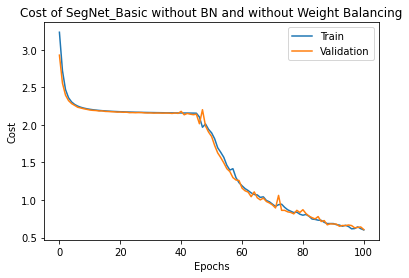

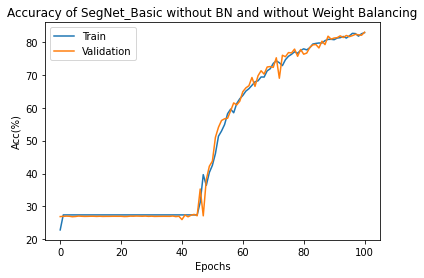

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet_Basic without BN and without Weight Balancing")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet_Basic without BN and without Weight Balancing")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/SegNet.pth'
torch.save(Net.state_dict(), PATH)

#### Test SegNet Basic without weight Balancing


100%|██████████| 1/1 [00:10<00:00, 10.12s/it]


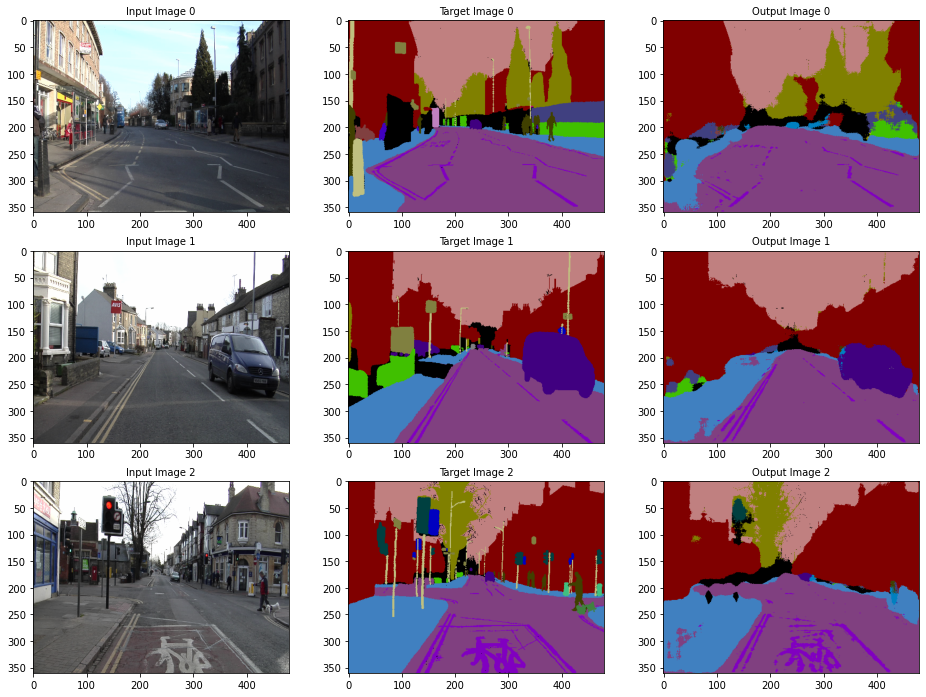

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}
          
PATH = '/content/drive/My Drive/SegNet.pth' 
net = SegNet_Basic()
net.load_state_dict(torch.load(PATH))

test_set = CamVid_Dataset(data_root, partition['test'], **kwargs)
test_generator = torch.utils.data.DataLoader(test_set, **params)

for images, labels in tqdm(test_generator):
    outputs = net(images)
    test_set.test_network(images, outputs, labels)

### Train SegNet_Basic with weight balancing

#### Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2048)

# Parameters
params = {'batch_size': 6,
          'shuffle': False,
          'num_workers': 2}

max_epochs = 20

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic()
Net.to(device)

# Calculate median frequency balancing 
class_weights = training_set.labels_weight()

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(weight = Tensor(class_weights).to(device))
optimizer = optim.SGD(Net.parameters(), lr = 0.1, momentum = 0.9)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

dataiter = iter(training_generator)
batch_train_data, batch_train_labels = dataiter.next()

dataiter = iter(validation_generator)
batch_data, batch_labels = dataiter.next()
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training

    # Transfer to GPU
    batch_train_data, batch_train_labels = batch_train_data.to(device), batch_train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(batch_train_data)

    loss = criterion(batch_train_outputs, batch_train_labels.long())
    loss.backward()
    optimizer.step()

    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels)

    if train_cnt % 10 == 9:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for batch_data, batch_labels in tqdm(validation_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        val_loss = criterion(batch_outputs, batch_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)










  0%|          | 0/20 [00:00<?, ?it/s]








  5%|▌         | 1/20 [00:00<00:14,  1.32it/s]








 10%|█         | 2/20 [00:01<00:13,  1.36it/s]








 15%|█▌        | 3/20 [00:02<00:12,  1.39it/s]








 20%|██        | 4/20 [00:02<00:11,  1.41it/s]








 25%|██▌       | 5/20 [00:03<00:10,  1.43it/s]








 30%|███       | 6/20 [00:04<00:09,  1.44it/s]








 35%|███▌      | 7/20 [00:04<00:08,  1.45it/s]








 40%|████      | 8/20 [00:05<00:08,  1.45it/s]








 45%|████▌     | 9/20 [00:06<00:07,  1.46it/s]








 50%|█████     | 10/20 [00:06<00:06,  1.45it/s]








 55%|█████▌    | 11/20 [00:07<00:06,  1.45it/s]








 60%|██████    | 12/20 [00:08<00:05,  1.45it/s]








 65%|██████▌   | 13/20 [00:08<00:04,  1.45it/s]








 70%|███████   | 14/20 [00:09<00:04,  1.45it/s]








 75%|███████▌  | 15/20 [00:10<00:03,  1.45it/s]








 80%|████████  | 16/20 [00:11<00:02,  1.44it/s]








 85%|████████▌ | 17/20 [00:11<00:02,  1.44it/s]








 

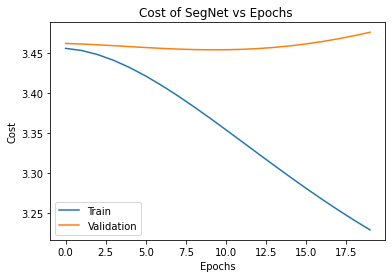

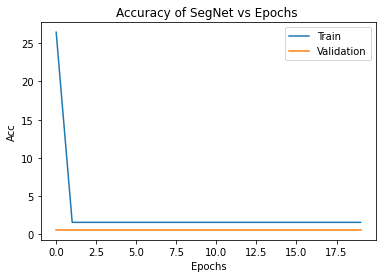

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet vs Epochs ")
    plt.ylabel('Acc')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
class_weights

[tensor(99.9789),
 tensor(7.8066),
 tensor(0.9868),
 tensor(10.4290),
 tensor(0.0238),
 tensor(0.1459),
 tensor(19.1171),
 tensor(18.0046),
 tensor(0.5364),
 tensor(0.3671),
 tensor(0.3108),
 tensor(48.9013),
 tensor(0.8852),
 tensor(42.3784),
 tensor(1.2476),
 tensor(1.5651),
 tensor(0.8008),
 tensor(0.0192),
 tensor(2.0840),
 tensor(0.0840),
 tensor(4.3788),
 tensor(0.0329),
 tensor(0.7055),
 tensor(163.8248),
 tensor(1.4492),
 tensor(1.),
 tensor(0.0485),
 tensor(1.0136),
 tensor(1.),
 tensor(0.7009),
 tensor(0.1721),
 tensor(0.3923)]

#### Training   

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 6,
          'shuffle': False,
          'num_workers': 2}

max_epochs = 20

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic()
Net.to(device)

# Calculate median frequency balancing 
#class_weights = training_set.labels_weight()

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(weight = Tensor(class_weights).to(device))
optimizer = optim.SGD(Net.parameters(), lr = 0.1, momentum = 0.9, nesterov = True)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []


# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1

    

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)










  0%|          | 0/20 [00:00<?, ?it/s]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:24,  2.85s/it]









  2%|▏         | 2/94 [00:03<03:18,  2.16s/it]









  3%|▎         | 3/94 [00:05<03:03,  2.02s/it]









  4%|▍         | 4/94 [00:05<02:22,  1.58s/it]









  5%|▌         | 5/94 [00:07<02:28,  1.67s/it]









  6%|▋         | 6/94 [00:08<01:57,  1.34s/it]









  7%|▋         | 7/94 [00:10<02:12,  1.52s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.24s/it]









 10%|▉         | 9/94 [00:12<02:02,  1.44s/it]









 11%|█         | 10/94 [00:13<01:39,  1.18s/it]

Cost of Train data after 10 iterations in epoch 1 : 3.471522












 12%|█▏        | 11/94 [00:15<01:55,  1.39s/it]









 13%|█▎        | 12/94 [00:15<01:34,  1.15s/it]









 14%|█▍        | 13/94 [00:17<01:49,  1.35s/it]









 15%|█▍        | 14/94 [00:17<01:29,  1.12s/it]









 16%|█▌        | 15/94 [00:19<01:42,  1.29s/it]









 17%|█▋        | 16/94 [00:20<01:24,  1.08s/it]









 18%|█▊        | 17/94 [00:22<01:38,  1.29s/it]









 19%|█▉        | 18/94 [00:22<01:21,  1.07s/it]









 20%|██        | 19/94 [00:24<01:39,  1.32s/it]









 21%|██▏       | 20/94 [00:25<01:21,  1.10s/it]

Cost of Train data after 20 iterations in epoch 1 : 3.441474












 22%|██▏       | 21/94 [00:27<01:39,  1.36s/it]









 23%|██▎       | 22/94 [00:27<01:20,  1.12s/it]









 24%|██▍       | 23/94 [00:29<01:36,  1.37s/it]









 26%|██▌       | 24/94 [00:30<01:19,  1.13s/it]









 27%|██▋       | 25/94 [00:31<01:32,  1.34s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.11s/it]









 29%|██▊       | 27/94 [00:34<01:28,  1.32s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.10s/it]









 31%|███       | 29/94 [00:36<01:25,  1.32s/it]









 32%|███▏      | 30/94 [00:37<01:09,  1.09s/it]

Cost of Train data after 30 iterations in epoch 1 : 3.427979












 33%|███▎      | 31/94 [00:39<01:20,  1.27s/it]









 34%|███▍      | 32/94 [00:39<01:05,  1.06s/it]









 35%|███▌      | 33/94 [00:41<01:18,  1.29s/it]









 36%|███▌      | 34/94 [00:42<01:04,  1.08s/it]









 37%|███▋      | 35/94 [00:43<01:17,  1.31s/it]









 38%|███▊      | 36/94 [00:44<01:02,  1.08s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.31s/it]









 40%|████      | 38/94 [00:46<01:00,  1.09s/it]









 41%|████▏     | 39/94 [00:48<01:13,  1.33s/it]









 43%|████▎     | 40/94 [00:49<00:59,  1.10s/it]

Cost of Train data after 40 iterations in epoch 1 : 3.485540












 44%|████▎     | 41/94 [00:51<01:10,  1.33s/it]









 45%|████▍     | 42/94 [00:51<00:57,  1.10s/it]









 46%|████▌     | 43/94 [00:53<01:10,  1.39s/it]









 47%|████▋     | 44/94 [00:54<00:57,  1.14s/it]









 48%|████▊     | 45/94 [00:56<01:06,  1.35s/it]









 49%|████▉     | 46/94 [00:56<00:53,  1.11s/it]









 50%|█████     | 47/94 [00:58<01:04,  1.38s/it]









 51%|█████     | 48/94 [00:59<00:52,  1.14s/it]









 52%|█████▏    | 49/94 [01:01<01:01,  1.37s/it]









 53%|█████▎    | 50/94 [01:01<00:49,  1.13s/it]

Cost of Train data after 50 iterations in epoch 1 : 3.435874












 54%|█████▍    | 51/94 [01:03<00:57,  1.35s/it]









 55%|█████▌    | 52/94 [01:04<00:46,  1.11s/it]









 56%|█████▋    | 53/94 [01:06<00:55,  1.35s/it]









 57%|█████▋    | 54/94 [01:06<00:44,  1.11s/it]









 59%|█████▊    | 55/94 [01:08<00:51,  1.33s/it]









 60%|█████▉    | 56/94 [01:09<00:41,  1.10s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.31s/it]









 62%|██████▏   | 58/94 [01:11<00:38,  1.08s/it]









 63%|██████▎   | 59/94 [01:13<00:45,  1.31s/it]









 64%|██████▍   | 60/94 [01:13<00:36,  1.08s/it]

Cost of Train data after 60 iterations in epoch 1 : 3.399602












 65%|██████▍   | 61/94 [01:15<00:42,  1.30s/it]









 66%|██████▌   | 62/94 [01:16<00:34,  1.07s/it]









 67%|██████▋   | 63/94 [01:17<00:39,  1.28s/it]









 68%|██████▊   | 64/94 [01:18<00:32,  1.07s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.28s/it]









 70%|███████   | 66/94 [01:20<00:29,  1.06s/it]









 71%|███████▏  | 67/94 [01:22<00:34,  1.28s/it]









 72%|███████▏  | 68/94 [01:23<00:27,  1.06s/it]









 73%|███████▎  | 69/94 [01:24<00:32,  1.28s/it]









 74%|███████▍  | 70/94 [01:25<00:25,  1.08s/it]

Cost of Train data after 70 iterations in epoch 1 : 3.408530












 76%|███████▌  | 71/94 [01:27<00:28,  1.26s/it]









 77%|███████▋  | 72/94 [01:27<00:23,  1.09s/it]









 78%|███████▊  | 73/94 [01:29<00:25,  1.23s/it]









 79%|███████▊  | 74/94 [01:30<00:22,  1.12s/it]









 80%|███████▉  | 75/94 [01:31<00:23,  1.25s/it]









 81%|████████  | 76/94 [01:32<00:20,  1.16s/it]









 82%|████████▏ | 77/94 [01:34<00:21,  1.27s/it]









 83%|████████▎ | 78/94 [01:35<00:18,  1.13s/it]









 84%|████████▍ | 79/94 [01:36<00:19,  1.28s/it]









 85%|████████▌ | 80/94 [01:37<00:16,  1.15s/it]

Cost of Train data after 80 iterations in epoch 1 : 3.430313












 86%|████████▌ | 81/94 [01:39<00:16,  1.26s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.12s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.30s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.08s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.32s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.09s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.33s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.11s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.30s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.13s/it]

Cost of Train data after 90 iterations in epoch 1 : 3.423922












 97%|█████████▋| 91/94 [01:51<00:03,  1.25s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.13s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.18s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.42s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.74s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.81s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.31s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.52s/it]









 26%|██▌       | 6/23 [00:06<00:18,  1.12s/it]









 30%|███       | 7/23 [00:08<00:21,  1.37s/it]









 35%|███▍      | 8/23 [00:09<00:14,  1.00it/s]









 39%|███▉      | 9/23 [00:10<00:18,  1.30s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.04it/s]

Cost of Validation data after 10 iterations in epoch 1 : 3.374482












 48%|████▊     | 11/23 [00:13<00:15,  1.29s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.06it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.25s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.09it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.26s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.27s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:21<00:05,  1.26s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 1 : 3.389088












 91%|█████████▏| 21/23 [00:24<00:02,  1.25s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.09it/s]









100%|██████████| 23/23 [00:25<00:00,  1.10s/it]









  5%|▌         | 1/20 [02:18<43:59, 138.92s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:26,  2.86s/it]









  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]









  3%|▎         | 3/94 [00:05<03:07,  2.06s/it]









  4%|▍         | 4/94 [00:05<02:24,  1.61s/it]









  5%|▌         | 5/94 [00:07<02:30,  1.69s/it]









  6%|▋         | 6/94 [00:08<01:58,  1.35s/it]









  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]









  9%|▊         | 8/94 [00:10<01:44,  1.22s/it]









 10%|▉         | 9/94 [00:12<02:00,  1.42s/it]









 11%|█         | 10/94 [00:13<01:37,  1.16s/it]

Cost of Train data after 10 iterations in epoch 2 : 3.460161












 12%|█▏        | 11/94 [00:14<01:53,  1.37s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.13s/it]









 14%|█▍        | 13/94 [00:17<01:48,  1.34s/it]









 15%|█▍        | 14/94 [00:17<01:28,  1.11s/it]









 16%|█▌        | 15/94 [00:19<01:48,  1.37s/it]









 17%|█▋        | 16/94 [00:20<01:28,  1.13s/it]









 18%|█▊        | 17/94 [00:22<01:45,  1.36s/it]









 19%|█▉        | 18/94 [00:22<01:25,  1.13s/it]









 20%|██        | 19/94 [00:24<01:43,  1.38s/it]









 21%|██▏       | 20/94 [00:25<01:23,  1.13s/it]

Cost of Train data after 20 iterations in epoch 2 : 3.388272












 22%|██▏       | 21/94 [00:27<01:36,  1.33s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.10s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.34s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.11s/it]









 27%|██▋       | 25/94 [00:32<01:31,  1.32s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]









 29%|██▊       | 27/94 [00:34<01:27,  1.30s/it]









 30%|██▉       | 28/94 [00:35<01:11,  1.09s/it]









 31%|███       | 29/94 [00:36<01:24,  1.30s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.10s/it]

Cost of Train data after 30 iterations in epoch 2 : 3.412814












 33%|███▎      | 31/94 [00:39<01:21,  1.29s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:16,  1.26s/it]









 36%|███▌      | 34/94 [00:42<01:08,  1.14s/it]









 37%|███▋      | 35/94 [00:43<01:13,  1.25s/it]









 38%|███▊      | 36/94 [00:44<01:06,  1.15s/it]









 39%|███▉      | 37/94 [00:46<01:11,  1.26s/it]









 40%|████      | 38/94 [00:47<01:04,  1.15s/it]









 41%|████▏     | 39/94 [00:48<01:07,  1.24s/it]









 43%|████▎     | 40/94 [00:49<01:01,  1.14s/it]

Cost of Train data after 40 iterations in epoch 2 : 3.464387












 44%|████▎     | 41/94 [00:51<01:06,  1.25s/it]









 45%|████▍     | 42/94 [00:51<00:59,  1.15s/it]









 46%|████▌     | 43/94 [00:53<01:03,  1.24s/it]









 47%|████▋     | 44/94 [00:54<00:57,  1.16s/it]









 48%|████▊     | 45/94 [00:55<01:00,  1.24s/it]









 49%|████▉     | 46/94 [00:56<00:56,  1.17s/it]









 50%|█████     | 47/94 [00:58<00:58,  1.25s/it]









 51%|█████     | 48/94 [00:59<00:53,  1.17s/it]









 52%|█████▏    | 49/94 [01:00<00:56,  1.26s/it]









 53%|█████▎    | 50/94 [01:01<00:50,  1.15s/it]

Cost of Train data after 50 iterations in epoch 2 : 3.410048












 54%|█████▍    | 51/94 [01:03<00:54,  1.26s/it]









 55%|█████▌    | 52/94 [01:03<00:48,  1.14s/it]









 56%|█████▋    | 53/94 [01:05<00:51,  1.25s/it]









 57%|█████▋    | 54/94 [01:06<00:45,  1.14s/it]









 59%|█████▊    | 55/94 [01:07<00:48,  1.25s/it]









 60%|█████▉    | 56/94 [01:08<00:43,  1.15s/it]









 61%|██████    | 57/94 [01:10<00:46,  1.27s/it]









 62%|██████▏   | 58/94 [01:11<00:40,  1.12s/it]









 63%|██████▎   | 59/94 [01:12<00:44,  1.27s/it]









 64%|██████▍   | 60/94 [01:13<00:38,  1.14s/it]

Cost of Train data after 60 iterations in epoch 2 : 3.381463












 65%|██████▍   | 61/94 [01:15<00:42,  1.27s/it]









 66%|██████▌   | 62/94 [01:16<00:37,  1.16s/it]









 67%|██████▋   | 63/94 [01:17<00:39,  1.26s/it]









 68%|██████▊   | 64/94 [01:18<00:34,  1.15s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.29s/it]









 70%|███████   | 66/94 [01:20<00:30,  1.10s/it]









 71%|███████▏  | 67/94 [01:22<00:33,  1.26s/it]









 72%|███████▏  | 68/94 [01:22<00:27,  1.08s/it]









 73%|███████▎  | 69/94 [01:24<00:32,  1.31s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.09s/it]

Cost of Train data after 70 iterations in epoch 2 : 3.398765












 76%|███████▌  | 71/94 [01:27<00:30,  1.34s/it]









 77%|███████▋  | 72/94 [01:27<00:24,  1.11s/it]









 78%|███████▊  | 73/94 [01:29<00:28,  1.35s/it]









 79%|███████▊  | 74/94 [01:30<00:22,  1.12s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.34s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.10s/it]









 82%|████████▏ | 77/94 [01:34<00:21,  1.25s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.11s/it]









 84%|████████▍ | 79/94 [01:36<00:18,  1.24s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.11s/it]

Cost of Train data after 80 iterations in epoch 2 : 3.422008












 86%|████████▌ | 81/94 [01:39<00:16,  1.27s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.11s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.28s/it]









 89%|████████▉ | 84/94 [01:42<00:11,  1.13s/it]









 90%|█████████ | 85/94 [01:43<00:11,  1.26s/it]









 91%|█████████▏| 86/94 [01:44<00:09,  1.16s/it]









 93%|█████████▎| 87/94 [01:46<00:08,  1.26s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.11s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.30s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.08s/it]

Cost of Train data after 90 iterations in epoch 2 : 3.413011












 97%|█████████▋| 91/94 [01:51<00:03,  1.31s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.09s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.20s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.48s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.78s/it]









 13%|█▎        | 3/23 [00:04<00:37,  1.86s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.35s/it]









 22%|██▏       | 5/23 [00:06<00:28,  1.57s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.14s/it]









 30%|███       | 7/23 [00:09<00:22,  1.42s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.04s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.02it/s]

Cost of Validation data after 10 iterations in epoch 2 : 3.367987












 48%|████▊     | 11/23 [00:13<00:15,  1.26s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.08it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.28s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.27s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.07it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.26s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:22<00:05,  1.25s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 2 : 3.382571












 91%|█████████▏| 21/23 [00:24<00:02,  1.28s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.07it/s]









100%|██████████| 23/23 [00:25<00:00,  1.11s/it]









 10%|█         | 2/20 [04:38<41:41, 139.00s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:26,  2.87s/it]









  2%|▏         | 2/94 [00:03<03:20,  2.18s/it]









  3%|▎         | 3/94 [00:05<03:08,  2.07s/it]









  4%|▍         | 4/94 [00:05<02:25,  1.62s/it]









  5%|▌         | 5/94 [00:07<02:26,  1.65s/it]









  6%|▋         | 6/94 [00:08<01:56,  1.32s/it]









  7%|▋         | 7/94 [00:09<02:08,  1.48s/it]









  9%|▊         | 8/94 [00:10<01:43,  1.20s/it]









 10%|▉         | 9/94 [00:12<01:59,  1.41s/it]









 11%|█         | 10/94 [00:12<01:37,  1.16s/it]

Cost of Train data after 10 iterations in epoch 3 : 3.457474












 12%|█▏        | 11/94 [00:14<01:52,  1.35s/it]









 13%|█▎        | 12/94 [00:15<01:31,  1.12s/it]









 14%|█▍        | 13/94 [00:17<01:48,  1.34s/it]









 15%|█▍        | 14/94 [00:17<01:29,  1.12s/it]









 16%|█▌        | 15/94 [00:19<01:43,  1.31s/it]









 17%|█▋        | 16/94 [00:20<01:27,  1.13s/it]









 18%|█▊        | 17/94 [00:21<01:37,  1.27s/it]









 19%|█▉        | 18/94 [00:22<01:29,  1.17s/it]









 20%|██        | 19/94 [00:24<01:35,  1.28s/it]









 21%|██▏       | 20/94 [00:25<01:26,  1.16s/it]

Cost of Train data after 20 iterations in epoch 3 : 3.383430












 22%|██▏       | 21/94 [00:26<01:32,  1.26s/it]









 23%|██▎       | 22/94 [00:27<01:23,  1.16s/it]









 24%|██▍       | 23/94 [00:29<01:30,  1.27s/it]









 26%|██▌       | 24/94 [00:30<01:20,  1.15s/it]









 27%|██▋       | 25/94 [00:31<01:28,  1.28s/it]









 28%|██▊       | 26/94 [00:32<01:18,  1.15s/it]









 29%|██▊       | 27/94 [00:33<01:23,  1.24s/it]









 30%|██▉       | 28/94 [00:34<01:18,  1.18s/it]









 31%|███       | 29/94 [00:36<01:18,  1.21s/it]









 32%|███▏      | 30/94 [00:37<01:18,  1.22s/it]

Cost of Train data after 30 iterations in epoch 3 : 3.408704












 33%|███▎      | 31/94 [00:38<01:14,  1.19s/it]









 34%|███▍      | 32/94 [00:39<01:15,  1.22s/it]









 35%|███▌      | 33/94 [00:41<01:15,  1.23s/it]









 36%|███▌      | 34/94 [00:42<01:09,  1.16s/it]









 37%|███▋      | 35/94 [00:43<01:11,  1.22s/it]









 38%|███▊      | 36/94 [00:44<01:06,  1.14s/it]









 39%|███▉      | 37/94 [00:45<01:11,  1.26s/it]









 40%|████      | 38/94 [00:46<01:02,  1.12s/it]









 41%|████▏     | 39/94 [00:48<01:10,  1.28s/it]









 43%|████▎     | 40/94 [00:49<00:59,  1.10s/it]

Cost of Train data after 40 iterations in epoch 3 : 3.459585












 44%|████▎     | 41/94 [00:50<01:07,  1.27s/it]









 45%|████▍     | 42/94 [00:51<00:59,  1.14s/it]









 46%|████▌     | 43/94 [00:53<01:03,  1.24s/it]









 47%|████▋     | 44/94 [00:54<00:57,  1.15s/it]









 48%|████▊     | 45/94 [00:55<01:01,  1.26s/it]









 49%|████▉     | 46/94 [00:56<00:54,  1.14s/it]









 50%|█████     | 47/94 [00:57<00:59,  1.26s/it]









 51%|█████     | 48/94 [00:58<00:52,  1.15s/it]









 52%|█████▏    | 49/94 [01:00<00:56,  1.26s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.09s/it]

Cost of Train data after 50 iterations in epoch 3 : 3.405703












 54%|█████▍    | 51/94 [01:02<00:57,  1.33s/it]









 55%|█████▌    | 52/94 [01:03<00:46,  1.10s/it]









 56%|█████▋    | 53/94 [01:05<00:54,  1.33s/it]









 57%|█████▋    | 54/94 [01:06<00:44,  1.12s/it]









 59%|█████▊    | 55/94 [01:07<00:52,  1.34s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.11s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.31s/it]









 62%|██████▏   | 58/94 [01:10<00:40,  1.12s/it]









 63%|██████▎   | 59/94 [01:12<00:44,  1.28s/it]









 64%|██████▍   | 60/94 [01:13<00:37,  1.11s/it]

Cost of Train data after 60 iterations in epoch 3 : 3.377767












 65%|██████▍   | 61/94 [01:15<00:43,  1.32s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.10s/it]









 67%|██████▋   | 63/94 [01:17<00:41,  1.34s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.10s/it]









 69%|██████▉   | 65/94 [01:20<00:38,  1.34s/it]









 70%|███████   | 66/94 [01:20<00:30,  1.11s/it]









 71%|███████▏  | 67/94 [01:22<00:36,  1.35s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.11s/it]









 73%|███████▎  | 69/94 [01:24<00:32,  1.30s/it]









 74%|███████▍  | 70/94 [01:25<00:25,  1.08s/it]

Cost of Train data after 70 iterations in epoch 3 : 3.395623












 76%|███████▌  | 71/94 [01:27<00:30,  1.31s/it]









 77%|███████▋  | 72/94 [01:27<00:23,  1.09s/it]









 78%|███████▊  | 73/94 [01:29<00:28,  1.33s/it]









 79%|███████▊  | 74/94 [01:30<00:22,  1.10s/it]









 80%|███████▉  | 75/94 [01:31<00:24,  1.28s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.10s/it]









 82%|████████▏ | 77/94 [01:34<00:21,  1.27s/it]









 83%|████████▎ | 78/94 [01:34<00:17,  1.08s/it]









 84%|████████▍ | 79/94 [01:36<00:19,  1.30s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.08s/it]

Cost of Train data after 80 iterations in epoch 3 : 3.419044












 86%|████████▌ | 81/94 [01:39<00:17,  1.33s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.10s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.35s/it]









 89%|████████▉ | 84/94 [01:42<00:11,  1.12s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.33s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.11s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.32s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.09s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.34s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.11s/it]

Cost of Train data after 90 iterations in epoch 3 : 3.410153












 97%|█████████▋| 91/94 [01:51<00:03,  1.33s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.10s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.21s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.46s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.77s/it]









 13%|█▎        | 3/23 [00:04<00:37,  1.86s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.34s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.54s/it]









 26%|██▌       | 6/23 [00:06<00:19,  1.13s/it]









 30%|███       | 7/23 [00:09<00:22,  1.39s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.02it/s]

Cost of Validation data after 10 iterations in epoch 3 : 3.365531












 48%|████▊     | 11/23 [00:13<00:15,  1.30s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.04it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.28s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.07it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.27s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.07it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.23s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.11it/s]









 83%|████████▎ | 19/23 [00:22<00:04,  1.25s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.09it/s]

Cost of Validation data after 20 iterations in epoch 3 : 3.380051












 91%|█████████▏| 21/23 [00:24<00:02,  1.21s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.12it/s]









100%|██████████| 23/23 [00:25<00:00,  1.11s/it]









 15%|█▌        | 3/20 [06:57<39:24, 139.07s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:23,  2.83s/it]









  2%|▏         | 2/94 [00:03<03:18,  2.15s/it]









  3%|▎         | 3/94 [00:05<03:06,  2.05s/it]









  4%|▍         | 4/94 [00:05<02:23,  1.60s/it]









  5%|▌         | 5/94 [00:07<02:31,  1.70s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.36s/it]









  7%|▋         | 7/94 [00:10<02:12,  1.52s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.24s/it]









 10%|▉         | 9/94 [00:12<02:03,  1.46s/it]









 11%|█         | 10/94 [00:13<01:40,  1.19s/it]

Cost of Train data after 10 iterations in epoch 4 : 3.455200












 12%|█▏        | 11/94 [00:15<01:54,  1.38s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]









 14%|█▍        | 13/94 [00:17<01:49,  1.35s/it]









 15%|█▍        | 14/94 [00:18<01:29,  1.12s/it]









 16%|█▌        | 15/94 [00:19<01:43,  1.31s/it]









 17%|█▋        | 16/94 [00:20<01:24,  1.09s/it]









 18%|█▊        | 17/94 [00:22<01:42,  1.33s/it]









 19%|█▉        | 18/94 [00:22<01:23,  1.10s/it]









 20%|██        | 19/94 [00:24<01:38,  1.32s/it]









 21%|██▏       | 20/94 [00:25<01:21,  1.09s/it]

Cost of Train data after 20 iterations in epoch 4 : 3.381328












 22%|██▏       | 21/94 [00:27<01:36,  1.32s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.10s/it]









 24%|██▍       | 23/94 [00:29<01:33,  1.31s/it]









 26%|██▌       | 24/94 [00:30<01:16,  1.09s/it]









 27%|██▋       | 25/94 [00:31<01:29,  1.30s/it]









 28%|██▊       | 26/94 [00:32<01:13,  1.08s/it]









 29%|██▊       | 27/94 [00:34<01:27,  1.30s/it]









 30%|██▉       | 28/94 [00:34<01:11,  1.08s/it]









 31%|███       | 29/94 [00:36<01:27,  1.34s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.11s/it]

Cost of Train data after 30 iterations in epoch 4 : 3.406607












 33%|███▎      | 31/94 [00:39<01:23,  1.32s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:18,  1.29s/it]









 36%|███▌      | 34/94 [00:42<01:04,  1.07s/it]









 37%|███▋      | 35/94 [00:43<01:15,  1.28s/it]









 38%|███▊      | 36/94 [00:44<01:02,  1.07s/it]









 39%|███▉      | 37/94 [00:46<01:16,  1.34s/it]









 40%|████      | 38/94 [00:46<01:02,  1.11s/it]









 41%|████▏     | 39/94 [00:48<01:12,  1.31s/it]









 43%|████▎     | 40/94 [00:49<00:58,  1.09s/it]

Cost of Train data after 40 iterations in epoch 4 : 3.457491












 44%|████▎     | 41/94 [00:51<01:09,  1.32s/it]









 45%|████▍     | 42/94 [00:51<00:56,  1.09s/it]









 46%|████▌     | 43/94 [00:53<01:08,  1.34s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.11s/it]









 48%|████▊     | 45/94 [00:55<01:03,  1.29s/it]









 49%|████▉     | 46/94 [00:56<00:52,  1.08s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.30s/it]









 51%|█████     | 48/94 [00:58<00:49,  1.08s/it]









 52%|█████▏    | 49/94 [01:00<00:59,  1.32s/it]









 53%|█████▎    | 50/94 [01:01<00:48,  1.10s/it]

Cost of Train data after 50 iterations in epoch 4 : 3.403882












 54%|█████▍    | 51/94 [01:03<00:57,  1.33s/it]









 55%|█████▌    | 52/94 [01:03<00:46,  1.10s/it]









 56%|█████▋    | 53/94 [01:05<00:54,  1.33s/it]









 57%|█████▋    | 54/94 [01:06<00:44,  1.10s/it]









 59%|█████▊    | 55/94 [01:08<00:51,  1.31s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.09s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.32s/it]









 62%|██████▏   | 58/94 [01:11<00:39,  1.10s/it]









 63%|██████▎   | 59/94 [01:12<00:44,  1.28s/it]









 64%|██████▍   | 60/94 [01:13<00:36,  1.07s/it]

Cost of Train data after 60 iterations in epoch 4 : 3.376106












 65%|██████▍   | 61/94 [01:15<00:43,  1.33s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.10s/it]









 67%|██████▋   | 63/94 [01:17<00:41,  1.35s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.12s/it]









 69%|██████▉   | 65/94 [01:20<00:38,  1.34s/it]









 70%|███████   | 66/94 [01:20<00:31,  1.11s/it]









 71%|███████▏  | 67/94 [01:22<00:36,  1.36s/it]









 72%|███████▏  | 68/94 [01:23<00:29,  1.13s/it]









 73%|███████▎  | 69/94 [01:25<00:33,  1.36s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.12s/it]

Cost of Train data after 70 iterations in epoch 4 : 3.394049












 76%|███████▌  | 71/94 [01:27<00:30,  1.34s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.10s/it]









 78%|███████▊  | 73/94 [01:30<00:28,  1.34s/it]









 79%|███████▊  | 74/94 [01:30<00:22,  1.11s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.33s/it]









 81%|████████  | 76/94 [01:33<00:19,  1.11s/it]









 82%|████████▏ | 77/94 [01:34<00:22,  1.31s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.09s/it]









 84%|████████▍ | 79/94 [01:37<00:19,  1.32s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.10s/it]

Cost of Train data after 80 iterations in epoch 4 : 3.417513












 86%|████████▌ | 81/94 [01:39<00:16,  1.30s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.09s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.31s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.09s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.27s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.07s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.30s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.08s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.30s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.09s/it]

Cost of Train data after 90 iterations in epoch 4 : 3.408723












 97%|█████████▋| 91/94 [01:51<00:03,  1.31s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.09s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.17s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.47s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.78s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.83s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.32s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.55s/it]









 26%|██▌       | 6/23 [00:06<00:19,  1.13s/it]









 30%|███       | 7/23 [00:08<00:22,  1.40s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.29s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.06it/s]

Cost of Validation data after 10 iterations in epoch 4 : 3.364211












 48%|████▊     | 11/23 [00:13<00:15,  1.30s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.04it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.28s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.05it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.25s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.25s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.23s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.10it/s]

Cost of Validation data after 20 iterations in epoch 4 : 3.378712












 91%|█████████▏| 21/23 [00:24<00:02,  1.23s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.11it/s]









100%|██████████| 23/23 [00:25<00:00,  1.10s/it]









 20%|██        | 4/20 [09:16<37:05, 139.09s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:22,  2.83s/it]









  2%|▏         | 2/94 [00:03<03:17,  2.15s/it]









  3%|▎         | 3/94 [00:05<03:09,  2.09s/it]









  4%|▍         | 4/94 [00:05<02:26,  1.63s/it]









  5%|▌         | 5/94 [00:07<02:28,  1.67s/it]









  6%|▋         | 6/94 [00:08<01:57,  1.34s/it]









  7%|▋         | 7/94 [00:10<02:07,  1.47s/it]









  9%|▊         | 8/94 [00:10<01:43,  1.20s/it]









 10%|▉         | 9/94 [00:12<01:55,  1.36s/it]









 11%|█         | 10/94 [00:12<01:34,  1.13s/it]

Cost of Train data after 10 iterations in epoch 5 : 3.453863












 12%|█▏        | 11/94 [00:14<01:50,  1.33s/it]









 13%|█▎        | 12/94 [00:15<01:30,  1.10s/it]









 14%|█▍        | 13/94 [00:17<01:45,  1.31s/it]









 15%|█▍        | 14/94 [00:17<01:26,  1.09s/it]









 16%|█▌        | 15/94 [00:19<01:41,  1.28s/it]









 17%|█▋        | 16/94 [00:19<01:23,  1.07s/it]









 18%|█▊        | 17/94 [00:21<01:40,  1.31s/it]









 19%|█▉        | 18/94 [00:22<01:23,  1.09s/it]









 20%|██        | 19/94 [00:24<01:41,  1.35s/it]









 21%|██▏       | 20/94 [00:24<01:23,  1.13s/it]

Cost of Train data after 20 iterations in epoch 5 : 3.380152












 22%|██▏       | 21/94 [00:26<01:38,  1.36s/it]









 23%|██▎       | 22/94 [00:27<01:21,  1.13s/it]









 24%|██▍       | 23/94 [00:29<01:33,  1.31s/it]









 26%|██▌       | 24/94 [00:29<01:16,  1.09s/it]









 27%|██▋       | 25/94 [00:31<01:30,  1.32s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]









 29%|██▊       | 27/94 [00:34<01:27,  1.31s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.09s/it]









 31%|███       | 29/94 [00:36<01:25,  1.31s/it]









 32%|███▏      | 30/94 [00:36<01:09,  1.09s/it]

Cost of Train data after 30 iterations in epoch 5 : 3.405402












 33%|███▎      | 31/94 [00:38<01:23,  1.33s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.11s/it]









 35%|███▌      | 33/94 [00:41<01:22,  1.35s/it]









 36%|███▌      | 34/94 [00:41<01:07,  1.12s/it]









 37%|███▋      | 35/94 [00:43<01:19,  1.34s/it]









 38%|███▊      | 36/94 [00:44<01:04,  1.11s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.31s/it]









 40%|████      | 38/94 [00:46<01:00,  1.09s/it]









 41%|████▏     | 39/94 [00:48<01:11,  1.30s/it]









 43%|████▎     | 40/94 [00:49<00:58,  1.08s/it]

Cost of Train data after 40 iterations in epoch 5 : 3.456312












 44%|████▎     | 41/94 [00:50<01:10,  1.33s/it]









 45%|████▍     | 42/94 [00:51<00:56,  1.09s/it]









 46%|████▌     | 43/94 [00:53<01:02,  1.23s/it]









 47%|████▋     | 44/94 [00:53<00:51,  1.04s/it]









 48%|████▊     | 45/94 [00:55<01:02,  1.28s/it]









 49%|████▉     | 46/94 [00:56<00:51,  1.07s/it]









 50%|█████     | 47/94 [00:57<01:00,  1.30s/it]









 51%|█████     | 48/94 [00:58<00:49,  1.08s/it]









 52%|█████▏    | 49/94 [01:00<00:59,  1.32s/it]









 53%|█████▎    | 50/94 [01:00<00:47,  1.09s/it]

Cost of Train data after 50 iterations in epoch 5 : 3.402839












 54%|█████▍    | 51/94 [01:02<00:57,  1.33s/it]









 55%|█████▌    | 52/94 [01:03<00:46,  1.10s/it]









 56%|█████▋    | 53/94 [01:05<00:53,  1.31s/it]









 57%|█████▋    | 54/94 [01:05<00:43,  1.09s/it]









 59%|█████▊    | 55/94 [01:07<00:51,  1.32s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.10s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.32s/it]









 62%|██████▏   | 58/94 [01:10<00:40,  1.11s/it]









 63%|██████▎   | 59/94 [01:12<00:45,  1.30s/it]









 64%|██████▍   | 60/94 [01:13<00:37,  1.11s/it]

Cost of Train data after 60 iterations in epoch 5 : 3.375130












 65%|██████▍   | 61/94 [01:14<00:44,  1.34s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.10s/it]









 67%|██████▋   | 63/94 [01:17<00:42,  1.36s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.13s/it]









 69%|██████▉   | 65/94 [01:19<00:38,  1.34s/it]









 70%|███████   | 66/94 [01:20<00:31,  1.11s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.33s/it]









 72%|███████▏  | 68/94 [01:22<00:28,  1.10s/it]









 73%|███████▎  | 69/94 [01:24<00:33,  1.33s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.10s/it]

Cost of Train data after 70 iterations in epoch 5 : 3.393105












 76%|███████▌  | 71/94 [01:27<00:30,  1.31s/it]









 77%|███████▋  | 72/94 [01:27<00:23,  1.08s/it]









 78%|███████▊  | 73/94 [01:29<00:27,  1.33s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.10s/it]









 80%|███████▉  | 75/94 [01:31<00:25,  1.33s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.10s/it]









 82%|████████▏ | 77/94 [01:34<00:22,  1.34s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.11s/it]









 84%|████████▍ | 79/94 [01:36<00:20,  1.33s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.11s/it]

Cost of Train data after 80 iterations in epoch 5 : 3.416582












 86%|████████▌ | 81/94 [01:39<00:17,  1.34s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.12s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.29s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.07s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.31s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.09s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.33s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.10s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.34s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.11s/it]

Cost of Train data after 90 iterations in epoch 5 : 3.407847












 97%|█████████▋| 91/94 [01:51<00:03,  1.32s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.10s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.17s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.39s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.72s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.81s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.31s/it]









 22%|██▏       | 5/23 [00:06<00:26,  1.48s/it]









 26%|██▌       | 6/23 [00:06<00:18,  1.09s/it]









 30%|███       | 7/23 [00:08<00:21,  1.36s/it]









 35%|███▍      | 8/23 [00:08<00:14,  1.00it/s]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.03it/s]

Cost of Validation data after 10 iterations in epoch 5 : 3.363387












 48%|████▊     | 11/23 [00:13<00:15,  1.28s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.06it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.29s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.25s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.26s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:21<00:05,  1.26s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 5 : 3.377879












 91%|█████████▏| 21/23 [00:23<00:02,  1.22s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.11it/s]









100%|██████████| 23/23 [00:25<00:00,  1.09s/it]









 25%|██▌       | 5/20 [11:35<34:45, 139.02s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:28,  2.89s/it]









  2%|▏         | 2/94 [00:03<03:21,  2.19s/it]









  3%|▎         | 3/94 [00:05<03:12,  2.11s/it]









  4%|▍         | 4/94 [00:05<02:28,  1.65s/it]









  5%|▌         | 5/94 [00:07<02:35,  1.75s/it]









  6%|▋         | 6/94 [00:08<02:02,  1.40s/it]









  7%|▋         | 7/94 [00:10<02:12,  1.52s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.23s/it]









 10%|▉         | 9/94 [00:12<01:58,  1.39s/it]









 11%|█         | 10/94 [00:13<01:36,  1.15s/it]

Cost of Train data after 10 iterations in epoch 6 : 3.453019












 12%|█▏        | 11/94 [00:15<01:52,  1.36s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.12s/it]









 14%|█▍        | 13/94 [00:17<01:52,  1.39s/it]









 15%|█▍        | 14/94 [00:18<01:31,  1.15s/it]









 16%|█▌        | 15/94 [00:20<01:48,  1.37s/it]









 17%|█▋        | 16/94 [00:20<01:28,  1.14s/it]









 18%|█▊        | 17/94 [00:22<01:45,  1.37s/it]









 19%|█▉        | 18/94 [00:23<01:26,  1.13s/it]









 20%|██        | 19/94 [00:25<01:41,  1.35s/it]









 21%|██▏       | 20/94 [00:25<01:22,  1.12s/it]

Cost of Train data after 20 iterations in epoch 6 : 3.379403












 22%|██▏       | 21/94 [00:27<01:40,  1.38s/it]









 23%|██▎       | 22/94 [00:28<01:21,  1.14s/it]









 24%|██▍       | 23/94 [00:30<01:36,  1.36s/it]









 26%|██▌       | 24/94 [00:30<01:18,  1.12s/it]









 27%|██▋       | 25/94 [00:32<01:33,  1.36s/it]









 28%|██▊       | 26/94 [00:33<01:16,  1.13s/it]









 29%|██▊       | 27/94 [00:35<01:29,  1.34s/it]









 30%|██▉       | 28/94 [00:35<01:13,  1.11s/it]









 31%|███       | 29/94 [00:37<01:26,  1.33s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.10s/it]

Cost of Train data after 30 iterations in epoch 6 : 3.404627












 33%|███▎      | 31/94 [00:39<01:23,  1.33s/it]









 34%|███▍      | 32/94 [00:40<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:42<01:20,  1.32s/it]









 36%|███▌      | 34/94 [00:42<01:06,  1.10s/it]









 37%|███▋      | 35/94 [00:44<01:19,  1.34s/it]









 38%|███▊      | 36/94 [00:45<01:04,  1.11s/it]









 39%|███▉      | 37/94 [00:47<01:17,  1.35s/it]









 40%|████      | 38/94 [00:47<01:02,  1.12s/it]









 41%|████▏     | 39/94 [00:49<01:13,  1.33s/it]









 43%|████▎     | 40/94 [00:50<00:59,  1.11s/it]

Cost of Train data after 40 iterations in epoch 6 : 3.455549












 44%|████▎     | 41/94 [00:52<01:10,  1.33s/it]









 45%|████▍     | 42/94 [00:52<00:57,  1.10s/it]









 46%|████▌     | 43/94 [00:54<01:07,  1.33s/it]









 47%|████▋     | 44/94 [00:55<00:55,  1.10s/it]









 48%|████▊     | 45/94 [00:57<01:06,  1.36s/it]









 49%|████▉     | 46/94 [00:57<00:53,  1.12s/it]









 50%|█████     | 47/94 [00:59<01:02,  1.32s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.09s/it]









 52%|█████▏    | 49/94 [01:01<01:00,  1.35s/it]









 53%|█████▎    | 50/94 [01:02<00:48,  1.11s/it]

Cost of Train data after 50 iterations in epoch 6 : 3.402156












 54%|█████▍    | 51/94 [01:04<00:56,  1.32s/it]









 55%|█████▌    | 52/94 [01:04<00:46,  1.10s/it]









 56%|█████▋    | 53/94 [01:06<00:54,  1.33s/it]









 57%|█████▋    | 54/94 [01:07<00:44,  1.10s/it]









 59%|█████▊    | 55/94 [01:09<00:53,  1.36s/it]









 60%|█████▉    | 56/94 [01:09<00:42,  1.12s/it]









 61%|██████    | 57/94 [01:11<00:47,  1.29s/it]









 62%|██████▏   | 58/94 [01:12<00:38,  1.07s/it]









 63%|██████▎   | 59/94 [01:13<00:46,  1.33s/it]









 64%|██████▍   | 60/94 [01:14<00:37,  1.10s/it]

Cost of Train data after 60 iterations in epoch 6 : 3.374484












 65%|██████▍   | 61/94 [01:16<00:42,  1.28s/it]









 66%|██████▌   | 62/94 [01:16<00:34,  1.07s/it]









 67%|██████▋   | 63/94 [01:18<00:40,  1.30s/it]









 68%|██████▊   | 64/94 [01:19<00:32,  1.08s/it]









 69%|██████▉   | 65/94 [01:21<00:39,  1.35s/it]









 70%|███████   | 66/94 [01:21<00:31,  1.11s/it]









 71%|███████▏  | 67/94 [01:23<00:37,  1.37s/it]









 72%|███████▏  | 68/94 [01:24<00:29,  1.13s/it]









 73%|███████▎  | 69/94 [01:26<00:33,  1.36s/it]









 74%|███████▍  | 70/94 [01:26<00:26,  1.12s/it]

Cost of Train data after 70 iterations in epoch 6 : 3.392472












 76%|███████▌  | 71/94 [01:28<00:30,  1.34s/it]









 77%|███████▋  | 72/94 [01:29<00:24,  1.11s/it]









 78%|███████▊  | 73/94 [01:31<00:28,  1.35s/it]









 79%|███████▊  | 74/94 [01:31<00:22,  1.12s/it]









 80%|███████▉  | 75/94 [01:33<00:25,  1.32s/it]









 81%|████████  | 76/94 [01:34<00:19,  1.10s/it]









 82%|████████▏ | 77/94 [01:35<00:22,  1.31s/it]









 83%|████████▎ | 78/94 [01:36<00:17,  1.09s/it]









 84%|████████▍ | 79/94 [01:38<00:19,  1.32s/it]









 85%|████████▌ | 80/94 [01:38<00:15,  1.09s/it]

Cost of Train data after 80 iterations in epoch 6 : 3.415956












 86%|████████▌ | 81/94 [01:40<00:16,  1.31s/it]









 87%|████████▋ | 82/94 [01:41<00:13,  1.09s/it]









 88%|████████▊ | 83/94 [01:43<00:14,  1.31s/it]









 89%|████████▉ | 84/94 [01:43<00:10,  1.09s/it]









 90%|█████████ | 85/94 [01:45<00:11,  1.29s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.08s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.34s/it]









 94%|█████████▎| 88/94 [01:48<00:06,  1.11s/it]









 95%|█████████▍| 89/94 [01:50<00:06,  1.32s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.10s/it]

Cost of Train data after 90 iterations in epoch 6 : 3.407252












 97%|█████████▋| 91/94 [01:52<00:03,  1.21s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.02s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.04s/it]









100%|██████████| 94/94 [01:54<00:00,  1.22s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.42s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.74s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.82s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.32s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.54s/it]









 26%|██▌       | 6/23 [00:06<00:19,  1.12s/it]









 30%|███       | 7/23 [00:08<00:21,  1.37s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.01s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.01it/s]

Cost of Validation data after 10 iterations in epoch 6 : 3.362824












 48%|████▊     | 11/23 [00:13<00:15,  1.32s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.03it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.27s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.27s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.07it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.27s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.07it/s]









 83%|████████▎ | 19/23 [00:22<00:05,  1.26s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.07it/s]

Cost of Validation data after 20 iterations in epoch 6 : 3.377310












 91%|█████████▏| 21/23 [00:24<00:02,  1.21s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.13it/s]









100%|██████████| 23/23 [00:25<00:00,  1.10s/it]









 30%|███       | 6/20 [13:55<32:29, 139.23s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:25,  2.86s/it]









  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]









  3%|▎         | 3/94 [00:05<03:09,  2.09s/it]









  4%|▍         | 4/94 [00:05<02:26,  1.63s/it]









  5%|▌         | 5/94 [00:07<02:31,  1.70s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.36s/it]









  7%|▋         | 7/94 [00:10<02:11,  1.51s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.23s/it]









 10%|▉         | 9/94 [00:12<02:01,  1.43s/it]









 11%|█         | 10/94 [00:13<01:38,  1.18s/it]

Cost of Train data after 10 iterations in epoch 7 : 3.452437












 12%|█▏        | 11/94 [00:15<01:54,  1.38s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]









 14%|█▍        | 13/94 [00:17<01:47,  1.33s/it]









 15%|█▍        | 14/94 [00:18<01:28,  1.10s/it]









 16%|█▌        | 15/94 [00:19<01:45,  1.34s/it]









 17%|█▋        | 16/94 [00:20<01:26,  1.11s/it]









 18%|█▊        | 17/94 [00:22<01:43,  1.34s/it]









 19%|█▉        | 18/94 [00:22<01:24,  1.11s/it]









 20%|██        | 19/94 [00:24<01:39,  1.33s/it]









 21%|██▏       | 20/94 [00:25<01:21,  1.10s/it]

Cost of Train data after 20 iterations in epoch 7 : 3.378884












 22%|██▏       | 21/94 [00:27<01:36,  1.32s/it]









 23%|██▎       | 22/94 [00:27<01:20,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:36,  1.36s/it]









 26%|██▌       | 24/94 [00:30<01:19,  1.13s/it]









 27%|██▋       | 25/94 [00:32<01:32,  1.34s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.11s/it]









 29%|██▊       | 27/94 [00:34<01:31,  1.36s/it]









 30%|██▉       | 28/94 [00:35<01:14,  1.12s/it]









 31%|███       | 29/94 [00:37<01:29,  1.37s/it]









 32%|███▏      | 30/94 [00:37<01:12,  1.13s/it]

Cost of Train data after 30 iterations in epoch 7 : 3.404087












 33%|███▎      | 31/94 [00:39<01:25,  1.36s/it]









 34%|███▍      | 32/94 [00:40<01:09,  1.12s/it]









 35%|███▌      | 33/94 [00:42<01:22,  1.35s/it]









 36%|███▌      | 34/94 [00:42<01:07,  1.12s/it]









 37%|███▋      | 35/94 [00:44<01:19,  1.34s/it]









 38%|███▊      | 36/94 [00:45<01:04,  1.11s/it]









 39%|███▉      | 37/94 [00:47<01:16,  1.34s/it]









 40%|████      | 38/94 [00:47<01:02,  1.11s/it]









 41%|████▏     | 39/94 [00:49<01:12,  1.32s/it]









 43%|████▎     | 40/94 [00:49<00:58,  1.09s/it]

Cost of Train data after 40 iterations in epoch 7 : 3.455016












 44%|████▎     | 41/94 [00:51<01:10,  1.32s/it]









 45%|████▍     | 42/94 [00:52<00:57,  1.10s/it]









 46%|████▌     | 43/94 [00:54<01:09,  1.36s/it]









 47%|████▋     | 44/94 [00:54<00:56,  1.12s/it]









 48%|████▊     | 45/94 [00:56<01:07,  1.39s/it]









 49%|████▉     | 46/94 [00:57<00:54,  1.14s/it]









 50%|█████     | 47/94 [00:59<01:01,  1.31s/it]









 51%|█████     | 48/94 [00:59<00:49,  1.09s/it]









 52%|█████▏    | 49/94 [01:01<00:59,  1.32s/it]









 53%|█████▎    | 50/94 [01:02<00:48,  1.10s/it]

Cost of Train data after 50 iterations in epoch 7 : 3.401672












 54%|█████▍    | 51/94 [01:03<00:55,  1.30s/it]









 55%|█████▌    | 52/94 [01:04<00:45,  1.07s/it]









 56%|█████▋    | 53/94 [01:06<00:53,  1.30s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.08s/it]









 59%|█████▊    | 55/94 [01:08<00:51,  1.32s/it]









 60%|█████▉    | 56/94 [01:09<00:41,  1.09s/it]









 61%|██████    | 57/94 [01:11<00:49,  1.34s/it]









 62%|██████▏   | 58/94 [01:11<00:39,  1.10s/it]









 63%|██████▎   | 59/94 [01:13<00:46,  1.32s/it]









 64%|██████▍   | 60/94 [01:14<00:37,  1.10s/it]

Cost of Train data after 60 iterations in epoch 7 : 3.374023












 65%|██████▍   | 61/94 [01:15<00:42,  1.28s/it]









 66%|██████▌   | 62/94 [01:16<00:34,  1.07s/it]









 67%|██████▋   | 63/94 [01:18<00:40,  1.31s/it]









 68%|██████▊   | 64/94 [01:18<00:32,  1.09s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.28s/it]









 70%|███████   | 66/94 [01:21<00:29,  1.07s/it]









 71%|███████▏  | 67/94 [01:23<00:35,  1.31s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:25<00:32,  1.32s/it]









 74%|███████▍  | 70/94 [01:26<00:26,  1.09s/it]

Cost of Train data after 70 iterations in epoch 7 : 3.392019












 76%|███████▌  | 71/94 [01:28<00:30,  1.33s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.11s/it]









 78%|███████▊  | 73/94 [01:30<00:27,  1.32s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.09s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.34s/it]









 81%|████████  | 76/94 [01:33<00:19,  1.10s/it]









 82%|████████▏ | 77/94 [01:35<00:22,  1.35s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.12s/it]









 84%|████████▍ | 79/94 [01:37<00:20,  1.36s/it]









 85%|████████▌ | 80/94 [01:38<00:15,  1.13s/it]

Cost of Train data after 80 iterations in epoch 7 : 3.415505












 86%|████████▌ | 81/94 [01:40<00:17,  1.36s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.12s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.35s/it]









 89%|████████▉ | 84/94 [01:43<00:11,  1.13s/it]









 90%|█████████ | 85/94 [01:45<00:11,  1.33s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.11s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.31s/it]









 94%|█████████▎| 88/94 [01:48<00:06,  1.08s/it]









 95%|█████████▍| 89/94 [01:50<00:06,  1.35s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.12s/it]

Cost of Train data after 90 iterations in epoch 7 : 3.406820












 97%|█████████▋| 91/94 [01:52<00:03,  1.32s/it]









 98%|█████████▊| 92/94 [01:53<00:02,  1.10s/it]









 99%|█████████▉| 93/94 [01:54<00:01,  1.10s/it]









100%|██████████| 94/94 [01:54<00:00,  1.22s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.38s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.72s/it]









 13%|█▎        | 3/23 [00:04<00:35,  1.79s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.30s/it]









 22%|██▏       | 5/23 [00:06<00:28,  1.57s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.15s/it]









 30%|███       | 7/23 [00:09<00:22,  1.41s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:19,  1.36s/it]









 43%|████▎     | 10/23 [00:11<00:13,  1.00s/it]

Cost of Validation data after 10 iterations in epoch 7 : 3.362413












 48%|████▊     | 11/23 [00:13<00:15,  1.32s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.03it/s]









 57%|█████▋    | 13/23 [00:15<00:13,  1.30s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.04it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.27s/it]









 70%|██████▉   | 16/23 [00:18<00:06,  1.07it/s]









 74%|███████▍  | 17/23 [00:20<00:07,  1.28s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.07it/s]









 83%|████████▎ | 19/23 [00:22<00:05,  1.26s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.07it/s]

Cost of Validation data after 20 iterations in epoch 7 : 3.376894












 91%|█████████▏| 21/23 [00:24<00:02,  1.23s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.10it/s]









100%|██████████| 23/23 [00:25<00:00,  1.12s/it]









 35%|███▌      | 7/20 [16:15<30:13, 139.52s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:28,  2.89s/it]









  2%|▏         | 2/94 [00:03<03:21,  2.19s/it]









  3%|▎         | 3/94 [00:05<03:07,  2.06s/it]









  4%|▍         | 4/94 [00:05<02:25,  1.61s/it]









  5%|▌         | 5/94 [00:07<02:29,  1.68s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.35s/it]









  7%|▋         | 7/94 [00:10<02:11,  1.51s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.22s/it]









 10%|▉         | 9/94 [00:12<02:00,  1.42s/it]









 11%|█         | 10/94 [00:13<01:38,  1.17s/it]

Cost of Train data after 10 iterations in epoch 8 : 3.452013












 12%|█▏        | 11/94 [00:15<01:55,  1.39s/it]









 13%|█▎        | 12/94 [00:15<01:34,  1.15s/it]









 14%|█▍        | 13/94 [00:17<01:49,  1.35s/it]









 15%|█▍        | 14/94 [00:17<01:29,  1.12s/it]









 16%|█▌        | 15/94 [00:19<01:48,  1.37s/it]









 17%|█▋        | 16/94 [00:20<01:28,  1.13s/it]









 18%|█▊        | 17/94 [00:22<01:42,  1.33s/it]









 19%|█▉        | 18/94 [00:22<01:24,  1.11s/it]









 20%|██        | 19/94 [00:24<01:33,  1.25s/it]









 21%|██▏       | 20/94 [00:25<01:17,  1.05s/it]

Cost of Train data after 20 iterations in epoch 8 : 3.378501












 22%|██▏       | 21/94 [00:26<01:34,  1.30s/it]









 23%|██▎       | 22/94 [00:27<01:17,  1.08s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.35s/it]









 26%|██▌       | 24/94 [00:30<01:18,  1.12s/it]









 27%|██▋       | 25/94 [00:31<01:31,  1.32s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]









 29%|██▊       | 27/94 [00:34<01:27,  1.31s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.09s/it]









 31%|███       | 29/94 [00:36<01:26,  1.34s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.12s/it]

Cost of Train data after 30 iterations in epoch 8 : 3.403689












 33%|███▎      | 31/94 [00:39<01:22,  1.31s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:19,  1.30s/it]









 36%|███▌      | 34/94 [00:42<01:05,  1.08s/it]









 37%|███▋      | 35/94 [00:44<01:19,  1.35s/it]









 38%|███▊      | 36/94 [00:44<01:05,  1.12s/it]









 39%|███▉      | 37/94 [00:46<01:13,  1.29s/it]









 40%|████      | 38/94 [00:46<00:59,  1.07s/it]









 41%|████▏     | 39/94 [00:48<01:09,  1.26s/it]









 43%|████▎     | 40/94 [00:49<00:56,  1.05s/it]

Cost of Train data after 40 iterations in epoch 8 : 3.454620












 44%|████▎     | 41/94 [00:50<01:07,  1.28s/it]









 45%|████▍     | 42/94 [00:51<00:55,  1.07s/it]









 46%|████▌     | 43/94 [00:53<01:05,  1.29s/it]









 47%|████▋     | 44/94 [00:53<00:53,  1.08s/it]









 48%|████▊     | 45/94 [00:55<01:04,  1.31s/it]









 49%|████▉     | 46/94 [00:56<00:52,  1.09s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.32s/it]









 51%|█████     | 48/94 [00:58<00:50,  1.09s/it]









 52%|█████▏    | 49/94 [01:00<00:57,  1.28s/it]









 53%|█████▎    | 50/94 [01:01<00:46,  1.06s/it]

Cost of Train data after 50 iterations in epoch 8 : 3.401311












 54%|█████▍    | 51/94 [01:02<00:54,  1.27s/it]









 55%|█████▌    | 52/94 [01:03<00:44,  1.06s/it]









 56%|█████▋    | 53/94 [01:05<00:51,  1.26s/it]









 57%|█████▋    | 54/94 [01:05<00:42,  1.05s/it]









 59%|█████▊    | 55/94 [01:07<00:49,  1.28s/it]









 60%|█████▉    | 56/94 [01:08<00:40,  1.08s/it]









 61%|██████    | 57/94 [01:09<00:47,  1.27s/it]









 62%|██████▏   | 58/94 [01:10<00:41,  1.14s/it]









 63%|██████▎   | 59/94 [01:12<00:44,  1.27s/it]









 64%|██████▍   | 60/94 [01:12<00:36,  1.08s/it]

Cost of Train data after 60 iterations in epoch 8 : 3.373677












 65%|██████▍   | 61/94 [01:14<00:42,  1.29s/it]









 66%|██████▌   | 62/94 [01:15<00:34,  1.09s/it]









 67%|██████▋   | 63/94 [01:16<00:39,  1.27s/it]









 68%|██████▊   | 64/94 [01:17<00:32,  1.09s/it]









 69%|██████▉   | 65/94 [01:19<00:39,  1.36s/it]









 70%|███████   | 66/94 [01:20<00:31,  1.13s/it]









 71%|███████▏  | 67/94 [01:21<00:35,  1.30s/it]









 72%|███████▏  | 68/94 [01:22<00:28,  1.10s/it]









 73%|███████▎  | 69/94 [01:24<00:31,  1.26s/it]









 74%|███████▍  | 70/94 [01:24<00:26,  1.11s/it]

Cost of Train data after 70 iterations in epoch 8 : 3.391677












 76%|███████▌  | 71/94 [01:26<00:28,  1.24s/it]









 77%|███████▋  | 72/94 [01:27<00:25,  1.16s/it]









 78%|███████▊  | 73/94 [01:28<00:25,  1.21s/it]









 79%|███████▊  | 74/94 [01:29<00:23,  1.17s/it]









 80%|███████▉  | 75/94 [01:31<00:22,  1.19s/it]









 81%|████████  | 76/94 [01:32<00:21,  1.18s/it]









 82%|████████▏ | 77/94 [01:33<00:20,  1.19s/it]









 83%|████████▎ | 78/94 [01:34<00:18,  1.17s/it]









 84%|████████▍ | 79/94 [01:35<00:18,  1.20s/it]









 85%|████████▌ | 80/94 [01:36<00:16,  1.16s/it]

Cost of Train data after 80 iterations in epoch 8 : 3.415164












 86%|████████▌ | 81/94 [01:38<00:15,  1.20s/it]









 87%|████████▋ | 82/94 [01:39<00:14,  1.17s/it]









 88%|████████▊ | 83/94 [01:40<00:13,  1.21s/it]









 89%|████████▉ | 84/94 [01:41<00:11,  1.16s/it]









 90%|█████████ | 85/94 [01:42<00:10,  1.20s/it]









 91%|█████████▏| 86/94 [01:43<00:09,  1.14s/it]









 93%|█████████▎| 87/94 [01:45<00:08,  1.22s/it]









 94%|█████████▎| 88/94 [01:46<00:06,  1.16s/it]









 95%|█████████▍| 89/94 [01:47<00:06,  1.20s/it]









 96%|█████████▌| 90/94 [01:48<00:04,  1.17s/it]

Cost of Train data after 90 iterations in epoch 8 : 3.406493












 97%|█████████▋| 91/94 [01:50<00:03,  1.24s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.17s/it]









 99%|█████████▉| 93/94 [01:52<00:01,  1.17s/it]









100%|██████████| 94/94 [01:52<00:00,  1.20s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.41s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.73s/it]









 13%|█▎        | 3/23 [00:04<00:35,  1.79s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.30s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.51s/it]









 26%|██▌       | 6/23 [00:06<00:18,  1.10s/it]









 30%|███       | 7/23 [00:08<00:21,  1.36s/it]









 35%|███▍      | 8/23 [00:08<00:15,  1.00s/it]









 39%|███▉      | 9/23 [00:10<00:18,  1.29s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.05it/s]

Cost of Validation data after 10 iterations in epoch 8 : 3.362099












 48%|████▊     | 11/23 [00:12<00:14,  1.22s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.08it/s]









 57%|█████▋    | 13/23 [00:14<00:11,  1.19s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.07it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.19s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.09it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.19s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.19s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 8 : 3.376577












 91%|█████████▏| 21/23 [00:23<00:02,  1.19s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.09it/s]









100%|██████████| 23/23 [00:24<00:00,  1.07s/it]









 40%|████      | 8/20 [18:32<27:46, 138.89s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:26,  2.87s/it]









  2%|▏         | 2/94 [00:03<03:20,  2.18s/it]









  3%|▎         | 3/94 [00:05<03:03,  2.02s/it]









  4%|▍         | 4/94 [00:05<02:22,  1.59s/it]









  5%|▌         | 5/94 [00:07<02:27,  1.65s/it]









  6%|▋         | 6/94 [00:08<01:57,  1.34s/it]









  7%|▋         | 7/94 [00:09<02:09,  1.49s/it]









  9%|▊         | 8/94 [00:10<01:44,  1.22s/it]









 10%|▉         | 9/94 [00:12<01:58,  1.39s/it]









 11%|█         | 10/94 [00:12<01:36,  1.15s/it]

Cost of Train data after 10 iterations in epoch 9 : 3.451689












 12%|█▏        | 11/94 [00:14<01:52,  1.35s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.12s/it]









 14%|█▍        | 13/94 [00:17<01:46,  1.31s/it]









 15%|█▍        | 14/94 [00:17<01:27,  1.09s/it]









 16%|█▌        | 15/94 [00:19<01:44,  1.32s/it]









 17%|█▋        | 16/94 [00:20<01:25,  1.10s/it]









 18%|█▊        | 17/94 [00:21<01:40,  1.30s/it]









 19%|█▉        | 18/94 [00:22<01:22,  1.09s/it]









 20%|██        | 19/94 [00:24<01:39,  1.32s/it]









 21%|██▏       | 20/94 [00:24<01:22,  1.11s/it]

Cost of Train data after 20 iterations in epoch 9 : 3.378208












 22%|██▏       | 21/94 [00:26<01:36,  1.32s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.10s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.34s/it]









 26%|██▌       | 24/94 [00:29<01:18,  1.11s/it]









 27%|██▋       | 25/94 [00:31<01:32,  1.34s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.12s/it]









 29%|██▊       | 27/94 [00:34<01:29,  1.34s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.10s/it]









 31%|███       | 29/94 [00:36<01:27,  1.34s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.11s/it]

Cost of Train data after 30 iterations in epoch 9 : 3.403382












 33%|███▎      | 31/94 [00:38<01:23,  1.33s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.11s/it]









 35%|███▌      | 33/94 [00:41<01:22,  1.35s/it]









 36%|███▌      | 34/94 [00:42<01:06,  1.11s/it]









 37%|███▋      | 35/94 [00:43<01:20,  1.36s/it]









 38%|███▊      | 36/94 [00:44<01:05,  1.12s/it]









 39%|███▉      | 37/94 [00:46<01:15,  1.32s/it]









 40%|████      | 38/94 [00:46<01:01,  1.09s/it]









 41%|████▏     | 39/94 [00:48<01:11,  1.30s/it]









 43%|████▎     | 40/94 [00:49<00:58,  1.08s/it]

Cost of Train data after 40 iterations in epoch 9 : 3.454312












 44%|████▎     | 41/94 [00:51<01:10,  1.32s/it]









 45%|████▍     | 42/94 [00:51<00:57,  1.10s/it]









 46%|████▌     | 43/94 [00:53<01:06,  1.31s/it]









 47%|████▋     | 44/94 [00:54<00:54,  1.09s/it]









 48%|████▊     | 45/94 [00:55<01:05,  1.33s/it]









 49%|████▉     | 46/94 [00:56<00:53,  1.11s/it]









 50%|█████     | 47/94 [00:58<01:02,  1.33s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.11s/it]









 52%|█████▏    | 49/94 [01:00<00:58,  1.30s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.08s/it]

Cost of Train data after 50 iterations in epoch 9 : 3.401028












 54%|█████▍    | 51/94 [01:03<00:54,  1.27s/it]









 55%|█████▌    | 52/94 [01:03<00:44,  1.06s/it]









 56%|█████▋    | 53/94 [01:05<00:53,  1.30s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.08s/it]









 59%|█████▊    | 55/94 [01:07<00:49,  1.28s/it]









 60%|█████▉    | 56/94 [01:08<00:40,  1.06s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.31s/it]









 62%|██████▏   | 58/94 [01:10<00:39,  1.09s/it]









 63%|██████▎   | 59/94 [01:12<00:45,  1.30s/it]









 64%|██████▍   | 60/94 [01:13<00:36,  1.08s/it]

Cost of Train data after 60 iterations in epoch 9 : 3.373406












 65%|██████▍   | 61/94 [01:15<00:43,  1.32s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.10s/it]









 67%|██████▋   | 63/94 [01:17<00:41,  1.32s/it]









 68%|██████▊   | 64/94 [01:18<00:32,  1.10s/it]









 69%|██████▉   | 65/94 [01:19<00:38,  1.33s/it]









 70%|███████   | 66/94 [01:20<00:31,  1.11s/it]









 71%|███████▏  | 67/94 [01:22<00:34,  1.29s/it]









 72%|███████▏  | 68/94 [01:22<00:27,  1.07s/it]









 73%|███████▎  | 69/94 [01:24<00:32,  1.31s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.09s/it]

Cost of Train data after 70 iterations in epoch 9 : 3.391409












 76%|███████▌  | 71/94 [01:27<00:30,  1.34s/it]









 77%|███████▋  | 72/94 [01:27<00:24,  1.11s/it]









 78%|███████▊  | 73/94 [01:29<00:27,  1.30s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.08s/it]









 80%|███████▉  | 75/94 [01:31<00:25,  1.33s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.10s/it]









 82%|████████▏ | 77/94 [01:34<00:22,  1.32s/it]









 83%|████████▎ | 78/94 [01:34<00:17,  1.10s/it]









 84%|████████▍ | 79/94 [01:36<00:19,  1.30s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.08s/it]

Cost of Train data after 80 iterations in epoch 9 : 3.414894












 86%|████████▌ | 81/94 [01:39<00:17,  1.31s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.09s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.33s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.10s/it]









 90%|█████████ | 85/94 [01:43<00:11,  1.31s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.09s/it]









 93%|█████████▎| 87/94 [01:46<00:08,  1.28s/it]









 94%|█████████▎| 88/94 [01:46<00:06,  1.07s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.30s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.08s/it]

Cost of Train data after 90 iterations in epoch 9 : 3.406232












 97%|█████████▋| 91/94 [01:50<00:03,  1.24s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.04s/it]









 99%|█████████▉| 93/94 [01:52<00:01,  1.04s/it]









100%|██████████| 94/94 [01:52<00:00,  1.20s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.39s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.73s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.82s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.33s/it]









 22%|██▏       | 5/23 [00:06<00:26,  1.49s/it]









 26%|██▌       | 6/23 [00:06<00:18,  1.10s/it]









 30%|███       | 7/23 [00:08<00:21,  1.32s/it]









 35%|███▍      | 8/23 [00:08<00:15,  1.00s/it]









 39%|███▉      | 9/23 [00:10<00:17,  1.25s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.04it/s]

Cost of Validation data after 10 iterations in epoch 9 : 3.361847












 48%|████▊     | 11/23 [00:12<00:14,  1.20s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.02it/s]









 57%|█████▋    | 13/23 [00:14<00:11,  1.17s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.05it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.18s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.06it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.21s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.03it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.19s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.05it/s]

Cost of Validation data after 20 iterations in epoch 9 : 3.376322












 91%|█████████▏| 21/23 [00:23<00:02,  1.19s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.05it/s]









100%|██████████| 23/23 [00:24<00:00,  1.08s/it]









 45%|████▌     | 9/20 [20:50<25:23, 138.54s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:28,  2.89s/it]









  2%|▏         | 2/94 [00:03<03:22,  2.20s/it]









  3%|▎         | 3/94 [00:05<03:04,  2.03s/it]









  4%|▍         | 4/94 [00:05<02:23,  1.60s/it]









  5%|▌         | 5/94 [00:07<02:29,  1.68s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.35s/it]









  7%|▋         | 7/94 [00:09<02:10,  1.50s/it]









  9%|▊         | 8/94 [00:10<01:44,  1.21s/it]









 10%|▉         | 9/94 [00:12<02:00,  1.42s/it]









 11%|█         | 10/94 [00:13<01:37,  1.17s/it]

Cost of Train data after 10 iterations in epoch 10 : 3.451431












 12%|█▏        | 11/94 [00:14<01:53,  1.37s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]









 14%|█▍        | 13/94 [00:17<01:48,  1.35s/it]









 15%|█▍        | 14/94 [00:17<01:29,  1.12s/it]









 16%|█▌        | 15/94 [00:19<01:46,  1.35s/it]









 17%|█▋        | 16/94 [00:20<01:27,  1.12s/it]









 18%|█▊        | 17/94 [00:22<01:43,  1.34s/it]









 19%|█▉        | 18/94 [00:22<01:24,  1.12s/it]









 20%|██        | 19/94 [00:24<01:39,  1.33s/it]









 21%|██▏       | 20/94 [00:25<01:21,  1.10s/it]

Cost of Train data after 20 iterations in epoch 10 : 3.377972












 22%|██▏       | 21/94 [00:27<01:37,  1.33s/it]









 23%|██▎       | 22/94 [00:27<01:20,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:34,  1.33s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.11s/it]









 27%|██▋       | 25/94 [00:31<01:31,  1.33s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.10s/it]









 29%|██▊       | 27/94 [00:34<01:30,  1.35s/it]









 30%|██▉       | 28/94 [00:34<01:13,  1.11s/it]









 31%|███       | 29/94 [00:36<01:27,  1.34s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.11s/it]

Cost of Train data after 30 iterations in epoch 10 : 3.403133












 33%|███▎      | 31/94 [00:39<01:23,  1.32s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:41<01:20,  1.31s/it]









 36%|███▌      | 34/94 [00:42<01:05,  1.09s/it]









 37%|███▋      | 35/94 [00:44<01:17,  1.31s/it]









 38%|███▊      | 36/94 [00:44<01:02,  1.08s/it]









 39%|███▉      | 37/94 [00:46<01:13,  1.30s/it]









 40%|████      | 38/94 [00:46<01:00,  1.08s/it]









 41%|████▏     | 39/94 [00:48<01:09,  1.27s/it]









 43%|████▎     | 40/94 [00:49<00:57,  1.06s/it]

Cost of Train data after 40 iterations in epoch 10 : 3.454061












 44%|████▎     | 41/94 [00:51<01:09,  1.31s/it]









 45%|████▍     | 42/94 [00:51<00:57,  1.10s/it]









 46%|████▌     | 43/94 [00:53<01:07,  1.33s/it]









 47%|████▋     | 44/94 [00:54<00:54,  1.10s/it]









 48%|████▊     | 45/94 [00:56<01:05,  1.33s/it]









 49%|████▉     | 46/94 [00:56<00:52,  1.10s/it]









 50%|█████     | 47/94 [00:58<01:02,  1.34s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.10s/it]









 52%|█████▏    | 49/94 [01:00<00:59,  1.31s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.09s/it]

Cost of Train data after 50 iterations in epoch 10 : 3.400794












 54%|█████▍    | 51/94 [01:03<00:54,  1.28s/it]









 55%|█████▌    | 52/94 [01:03<00:44,  1.07s/it]









 56%|█████▋    | 53/94 [01:05<00:52,  1.27s/it]









 57%|█████▋    | 54/94 [01:06<00:42,  1.06s/it]









 59%|█████▊    | 55/94 [01:07<00:51,  1.31s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.09s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.32s/it]









 62%|██████▏   | 58/94 [01:10<00:39,  1.09s/it]









 63%|██████▎   | 59/94 [01:12<00:47,  1.35s/it]









 64%|██████▍   | 60/94 [01:13<00:37,  1.12s/it]

Cost of Train data after 60 iterations in epoch 10 : 3.373179












 65%|██████▍   | 61/94 [01:15<00:44,  1.35s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.11s/it]









 67%|██████▋   | 63/94 [01:17<00:41,  1.34s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.12s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.29s/it]









 70%|███████   | 66/94 [01:20<00:30,  1.07s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.31s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:24<00:32,  1.30s/it]









 74%|███████▍  | 70/94 [01:25<00:25,  1.08s/it]

Cost of Train data after 70 iterations in epoch 10 : 3.391181












 76%|███████▌  | 71/94 [01:27<00:30,  1.32s/it]









 77%|███████▋  | 72/94 [01:27<00:24,  1.09s/it]









 78%|███████▊  | 73/94 [01:29<00:26,  1.27s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.06s/it]









 80%|███████▉  | 75/94 [01:31<00:24,  1.29s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.07s/it]









 82%|████████▏ | 77/94 [01:34<00:22,  1.35s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.12s/it]









 84%|████████▍ | 79/94 [01:37<00:20,  1.38s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.14s/it]

Cost of Train data after 80 iterations in epoch 10 : 3.414665












 86%|████████▌ | 81/94 [01:39<00:17,  1.35s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.12s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.34s/it]









 89%|████████▉ | 84/94 [01:42<00:11,  1.11s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.29s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.07s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.32s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.09s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.26s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.05s/it]

Cost of Train data after 90 iterations in epoch 10 : 3.406001












 97%|█████████▋| 91/94 [01:51<00:03,  1.30s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.08s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.12s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.41s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.74s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.81s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.31s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.52s/it]









 26%|██▌       | 6/23 [00:06<00:18,  1.12s/it]









 30%|███       | 7/23 [00:08<00:22,  1.39s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.02s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.29s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 3.361620












 48%|████▊     | 11/23 [00:13<00:15,  1.30s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.03it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.26s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.07it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.21s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.07it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.19s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.03it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.20s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.03it/s]

Cost of Validation data after 20 iterations in epoch 10 : 3.376091












 91%|█████████▏| 21/23 [00:23<00:02,  1.18s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.06it/s]









100%|██████████| 23/23 [00:25<00:00,  1.10s/it]









 50%|█████     | 10/20 [23:09<23:05, 138.58s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:22,  2.82s/it]









  2%|▏         | 2/94 [00:03<03:16,  2.14s/it]









  3%|▎         | 3/94 [00:05<03:07,  2.06s/it]









  4%|▍         | 4/94 [00:05<02:25,  1.62s/it]









  5%|▌         | 5/94 [00:07<02:28,  1.67s/it]









  6%|▋         | 6/94 [00:08<01:58,  1.34s/it]









  7%|▋         | 7/94 [00:10<02:11,  1.51s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.23s/it]









 10%|▉         | 9/94 [00:12<02:03,  1.46s/it]









 11%|█         | 10/94 [00:13<01:40,  1.20s/it]

Cost of Train data after 10 iterations in epoch 11 : 3.451203












 12%|█▏        | 11/94 [00:15<01:55,  1.39s/it]









 13%|█▎        | 12/94 [00:15<01:34,  1.15s/it]









 14%|█▍        | 13/94 [00:17<01:51,  1.37s/it]









 15%|█▍        | 14/94 [00:18<01:31,  1.14s/it]









 16%|█▌        | 15/94 [00:20<01:47,  1.36s/it]









 17%|█▋        | 16/94 [00:20<01:27,  1.13s/it]









 18%|█▊        | 17/94 [00:22<01:39,  1.29s/it]









 19%|█▉        | 18/94 [00:22<01:22,  1.08s/it]









 20%|██        | 19/94 [00:24<01:39,  1.33s/it]









 21%|██▏       | 20/94 [00:25<01:21,  1.10s/it]

Cost of Train data after 20 iterations in epoch 11 : 3.377759












 22%|██▏       | 21/94 [00:27<01:38,  1.35s/it]









 23%|██▎       | 22/94 [00:27<01:20,  1.12s/it]









 24%|██▍       | 23/94 [00:29<01:36,  1.35s/it]









 26%|██▌       | 24/94 [00:30<01:18,  1.12s/it]









 27%|██▋       | 25/94 [00:32<01:32,  1.35s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.12s/it]









 29%|██▊       | 27/94 [00:34<01:31,  1.37s/it]









 30%|██▉       | 28/94 [00:35<01:14,  1.13s/it]









 31%|███       | 29/94 [00:37<01:26,  1.33s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.11s/it]

Cost of Train data after 30 iterations in epoch 11 : 3.402886












 33%|███▎      | 31/94 [00:39<01:25,  1.35s/it]









 34%|███▍      | 32/94 [00:40<01:09,  1.11s/it]









 35%|███▌      | 33/94 [00:42<01:20,  1.31s/it]









 36%|███▌      | 34/94 [00:42<01:05,  1.09s/it]









 37%|███▋      | 35/94 [00:44<01:16,  1.30s/it]









 38%|███▊      | 36/94 [00:44<01:02,  1.08s/it]









 39%|███▉      | 37/94 [00:46<01:13,  1.29s/it]









 40%|████      | 38/94 [00:47<01:00,  1.07s/it]









 41%|████▏     | 39/94 [00:49<01:11,  1.29s/it]









 43%|████▎     | 40/94 [00:49<00:58,  1.08s/it]

Cost of Train data after 40 iterations in epoch 11 : 3.453778












 44%|████▎     | 41/94 [00:51<01:09,  1.32s/it]









 45%|████▍     | 42/94 [00:52<00:56,  1.09s/it]









 46%|████▌     | 43/94 [00:53<01:07,  1.32s/it]









 47%|████▋     | 44/94 [00:54<00:54,  1.09s/it]









 48%|████▊     | 45/94 [00:56<01:06,  1.36s/it]









 49%|████▉     | 46/94 [00:57<00:53,  1.12s/it]









 50%|█████     | 47/94 [00:58<01:03,  1.35s/it]









 51%|█████     | 48/94 [00:59<00:51,  1.12s/it]









 52%|█████▏    | 49/94 [01:01<01:00,  1.33s/it]









 53%|█████▎    | 50/94 [01:01<00:48,  1.11s/it]

Cost of Train data after 50 iterations in epoch 11 : 3.400470












 54%|█████▍    | 51/94 [01:03<00:56,  1.32s/it]









 55%|█████▌    | 52/94 [01:04<00:45,  1.09s/it]









 56%|█████▋    | 53/94 [01:06<00:52,  1.28s/it]









 57%|█████▋    | 54/94 [01:06<00:42,  1.07s/it]









 59%|█████▊    | 55/94 [01:08<00:49,  1.28s/it]









 60%|█████▉    | 56/94 [01:08<00:40,  1.07s/it]









 61%|██████    | 57/94 [01:10<00:47,  1.28s/it]









 62%|██████▏   | 58/94 [01:11<00:38,  1.07s/it]









 63%|██████▎   | 59/94 [01:13<00:45,  1.31s/it]









 64%|██████▍   | 60/94 [01:13<00:37,  1.09s/it]

Cost of Train data after 60 iterations in epoch 11 : 3.372797












 65%|██████▍   | 61/94 [01:15<00:42,  1.30s/it]









 66%|██████▌   | 62/94 [01:16<00:34,  1.09s/it]









 67%|██████▋   | 63/94 [01:17<00:39,  1.28s/it]









 68%|██████▊   | 64/94 [01:18<00:31,  1.06s/it]









 69%|██████▉   | 65/94 [01:20<00:36,  1.28s/it]









 70%|███████   | 66/94 [01:20<00:29,  1.07s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.30s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:25<00:33,  1.33s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.11s/it]

Cost of Train data after 70 iterations in epoch 11 : 3.390586












 76%|███████▌  | 71/94 [01:27<00:30,  1.32s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.09s/it]









 78%|███████▊  | 73/94 [01:29<00:26,  1.28s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.06s/it]









 80%|███████▉  | 75/94 [01:32<00:24,  1.28s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.07s/it]









 82%|████████▏ | 77/94 [01:34<00:22,  1.32s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.10s/it]









 84%|████████▍ | 79/94 [01:37<00:19,  1.33s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.10s/it]

Cost of Train data after 80 iterations in epoch 11 : 3.413225












 86%|████████▌ | 81/94 [01:39<00:17,  1.34s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.11s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.34s/it]









 89%|████████▉ | 84/94 [01:42<00:11,  1.11s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.30s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.09s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.30s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.08s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.30s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.09s/it]

Cost of Train data after 90 iterations in epoch 11 : 3.380855












 97%|█████████▋| 91/94 [01:51<00:03,  1.29s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.07s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.08s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.48s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.79s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.84s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.33s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.54s/it]









 26%|██▌       | 6/23 [00:06<00:19,  1.13s/it]









 30%|███       | 7/23 [00:08<00:22,  1.39s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.02s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.34s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.02it/s]

Cost of Validation data after 10 iterations in epoch 11 : 3.329694












 48%|████▊     | 11/23 [00:13<00:15,  1.32s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.03it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.29s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.25s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.23s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.09it/s]









 83%|████████▎ | 19/23 [00:22<00:05,  1.28s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.05it/s]

Cost of Validation data after 20 iterations in epoch 11 : 3.352257












 91%|█████████▏| 21/23 [00:24<00:02,  1.22s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.11it/s]









100%|██████████| 23/23 [00:25<00:00,  1.11s/it]









 55%|█████▌    | 11/20 [25:28<20:48, 138.72s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:30,  2.91s/it]









  2%|▏         | 2/94 [00:03<03:22,  2.20s/it]









  3%|▎         | 3/94 [00:05<03:06,  2.05s/it]









  4%|▍         | 4/94 [00:05<02:25,  1.61s/it]









  5%|▌         | 5/94 [00:07<02:27,  1.66s/it]









  6%|▋         | 6/94 [00:08<01:57,  1.33s/it]









  7%|▋         | 7/94 [00:09<02:08,  1.48s/it]









  9%|▊         | 8/94 [00:10<01:44,  1.21s/it]









 10%|▉         | 9/94 [00:12<01:59,  1.40s/it]









 11%|█         | 10/94 [00:12<01:37,  1.17s/it]

Cost of Train data after 10 iterations in epoch 12 : 3.451562












 12%|█▏        | 11/94 [00:14<01:54,  1.38s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]









 14%|█▍        | 13/94 [00:17<01:52,  1.38s/it]









 15%|█▍        | 14/94 [00:17<01:31,  1.14s/it]









 16%|█▌        | 15/94 [00:19<01:46,  1.35s/it]









 17%|█▋        | 16/94 [00:20<01:27,  1.12s/it]









 18%|█▊        | 17/94 [00:22<01:43,  1.35s/it]









 19%|█▉        | 18/94 [00:22<01:24,  1.12s/it]









 20%|██        | 19/94 [00:24<01:38,  1.31s/it]









 21%|██▏       | 20/94 [00:25<01:20,  1.09s/it]

Cost of Train data after 20 iterations in epoch 12 : 3.376363












 22%|██▏       | 21/94 [00:27<01:37,  1.33s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:34,  1.33s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.10s/it]









 27%|██▋       | 25/94 [00:31<01:29,  1.30s/it]









 28%|██▊       | 26/94 [00:32<01:13,  1.09s/it]









 29%|██▊       | 27/94 [00:34<01:28,  1.33s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.10s/it]









 31%|███       | 29/94 [00:36<01:25,  1.31s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.10s/it]

Cost of Train data after 30 iterations in epoch 12 : 3.403040












 33%|███▎      | 31/94 [00:39<01:22,  1.31s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:19,  1.30s/it]









 36%|███▌      | 34/94 [00:42<01:04,  1.08s/it]









 37%|███▋      | 35/94 [00:43<01:17,  1.31s/it]









 38%|███▊      | 36/94 [00:44<01:02,  1.08s/it]









 39%|███▉      | 37/94 [00:46<01:15,  1.32s/it]









 40%|████      | 38/94 [00:46<01:01,  1.09s/it]









 41%|████▏     | 39/94 [00:48<01:13,  1.33s/it]









 43%|████▎     | 40/94 [00:49<00:59,  1.11s/it]

Cost of Train data after 40 iterations in epoch 12 : 3.455036












 44%|████▎     | 41/94 [00:51<01:10,  1.34s/it]









 45%|████▍     | 42/94 [00:51<00:57,  1.11s/it]









 46%|████▌     | 43/94 [00:53<01:09,  1.36s/it]









 47%|████▋     | 44/94 [00:54<00:56,  1.12s/it]









 48%|████▊     | 45/94 [00:56<01:04,  1.32s/it]









 49%|████▉     | 46/94 [00:56<00:53,  1.11s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.31s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.09s/it]









 52%|█████▏    | 49/94 [01:01<01:01,  1.36s/it]









 53%|█████▎    | 50/94 [01:01<00:49,  1.12s/it]

Cost of Train data after 50 iterations in epoch 12 : 3.399998












 54%|█████▍    | 51/94 [01:03<00:57,  1.34s/it]









 55%|█████▌    | 52/94 [01:04<00:46,  1.11s/it]









 56%|█████▋    | 53/94 [01:05<00:53,  1.30s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.09s/it]









 59%|█████▊    | 55/94 [01:07<00:48,  1.25s/it]









 60%|█████▉    | 56/94 [01:08<00:39,  1.05s/it]









 61%|██████    | 57/94 [01:10<00:46,  1.25s/it]









 62%|██████▏   | 58/94 [01:10<00:37,  1.05s/it]









 63%|██████▎   | 59/94 [01:12<00:45,  1.29s/it]









 64%|██████▍   | 60/94 [01:13<00:36,  1.08s/it]

Cost of Train data after 60 iterations in epoch 12 : 3.371782












 65%|██████▍   | 61/94 [01:15<00:43,  1.33s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.10s/it]









 67%|██████▋   | 63/94 [01:17<00:39,  1.29s/it]









 68%|██████▊   | 64/94 [01:18<00:32,  1.07s/it]









 69%|██████▉   | 65/94 [01:19<00:37,  1.29s/it]









 70%|███████   | 66/94 [01:20<00:30,  1.08s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.30s/it]









 72%|███████▏  | 68/94 [01:22<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:24<00:32,  1.32s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.09s/it]

Cost of Train data after 70 iterations in epoch 12 : 3.390472












 76%|███████▌  | 71/94 [01:27<00:30,  1.35s/it]









 77%|███████▋  | 72/94 [01:27<00:24,  1.12s/it]









 78%|███████▊  | 73/94 [01:29<00:29,  1.38s/it]









 79%|███████▊  | 74/94 [01:30<00:22,  1.14s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.36s/it]









 81%|████████  | 76/94 [01:32<00:20,  1.12s/it]









 82%|████████▏ | 77/94 [01:34<00:23,  1.36s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.12s/it]









 84%|████████▍ | 79/94 [01:37<00:20,  1.38s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.14s/it]

Cost of Train data after 80 iterations in epoch 12 : 3.414241












 86%|████████▌ | 81/94 [01:39<00:17,  1.36s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.13s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.31s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.09s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.29s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.07s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.29s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.07s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.28s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.07s/it]

Cost of Train data after 90 iterations in epoch 12 : 3.406282












 97%|█████████▋| 91/94 [01:51<00:03,  1.31s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.08s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.08s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.39s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.72s/it]









 13%|█▎        | 3/23 [00:04<00:35,  1.77s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.30s/it]









 22%|██▏       | 5/23 [00:06<00:26,  1.47s/it]









 26%|██▌       | 6/23 [00:06<00:19,  1.12s/it]









 30%|███       | 7/23 [00:08<00:21,  1.33s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.05s/it]









 39%|███▉      | 9/23 [00:10<00:17,  1.26s/it]









 43%|████▎     | 10/23 [00:11<00:13,  1.01s/it]

Cost of Validation data after 10 iterations in epoch 12 : 3.361316












 48%|████▊     | 11/23 [00:13<00:15,  1.29s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.00it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.24s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.22s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.11it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.24s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.09it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.20s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.10it/s]

Cost of Validation data after 20 iterations in epoch 12 : 3.375982












 91%|█████████▏| 21/23 [00:23<00:02,  1.19s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.10it/s]









100%|██████████| 23/23 [00:24<00:00,  1.08s/it]









 60%|██████    | 12/20 [27:46<18:29, 138.64s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:25,  2.86s/it]









  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]









  3%|▎         | 3/94 [00:05<03:05,  2.04s/it]









  4%|▍         | 4/94 [00:05<02:24,  1.60s/it]









  5%|▌         | 5/94 [00:07<02:30,  1.69s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.36s/it]









  7%|▋         | 7/94 [00:10<02:13,  1.53s/it]









  9%|▊         | 8/94 [00:10<01:47,  1.25s/it]









 10%|▉         | 9/94 [00:12<02:02,  1.44s/it]









 11%|█         | 10/94 [00:13<01:39,  1.18s/it]

Cost of Train data after 10 iterations in epoch 13 : 3.450428












 12%|█▏        | 11/94 [00:15<01:53,  1.37s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]









 14%|█▍        | 13/94 [00:17<01:48,  1.34s/it]









 15%|█▍        | 14/94 [00:18<01:29,  1.12s/it]









 16%|█▌        | 15/94 [00:19<01:42,  1.30s/it]









 17%|█▋        | 16/94 [00:20<01:24,  1.08s/it]









 18%|█▊        | 17/94 [00:22<01:40,  1.31s/it]









 19%|█▉        | 18/94 [00:22<01:22,  1.09s/it]









 20%|██        | 19/94 [00:24<01:36,  1.29s/it]









 21%|██▏       | 20/94 [00:25<01:19,  1.08s/it]

Cost of Train data after 20 iterations in epoch 13 : 3.377266












 22%|██▏       | 21/94 [00:26<01:35,  1.31s/it]









 23%|██▎       | 22/94 [00:27<01:18,  1.09s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.34s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.11s/it]









 27%|██▋       | 25/94 [00:31<01:31,  1.32s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.09s/it]









 29%|██▊       | 27/94 [00:34<01:26,  1.29s/it]









 30%|██▉       | 28/94 [00:34<01:11,  1.08s/it]









 31%|███       | 29/94 [00:36<01:26,  1.32s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.10s/it]

Cost of Train data after 30 iterations in epoch 13 : 3.402631












 33%|███▎      | 31/94 [00:39<01:26,  1.37s/it]









 34%|███▍      | 32/94 [00:39<01:09,  1.13s/it]









 35%|███▌      | 33/94 [00:41<01:19,  1.31s/it]









 36%|███▌      | 34/94 [00:42<01:05,  1.09s/it]









 37%|███▋      | 35/94 [00:43<01:15,  1.28s/it]









 38%|███▊      | 36/94 [00:44<01:02,  1.07s/it]









 39%|███▉      | 37/94 [00:46<01:15,  1.32s/it]









 40%|████      | 38/94 [00:46<01:01,  1.09s/it]









 41%|████▏     | 39/94 [00:48<01:13,  1.34s/it]









 43%|████▎     | 40/94 [00:49<00:59,  1.10s/it]

Cost of Train data after 40 iterations in epoch 13 : 3.453671












 44%|████▎     | 41/94 [00:51<01:09,  1.30s/it]









 45%|████▍     | 42/94 [00:51<00:56,  1.08s/it]









 46%|████▌     | 43/94 [00:53<01:05,  1.29s/it]









 47%|████▋     | 44/94 [00:53<00:53,  1.07s/it]









 48%|████▊     | 45/94 [00:55<01:03,  1.30s/it]









 49%|████▉     | 46/94 [00:56<00:51,  1.08s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.31s/it]









 51%|█████     | 48/94 [00:58<00:50,  1.09s/it]









 52%|█████▏    | 49/94 [01:00<00:59,  1.32s/it]









 53%|█████▎    | 50/94 [01:01<00:48,  1.10s/it]

Cost of Train data after 50 iterations in epoch 13 : 3.400380












 54%|█████▍    | 51/94 [01:03<00:57,  1.34s/it]









 55%|█████▌    | 52/94 [01:03<00:46,  1.11s/it]









 56%|█████▋    | 53/94 [01:05<00:54,  1.32s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.09s/it]









 59%|█████▊    | 55/94 [01:07<00:50,  1.29s/it]









 60%|█████▉    | 56/94 [01:08<00:40,  1.08s/it]









 61%|██████    | 57/94 [01:10<00:46,  1.27s/it]









 62%|██████▏   | 58/94 [01:10<00:37,  1.05s/it]









 63%|██████▎   | 59/94 [01:12<00:46,  1.32s/it]









 64%|██████▍   | 60/94 [01:13<00:36,  1.09s/it]

Cost of Train data after 60 iterations in epoch 13 : 3.372764












 65%|██████▍   | 61/94 [01:15<00:44,  1.35s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.12s/it]









 67%|██████▋   | 63/94 [01:17<00:41,  1.33s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.11s/it]









 69%|██████▉   | 65/94 [01:19<00:37,  1.30s/it]









 70%|███████   | 66/94 [01:20<00:30,  1.08s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.30s/it]









 72%|███████▏  | 68/94 [01:22<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:24<00:31,  1.27s/it]









 74%|███████▍  | 70/94 [01:25<00:25,  1.06s/it]

Cost of Train data after 70 iterations in epoch 13 : 3.390747












 76%|███████▌  | 71/94 [01:26<00:29,  1.29s/it]









 77%|███████▋  | 72/94 [01:27<00:23,  1.07s/it]









 78%|███████▊  | 73/94 [01:29<00:26,  1.29s/it]









 79%|███████▊  | 74/94 [01:29<00:21,  1.07s/it]









 80%|███████▉  | 75/94 [01:31<00:24,  1.28s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.11s/it]









 82%|████████▏ | 77/94 [01:34<00:21,  1.29s/it]









 83%|████████▎ | 78/94 [01:34<00:17,  1.11s/it]









 84%|████████▍ | 79/94 [01:36<00:18,  1.26s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.10s/it]

Cost of Train data after 80 iterations in epoch 13 : 3.414230












 86%|████████▌ | 81/94 [01:38<00:16,  1.25s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.11s/it]









 88%|████████▊ | 83/94 [01:41<00:13,  1.25s/it]









 89%|████████▉ | 84/94 [01:41<00:11,  1.15s/it]









 90%|█████████ | 85/94 [01:43<00:11,  1.25s/it]









 91%|█████████▏| 86/94 [01:44<00:09,  1.14s/it]









 93%|█████████▎| 87/94 [01:45<00:08,  1.27s/it]









 94%|█████████▎| 88/94 [01:46<00:06,  1.11s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.29s/it]









 96%|█████████▌| 90/94 [01:48<00:04,  1.09s/it]

Cost of Train data after 90 iterations in epoch 13 : 3.405612












 97%|█████████▋| 91/94 [01:50<00:03,  1.30s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.12s/it]









 99%|█████████▉| 93/94 [01:52<00:01,  1.18s/it]









100%|██████████| 94/94 [01:53<00:00,  1.20s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.40s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.74s/it]









 13%|█▎        | 3/23 [00:04<00:35,  1.80s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.30s/it]









 22%|██▏       | 5/23 [00:06<00:26,  1.48s/it]









 26%|██▌       | 6/23 [00:06<00:18,  1.09s/it]









 30%|███       | 7/23 [00:08<00:22,  1.39s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.31s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.03it/s]

Cost of Validation data after 10 iterations in epoch 13 : 3.361223












 48%|████▊     | 11/23 [00:13<00:15,  1.30s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.04it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.25s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.09it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.24s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.10it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.20s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.07it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.19s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.06it/s]

Cost of Validation data after 20 iterations in epoch 13 : 3.375712












 91%|█████████▏| 21/23 [00:23<00:02,  1.19s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.04it/s]









100%|██████████| 23/23 [00:25<00:00,  1.09s/it]









 65%|██████▌   | 13/20 [30:04<16:09, 138.52s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:25,  2.86s/it]









  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]









  3%|▎         | 3/94 [00:05<03:10,  2.09s/it]









  4%|▍         | 4/94 [00:05<02:27,  1.64s/it]









  5%|▌         | 5/94 [00:07<02:29,  1.68s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.35s/it]









  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.22s/it]









 10%|▉         | 9/94 [00:12<02:02,  1.44s/it]









 11%|█         | 10/94 [00:13<01:39,  1.18s/it]

Cost of Train data after 10 iterations in epoch 14 : 3.450772












 12%|█▏        | 11/94 [00:14<01:51,  1.34s/it]









 13%|█▎        | 12/94 [00:15<01:31,  1.12s/it]









 14%|█▍        | 13/94 [00:17<01:48,  1.34s/it]









 15%|█▍        | 14/94 [00:17<01:28,  1.11s/it]









 16%|█▌        | 15/94 [00:19<01:41,  1.29s/it]









 17%|█▋        | 16/94 [00:20<01:24,  1.08s/it]









 18%|█▊        | 17/94 [00:22<01:42,  1.34s/it]









 19%|█▉        | 18/94 [00:22<01:24,  1.11s/it]









 20%|██        | 19/94 [00:24<01:37,  1.30s/it]









 21%|██▏       | 20/94 [00:25<01:20,  1.09s/it]

Cost of Train data after 20 iterations in epoch 14 : 3.377381












 22%|██▏       | 21/94 [00:26<01:36,  1.33s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.10s/it]









 24%|██▍       | 23/94 [00:29<01:32,  1.31s/it]









 26%|██▌       | 24/94 [00:29<01:16,  1.09s/it]









 27%|██▋       | 25/94 [00:31<01:31,  1.33s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]









 29%|██▊       | 27/94 [00:34<01:25,  1.28s/it]









 30%|██▉       | 28/94 [00:34<01:10,  1.07s/it]









 31%|███       | 29/94 [00:36<01:24,  1.30s/it]









 32%|███▏      | 30/94 [00:37<01:09,  1.08s/it]

Cost of Train data after 30 iterations in epoch 14 : 3.402519












 33%|███▎      | 31/94 [00:39<01:23,  1.33s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.11s/it]









 35%|███▌      | 33/94 [00:41<01:18,  1.29s/it]









 36%|███▌      | 34/94 [00:41<01:04,  1.08s/it]









 37%|███▋      | 35/94 [00:43<01:16,  1.29s/it]









 38%|███▊      | 36/94 [00:44<01:02,  1.08s/it]









 39%|███▉      | 37/94 [00:46<01:16,  1.34s/it]









 40%|████      | 38/94 [00:46<01:01,  1.10s/it]









 41%|████▏     | 39/94 [00:48<01:14,  1.35s/it]









 43%|████▎     | 40/94 [00:49<01:00,  1.12s/it]

Cost of Train data after 40 iterations in epoch 14 : 3.453453












 44%|████▎     | 41/94 [00:51<01:09,  1.31s/it]









 45%|████▍     | 42/94 [00:51<00:57,  1.11s/it]









 46%|████▌     | 43/94 [00:53<01:08,  1.34s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.11s/it]









 48%|████▊     | 45/94 [00:55<01:05,  1.33s/it]









 49%|████▉     | 46/94 [00:56<00:52,  1.10s/it]









 50%|█████     | 47/94 [00:58<01:03,  1.34s/it]









 51%|█████     | 48/94 [00:58<00:50,  1.10s/it]









 52%|█████▏    | 49/94 [01:00<01:00,  1.35s/it]









 53%|█████▎    | 50/94 [01:01<00:49,  1.12s/it]

Cost of Train data after 50 iterations in epoch 14 : 3.400229












 54%|█████▍    | 51/94 [01:03<00:54,  1.28s/it]









 55%|█████▌    | 52/94 [01:03<00:46,  1.11s/it]









 56%|█████▋    | 53/94 [01:05<00:52,  1.29s/it]









 57%|█████▋    | 54/94 [01:06<00:45,  1.14s/it]









 59%|█████▊    | 55/94 [01:07<00:48,  1.25s/it]









 60%|█████▉    | 56/94 [01:08<00:44,  1.17s/it]









 61%|██████    | 57/94 [01:10<00:47,  1.28s/it]









 62%|██████▏   | 58/94 [01:11<00:41,  1.15s/it]









 63%|██████▎   | 59/94 [01:12<00:43,  1.25s/it]









 64%|██████▍   | 60/94 [01:13<00:39,  1.17s/it]

Cost of Train data after 60 iterations in epoch 14 : 3.372619












 65%|██████▍   | 61/94 [01:15<00:41,  1.27s/it]









 66%|██████▌   | 62/94 [01:16<00:36,  1.15s/it]









 67%|██████▋   | 63/94 [01:17<00:38,  1.24s/it]









 68%|██████▊   | 64/94 [01:18<00:34,  1.15s/it]









 69%|██████▉   | 65/94 [01:19<00:35,  1.22s/it]









 70%|███████   | 66/94 [01:20<00:31,  1.14s/it]









 71%|███████▏  | 67/94 [01:22<00:33,  1.23s/it]









 72%|███████▏  | 68/94 [01:23<00:30,  1.16s/it]









 73%|███████▎  | 69/94 [01:24<00:30,  1.22s/it]









 74%|███████▍  | 70/94 [01:25<00:28,  1.19s/it]

Cost of Train data after 70 iterations in epoch 14 : 3.390617












 76%|███████▌  | 71/94 [01:27<00:28,  1.23s/it]









 77%|███████▋  | 72/94 [01:28<00:25,  1.18s/it]









 78%|███████▊  | 73/94 [01:29<00:25,  1.20s/it]









 79%|███████▊  | 74/94 [01:30<00:24,  1.23s/it]









 80%|███████▉  | 75/94 [01:31<00:21,  1.14s/it]









 81%|████████  | 76/94 [01:33<00:22,  1.26s/it]









 82%|████████▏ | 77/94 [01:33<00:18,  1.11s/it]









 83%|████████▎ | 78/94 [01:35<00:20,  1.29s/it]









 84%|████████▍ | 79/94 [01:36<00:16,  1.12s/it]









 85%|████████▌ | 80/94 [01:38<00:18,  1.30s/it]

Cost of Train data after 80 iterations in epoch 14 : 3.414086












 86%|████████▌ | 81/94 [01:38<00:14,  1.11s/it]









 87%|████████▋ | 82/94 [01:40<00:15,  1.29s/it]









 88%|████████▊ | 83/94 [01:41<00:12,  1.11s/it]









 89%|████████▉ | 84/94 [01:42<00:12,  1.27s/it]









 90%|█████████ | 85/94 [01:43<00:10,  1.17s/it]









 91%|█████████▏| 86/94 [01:45<00:10,  1.28s/it]









 93%|█████████▎| 87/94 [01:45<00:07,  1.11s/it]









 94%|█████████▎| 88/94 [01:47<00:07,  1.32s/it]









 95%|█████████▍| 89/94 [01:48<00:05,  1.11s/it]









 96%|█████████▌| 90/94 [01:50<00:05,  1.33s/it]

Cost of Train data after 90 iterations in epoch 14 : 3.405389












 97%|█████████▋| 91/94 [01:50<00:03,  1.12s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.34s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.11s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.48s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.79s/it]









 13%|█▎        | 3/23 [00:04<00:37,  1.86s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.35s/it]









 22%|██▏       | 5/23 [00:06<00:28,  1.57s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.16s/it]









 30%|███       | 7/23 [00:09<00:22,  1.38s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.02s/it]









 39%|███▉      | 9/23 [00:11<00:17,  1.27s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.02it/s]

Cost of Validation data after 10 iterations in epoch 14 : 3.360893












 48%|████▊     | 11/23 [00:13<00:14,  1.23s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.00it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.24s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.03it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.22s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.03it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.18s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.02it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.16s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.01it/s]

Cost of Validation data after 20 iterations in epoch 14 : 3.375397












 91%|█████████▏| 21/23 [00:23<00:02,  1.14s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.01it/s]









100%|██████████| 23/23 [00:25<00:00,  1.10s/it]









 70%|███████   | 14/20 [32:23<13:51, 138.65s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:26,  2.86s/it]









  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]









  3%|▎         | 3/94 [00:05<03:12,  2.11s/it]









  4%|▍         | 4/94 [00:05<02:28,  1.65s/it]









  5%|▌         | 5/94 [00:07<02:33,  1.72s/it]









  6%|▋         | 6/94 [00:08<02:00,  1.37s/it]









  7%|▋         | 7/94 [00:10<02:12,  1.52s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.23s/it]









 10%|▉         | 9/94 [00:12<02:00,  1.42s/it]









 11%|█         | 10/94 [00:13<01:38,  1.17s/it]

Cost of Train data after 10 iterations in epoch 15 : 3.450584












 12%|█▏        | 11/94 [00:15<01:53,  1.36s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.13s/it]









 14%|█▍        | 13/94 [00:17<01:49,  1.35s/it]









 15%|█▍        | 14/94 [00:18<01:29,  1.11s/it]









 16%|█▌        | 15/94 [00:20<01:47,  1.36s/it]









 17%|█▋        | 16/94 [00:20<01:28,  1.13s/it]









 18%|█▊        | 17/94 [00:22<01:45,  1.36s/it]









 19%|█▉        | 18/94 [00:23<01:26,  1.14s/it]









 20%|██        | 19/94 [00:25<01:42,  1.36s/it]









 21%|██▏       | 20/94 [00:25<01:23,  1.13s/it]

Cost of Train data after 20 iterations in epoch 15 : 3.376949












 22%|██▏       | 21/94 [00:27<01:37,  1.33s/it]









 23%|██▎       | 22/94 [00:28<01:19,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:34,  1.32s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.10s/it]









 27%|██▋       | 25/94 [00:32<01:30,  1.30s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.09s/it]









 29%|██▊       | 27/94 [00:34<01:27,  1.31s/it]









 30%|██▉       | 28/94 [00:35<01:12,  1.10s/it]









 31%|███       | 29/94 [00:36<01:23,  1.28s/it]









 32%|███▏      | 30/94 [00:37<01:09,  1.08s/it]

Cost of Train data after 30 iterations in epoch 15 : 3.398129












 33%|███▎      | 31/94 [00:39<01:23,  1.33s/it]









 34%|███▍      | 32/94 [00:40<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:41<01:20,  1.32s/it]









 36%|███▌      | 34/94 [00:42<01:05,  1.10s/it]









 37%|███▋      | 35/94 [00:44<01:18,  1.33s/it]









 38%|███▊      | 36/94 [00:44<01:03,  1.10s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.30s/it]









 40%|████      | 38/94 [00:47<01:00,  1.08s/it]









 41%|████▏     | 39/94 [00:49<01:14,  1.36s/it]









 43%|████▎     | 40/94 [00:49<01:00,  1.11s/it]

Cost of Train data after 40 iterations in epoch 15 : 3.473789












 44%|████▎     | 41/94 [00:51<01:09,  1.32s/it]









 45%|████▍     | 42/94 [00:52<00:56,  1.09s/it]









 46%|████▌     | 43/94 [00:54<01:08,  1.34s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.10s/it]









 48%|████▊     | 45/94 [00:56<01:05,  1.33s/it]









 49%|████▉     | 46/94 [00:57<00:53,  1.10s/it]









 50%|█████     | 47/94 [00:58<01:02,  1.33s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.11s/it]









 52%|█████▏    | 49/94 [01:01<00:59,  1.32s/it]









 53%|█████▎    | 50/94 [01:01<00:48,  1.10s/it]

Cost of Train data after 50 iterations in epoch 15 : 3.419112












 54%|█████▍    | 51/94 [01:03<00:55,  1.30s/it]









 55%|█████▌    | 52/94 [01:04<00:45,  1.08s/it]









 56%|█████▋    | 53/94 [01:06<00:53,  1.32s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.10s/it]









 59%|█████▊    | 55/94 [01:08<00:50,  1.29s/it]









 60%|█████▉    | 56/94 [01:08<00:40,  1.07s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.31s/it]









 62%|██████▏   | 58/94 [01:11<00:39,  1.09s/it]









 63%|██████▎   | 59/94 [01:13<00:46,  1.32s/it]









 64%|██████▍   | 60/94 [01:13<00:37,  1.09s/it]

Cost of Train data after 60 iterations in epoch 15 : 3.369212












 65%|██████▍   | 61/94 [01:15<00:44,  1.34s/it]









 66%|██████▌   | 62/94 [01:16<00:35,  1.12s/it]









 67%|██████▋   | 63/94 [01:18<00:40,  1.30s/it]









 68%|██████▊   | 64/94 [01:18<00:32,  1.08s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.30s/it]









 70%|███████   | 66/94 [01:21<00:30,  1.08s/it]









 71%|███████▏  | 67/94 [01:22<00:34,  1.29s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:25<00:32,  1.31s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.09s/it]

Cost of Train data after 70 iterations in epoch 15 : 3.409052












 76%|███████▌  | 71/94 [01:27<00:30,  1.31s/it]









 77%|███████▋  | 72/94 [01:28<00:23,  1.08s/it]









 78%|███████▊  | 73/94 [01:29<00:26,  1.28s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.08s/it]









 80%|███████▉  | 75/94 [01:32<00:24,  1.29s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.08s/it]









 82%|████████▏ | 77/94 [01:34<00:22,  1.30s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.08s/it]









 84%|████████▍ | 79/94 [01:37<00:19,  1.32s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.10s/it]

Cost of Train data after 80 iterations in epoch 15 : 3.417890












 86%|████████▌ | 81/94 [01:39<00:17,  1.32s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.09s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.28s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.06s/it]









 90%|█████████ | 85/94 [01:44<00:12,  1.33s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.10s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.35s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.11s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.36s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.11s/it]

Cost of Train data after 90 iterations in epoch 15 : 3.409780












 97%|█████████▋| 91/94 [01:51<00:03,  1.23s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.02s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.04s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.44s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.76s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.85s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.34s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.55s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.13s/it]









 30%|███       | 7/23 [00:09<00:22,  1.41s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.03it/s]

Cost of Validation data after 10 iterations in epoch 15 : 3.361685












 48%|████▊     | 11/23 [00:13<00:15,  1.28s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.05it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.28s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.28s/it]









 70%|██████▉   | 16/23 [00:18<00:06,  1.06it/s]









 74%|███████▍  | 17/23 [00:20<00:07,  1.29s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.05it/s]









 83%|████████▎ | 19/23 [00:22<00:04,  1.21s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.11it/s]

Cost of Validation data after 20 iterations in epoch 15 : 3.375987












 91%|█████████▏| 21/23 [00:24<00:02,  1.23s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.10it/s]









100%|██████████| 23/23 [00:25<00:00,  1.11s/it]









 75%|███████▌  | 15/20 [34:42<11:33, 138.72s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:25,  2.85s/it]









  2%|▏         | 2/94 [00:03<03:18,  2.16s/it]









  3%|▎         | 3/94 [00:05<03:05,  2.04s/it]









  4%|▍         | 4/94 [00:05<02:23,  1.60s/it]









  5%|▌         | 5/94 [00:07<02:27,  1.66s/it]









  6%|▋         | 6/94 [00:08<01:56,  1.32s/it]









  7%|▋         | 7/94 [00:09<02:10,  1.50s/it]









  9%|▊         | 8/94 [00:10<01:44,  1.21s/it]









 10%|▉         | 9/94 [00:12<02:00,  1.42s/it]









 11%|█         | 10/94 [00:12<01:36,  1.15s/it]

Cost of Train data after 10 iterations in epoch 16 : 3.447096












 12%|█▏        | 11/94 [00:14<01:53,  1.37s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.13s/it]









 14%|█▍        | 13/94 [00:17<01:49,  1.36s/it]









 15%|█▍        | 14/94 [00:17<01:29,  1.11s/it]









 16%|█▌        | 15/94 [00:19<01:48,  1.37s/it]









 17%|█▋        | 16/94 [00:20<01:27,  1.12s/it]









 18%|█▊        | 17/94 [00:22<01:43,  1.35s/it]









 19%|█▉        | 18/94 [00:22<01:23,  1.10s/it]









 20%|██        | 19/94 [00:24<01:41,  1.36s/it]









 21%|██▏       | 20/94 [00:25<01:22,  1.12s/it]

Cost of Train data after 20 iterations in epoch 16 : 3.377379












 22%|██▏       | 21/94 [00:27<01:35,  1.31s/it]









 23%|██▎       | 22/94 [00:27<01:17,  1.08s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.35s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.11s/it]









 27%|██▋       | 25/94 [00:32<01:34,  1.36s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.11s/it]









 29%|██▊       | 27/94 [00:34<01:29,  1.33s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.10s/it]









 31%|███       | 29/94 [00:36<01:28,  1.36s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.11s/it]

Cost of Train data after 30 iterations in epoch 16 : 3.401397












 33%|███▎      | 31/94 [00:39<01:24,  1.35s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:41<01:21,  1.34s/it]









 36%|███▌      | 34/94 [00:42<01:06,  1.10s/it]









 37%|███▋      | 35/94 [00:44<01:18,  1.34s/it]









 38%|███▊      | 36/94 [00:44<01:04,  1.10s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.31s/it]









 40%|████      | 38/94 [00:47<01:00,  1.08s/it]









 41%|████▏     | 39/94 [00:48<01:12,  1.31s/it]









 43%|████▎     | 40/94 [00:49<00:58,  1.07s/it]

Cost of Train data after 40 iterations in epoch 16 : 3.454238












 44%|████▎     | 41/94 [00:51<01:11,  1.35s/it]









 45%|████▍     | 42/94 [00:52<00:57,  1.11s/it]









 46%|████▌     | 43/94 [00:53<01:09,  1.36s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.12s/it]









 48%|████▊     | 45/94 [00:56<01:03,  1.30s/it]









 49%|████▉     | 46/94 [00:56<00:51,  1.08s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.30s/it]









 51%|█████     | 48/94 [00:59<00:49,  1.07s/it]









 52%|█████▏    | 49/94 [01:01<00:59,  1.33s/it]









 53%|█████▎    | 50/94 [01:01<00:48,  1.09s/it]

Cost of Train data after 50 iterations in epoch 16 : 3.400159












 54%|█████▍    | 51/94 [01:03<00:57,  1.33s/it]









 55%|█████▌    | 52/94 [01:04<00:45,  1.09s/it]









 56%|█████▋    | 53/94 [01:05<00:54,  1.32s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.08s/it]









 59%|█████▊    | 55/94 [01:08<00:50,  1.30s/it]









 60%|█████▉    | 56/94 [01:08<00:40,  1.08s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.31s/it]









 62%|██████▏   | 58/94 [01:11<00:38,  1.08s/it]









 63%|██████▎   | 59/94 [01:12<00:45,  1.29s/it]









 64%|██████▍   | 60/94 [01:13<00:36,  1.06s/it]

Cost of Train data after 60 iterations in epoch 16 : 3.372556












 65%|██████▍   | 61/94 [01:15<00:42,  1.30s/it]









 66%|██████▌   | 62/94 [01:15<00:34,  1.07s/it]









 67%|██████▋   | 63/94 [01:17<00:39,  1.28s/it]









 68%|██████▊   | 64/94 [01:18<00:31,  1.06s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.30s/it]









 70%|███████   | 66/94 [01:20<00:29,  1.07s/it]









 71%|███████▏  | 67/94 [01:22<00:34,  1.30s/it]









 72%|███████▏  | 68/94 [01:22<00:27,  1.06s/it]









 73%|███████▎  | 69/94 [01:24<00:33,  1.32s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.09s/it]

Cost of Train data after 70 iterations in epoch 16 : 3.390581












 76%|███████▌  | 71/94 [01:27<00:30,  1.35s/it]









 77%|███████▋  | 72/94 [01:27<00:24,  1.10s/it]









 78%|███████▊  | 73/94 [01:29<00:28,  1.34s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.09s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.36s/it]









 81%|████████  | 76/94 [01:32<00:20,  1.11s/it]









 82%|████████▏ | 77/94 [01:34<00:23,  1.38s/it]









 83%|████████▎ | 78/94 [01:35<00:18,  1.13s/it]









 84%|████████▍ | 79/94 [01:37<00:20,  1.39s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.13s/it]

Cost of Train data after 80 iterations in epoch 16 : 3.414093












 86%|████████▌ | 81/94 [01:39<00:18,  1.39s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.14s/it]









 88%|████████▊ | 83/94 [01:42<00:15,  1.37s/it]









 89%|████████▉ | 84/94 [01:42<00:11,  1.12s/it]









 90%|█████████ | 85/94 [01:44<00:12,  1.36s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.12s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.38s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.13s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.37s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.12s/it]

Cost of Train data after 90 iterations in epoch 16 : 3.405335












 97%|█████████▋| 91/94 [01:52<00:04,  1.34s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.10s/it]









 99%|█████████▉| 93/94 [01:54<00:01,  1.16s/it]









100%|██████████| 94/94 [01:54<00:00,  1.22s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.49s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.79s/it]









 13%|█▎        | 3/23 [00:04<00:37,  1.87s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.35s/it]









 22%|██▏       | 5/23 [00:06<00:28,  1.59s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.17s/it]









 30%|███       | 7/23 [00:09<00:22,  1.41s/it]









 35%|███▍      | 8/23 [00:09<00:16,  1.09s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:13,  1.03s/it]

Cost of Validation data after 10 iterations in epoch 16 : 3.361033












 48%|████▊     | 11/23 [00:13<00:15,  1.33s/it]









 52%|█████▏    | 12/23 [00:14<00:11,  1.02s/it]









 57%|█████▋    | 13/23 [00:15<00:12,  1.28s/it]









 61%|██████    | 14/23 [00:16<00:08,  1.03it/s]









 65%|██████▌   | 15/23 [00:18<00:10,  1.30s/it]









 70%|██████▉   | 16/23 [00:18<00:06,  1.01it/s]









 74%|███████▍  | 17/23 [00:20<00:07,  1.27s/it]









 78%|███████▊  | 18/23 [00:20<00:05,  1.02s/it]









 83%|████████▎ | 19/23 [00:22<00:05,  1.29s/it]









 87%|████████▋ | 20/23 [00:23<00:03,  1.02s/it]

Cost of Validation data after 20 iterations in epoch 16 : 3.375566












 91%|█████████▏| 21/23 [00:24<00:02,  1.26s/it]









 96%|█████████▌| 22/23 [00:25<00:01,  1.02s/it]









100%|██████████| 23/23 [00:26<00:00,  1.15s/it]









 80%|████████  | 16/20 [37:03<09:17, 139.37s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:34,  2.95s/it]









  2%|▏         | 2/94 [00:03<03:25,  2.23s/it]









  3%|▎         | 3/94 [00:05<03:16,  2.16s/it]









  4%|▍         | 4/94 [00:06<02:30,  1.67s/it]









  5%|▌         | 5/94 [00:08<02:39,  1.80s/it]









  6%|▋         | 6/94 [00:08<02:05,  1.42s/it]









  7%|▋         | 7/94 [00:10<02:14,  1.55s/it]









  9%|▊         | 8/94 [00:11<01:47,  1.25s/it]









 10%|▉         | 9/94 [00:12<02:01,  1.43s/it]









 11%|█         | 10/94 [00:13<01:38,  1.17s/it]

Cost of Train data after 10 iterations in epoch 17 : 3.450274












 12%|█▏        | 11/94 [00:15<01:58,  1.43s/it]









 13%|█▎        | 12/94 [00:16<01:35,  1.16s/it]









 14%|█▍        | 13/94 [00:17<01:48,  1.34s/it]









 15%|█▍        | 14/94 [00:18<01:28,  1.10s/it]









 16%|█▌        | 15/94 [00:20<01:45,  1.33s/it]









 17%|█▋        | 16/94 [00:20<01:27,  1.13s/it]









 18%|█▊        | 17/94 [00:22<01:41,  1.32s/it]









 19%|█▉        | 18/94 [00:23<01:27,  1.15s/it]









 20%|██        | 19/94 [00:25<01:38,  1.32s/it]









 21%|██▏       | 20/94 [00:25<01:28,  1.19s/it]

Cost of Train data after 20 iterations in epoch 17 : 3.377111












 22%|██▏       | 21/94 [00:27<01:36,  1.32s/it]









 23%|██▎       | 22/94 [00:28<01:25,  1.18s/it]









 24%|██▍       | 23/94 [00:30<01:33,  1.32s/it]









 26%|██▌       | 24/94 [00:30<01:21,  1.16s/it]









 27%|██▋       | 25/94 [00:32<01:33,  1.36s/it]









 28%|██▊       | 26/94 [00:33<01:21,  1.21s/it]









 29%|██▊       | 27/94 [00:35<01:29,  1.33s/it]









 30%|██▉       | 28/94 [00:36<01:18,  1.19s/it]









 31%|███       | 29/94 [00:37<01:26,  1.32s/it]









 32%|███▏      | 30/94 [00:38<01:14,  1.16s/it]

Cost of Train data after 30 iterations in epoch 17 : 3.402177












 33%|███▎      | 31/94 [00:40<01:20,  1.28s/it]









 34%|███▍      | 32/94 [00:41<01:14,  1.20s/it]









 35%|███▌      | 33/94 [00:42<01:16,  1.26s/it]









 36%|███▌      | 34/94 [00:43<01:12,  1.20s/it]









 37%|███▋      | 35/94 [00:44<01:13,  1.24s/it]









 38%|███▊      | 36/94 [00:46<01:11,  1.23s/it]









 39%|███▉      | 37/94 [00:47<01:07,  1.18s/it]









 40%|████      | 38/94 [00:48<01:10,  1.26s/it]









 41%|████▏     | 39/94 [00:49<01:03,  1.16s/it]









 43%|████▎     | 40/94 [00:51<01:10,  1.30s/it]

Cost of Train data after 40 iterations in epoch 17 : 3.453278












 44%|████▎     | 41/94 [00:51<01:02,  1.17s/it]









 45%|████▍     | 42/94 [00:53<01:06,  1.28s/it]









 46%|████▌     | 43/94 [00:54<00:59,  1.17s/it]









 47%|████▋     | 44/94 [00:55<01:02,  1.24s/it]









 48%|████▊     | 45/94 [00:57<01:00,  1.23s/it]









 49%|████▉     | 46/94 [00:58<00:58,  1.22s/it]









 50%|█████     | 47/94 [00:59<00:56,  1.20s/it]









 51%|█████     | 48/94 [01:00<00:56,  1.24s/it]









 52%|█████▏    | 49/94 [01:01<00:52,  1.16s/it]









 53%|█████▎    | 50/94 [01:03<00:53,  1.22s/it]

Cost of Train data after 50 iterations in epoch 17 : 3.400017












 54%|█████▍    | 51/94 [01:04<00:52,  1.21s/it]









 55%|█████▌    | 52/94 [01:05<00:51,  1.22s/it]









 56%|█████▋    | 53/94 [01:06<00:50,  1.23s/it]









 57%|█████▋    | 54/94 [01:07<00:48,  1.22s/it]









 59%|█████▊    | 55/94 [01:09<00:46,  1.18s/it]









 60%|█████▉    | 56/94 [01:10<00:45,  1.20s/it]









 61%|██████    | 57/94 [01:11<00:44,  1.21s/it]









 62%|██████▏   | 58/94 [01:12<00:42,  1.19s/it]









 63%|██████▎   | 59/94 [01:14<00:44,  1.27s/it]









 64%|██████▍   | 60/94 [01:15<00:39,  1.17s/it]

Cost of Train data after 60 iterations in epoch 17 : 3.372413












 65%|██████▍   | 61/94 [01:16<00:41,  1.25s/it]









 66%|██████▌   | 62/94 [01:17<00:37,  1.16s/it]









 67%|██████▋   | 63/94 [01:18<00:39,  1.27s/it]









 68%|██████▊   | 64/94 [01:19<00:34,  1.15s/it]









 69%|██████▉   | 65/94 [01:21<00:36,  1.27s/it]









 70%|███████   | 66/94 [01:22<00:31,  1.12s/it]









 71%|███████▏  | 67/94 [01:23<00:35,  1.30s/it]









 72%|███████▏  | 68/94 [01:24<00:29,  1.12s/it]









 73%|███████▎  | 69/94 [01:26<00:33,  1.34s/it]









 74%|███████▍  | 70/94 [01:27<00:26,  1.12s/it]

Cost of Train data after 70 iterations in epoch 17 : 3.390425












 76%|███████▌  | 71/94 [01:28<00:29,  1.30s/it]









 77%|███████▋  | 72/94 [01:29<00:24,  1.11s/it]









 78%|███████▊  | 73/94 [01:31<00:27,  1.30s/it]









 79%|███████▊  | 74/94 [01:31<00:22,  1.14s/it]









 80%|███████▉  | 75/94 [01:33<00:24,  1.27s/it]









 81%|████████  | 76/94 [01:34<00:20,  1.14s/it]









 82%|████████▏ | 77/94 [01:35<00:21,  1.28s/it]









 83%|████████▎ | 78/94 [01:36<00:18,  1.17s/it]









 84%|████████▍ | 79/94 [01:38<00:19,  1.29s/it]









 85%|████████▌ | 80/94 [01:39<00:15,  1.11s/it]

Cost of Train data after 80 iterations in epoch 17 : 3.413899












 86%|████████▌ | 81/94 [01:40<00:16,  1.29s/it]









 87%|████████▋ | 82/94 [01:41<00:13,  1.12s/it]









 88%|████████▊ | 83/94 [01:43<00:13,  1.27s/it]









 89%|████████▉ | 84/94 [01:43<00:11,  1.13s/it]









 90%|█████████ | 85/94 [01:45<00:11,  1.27s/it]









 91%|█████████▏| 86/94 [01:46<00:09,  1.13s/it]









 93%|█████████▎| 87/94 [01:47<00:08,  1.24s/it]









 94%|█████████▎| 88/94 [01:48<00:06,  1.12s/it]









 95%|█████████▍| 89/94 [01:50<00:06,  1.27s/it]









 96%|█████████▌| 90/94 [01:51<00:04,  1.12s/it]

Cost of Train data after 90 iterations in epoch 17 : 3.405264












 97%|█████████▋| 91/94 [01:52<00:03,  1.28s/it]









 98%|█████████▊| 92/94 [01:53<00:02,  1.14s/it]









 99%|█████████▉| 93/94 [01:54<00:01,  1.19s/it]









100%|██████████| 94/94 [01:55<00:00,  1.23s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.45s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.78s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.85s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.35s/it]









 22%|██▏       | 5/23 [00:06<00:28,  1.56s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.14s/it]









 30%|███       | 7/23 [00:09<00:22,  1.42s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.04s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.02it/s]

Cost of Validation data after 10 iterations in epoch 17 : 3.360911












 48%|████▊     | 11/23 [00:13<00:15,  1.32s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.02it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.27s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.27s/it]









 70%|██████▉   | 16/23 [00:18<00:06,  1.05it/s]









 74%|███████▍  | 17/23 [00:20<00:07,  1.28s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.05it/s]









 83%|████████▎ | 19/23 [00:22<00:05,  1.28s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.05it/s]

Cost of Validation data after 20 iterations in epoch 17 : 3.375384












 91%|█████████▏| 21/23 [00:24<00:02,  1.21s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.06it/s]









100%|██████████| 23/23 [00:25<00:00,  1.12s/it]









 85%|████████▌ | 17/20 [39:24<06:59, 139.84s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:26,  2.86s/it]









  2%|▏         | 2/94 [00:03<03:20,  2.18s/it]









  3%|▎         | 3/94 [00:05<03:08,  2.07s/it]









  4%|▍         | 4/94 [00:05<02:24,  1.60s/it]









  5%|▌         | 5/94 [00:07<02:32,  1.71s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.36s/it]









  7%|▋         | 7/94 [00:10<02:11,  1.51s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.23s/it]









 10%|▉         | 9/94 [00:12<02:02,  1.44s/it]









 11%|█         | 10/94 [00:13<01:38,  1.18s/it]

Cost of Train data after 10 iterations in epoch 18 : 3.450442












 12%|█▏        | 11/94 [00:15<01:56,  1.41s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]









 14%|█▍        | 13/94 [00:17<01:50,  1.36s/it]









 15%|█▍        | 14/94 [00:18<01:28,  1.11s/it]









 16%|█▌        | 15/94 [00:20<01:48,  1.37s/it]









 17%|█▋        | 16/94 [00:20<01:27,  1.12s/it]









 18%|█▊        | 17/94 [00:22<01:46,  1.38s/it]









 19%|█▉        | 18/94 [00:23<01:26,  1.14s/it]









 20%|██        | 19/94 [00:25<01:42,  1.36s/it]









 21%|██▏       | 20/94 [00:25<01:23,  1.12s/it]

Cost of Train data after 20 iterations in epoch 18 : 3.377078












 22%|██▏       | 21/94 [00:27<01:38,  1.36s/it]









 23%|██▎       | 22/94 [00:28<01:19,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.34s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.10s/it]









 27%|██▋       | 25/94 [00:32<01:29,  1.30s/it]









 28%|██▊       | 26/94 [00:32<01:13,  1.07s/it]









 29%|██▊       | 27/94 [00:34<01:28,  1.32s/it]









 30%|██▉       | 28/94 [00:35<01:11,  1.08s/it]









 31%|███       | 29/94 [00:37<01:26,  1.33s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.11s/it]

Cost of Train data after 30 iterations in epoch 18 : 3.402197












 33%|███▎      | 31/94 [00:39<01:22,  1.31s/it]









 34%|███▍      | 32/94 [00:40<01:07,  1.08s/it]









 35%|███▌      | 33/94 [00:41<01:19,  1.31s/it]









 36%|███▌      | 34/94 [00:42<01:04,  1.08s/it]









 37%|███▋      | 35/94 [00:44<01:18,  1.32s/it]









 38%|███▊      | 36/94 [00:44<01:03,  1.09s/it]









 39%|███▉      | 37/94 [00:46<01:16,  1.35s/it]









 40%|████      | 38/94 [00:47<01:01,  1.10s/it]









 41%|████▏     | 39/94 [00:49<01:11,  1.30s/it]









 43%|████▎     | 40/94 [00:49<00:58,  1.07s/it]

Cost of Train data after 40 iterations in epoch 18 : 3.453134












 44%|████▎     | 41/94 [00:51<01:09,  1.32s/it]









 45%|████▍     | 42/94 [00:52<00:56,  1.08s/it]









 46%|████▌     | 43/94 [00:53<01:08,  1.34s/it]









 47%|████▋     | 44/94 [00:54<00:54,  1.10s/it]









 48%|████▊     | 45/94 [00:56<01:03,  1.30s/it]









 49%|████▉     | 46/94 [00:56<00:51,  1.07s/it]









 50%|█████     | 47/94 [00:58<01:02,  1.32s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.10s/it]









 52%|█████▏    | 49/94 [01:01<01:00,  1.34s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.09s/it]

Cost of Train data after 50 iterations in epoch 18 : 3.399937












 54%|█████▍    | 51/94 [01:03<00:55,  1.29s/it]









 55%|█████▌    | 52/94 [01:03<00:44,  1.06s/it]









 56%|█████▋    | 53/94 [01:05<00:53,  1.30s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.08s/it]









 59%|█████▊    | 55/94 [01:08<00:50,  1.30s/it]









 60%|█████▉    | 56/94 [01:08<00:40,  1.07s/it]









 61%|██████    | 57/94 [01:10<00:49,  1.34s/it]









 62%|██████▏   | 58/94 [01:11<00:39,  1.10s/it]









 63%|██████▎   | 59/94 [01:13<00:45,  1.30s/it]









 64%|██████▍   | 60/94 [01:13<00:36,  1.08s/it]

Cost of Train data after 60 iterations in epoch 18 : 3.372347












 65%|██████▍   | 61/94 [01:15<00:42,  1.29s/it]









 66%|██████▌   | 62/94 [01:15<00:34,  1.07s/it]









 67%|██████▋   | 63/94 [01:17<00:42,  1.35s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.11s/it]









 69%|██████▉   | 65/94 [01:20<00:38,  1.34s/it]









 70%|███████   | 66/94 [01:20<00:30,  1.10s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.31s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:25<00:33,  1.35s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.11s/it]

Cost of Train data after 70 iterations in epoch 18 : 3.390355












 76%|███████▌  | 71/94 [01:27<00:30,  1.34s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.10s/it]









 78%|███████▊  | 73/94 [01:30<00:27,  1.33s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.09s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.32s/it]









 81%|████████  | 76/94 [01:33<00:19,  1.09s/it]









 82%|████████▏ | 77/94 [01:34<00:22,  1.32s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.09s/it]









 84%|████████▍ | 79/94 [01:37<00:19,  1.33s/it]









 85%|████████▌ | 80/94 [01:37<00:15,  1.09s/it]

Cost of Train data after 80 iterations in epoch 18 : 3.413829












 86%|████████▌ | 81/94 [01:39<00:17,  1.35s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.11s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.34s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.10s/it]









 90%|█████████ | 85/94 [01:44<00:12,  1.35s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.11s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.32s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.08s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.33s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.10s/it]

Cost of Train data after 90 iterations in epoch 18 : 3.405200












 97%|█████████▋| 91/94 [01:51<00:04,  1.34s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.11s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.12s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.43s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.76s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.83s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.33s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.54s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.14s/it]









 30%|███       | 7/23 [00:09<00:22,  1.40s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.32s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.02it/s]

Cost of Validation data after 10 iterations in epoch 18 : 3.360847












 48%|████▊     | 11/23 [00:13<00:15,  1.26s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.08it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.29s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.04it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.26s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.26s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:22<00:04,  1.25s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.09it/s]

Cost of Validation data after 20 iterations in epoch 18 : 3.375315












 91%|█████████▏| 21/23 [00:24<00:02,  1.23s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.09it/s]









100%|██████████| 23/23 [00:25<00:00,  1.10s/it]









 90%|█████████ | 18/20 [41:43<04:39, 139.72s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:32,  2.93s/it]









  2%|▏         | 2/94 [00:03<03:23,  2.21s/it]









  3%|▎         | 3/94 [00:05<03:10,  2.09s/it]









  4%|▍         | 4/94 [00:05<02:27,  1.63s/it]









  5%|▌         | 5/94 [00:07<02:30,  1.69s/it]









  6%|▋         | 6/94 [00:08<01:58,  1.35s/it]









  7%|▋         | 7/94 [00:10<02:11,  1.51s/it]









  9%|▊         | 8/94 [00:10<01:44,  1.22s/it]









 10%|▉         | 9/94 [00:12<02:00,  1.42s/it]









 11%|█         | 10/94 [00:13<01:37,  1.16s/it]

Cost of Train data after 10 iterations in epoch 19 : 3.450397












 12%|█▏        | 11/94 [00:14<01:52,  1.36s/it]









 13%|█▎        | 12/94 [00:15<01:31,  1.11s/it]









 14%|█▍        | 13/94 [00:17<01:45,  1.31s/it]









 15%|█▍        | 14/94 [00:17<01:26,  1.08s/it]









 16%|█▌        | 15/94 [00:19<01:44,  1.32s/it]









 17%|█▋        | 16/94 [00:20<01:25,  1.09s/it]









 18%|█▊        | 17/94 [00:22<01:41,  1.32s/it]









 19%|█▉        | 18/94 [00:22<01:23,  1.09s/it]









 20%|██        | 19/94 [00:24<01:38,  1.31s/it]









 21%|██▏       | 20/94 [00:24<01:20,  1.08s/it]

Cost of Train data after 20 iterations in epoch 19 : 3.377022












 22%|██▏       | 21/94 [00:26<01:35,  1.31s/it]









 23%|██▎       | 22/94 [00:27<01:17,  1.08s/it]









 24%|██▍       | 23/94 [00:29<01:34,  1.33s/it]









 26%|██▌       | 24/94 [00:29<01:16,  1.09s/it]









 27%|██▋       | 25/94 [00:31<01:32,  1.34s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.11s/it]









 29%|██▊       | 27/94 [00:34<01:28,  1.32s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.09s/it]









 31%|███       | 29/94 [00:36<01:27,  1.34s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.10s/it]

Cost of Train data after 30 iterations in epoch 19 : 3.402142












 33%|███▎      | 31/94 [00:39<01:23,  1.32s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:20,  1.33s/it]









 36%|███▌      | 34/94 [00:41<01:05,  1.09s/it]









 37%|███▋      | 35/94 [00:43<01:18,  1.33s/it]









 38%|███▊      | 36/94 [00:44<01:03,  1.09s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.31s/it]









 40%|████      | 38/94 [00:46<01:00,  1.08s/it]









 41%|████▏     | 39/94 [00:48<01:12,  1.32s/it]









 43%|████▎     | 40/94 [00:49<00:59,  1.10s/it]

Cost of Train data after 40 iterations in epoch 19 : 3.453069












 44%|████▎     | 41/94 [00:51<01:09,  1.32s/it]









 45%|████▍     | 42/94 [00:51<00:56,  1.09s/it]









 46%|████▌     | 43/94 [00:53<01:08,  1.35s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.11s/it]









 48%|████▊     | 45/94 [00:56<01:06,  1.36s/it]









 49%|████▉     | 46/94 [00:56<00:53,  1.12s/it]









 50%|█████     | 47/94 [00:58<01:05,  1.39s/it]









 51%|█████     | 48/94 [00:59<00:52,  1.14s/it]









 52%|█████▏    | 49/94 [01:01<01:02,  1.39s/it]









 53%|█████▎    | 50/94 [01:01<00:50,  1.14s/it]

Cost of Train data after 50 iterations in epoch 19 : 3.399878












 54%|█████▍    | 51/94 [01:03<00:57,  1.33s/it]









 55%|█████▌    | 52/94 [01:04<00:46,  1.10s/it]









 56%|█████▋    | 53/94 [01:05<00:54,  1.33s/it]









 57%|█████▋    | 54/94 [01:06<00:44,  1.10s/it]









 59%|█████▊    | 55/94 [01:08<00:51,  1.32s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.08s/it]









 61%|██████    | 57/94 [01:10<00:49,  1.35s/it]









 62%|██████▏   | 58/94 [01:11<00:39,  1.10s/it]









 63%|██████▎   | 59/94 [01:13<00:47,  1.35s/it]









 64%|██████▍   | 60/94 [01:13<00:37,  1.11s/it]

Cost of Train data after 60 iterations in epoch 19 : 3.372290












 65%|██████▍   | 61/94 [01:15<00:44,  1.35s/it]









 66%|██████▌   | 62/94 [01:16<00:35,  1.11s/it]









 67%|██████▋   | 63/94 [01:18<00:40,  1.31s/it]









 68%|██████▊   | 64/94 [01:18<00:32,  1.08s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.29s/it]









 70%|███████   | 66/94 [01:20<00:29,  1.07s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.31s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.08s/it]









 73%|███████▎  | 69/94 [01:25<00:33,  1.33s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.10s/it]

Cost of Train data after 70 iterations in epoch 19 : 3.390299












 76%|███████▌  | 71/94 [01:27<00:30,  1.34s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.10s/it]









 78%|███████▊  | 73/94 [01:30<00:28,  1.34s/it]









 79%|███████▊  | 74/94 [01:30<00:22,  1.10s/it]









 80%|███████▉  | 75/94 [01:32<00:26,  1.37s/it]









 81%|████████  | 76/94 [01:33<00:20,  1.12s/it]









 82%|████████▏ | 77/94 [01:35<00:22,  1.33s/it]









 83%|████████▎ | 78/94 [01:35<00:17,  1.10s/it]









 84%|████████▍ | 79/94 [01:37<00:19,  1.29s/it]









 85%|████████▌ | 80/94 [01:37<00:14,  1.06s/it]

Cost of Train data after 80 iterations in epoch 19 : 3.413772












 86%|████████▌ | 81/94 [01:39<00:16,  1.31s/it]









 87%|████████▋ | 82/94 [01:40<00:12,  1.08s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.34s/it]









 89%|████████▉ | 84/94 [01:42<00:10,  1.09s/it]









 90%|█████████ | 85/94 [01:44<00:12,  1.34s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.10s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.30s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.07s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.29s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.07s/it]

Cost of Train data after 90 iterations in epoch 19 : 3.405143












 97%|█████████▋| 91/94 [01:51<00:03,  1.27s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.05s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.13s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.42s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.74s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.81s/it]









 17%|█▋        | 4/23 [00:04<00:25,  1.32s/it]









 22%|██▏       | 5/23 [00:06<00:27,  1.51s/it]









 26%|██▌       | 6/23 [00:06<00:18,  1.11s/it]









 30%|███       | 7/23 [00:08<00:22,  1.40s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.33s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.01it/s]

Cost of Validation data after 10 iterations in epoch 19 : 3.360793












 48%|████▊     | 11/23 [00:13<00:15,  1.29s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.05it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.27s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.07it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.28s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.06it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.28s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.06it/s]









 83%|████████▎ | 19/23 [00:22<00:05,  1.27s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.07it/s]

Cost of Validation data after 20 iterations in epoch 19 : 3.375260












 91%|█████████▏| 21/23 [00:24<00:02,  1.27s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.07it/s]









100%|██████████| 23/23 [00:25<00:00,  1.11s/it]









 95%|█████████▌| 19/20 [44:03<02:19, 139.64s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:26,  2.87s/it]









  2%|▏         | 2/94 [00:03<03:18,  2.16s/it]









  3%|▎         | 3/94 [00:05<03:08,  2.08s/it]









  4%|▍         | 4/94 [00:05<02:25,  1.61s/it]









  5%|▌         | 5/94 [00:07<02:30,  1.69s/it]









  6%|▋         | 6/94 [00:08<01:57,  1.34s/it]









  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.22s/it]









 10%|▉         | 9/94 [00:12<01:59,  1.40s/it]









 11%|█         | 10/94 [00:13<01:36,  1.14s/it]

Cost of Train data after 10 iterations in epoch 20 : 3.450342












 12%|█▏        | 11/94 [00:14<01:52,  1.35s/it]









 13%|█▎        | 12/94 [00:15<01:31,  1.11s/it]









 14%|█▍        | 13/94 [00:17<01:47,  1.33s/it]









 15%|█▍        | 14/94 [00:17<01:28,  1.10s/it]









 16%|█▌        | 15/94 [00:19<01:43,  1.31s/it]









 17%|█▋        | 16/94 [00:20<01:24,  1.09s/it]









 18%|█▊        | 17/94 [00:22<01:41,  1.32s/it]









 19%|█▉        | 18/94 [00:22<01:23,  1.10s/it]









 20%|██        | 19/94 [00:24<01:39,  1.32s/it]









 21%|██▏       | 20/94 [00:25<01:20,  1.09s/it]

Cost of Train data after 20 iterations in epoch 20 : 3.376970












 22%|██▏       | 21/94 [00:26<01:34,  1.30s/it]









 23%|██▎       | 22/94 [00:27<01:18,  1.08s/it]









 24%|██▍       | 23/94 [00:29<01:33,  1.31s/it]









 26%|██▌       | 24/94 [00:29<01:16,  1.10s/it]









 27%|██▋       | 25/94 [00:31<01:31,  1.33s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.09s/it]









 29%|██▊       | 27/94 [00:34<01:28,  1.32s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.10s/it]









 31%|███       | 29/94 [00:36<01:24,  1.29s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.10s/it]

Cost of Train data after 30 iterations in epoch 20 : 3.402087












 33%|███▎      | 31/94 [00:38<01:22,  1.31s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:17,  1.27s/it]









 36%|███▌      | 34/94 [00:41<01:07,  1.13s/it]









 37%|███▋      | 35/94 [00:43<01:15,  1.27s/it]









 38%|███▊      | 36/94 [00:44<01:05,  1.13s/it]









 39%|███▉      | 37/94 [00:45<01:11,  1.26s/it]









 40%|████      | 38/94 [00:46<01:05,  1.17s/it]









 41%|████▏     | 39/94 [00:48<01:06,  1.21s/it]









 43%|████▎     | 40/94 [00:49<01:03,  1.18s/it]

Cost of Train data after 40 iterations in epoch 20 : 3.453014












 44%|████▎     | 41/94 [00:50<01:04,  1.21s/it]









 45%|████▍     | 42/94 [00:51<01:02,  1.20s/it]









 46%|████▌     | 43/94 [00:52<01:02,  1.22s/it]









 47%|████▋     | 44/94 [00:54<01:00,  1.21s/it]









 48%|████▊     | 45/94 [00:55<00:59,  1.21s/it]









 49%|████▉     | 46/94 [00:56<00:59,  1.24s/it]









 50%|█████     | 47/94 [00:57<00:54,  1.15s/it]









 51%|█████     | 48/94 [00:59<00:59,  1.30s/it]









 52%|█████▏    | 49/94 [01:00<00:51,  1.15s/it]









 53%|█████▎    | 50/94 [01:01<00:55,  1.27s/it]

Cost of Train data after 50 iterations in epoch 20 : 3.399826












 54%|█████▍    | 51/94 [01:02<00:50,  1.16s/it]









 55%|█████▌    | 52/94 [01:03<00:52,  1.24s/it]









 56%|█████▋    | 53/94 [01:05<00:48,  1.18s/it]









 57%|█████▋    | 54/94 [01:06<00:49,  1.23s/it]









 59%|█████▊    | 55/94 [01:07<00:47,  1.22s/it]









 60%|█████▉    | 56/94 [01:08<00:47,  1.24s/it]









 61%|██████    | 57/94 [01:09<00:43,  1.18s/it]









 62%|██████▏   | 58/94 [01:11<00:44,  1.25s/it]









 63%|██████▎   | 59/94 [01:12<00:41,  1.18s/it]









 64%|██████▍   | 60/94 [01:13<00:41,  1.22s/it]

Cost of Train data after 60 iterations in epoch 20 : 3.372240












 65%|██████▍   | 61/94 [01:14<00:38,  1.16s/it]









 66%|██████▌   | 62/94 [01:16<00:40,  1.27s/it]









 67%|██████▋   | 63/94 [01:16<00:35,  1.13s/it]









 68%|██████▊   | 64/94 [01:18<00:39,  1.33s/it]









 69%|██████▉   | 65/94 [01:19<00:31,  1.09s/it]









 70%|███████   | 66/94 [01:21<00:37,  1.32s/it]









 71%|███████▏  | 67/94 [01:21<00:29,  1.09s/it]









 72%|███████▏  | 68/94 [01:23<00:34,  1.33s/it]









 73%|███████▎  | 69/94 [01:24<00:27,  1.09s/it]









 74%|███████▍  | 70/94 [01:26<00:32,  1.34s/it]

Cost of Train data after 70 iterations in epoch 20 : 3.390248












 76%|███████▌  | 71/94 [01:26<00:25,  1.09s/it]









 77%|███████▋  | 72/94 [01:28<00:28,  1.30s/it]









 78%|███████▊  | 73/94 [01:28<00:23,  1.11s/it]









 79%|███████▊  | 74/94 [01:30<00:25,  1.29s/it]









 80%|███████▉  | 75/94 [01:31<00:20,  1.09s/it]









 81%|████████  | 76/94 [01:33<00:23,  1.30s/it]









 82%|████████▏ | 77/94 [01:33<00:18,  1.09s/it]









 83%|████████▎ | 78/94 [01:35<00:21,  1.34s/it]









 84%|████████▍ | 79/94 [01:36<00:16,  1.11s/it]









 85%|████████▌ | 80/94 [01:37<00:18,  1.30s/it]

Cost of Train data after 80 iterations in epoch 20 : 3.413720












 86%|████████▌ | 81/94 [01:38<00:14,  1.11s/it]









 87%|████████▋ | 82/94 [01:40<00:15,  1.31s/it]









 88%|████████▊ | 83/94 [01:40<00:11,  1.09s/it]









 89%|████████▉ | 84/94 [01:42<00:13,  1.33s/it]









 90%|█████████ | 85/94 [01:43<00:09,  1.10s/it]









 91%|█████████▏| 86/94 [01:45<00:10,  1.36s/it]









 93%|█████████▎| 87/94 [01:45<00:07,  1.11s/it]









 94%|█████████▎| 88/94 [01:47<00:08,  1.36s/it]









 95%|█████████▍| 89/94 [01:48<00:05,  1.11s/it]









 96%|█████████▌| 90/94 [01:50<00:05,  1.35s/it]

Cost of Train data after 90 iterations in epoch 20 : 3.405094












 97%|█████████▋| 91/94 [01:50<00:03,  1.11s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.29s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.06s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.42s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.75s/it]









 13%|█▎        | 3/23 [00:04<00:36,  1.80s/it]









 17%|█▋        | 4/23 [00:04<00:24,  1.30s/it]









 22%|██▏       | 5/23 [00:06<00:28,  1.56s/it]









 26%|██▌       | 6/23 [00:07<00:19,  1.14s/it]









 30%|███       | 7/23 [00:08<00:22,  1.39s/it]









 35%|███▍      | 8/23 [00:09<00:15,  1.03s/it]









 39%|███▉      | 9/23 [00:11<00:18,  1.32s/it]









 43%|████▎     | 10/23 [00:11<00:12,  1.03it/s]

Cost of Validation data after 10 iterations in epoch 20 : 3.360745












 48%|████▊     | 11/23 [00:13<00:15,  1.30s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.03it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.28s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.05it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.27s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.06it/s]









 74%|███████▍  | 17/23 [00:20<00:07,  1.28s/it]









 78%|███████▊  | 18/23 [00:20<00:04,  1.04it/s]









 83%|████████▎ | 19/23 [00:22<00:04,  1.25s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 20 : 3.375212












 91%|█████████▏| 21/23 [00:24<00:02,  1.21s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.10it/s]









100%|██████████| 23/23 [00:25<00:00,  1.11s/it]









100%|██████████| 20/20 [46:22<00:00, 139.12s/it]


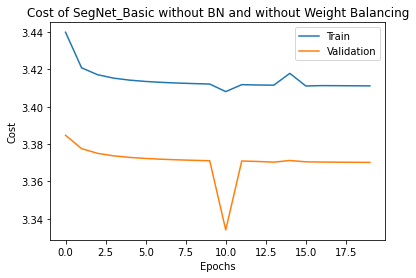

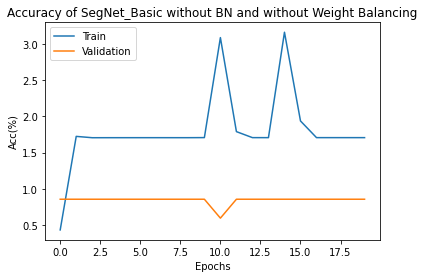

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet_Basic without BN and without Weight Balancing")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet_Basic without BN and without Weight Balancing")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/SegNet_WB.pth'
torch.save(Net.state_dict(), PATH)

#### Test SegNet Basic with weight Balancing










  0%|          | 0/1 [00:00<?, ?it/s]








100%|██████████| 1/1 [00:12<00:00, 12.06s/it]


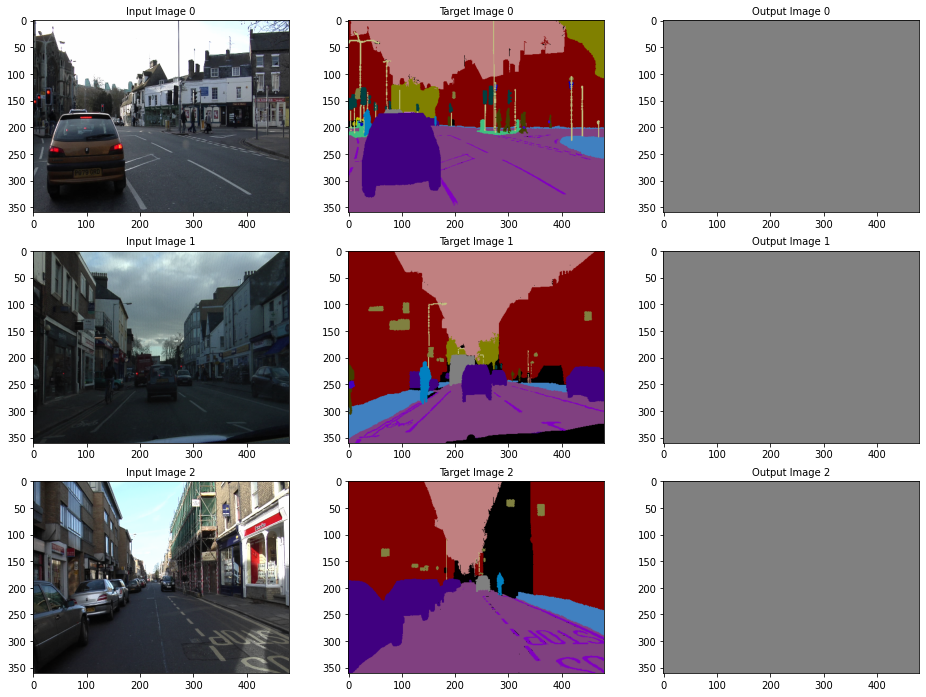

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}
          
PATH = '/content/drive/My Drive/SegNet_WB.pth' 
net = SegNet_Basic()
net.load_state_dict(torch.load(PATH))

test_set = CamVid_Dataset(data_root, partition['test'], **kwargs)
test_generator = torch.utils.data.DataLoader(test_set, **params)

for images, labels in tqdm(test_generator):
    outputs = net(images)
    test_set.test_network(images, outputs, labels)

In [ ]:
df, a , b = test_set.get_FrameData()

In [ ]:
a

{0: [64, 128, 64],
 1: [192, 0, 128],
 2: [0, 128, 192],
 3: [0, 128, 64],
 4: [128, 0, 0],
 5: [64, 0, 128],
 6: [64, 0, 192],
 7: [192, 128, 64],
 8: [192, 192, 128],
 9: [64, 64, 128],
 10: [128, 0, 192],
 11: [192, 0, 64],
 12: [128, 128, 64],
 13: [192, 0, 192],
 14: [128, 64, 64],
 15: [64, 192, 128],
 16: [64, 64, 0],
 17: [128, 64, 128],
 18: [128, 128, 192],
 19: [64, 128, 192],
 20: [0, 0, 192],
 21: [192, 128, 128],
 22: [128, 128, 128],
 23: [0, 0, 64],
 24: [0, 64, 64],
 25: [192, 64, 128],
 26: [128, 128, 0],
 27: [192, 128, 192],
 28: [64, 0, 64],
 29: [192, 192, 0],
 30: [0, 0, 0],
 31: [64, 192, 0]}

## SegNet_Basic Model With BN

In [ ]:
class SegNet_Basic_BN(nn.Module):

    def __init__(self, num_classes = 32):
        super(SegNet_Basic_BN, self).__init__()
        
        self.num_classes = num_classes

        # Encoder :
        # First layer 
        self.conv1 = nn.Conv2d(3, 64, 7 , padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2,return_indices = True)
        # Second layer
        self.conv2 = nn.Conv2d(64, 64, 7 , padding = 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2,return_indices = True)
        # Third layer
        self.conv3 = nn.Conv2d(64, 64, 7 , padding = 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2,return_indices = True)
        # Fourth layer
        self.conv4 = nn.Conv2d(64, 64, 7 , padding = 3)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(2, 2,return_indices = True)

        # Decoder : 
        # First layer 
        self.upsampling4 = nn.MaxUnpool2d(2, 2)
        self.conv4_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
        self.bn4_d = nn.BatchNorm2d(64)
        # Second layer
        self.upsampling3 = nn.MaxUnpool2d(2, 2)
        self.conv3_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
        self.bn3_d = nn.BatchNorm2d(64)
        # Third layer
        self.upsampling2 = nn.MaxUnpool2d(2, 2)
        self.conv2_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
        self.bn2_d = nn.BatchNorm2d(64)
        # Fourth layer
        self.upsampling1 = nn.MaxUnpool2d(2, 2)
        self.conv1_d = nn.Conv2d(64, 64, 7, padding = 3, bias = False)
        self.bn1_d = nn.BatchNorm2d(64)

        # Classifier :
        # Softmax Layer
        self.softmax_layer = nn.Conv2d(64, self.num_classes, 1)

    def forward(self,x):
        # Encoder :
        
        # First layer 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x, indices1 = self.pool1(x)

        # Second layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x, indices2 = self.pool2(x)

        # Third layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x, indices3 = self.pool3(x)
        shape = x.shape

        # Fourth layer
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x, indices4 = self.pool4(x)

        # Decoder:
        
        # First layer
        x = self.upsampling4(x, indices4,shape)
        x = self.conv4_d(x)
        x = self.bn4_d(x)
        # Second layer
        x = self.upsampling3(x, indices3)
        x = self.conv3_d(x)
        x = self.bn3_d(x)
        # Third layer
        x = self.upsampling2(x, indices2)
        x = self.conv2_d(x)
        x = self.bn2_d(x)
        # Fourth layer
        x = self.upsampling1(x, indices1)
        x = self.conv1_d(x)
        x = self.bn1_d(x)
        # Classifier:
        
        # Softmax layer
        x = self.softmax_layer(x)
        
        return x

### Train SegNet_Basic_BN without weight balancing

#### Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 10,
          'shuffle': False,
          'num_workers': 2}

max_epochs = 500

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic_BN()
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.1, momentum = 0.9)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

dataiter = iter(training_generator)
batch_train_data, batch_train_labels = dataiter.next()

dataiter = iter(validation_generator)
batch_data, batch_labels = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training

    # Transfer to GPU
    batch_train_data, batch_train_labels = batch_train_data.to(device), batch_train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(batch_train_data)

    loss = criterion(batch_train_outputs, batch_train_labels.long())
    loss.backward()
    optimizer.step()

    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels)

    if train_cnt % 10 == 9:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1

    

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for batch_data, batch_labels in tqdm(validation_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        val_loss = criterion(batch_outputs, batch_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


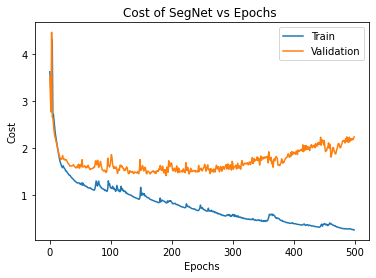

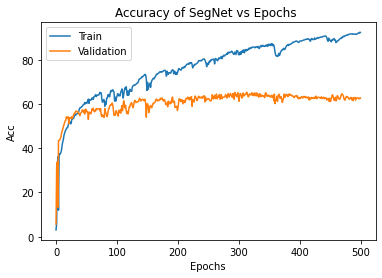

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet vs Epochs ")
    plt.ylabel('Acc')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

#### Training   

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 6,
          'shuffle': False,
          'num_workers': 2}

max_epochs = 10

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic_BN()
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []


# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 20 == 19:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 20))
            running_loss = 0.0
        
        train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)







  0%|          | 0/10 [00:00<?, ?it/s]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:23,  2.84s/it]






  2%|▏         | 2/94 [00:03<03:19,  2.16s/it]






  3%|▎         | 3/94 [00:05<03:07,  2.06s/it]






  4%|▍         | 4/94 [00:05<02:25,  1.62s/it]






  5%|▌         | 5/94 [00:07<02:31,  1.70s/it]






  6%|▋         | 6/94 [00:08<02:00,  1.37s/it]






  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]






  9%|▊         | 8/94 [00:10<01:45,  1.23s/it]






 10%|▉         | 9/94 [00:12<02:02,  1.44s/it]






 11%|█         | 10/94 [00:13<01:39,  1.18s/it]






 12%|█▏        | 11/94 [00:15<01:54,  1.38s/it]






 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]






 14%|█▍        | 13/94 [00:17<01:46,  1.31s/it]






 15%|█▍        | 14/94 [00:17<01:27,  1.09s/it]






 16%|█▌        | 15/94 [00:19<01:42,  1.30s/it]






 17%|█▋        | 16/94 [00:20<01:24,  1.09s/it]






 18%|█▊        | 17/94 [00:22<01:39,  1.29s/it]



Cost of Train data after 20 iterations in epoch 1 : 2.674564









 22%|██▏       | 21/94 [00:27<01:38,  1.35s/it]






 23%|██▎       | 22/94 [00:27<01:21,  1.13s/it]






 24%|██▍       | 23/94 [00:29<01:32,  1.30s/it]






 26%|██▌       | 24/94 [00:29<01:16,  1.09s/it]






 27%|██▋       | 25/94 [00:31<01:30,  1.31s/it]






 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]






 29%|██▊       | 27/94 [00:34<01:26,  1.30s/it]






 30%|██▉       | 28/94 [00:34<01:11,  1.08s/it]






 31%|███       | 29/94 [00:36<01:25,  1.31s/it]






 32%|███▏      | 30/94 [00:37<01:09,  1.09s/it]






 33%|███▎      | 31/94 [00:38<01:20,  1.27s/it]






 34%|███▍      | 32/94 [00:39<01:06,  1.07s/it]






 35%|███▌      | 33/94 [00:41<01:19,  1.30s/it]






 36%|███▌      | 34/94 [00:41<01:04,  1.08s/it]






 37%|███▋      | 35/94 [00:43<01:16,  1.29s/it]






 38%|███▊      | 36/94 [00:44<01:02,  1.08s/it]






 39%|███▉      | 37/94 [00:45<01:11,  1.25s/it]






 40%|████      | 38/94 [00:46<00:58,  1.05s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 1 : 1.544797









 44%|████▎     | 41/94 [00:50<01:07,  1.28s/it]






 45%|████▍     | 42/94 [00:51<00:55,  1.08s/it]






 46%|████▌     | 43/94 [00:52<01:03,  1.25s/it]






 47%|████▋     | 44/94 [00:53<00:52,  1.05s/it]






 48%|████▊     | 45/94 [00:55<01:02,  1.28s/it]






 49%|████▉     | 46/94 [00:55<00:52,  1.09s/it]






 50%|█████     | 47/94 [00:57<00:58,  1.24s/it]






 51%|█████     | 48/94 [00:58<00:49,  1.08s/it]






 52%|█████▏    | 49/94 [00:59<00:55,  1.24s/it]






 53%|█████▎    | 50/94 [01:00<00:48,  1.09s/it]






 54%|█████▍    | 51/94 [01:02<00:53,  1.24s/it]






 55%|█████▌    | 52/94 [01:02<00:46,  1.10s/it]






 56%|█████▋    | 53/94 [01:04<00:52,  1.27s/it]






 57%|█████▋    | 54/94 [01:05<00:43,  1.09s/it]






 59%|█████▊    | 55/94 [01:06<00:47,  1.23s/it]






 60%|█████▉    | 56/94 [01:07<00:42,  1.11s/it]






 61%|██████    | 57/94 [01:09<00:45,  1.24s/it]






 62%|██████▏   | 58/94 [01:10<00:41,  1.14s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 1 : 1.560029









 65%|██████▍   | 61/94 [01:14<00:41,  1.26s/it]






 66%|██████▌   | 62/94 [01:14<00:36,  1.14s/it]






 67%|██████▋   | 63/94 [01:16<00:38,  1.26s/it]






 68%|██████▊   | 64/94 [01:17<00:34,  1.16s/it]






 69%|██████▉   | 65/94 [01:18<00:35,  1.24s/it]






 70%|███████   | 66/94 [01:19<00:33,  1.18s/it]






 71%|███████▏  | 67/94 [01:21<00:33,  1.23s/it]






 72%|███████▏  | 68/94 [01:22<00:30,  1.18s/it]






 73%|███████▎  | 69/94 [01:23<00:30,  1.23s/it]






 74%|███████▍  | 70/94 [01:24<00:28,  1.19s/it]






 76%|███████▌  | 71/94 [01:25<00:27,  1.21s/it]






 77%|███████▋  | 72/94 [01:26<00:24,  1.12s/it]






 78%|███████▊  | 73/94 [01:28<00:25,  1.21s/it]






 79%|███████▊  | 74/94 [01:29<00:22,  1.14s/it]






 80%|███████▉  | 75/94 [01:30<00:23,  1.23s/it]






 81%|████████  | 76/94 [01:31<00:20,  1.13s/it]






 82%|████████▏ | 77/94 [01:33<00:21,  1.25s/it]






 83%|████████▎ | 78/94 [01:33<00:18,  1.14s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 1 : 1.373215









 86%|████████▌ | 81/94 [01:37<00:15,  1.19s/it]






 87%|████████▋ | 82/94 [01:38<00:13,  1.14s/it]






 88%|████████▊ | 83/94 [01:40<00:13,  1.19s/it]






 89%|████████▉ | 84/94 [01:41<00:11,  1.16s/it]






 90%|█████████ | 85/94 [01:42<00:10,  1.18s/it]






 91%|█████████▏| 86/94 [01:43<00:09,  1.21s/it]






 93%|█████████▎| 87/94 [01:44<00:07,  1.12s/it]






 94%|█████████▎| 88/94 [01:45<00:07,  1.23s/it]






 95%|█████████▍| 89/94 [01:46<00:05,  1.12s/it]






 96%|█████████▌| 90/94 [01:48<00:04,  1.24s/it]






 97%|█████████▋| 91/94 [01:49<00:03,  1.13s/it]






 98%|█████████▊| 92/94 [01:50<00:02,  1.26s/it]






 99%|█████████▉| 93/94 [01:51<00:01,  1.13s/it]






100%|██████████| 94/94 [01:53<00:00,  1.20s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:51,  2.33s/it]






  9%|▊         | 2/23 [00:02<00:35,  1.69s/it]






 13%|█▎        | 3/23 [00:04<00:35,  1.77s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 1 : 1.495920









 48%|████▊     | 11/23 [00:12<00:14,  1.22s/it]






 52%|█████▏    | 12/23 [00:12<00:09,  1.11it/s]






 57%|█████▋    | 13/23 [00:14<00:11,  1.19s/it]






 61%|██████    | 14/23 [00:14<00:07,  1.13it/s]






 65%|██████▌   | 15/23 [00:16<00:09,  1.19s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.13it/s]






 74%|███████▍  | 17/23 [00:18<00:06,  1.16s/it]






 78%|███████▊  | 18/23 [00:18<00:04,  1.16it/s]






 83%|████████▎ | 19/23 [00:20<00:04,  1.20s/it]






 87%|████████▋ | 20/23 [00:21<00:02,  1.13it/s]

Cost of Validation data after 20 iterations in epoch 1 : 1.412179









 91%|█████████▏| 21/23 [00:23<00:02,  1.19s/it]






 96%|█████████▌| 22/23 [00:23<00:00,  1.14it/s]






100%|██████████| 23/23 [00:24<00:00,  1.08s/it]






 10%|█         | 1/10 [02:18<20:43, 138.18s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:22,  2.82s/it]






  2%|▏         | 2/94 [00:03<03:17,  2.15s/it]






  3%|▎         | 3/94 [00:04<02:59,  1.97s/it]






  4%|▍         | 4/94 [00:05<02:19,  1.55s/it]






  5%|▌         | 5/94 [00:07<02:24,  1.62s/it]






  6%|▋         | 6/94 [00:07<01:55,  1.31s/it]






  7%|▋         | 7/94 [00:09<02:04,  1.43s/it]






  9%|▊         | 8/94 [00:10<01:41,  1.18s/it]






 10%|▉         | 9/94 [00:11<01:53,  1.33s/it]






 11%|█         | 10/94 [00:12<01:33,  1.11s/it]






 12%|█▏        | 11/94 [00:14<01:46,  1.29s/it]






 13%|█▎        | 12/94 [00:14<01:28,  1.08s/it]






 14%|█▍        | 13/94 [00:16<01:44,  1.30s/it]






 15%|█▍        | 14/94 [00:17<01:26,  1

Cost of Train data after 20 iterations in epoch 2 : 1.367753









 22%|██▏       | 21/94 [00:25<01:27,  1.21s/it]






 23%|██▎       | 22/94 [00:26<01:21,  1.13s/it]






 24%|██▍       | 23/94 [00:28<01:28,  1.25s/it]






 26%|██▌       | 24/94 [00:28<01:17,  1.11s/it]






 27%|██▋       | 25/94 [00:30<01:22,  1.20s/it]






 28%|██▊       | 26/94 [00:31<01:15,  1.11s/it]






 29%|██▊       | 27/94 [00:32<01:22,  1.23s/it]






 30%|██▉       | 28/94 [00:33<01:13,  1.12s/it]






 31%|███       | 29/94 [00:35<01:19,  1.22s/it]






 32%|███▏      | 30/94 [00:36<01:12,  1.13s/it]






 33%|███▎      | 31/94 [00:37<01:16,  1.21s/it]






 34%|███▍      | 32/94 [00:38<01:09,  1.12s/it]






 35%|███▌      | 33/94 [00:39<01:15,  1.24s/it]






 36%|███▌      | 34/94 [00:40<01:05,  1.10s/it]






 37%|███▋      | 35/94 [00:42<01:14,  1.27s/it]






 38%|███▊      | 36/94 [00:42<01:02,  1.08s/it]






 39%|███▉      | 37/94 [00:44<01:12,  1.28s/it]






 40%|████      | 38/94 [00:45<00:59,  1.07s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 2 : 1.256458









 44%|████▎     | 41/94 [00:49<01:07,  1.28s/it]






 45%|████▍     | 42/94 [00:49<00:55,  1.07s/it]






 46%|████▌     | 43/94 [00:51<01:06,  1.30s/it]






 47%|████▋     | 44/94 [00:52<00:54,  1.08s/it]






 48%|████▊     | 45/94 [00:54<01:02,  1.28s/it]






 49%|████▉     | 46/94 [00:54<00:51,  1.07s/it]






 50%|█████     | 47/94 [00:56<01:00,  1.28s/it]






 51%|█████     | 48/94 [00:57<00:49,  1.07s/it]






 52%|█████▏    | 49/94 [00:58<00:56,  1.25s/it]






 53%|█████▎    | 50/94 [00:59<00:46,  1.05s/it]






 54%|█████▍    | 51/94 [01:00<00:53,  1.24s/it]






 55%|█████▌    | 52/94 [01:01<00:43,  1.05s/it]






 56%|█████▋    | 53/94 [01:03<00:51,  1.26s/it]






 57%|█████▋    | 54/94 [01:03<00:42,  1.06s/it]






 59%|█████▊    | 55/94 [01:05<00:49,  1.26s/it]






 60%|█████▉    | 56/94 [01:06<00:40,  1.06s/it]






 61%|██████    | 57/94 [01:08<00:47,  1.30s/it]






 62%|██████▏   | 58/94 [01:08<00:38,  1.08s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 2 : 1.311764









 65%|██████▍   | 61/94 [01:12<00:41,  1.27s/it]






 66%|██████▌   | 62/94 [01:13<00:34,  1.06s/it]






 67%|██████▋   | 63/94 [01:15<00:38,  1.25s/it]






 68%|██████▊   | 64/94 [01:15<00:31,  1.05s/it]






 69%|██████▉   | 65/94 [01:17<00:36,  1.24s/it]






 70%|███████   | 66/94 [01:17<00:29,  1.05s/it]






 71%|███████▏  | 67/94 [01:19<00:33,  1.24s/it]






 72%|███████▏  | 68/94 [01:20<00:27,  1.05s/it]






 73%|███████▎  | 69/94 [01:21<00:31,  1.26s/it]






 74%|███████▍  | 70/94 [01:22<00:25,  1.06s/it]






 76%|███████▌  | 71/94 [01:24<00:30,  1.32s/it]






 77%|███████▋  | 72/94 [01:25<00:24,  1.10s/it]






 78%|███████▊  | 73/94 [01:26<00:27,  1.33s/it]






 79%|███████▊  | 74/94 [01:27<00:22,  1.11s/it]






 80%|███████▉  | 75/94 [01:29<00:24,  1.29s/it]






 81%|████████  | 76/94 [01:29<00:19,  1.08s/it]






 82%|████████▏ | 77/94 [01:31<00:22,  1.31s/it]






 83%|████████▎ | 78/94 [01:32<00:17,  1.09s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 2 : 1.225650









 86%|████████▌ | 81/94 [01:36<00:16,  1.30s/it]






 87%|████████▋ | 82/94 [01:36<00:13,  1.09s/it]






 88%|████████▊ | 83/94 [01:38<00:14,  1.33s/it]






 89%|████████▉ | 84/94 [01:39<00:11,  1.11s/it]






 90%|█████████ | 85/94 [01:41<00:12,  1.34s/it]






 91%|█████████▏| 86/94 [01:41<00:08,  1.12s/it]






 93%|█████████▎| 87/94 [01:43<00:09,  1.33s/it]






 94%|█████████▎| 88/94 [01:44<00:06,  1.11s/it]






 95%|█████████▍| 89/94 [01:46<00:06,  1.33s/it]






 96%|█████████▌| 90/94 [01:46<00:04,  1.11s/it]






 97%|█████████▋| 91/94 [01:48<00:03,  1.32s/it]






 98%|█████████▊| 92/94 [01:49<00:02,  1.10s/it]






 99%|█████████▉| 93/94 [01:50<00:01,  1.10s/it]






100%|██████████| 94/94 [01:50<00:00,  1.18s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:50,  2.32s/it]






  9%|▊         | 2/23 [00:02<00:35,  1.67s/it]






 13%|█▎        | 3/23 [00:04<00:34,  1.73s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 2 : 1.191152









 48%|████▊     | 11/23 [00:12<00:14,  1.25s/it]






 52%|█████▏    | 12/23 [00:12<00:10,  1.09it/s]






 57%|█████▋    | 13/23 [00:14<00:11,  1.20s/it]






 61%|██████    | 14/23 [00:14<00:07,  1.13it/s]






 65%|██████▌   | 15/23 [00:16<00:09,  1.22s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.11it/s]






 74%|███████▍  | 17/23 [00:19<00:07,  1.24s/it]






 78%|███████▊  | 18/23 [00:19<00:04,  1.10it/s]






 83%|████████▎ | 19/23 [00:21<00:04,  1.22s/it]






 87%|████████▋ | 20/23 [00:21<00:02,  1.12it/s]

Cost of Validation data after 20 iterations in epoch 2 : 1.156868









 91%|█████████▏| 21/23 [00:23<00:02,  1.17s/it]






 96%|█████████▌| 22/23 [00:23<00:00,  1.15it/s]






100%|██████████| 23/23 [00:24<00:00,  1.06s/it]






 20%|██        | 2/10 [04:33<18:17, 137.22s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:20,  2.80s/it]






  2%|▏         | 2/94 [00:03<03:16,  2.14s/it]






  3%|▎         | 3/94 [00:05<03:06,  2.05s/it]






  4%|▍         | 4/94 [00:05<02:25,  1.61s/it]






  5%|▌         | 5/94 [00:07<02:28,  1.66s/it]






  6%|▋         | 6/94 [00:08<01:58,  1.34s/it]






  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]






  9%|▊         | 8/94 [00:10<01:46,  1.24s/it]






 10%|▉         | 9/94 [00:12<02:01,  1.43s/it]






 11%|█         | 10/94 [00:13<01:38,  1.18s/it]






 12%|█▏        | 11/94 [00:14<01:50,  1.33s/it]






 13%|█▎        | 12/94 [00:15<01:31,  1.11s/it]






 14%|█▍        | 13/94 [00:17<01:45,  1.30s/it]






 15%|█▍        | 14/94 [00:17<01:27,  1

Cost of Train data after 20 iterations in epoch 3 : 1.225245









 22%|██▏       | 21/94 [00:26<01:35,  1.30s/it]






 23%|██▎       | 22/94 [00:27<01:18,  1.09s/it]






 24%|██▍       | 23/94 [00:28<01:29,  1.26s/it]






 26%|██▌       | 24/94 [00:29<01:14,  1.06s/it]






 27%|██▋       | 25/94 [00:31<01:25,  1.24s/it]






 28%|██▊       | 26/94 [00:31<01:12,  1.06s/it]






 29%|██▊       | 27/94 [00:33<01:24,  1.27s/it]






 30%|██▉       | 28/94 [00:34<01:12,  1.09s/it]






 31%|███       | 29/94 [00:35<01:21,  1.26s/it]






 32%|███▏      | 30/94 [00:36<01:12,  1.13s/it]






 33%|███▎      | 31/94 [00:38<01:19,  1.27s/it]






 34%|███▍      | 32/94 [00:38<01:07,  1.08s/it]






 35%|███▌      | 33/94 [00:40<01:16,  1.25s/it]






 36%|███▌      | 34/94 [00:41<01:05,  1.10s/it]






 37%|███▋      | 35/94 [00:42<01:12,  1.23s/it]






 38%|███▊      | 36/94 [00:43<01:04,  1.12s/it]






 39%|███▉      | 37/94 [00:44<01:08,  1.20s/it]






 40%|████      | 38/94 [00:45<01:03,  1.13s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 3 : 1.113152









 44%|████▎     | 41/94 [00:49<01:03,  1.19s/it]






 45%|████▍     | 42/94 [00:50<01:02,  1.19s/it]






 46%|████▌     | 43/94 [00:52<01:00,  1.19s/it]






 47%|████▋     | 44/94 [00:53<00:56,  1.14s/it]






 48%|████▊     | 45/94 [00:54<01:00,  1.23s/it]






 49%|████▉     | 46/94 [00:55<00:54,  1.13s/it]






 50%|█████     | 47/94 [00:56<00:59,  1.27s/it]






 51%|█████     | 48/94 [00:57<00:52,  1.13s/it]






 52%|█████▏    | 49/94 [00:59<00:56,  1.25s/it]






 53%|█████▎    | 50/94 [01:00<00:48,  1.11s/it]






 54%|█████▍    | 51/94 [01:01<00:53,  1.23s/it]






 55%|█████▌    | 52/94 [01:02<00:47,  1.13s/it]






 56%|█████▋    | 53/94 [01:04<00:51,  1.25s/it]






 57%|█████▋    | 54/94 [01:04<00:43,  1.09s/it]






 59%|█████▊    | 55/94 [01:06<00:50,  1.31s/it]






 60%|█████▉    | 56/94 [01:07<00:41,  1.10s/it]






 61%|██████    | 57/94 [01:08<00:46,  1.27s/it]






 62%|██████▏   | 58/94 [01:09<00:39,  1.10s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 3 : 1.163199









 65%|██████▍   | 61/94 [01:13<00:40,  1.23s/it]






 66%|██████▌   | 62/94 [01:14<00:36,  1.15s/it]






 67%|██████▋   | 63/94 [01:15<00:38,  1.24s/it]






 68%|██████▊   | 64/94 [01:16<00:33,  1.12s/it]






 69%|██████▉   | 65/94 [01:18<00:36,  1.27s/it]






 70%|███████   | 66/94 [01:19<00:31,  1.12s/it]






 71%|███████▏  | 67/94 [01:20<00:34,  1.29s/it]






 72%|███████▏  | 68/94 [01:21<00:28,  1.10s/it]






 73%|███████▎  | 69/94 [01:23<00:32,  1.28s/it]






 74%|███████▍  | 70/94 [01:23<00:25,  1.08s/it]






 76%|███████▌  | 71/94 [01:25<00:29,  1.30s/it]






 77%|███████▋  | 72/94 [01:26<00:23,  1.09s/it]






 78%|███████▊  | 73/94 [01:28<00:27,  1.31s/it]






 79%|███████▊  | 74/94 [01:28<00:21,  1.09s/it]






 80%|███████▉  | 75/94 [01:30<00:24,  1.29s/it]






 81%|████████  | 76/94 [01:30<00:19,  1.08s/it]






 82%|████████▏ | 77/94 [01:32<00:22,  1.29s/it]






 83%|████████▎ | 78/94 [01:33<00:17,  1.08s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 3 : 1.129146









 86%|████████▌ | 81/94 [01:37<00:16,  1.30s/it]






 87%|████████▋ | 82/94 [01:38<00:13,  1.09s/it]






 88%|████████▊ | 83/94 [01:40<00:14,  1.33s/it]






 89%|████████▉ | 84/94 [01:40<00:11,  1.10s/it]






 90%|█████████ | 85/94 [01:42<00:11,  1.31s/it]






 91%|█████████▏| 86/94 [01:42<00:08,  1.09s/it]






 93%|█████████▎| 87/94 [01:44<00:09,  1.30s/it]






 94%|█████████▎| 88/94 [01:45<00:06,  1.09s/it]






 95%|█████████▍| 89/94 [01:47<00:06,  1.33s/it]






 96%|█████████▌| 90/94 [01:47<00:04,  1.10s/it]






 97%|█████████▋| 91/94 [01:49<00:03,  1.31s/it]






 98%|█████████▊| 92/94 [01:50<00:02,  1.09s/it]






 99%|█████████▉| 93/94 [01:51<00:01,  1.11s/it]






100%|██████████| 94/94 [01:51<00:00,  1.19s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:51,  2.36s/it]






  9%|▊         | 2/23 [00:02<00:35,  1.70s/it]






 13%|█▎        | 3/23 [00:04<00:35,  1.75s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 3 : 1.102312









 48%|████▊     | 11/23 [00:12<00:14,  1.24s/it]






 52%|█████▏    | 12/23 [00:12<00:10,  1.09it/s]






 57%|█████▋    | 13/23 [00:14<00:12,  1.21s/it]






 61%|██████    | 14/23 [00:15<00:08,  1.12it/s]






 65%|██████▌   | 15/23 [00:17<00:09,  1.25s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.09it/s]






 74%|███████▍  | 17/23 [00:19<00:07,  1.24s/it]






 78%|███████▊  | 18/23 [00:19<00:04,  1.10it/s]






 83%|████████▎ | 19/23 [00:21<00:04,  1.21s/it]






 87%|████████▋ | 20/23 [00:21<00:02,  1.11it/s]

Cost of Validation data after 20 iterations in epoch 3 : 1.070456









 91%|█████████▏| 21/23 [00:23<00:02,  1.21s/it]






 96%|█████████▌| 22/23 [00:23<00:00,  1.12it/s]






100%|██████████| 23/23 [00:24<00:00,  1.07s/it]






 30%|███       | 3/10 [06:49<15:58, 136.94s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:19,  2.79s/it]






  2%|▏         | 2/94 [00:03<03:15,  2.13s/it]






  3%|▎         | 3/94 [00:05<03:05,  2.03s/it]






  4%|▍         | 4/94 [00:05<02:23,  1.60s/it]






  5%|▌         | 5/94 [00:07<02:28,  1.67s/it]






  6%|▋         | 6/94 [00:08<01:58,  1.35s/it]






  7%|▋         | 7/94 [00:10<02:09,  1.49s/it]






  9%|▊         | 8/94 [00:10<01:45,  1.22s/it]






 10%|▉         | 9/94 [00:12<02:00,  1.42s/it]






 11%|█         | 10/94 [00:13<01:38,  1.17s/it]






 12%|█▏        | 11/94 [00:14<01:51,  1.35s/it]






 13%|█▎        | 12/94 [00:15<01:31,  1.12s/it]






 14%|█▍        | 13/94 [00:17<01:46,  1.31s/it]






 15%|█▍        | 14/94 [00:17<01:28,  1

Cost of Train data after 20 iterations in epoch 4 : 1.145327









 22%|██▏       | 21/94 [00:26<01:37,  1.33s/it]






 23%|██▎       | 22/94 [00:27<01:19,  1.11s/it]






 24%|██▍       | 23/94 [00:29<01:31,  1.30s/it]






 26%|██▌       | 24/94 [00:29<01:15,  1.08s/it]






 27%|██▋       | 25/94 [00:31<01:31,  1.33s/it]






 28%|██▊       | 26/94 [00:32<01:15,  1.11s/it]






 29%|██▊       | 27/94 [00:34<01:26,  1.29s/it]






 30%|██▉       | 28/94 [00:34<01:11,  1.08s/it]






 31%|███       | 29/94 [00:36<01:23,  1.29s/it]






 32%|███▏      | 30/94 [00:37<01:09,  1.08s/it]






 33%|███▎      | 31/94 [00:38<01:20,  1.27s/it]






 34%|███▍      | 32/94 [00:39<01:06,  1.07s/it]






 35%|███▌      | 33/94 [00:41<01:17,  1.27s/it]






 36%|███▌      | 34/94 [00:41<01:03,  1.06s/it]






 37%|███▋      | 35/94 [00:43<01:16,  1.29s/it]






 38%|███▊      | 36/94 [00:44<01:02,  1.08s/it]






 39%|███▉      | 37/94 [00:45<01:13,  1.30s/it]






 40%|████      | 38/94 [00:46<01:00,  1.08s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 4 : 1.037884









 44%|████▎     | 41/94 [00:50<01:06,  1.26s/it]






 45%|████▍     | 42/94 [00:51<00:55,  1.06s/it]






 46%|████▌     | 43/94 [00:52<01:03,  1.24s/it]






 47%|████▋     | 44/94 [00:53<00:52,  1.04s/it]






 48%|████▊     | 45/94 [00:55<01:02,  1.27s/it]






 49%|████▉     | 46/94 [00:55<00:51,  1.07s/it]






 50%|█████     | 47/94 [00:57<01:00,  1.29s/it]






 51%|█████     | 48/94 [00:58<00:49,  1.09s/it]






 52%|█████▏    | 49/94 [00:59<00:57,  1.28s/it]






 53%|█████▎    | 50/94 [01:00<00:47,  1.07s/it]






 54%|█████▍    | 51/94 [01:02<00:56,  1.32s/it]






 55%|█████▌    | 52/94 [01:02<00:46,  1.10s/it]






 56%|█████▋    | 53/94 [01:04<00:54,  1.33s/it]






 57%|█████▋    | 54/94 [01:05<00:44,  1.11s/it]






 59%|█████▊    | 55/94 [01:07<00:51,  1.31s/it]






 60%|█████▉    | 56/94 [01:07<00:41,  1.09s/it]






 61%|██████    | 57/94 [01:09<00:49,  1.33s/it]






 62%|██████▏   | 58/94 [01:10<00:39,  1.11s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 4 : 1.081009









 65%|██████▍   | 61/94 [01:14<00:42,  1.29s/it]






 66%|██████▌   | 62/94 [01:14<00:34,  1.08s/it]






 67%|██████▋   | 63/94 [01:16<00:40,  1.30s/it]






 68%|██████▊   | 64/94 [01:17<00:32,  1.09s/it]






 69%|██████▉   | 65/94 [01:19<00:36,  1.27s/it]






 70%|███████   | 66/94 [01:19<00:29,  1.07s/it]






 71%|███████▏  | 67/94 [01:21<00:35,  1.31s/it]






 72%|███████▏  | 68/94 [01:22<00:28,  1.09s/it]






 73%|███████▎  | 69/94 [01:23<00:31,  1.27s/it]






 74%|███████▍  | 70/94 [01:24<00:25,  1.07s/it]






 76%|███████▌  | 71/94 [01:26<00:29,  1.28s/it]






 77%|███████▋  | 72/94 [01:26<00:23,  1.07s/it]






 78%|███████▊  | 73/94 [01:28<00:26,  1.28s/it]






 79%|███████▊  | 74/94 [01:29<00:21,  1.08s/it]






 80%|███████▉  | 75/94 [01:30<00:24,  1.30s/it]






 81%|████████  | 76/94 [01:31<00:19,  1.09s/it]






 82%|████████▏ | 77/94 [01:33<00:22,  1.30s/it]






 83%|████████▎ | 78/94 [01:33<00:17,  1.08s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 4 : 1.007901









 86%|████████▌ | 81/94 [01:37<00:16,  1.27s/it]






 87%|████████▋ | 82/94 [01:38<00:12,  1.06s/it]






 88%|████████▊ | 83/94 [01:40<00:13,  1.24s/it]






 89%|████████▉ | 84/94 [01:40<00:10,  1.05s/it]






 90%|█████████ | 85/94 [01:42<00:11,  1.28s/it]






 91%|█████████▏| 86/94 [01:43<00:08,  1.07s/it]






 93%|█████████▎| 87/94 [01:45<00:09,  1.30s/it]






 94%|█████████▎| 88/94 [01:45<00:06,  1.09s/it]






 95%|█████████▍| 89/94 [01:47<00:06,  1.29s/it]






 96%|█████████▌| 90/94 [01:47<00:04,  1.08s/it]






 97%|█████████▋| 91/94 [01:49<00:03,  1.30s/it]






 98%|█████████▊| 92/94 [01:50<00:02,  1.09s/it]






 99%|█████████▉| 93/94 [01:51<00:01,  1.16s/it]






100%|██████████| 94/94 [01:51<00:00,  1.19s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:51,  2.35s/it]






  9%|▊         | 2/23 [00:02<00:35,  1.69s/it]






 13%|█▎        | 3/23 [00:04<00:35,  1.76s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 4 : 1.024445









 48%|████▊     | 11/23 [00:13<00:15,  1.28s/it]






 52%|█████▏    | 12/23 [00:13<00:10,  1.06it/s]






 57%|█████▋    | 13/23 [00:15<00:12,  1.23s/it]






 61%|██████    | 14/23 [00:15<00:08,  1.10it/s]






 65%|██████▌   | 15/23 [00:17<00:10,  1.25s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]






 74%|███████▍  | 17/23 [00:19<00:07,  1.22s/it]






 78%|███████▊  | 18/23 [00:19<00:04,  1.11it/s]






 83%|████████▎ | 19/23 [00:21<00:04,  1.22s/it]






 87%|████████▋ | 20/23 [00:21<00:02,  1.11it/s]

Cost of Validation data after 20 iterations in epoch 4 : 0.998837









 91%|█████████▏| 21/23 [00:23<00:02,  1.15s/it]






 96%|█████████▌| 22/23 [00:23<00:00,  1.18it/s]






100%|██████████| 23/23 [00:24<00:00,  1.07s/it]






 40%|████      | 4/10 [09:06<13:41, 136.84s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:17,  2.77s/it]






  2%|▏         | 2/94 [00:03<03:14,  2.11s/it]






  3%|▎         | 3/94 [00:05<03:02,  2.01s/it]






  4%|▍         | 4/94 [00:05<02:22,  1.58s/it]






  5%|▌         | 5/94 [00:07<02:25,  1.64s/it]






  6%|▋         | 6/94 [00:08<01:56,  1.33s/it]






  7%|▋         | 7/94 [00:09<02:09,  1.49s/it]






  9%|▊         | 8/94 [00:10<01:45,  1.23s/it]






 10%|▉         | 9/94 [00:12<01:58,  1.39s/it]






 11%|█         | 10/94 [00:12<01:36,  1.15s/it]






 12%|█▏        | 11/94 [00:14<01:48,  1.30s/it]






 13%|█▎        | 12/94 [00:15<01:29,  1.09s/it]






 14%|█▍        | 13/94 [00:16<01:43,  1.27s/it]






 15%|█▍        | 14/94 [00:17<01:25,  1

Cost of Train data after 20 iterations in epoch 5 : 1.039524









 22%|██▏       | 21/94 [00:26<01:38,  1.35s/it]






 23%|██▎       | 22/94 [00:27<01:20,  1.12s/it]






 24%|██▍       | 23/94 [00:29<01:33,  1.31s/it]






 26%|██▌       | 24/94 [00:29<01:16,  1.09s/it]






 27%|██▋       | 25/94 [00:31<01:29,  1.29s/it]






 28%|██▊       | 26/94 [00:32<01:13,  1.08s/it]






 29%|██▊       | 27/94 [00:33<01:25,  1.28s/it]






 30%|██▉       | 28/94 [00:34<01:10,  1.08s/it]






 31%|███       | 29/94 [00:36<01:24,  1.31s/it]






 32%|███▏      | 30/94 [00:36<01:10,  1.09s/it]






 33%|███▎      | 31/94 [00:38<01:21,  1.30s/it]






 34%|███▍      | 32/94 [00:39<01:07,  1.10s/it]






 35%|███▌      | 33/94 [00:41<01:19,  1.30s/it]






 36%|███▌      | 34/94 [00:41<01:05,  1.08s/it]






 37%|███▋      | 35/94 [00:43<01:19,  1.35s/it]






 38%|███▊      | 36/94 [00:44<01:05,  1.12s/it]






 39%|███▉      | 37/94 [00:45<01:13,  1.29s/it]






 40%|████      | 38/94 [00:46<01:00,  1.08s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 5 : 0.952907









 44%|████▎     | 41/94 [00:50<01:09,  1.31s/it]






 45%|████▍     | 42/94 [00:51<00:57,  1.10s/it]






 46%|████▌     | 43/94 [00:53<01:06,  1.30s/it]






 47%|████▋     | 44/94 [00:53<00:54,  1.09s/it]






 48%|████▊     | 45/94 [00:55<01:03,  1.29s/it]






 49%|████▉     | 46/94 [00:56<00:51,  1.08s/it]






 50%|█████     | 47/94 [00:57<01:02,  1.32s/it]






 51%|█████     | 48/94 [00:58<00:50,  1.10s/it]






 52%|█████▏    | 49/94 [01:00<00:59,  1.31s/it]






 53%|█████▎    | 50/94 [01:00<00:48,  1.10s/it]






 54%|█████▍    | 51/94 [01:02<00:57,  1.34s/it]






 55%|█████▌    | 52/94 [01:03<00:46,  1.11s/it]






 56%|█████▋    | 53/94 [01:05<00:54,  1.33s/it]






 57%|█████▋    | 54/94 [01:05<00:44,  1.10s/it]






 59%|█████▊    | 55/94 [01:07<00:51,  1.31s/it]






 60%|█████▉    | 56/94 [01:08<00:41,  1.09s/it]






 61%|██████    | 57/94 [01:10<00:50,  1.36s/it]






 62%|██████▏   | 58/94 [01:10<00:40,  1.13s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 5 : 0.973472









 65%|██████▍   | 61/94 [01:14<00:43,  1.31s/it]






 66%|██████▌   | 62/94 [01:15<00:35,  1.09s/it]






 67%|██████▋   | 63/94 [01:17<00:41,  1.33s/it]






 68%|██████▊   | 64/94 [01:17<00:33,  1.11s/it]






 69%|██████▉   | 65/94 [01:19<00:38,  1.34s/it]






 70%|███████   | 66/94 [01:20<00:31,  1.12s/it]






 71%|███████▏  | 67/94 [01:22<00:35,  1.32s/it]






 72%|███████▏  | 68/94 [01:22<00:28,  1.10s/it]






 73%|███████▎  | 69/94 [01:24<00:32,  1.32s/it]






 74%|███████▍  | 70/94 [01:25<00:26,  1.10s/it]






 76%|███████▌  | 71/94 [01:27<00:30,  1.31s/it]






 77%|███████▋  | 72/94 [01:27<00:24,  1.09s/it]






 78%|███████▊  | 73/94 [01:29<00:27,  1.33s/it]






 79%|███████▊  | 74/94 [01:30<00:22,  1.11s/it]






 80%|███████▉  | 75/94 [01:31<00:25,  1.33s/it]






 81%|████████  | 76/94 [01:32<00:19,  1.11s/it]






 82%|████████▏ | 77/94 [01:34<00:22,  1.32s/it]






 83%|████████▎ | 78/94 [01:34<00:17,  1.10s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 5 : 0.934097









 86%|████████▌ | 81/94 [01:39<00:16,  1.30s/it]






 87%|████████▋ | 82/94 [01:39<00:13,  1.09s/it]






 88%|████████▊ | 83/94 [01:41<00:14,  1.31s/it]






 89%|████████▉ | 84/94 [01:42<00:10,  1.09s/it]






 90%|█████████ | 85/94 [01:43<00:11,  1.26s/it]






 91%|█████████▏| 86/94 [01:44<00:08,  1.06s/it]






 93%|█████████▎| 87/94 [01:46<00:08,  1.26s/it]






 94%|█████████▎| 88/94 [01:46<00:06,  1.06s/it]






 95%|█████████▍| 89/94 [01:48<00:06,  1.27s/it]






 96%|█████████▌| 90/94 [01:48<00:04,  1.07s/it]






 97%|█████████▋| 91/94 [01:50<00:03,  1.29s/it]






 98%|█████████▊| 92/94 [01:51<00:02,  1.08s/it]






 99%|█████████▉| 93/94 [01:52<00:01,  1.16s/it]






100%|██████████| 94/94 [01:53<00:00,  1.20s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:52,  2.36s/it]






  9%|▊         | 2/23 [00:02<00:35,  1.70s/it]






 13%|█▎        | 3/23 [00:04<00:35,  1.79s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 5 : 0.941499









 48%|████▊     | 11/23 [00:13<00:14,  1.24s/it]






 52%|█████▏    | 12/23 [00:13<00:10,  1.09it/s]






 57%|█████▋    | 13/23 [00:15<00:12,  1.27s/it]






 61%|██████    | 14/23 [00:15<00:08,  1.07it/s]






 65%|██████▌   | 15/23 [00:17<00:10,  1.26s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]






 74%|███████▍  | 17/23 [00:19<00:07,  1.22s/it]






 78%|███████▊  | 18/23 [00:19<00:04,  1.11it/s]






 83%|████████▎ | 19/23 [00:21<00:04,  1.20s/it]






 87%|████████▋ | 20/23 [00:21<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 5 : 0.922998









 91%|█████████▏| 21/23 [00:23<00:02,  1.19s/it]






 96%|█████████▌| 22/23 [00:23<00:00,  1.10it/s]






100%|██████████| 23/23 [00:24<00:00,  1.08s/it]






 50%|█████     | 5/10 [11:24<11:25, 137.18s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:27,  2.88s/it]






  2%|▏         | 2/94 [00:03<03:21,  2.19s/it]






  3%|▎         | 3/94 [00:05<03:06,  2.05s/it]






  4%|▍         | 4/94 [00:05<02:25,  1.61s/it]






  5%|▌         | 5/94 [00:07<02:26,  1.65s/it]






  6%|▋         | 6/94 [00:08<01:57,  1.33s/it]






  7%|▋         | 7/94 [00:09<02:08,  1.47s/it]






  9%|▊         | 8/94 [00:10<01:43,  1.21s/it]






 10%|▉         | 9/94 [00:12<01:56,  1.37s/it]






 11%|█         | 10/94 [00:12<01:35,  1.14s/it]






 12%|█▏        | 11/94 [00:14<01:52,  1.36s/it]






 13%|█▎        | 12/94 [00:15<01:32,  1.13s/it]






 14%|█▍        | 13/94 [00:17<01:46,  1.32s/it]






 15%|█▍        | 14/94 [00:17<01:28,  1

Cost of Train data after 20 iterations in epoch 6 : 0.958543









 22%|██▏       | 21/94 [00:26<01:37,  1.34s/it]






 23%|██▎       | 22/94 [00:27<01:20,  1.12s/it]






 24%|██▍       | 23/94 [00:29<01:34,  1.33s/it]






 26%|██▌       | 24/94 [00:29<01:17,  1.11s/it]






 27%|██▋       | 25/94 [00:31<01:31,  1.32s/it]






 28%|██▊       | 26/94 [00:32<01:15,  1.11s/it]






 29%|██▊       | 27/94 [00:33<01:27,  1.30s/it]






 30%|██▉       | 28/94 [00:34<01:11,  1.09s/it]






 31%|███       | 29/94 [00:36<01:26,  1.34s/it]






 32%|███▏      | 30/94 [00:37<01:11,  1.12s/it]






 33%|███▎      | 31/94 [00:38<01:23,  1.33s/it]






 34%|███▍      | 32/94 [00:39<01:08,  1.11s/it]






 35%|███▌      | 33/94 [00:41<01:20,  1.33s/it]






 36%|███▌      | 34/94 [00:41<01:06,  1.11s/it]






 37%|███▋      | 35/94 [00:43<01:17,  1.32s/it]






 38%|███▊      | 36/94 [00:44<01:03,  1.10s/it]






 39%|███▉      | 37/94 [00:45<01:11,  1.26s/it]






 40%|████      | 38/94 [00:46<00:59,  1.06s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 6 : 0.868552









 44%|████▎     | 41/94 [00:50<01:07,  1.28s/it]






 45%|████▍     | 42/94 [00:51<00:56,  1.08s/it]






 46%|████▌     | 43/94 [00:53<01:05,  1.29s/it]






 47%|████▋     | 44/94 [00:53<00:54,  1.10s/it]






 48%|████▊     | 45/94 [00:55<01:04,  1.32s/it]






 49%|████▉     | 46/94 [00:56<00:52,  1.10s/it]






 50%|█████     | 47/94 [00:58<01:02,  1.32s/it]






 51%|█████     | 48/94 [00:58<00:50,  1.10s/it]






 52%|█████▏    | 49/94 [01:00<00:58,  1.30s/it]






 53%|█████▎    | 50/94 [01:00<00:47,  1.09s/it]






 54%|█████▍    | 51/94 [01:02<00:57,  1.35s/it]






 55%|█████▌    | 52/94 [01:03<00:47,  1.12s/it]






 56%|█████▋    | 53/94 [01:05<00:53,  1.30s/it]






 57%|█████▋    | 54/94 [01:05<00:43,  1.09s/it]






 59%|█████▊    | 55/94 [01:07<00:49,  1.28s/it]






 60%|█████▉    | 56/94 [01:08<00:40,  1.07s/it]






 61%|██████    | 57/94 [01:09<00:47,  1.28s/it]






 62%|██████▏   | 58/94 [01:10<00:38,  1.07s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 6 : 0.926863









 65%|██████▍   | 61/94 [01:14<00:42,  1.30s/it]






 66%|██████▌   | 62/94 [01:15<00:34,  1.09s/it]






 67%|██████▋   | 63/94 [01:17<00:39,  1.28s/it]






 68%|██████▊   | 64/94 [01:17<00:32,  1.08s/it]






 69%|██████▉   | 65/94 [01:19<00:37,  1.28s/it]






 70%|███████   | 66/94 [01:20<00:31,  1.13s/it]






 71%|███████▏  | 67/94 [01:21<00:34,  1.27s/it]






 72%|███████▏  | 68/94 [01:22<00:29,  1.12s/it]






 73%|███████▎  | 69/94 [01:24<00:32,  1.29s/it]






 74%|███████▍  | 70/94 [01:25<00:27,  1.14s/it]






 76%|███████▌  | 71/94 [01:26<00:29,  1.30s/it]






 77%|███████▋  | 72/94 [01:27<00:25,  1.15s/it]






 78%|███████▊  | 73/94 [01:28<00:26,  1.24s/it]






 79%|███████▊  | 74/94 [01:30<00:23,  1.20s/it]






 80%|███████▉  | 75/94 [01:31<00:23,  1.23s/it]






 81%|████████  | 76/94 [01:32<00:21,  1.18s/it]






 82%|████████▏ | 77/94 [01:33<00:21,  1.25s/it]






 83%|████████▎ | 78/94 [01:34<00:18,  1.18s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 6 : 0.873938









 86%|████████▌ | 81/94 [01:38<00:15,  1.19s/it]






 87%|████████▋ | 82/94 [01:39<00:14,  1.22s/it]






 88%|████████▊ | 83/94 [01:41<00:13,  1.23s/it]






 89%|████████▉ | 84/94 [01:42<00:12,  1.24s/it]






 90%|█████████ | 85/94 [01:43<00:10,  1.18s/it]






 91%|█████████▏| 86/94 [01:44<00:09,  1.24s/it]






 93%|█████████▎| 87/94 [01:45<00:08,  1.19s/it]






 94%|█████████▎| 88/94 [01:47<00:07,  1.23s/it]






 95%|█████████▍| 89/94 [01:48<00:06,  1.20s/it]






 96%|█████████▌| 90/94 [01:49<00:04,  1.22s/it]






 97%|█████████▋| 91/94 [01:50<00:03,  1.20s/it]






 98%|█████████▊| 92/94 [01:52<00:02,  1.22s/it]






 99%|█████████▉| 93/94 [01:52<00:01,  1.15s/it]






100%|██████████| 94/94 [01:53<00:00,  1.21s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:52,  2.39s/it]






  9%|▊         | 2/23 [00:02<00:36,  1.73s/it]






 13%|█▎        | 3/23 [00:04<00:36,  1.82s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 6 : 0.889244









 48%|████▊     | 11/23 [00:13<00:14,  1.23s/it]






 52%|█████▏    | 12/23 [00:13<00:10,  1.06it/s]






 57%|█████▋    | 13/23 [00:15<00:12,  1.26s/it]






 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]






 65%|██████▌   | 15/23 [00:17<00:10,  1.27s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.07it/s]






 74%|███████▍  | 17/23 [00:19<00:07,  1.23s/it]






 78%|███████▊  | 18/23 [00:19<00:04,  1.11it/s]






 83%|████████▎ | 19/23 [00:21<00:05,  1.26s/it]






 87%|████████▋ | 20/23 [00:22<00:02,  1.07it/s]

Cost of Validation data after 20 iterations in epoch 6 : 0.868749









 91%|█████████▏| 21/23 [00:24<00:02,  1.25s/it]






 96%|█████████▌| 22/23 [00:24<00:00,  1.09it/s]






100%|██████████| 23/23 [00:25<00:00,  1.10s/it]






 60%|██████    | 6/10 [13:42<09:10, 137.59s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:26,  2.86s/it]






  2%|▏         | 2/94 [00:03<03:20,  2.18s/it]






  3%|▎         | 3/94 [00:05<03:06,  2.04s/it]






  4%|▍         | 4/94 [00:05<02:24,  1.61s/it]






  5%|▌         | 5/94 [00:07<02:29,  1.68s/it]






  6%|▋         | 6/94 [00:08<01:59,  1.36s/it]






  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]






  9%|▊         | 8/94 [00:10<01:45,  1.23s/it]






 10%|▉         | 9/94 [00:12<02:00,  1.41s/it]






 11%|█         | 10/94 [00:13<01:38,  1.17s/it]






 12%|█▏        | 11/94 [00:14<01:53,  1.37s/it]






 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]






 14%|█▍        | 13/94 [00:17<01:49,  1.35s/it]






 15%|█▍        | 14/94 [00:17<01:30,  1

Cost of Train data after 20 iterations in epoch 7 : 0.917719









 22%|██▏       | 21/94 [00:27<01:36,  1.32s/it]






 23%|██▎       | 22/94 [00:27<01:20,  1.11s/it]






 24%|██▍       | 23/94 [00:29<01:33,  1.31s/it]






 26%|██▌       | 24/94 [00:30<01:16,  1.10s/it]






 27%|██▋       | 25/94 [00:31<01:30,  1.31s/it]






 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]






 29%|██▊       | 27/94 [00:34<01:26,  1.29s/it]






 30%|██▉       | 28/94 [00:34<01:11,  1.09s/it]






 31%|███       | 29/94 [00:36<01:25,  1.32s/it]






 32%|███▏      | 30/94 [00:37<01:10,  1.10s/it]






 33%|███▎      | 31/94 [00:39<01:24,  1.34s/it]






 34%|███▍      | 32/94 [00:39<01:09,  1.12s/it]






 35%|███▌      | 33/94 [00:41<01:23,  1.37s/it]






 36%|███▌      | 34/94 [00:42<01:08,  1.14s/it]






 37%|███▋      | 35/94 [00:44<01:22,  1.39s/it]






 38%|███▊      | 36/94 [00:44<01:07,  1.16s/it]






 39%|███▉      | 37/94 [00:46<01:19,  1.40s/it]






 40%|████      | 38/94 [00:47<01:04,  1.16s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 7 : 0.833457









 44%|████▎     | 41/94 [00:51<01:11,  1.35s/it]






 45%|████▍     | 42/94 [00:52<00:58,  1.12s/it]






 46%|████▌     | 43/94 [00:54<01:08,  1.34s/it]






 47%|████▋     | 44/94 [00:54<00:55,  1.12s/it]






 48%|████▊     | 45/94 [00:56<01:06,  1.35s/it]






 49%|████▉     | 46/94 [00:57<00:53,  1.12s/it]






 50%|█████     | 47/94 [00:59<01:02,  1.34s/it]






 51%|█████     | 48/94 [00:59<00:51,  1.12s/it]






 52%|█████▏    | 49/94 [01:01<01:00,  1.35s/it]






 53%|█████▎    | 50/94 [01:02<00:49,  1.12s/it]






 54%|█████▍    | 51/94 [01:03<00:54,  1.28s/it]






 55%|█████▌    | 52/94 [01:04<00:45,  1.07s/it]






 56%|█████▋    | 53/94 [01:06<00:54,  1.32s/it]






 57%|█████▋    | 54/94 [01:06<00:44,  1.10s/it]






 59%|█████▊    | 55/94 [01:08<00:53,  1.37s/it]






 60%|█████▉    | 56/94 [01:09<00:43,  1.13s/it]






 61%|██████    | 57/94 [01:11<00:49,  1.32s/it]






 62%|██████▏   | 58/94 [01:11<00:39,  1.10s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 7 : 0.880790









 65%|██████▍   | 61/94 [01:16<00:44,  1.36s/it]






 66%|██████▌   | 62/94 [01:16<00:36,  1.13s/it]






 67%|██████▋   | 63/94 [01:18<00:41,  1.34s/it]






 68%|██████▊   | 64/94 [01:19<00:33,  1.12s/it]






 69%|██████▉   | 65/94 [01:20<00:37,  1.29s/it]






 70%|███████   | 66/94 [01:21<00:30,  1.08s/it]






 71%|███████▏  | 67/94 [01:23<00:34,  1.29s/it]






 72%|███████▏  | 68/94 [01:23<00:27,  1.08s/it]






 73%|███████▎  | 69/94 [01:25<00:33,  1.33s/it]






 74%|███████▍  | 70/94 [01:26<00:26,  1.10s/it]






 76%|███████▌  | 71/94 [01:28<00:30,  1.31s/it]






 77%|███████▋  | 72/94 [01:28<00:24,  1.10s/it]






 78%|███████▊  | 73/94 [01:30<00:28,  1.35s/it]






 79%|███████▊  | 74/94 [01:31<00:22,  1.12s/it]






 80%|███████▉  | 75/94 [01:33<00:26,  1.37s/it]






 81%|████████  | 76/94 [01:33<00:20,  1.14s/it]






 82%|████████▏ | 77/94 [01:35<00:22,  1.33s/it]






 83%|████████▎ | 78/94 [01:36<00:17,  1.11s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 7 : 0.841051









 86%|████████▌ | 81/94 [01:40<00:17,  1.38s/it]






 87%|████████▋ | 82/94 [01:41<00:13,  1.15s/it]






 88%|████████▊ | 83/94 [01:43<00:14,  1.33s/it]






 89%|████████▉ | 84/94 [01:43<00:11,  1.11s/it]






 90%|█████████ | 85/94 [01:45<00:11,  1.29s/it]






 91%|█████████▏| 86/94 [01:46<00:08,  1.08s/it]






 93%|█████████▎| 87/94 [01:47<00:08,  1.28s/it]






 94%|█████████▎| 88/94 [01:48<00:06,  1.08s/it]






 95%|█████████▍| 89/94 [01:50<00:06,  1.31s/it]






 96%|█████████▌| 90/94 [01:50<00:04,  1.11s/it]






 97%|█████████▋| 91/94 [01:52<00:03,  1.30s/it]






 98%|█████████▊| 92/94 [01:53<00:02,  1.08s/it]






 99%|█████████▉| 93/94 [01:54<00:01,  1.08s/it]






100%|██████████| 94/94 [01:54<00:00,  1.22s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:52,  2.39s/it]






  9%|▊         | 2/23 [00:02<00:36,  1.72s/it]






 13%|█▎        | 3/23 [00:04<00:35,  1.80s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 7 : 0.866111









 48%|████▊     | 11/23 [00:13<00:15,  1.26s/it]






 52%|█████▏    | 12/23 [00:13<00:10,  1.07it/s]






 57%|█████▋    | 13/23 [00:15<00:12,  1.23s/it]






 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]






 65%|██████▌   | 15/23 [00:17<00:09,  1.20s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.04it/s]






 74%|███████▍  | 17/23 [00:19<00:07,  1.17s/it]






 78%|███████▊  | 18/23 [00:19<00:04,  1.03it/s]






 83%|████████▎ | 19/23 [00:21<00:04,  1.20s/it]






 87%|████████▋ | 20/23 [00:21<00:02,  1.05it/s]

Cost of Validation data after 20 iterations in epoch 7 : 0.850915









 91%|█████████▏| 21/23 [00:23<00:02,  1.22s/it]






 96%|█████████▌| 22/23 [00:24<00:00,  1.10it/s]






100%|██████████| 23/23 [00:25<00:00,  1.09s/it]






 70%|███████   | 7/10 [16:02<06:54, 138.22s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:24,  2.84s/it]






  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]






  3%|▎         | 3/94 [00:05<03:07,  2.06s/it]






  4%|▍         | 4/94 [00:05<02:26,  1.62s/it]






  5%|▌         | 5/94 [00:07<02:31,  1.70s/it]






  6%|▋         | 6/94 [00:08<02:00,  1.37s/it]






  7%|▋         | 7/94 [00:10<02:13,  1.54s/it]






  9%|▊         | 8/94 [00:10<01:48,  1.26s/it]






 10%|▉         | 9/94 [00:12<02:02,  1.44s/it]






 11%|█         | 10/94 [00:13<01:39,  1.18s/it]






 12%|█▏        | 11/94 [00:15<01:56,  1.40s/it]






 13%|█▎        | 12/94 [00:15<01:35,  1.17s/it]






 14%|█▍        | 13/94 [00:17<01:49,  1.35s/it]






 15%|█▍        | 14/94 [00:18<01:30,  1

Cost of Train data after 20 iterations in epoch 8 : 0.876886









 22%|██▏       | 21/94 [00:27<01:38,  1.35s/it]






 23%|██▎       | 22/94 [00:28<01:20,  1.12s/it]






 24%|██▍       | 23/94 [00:29<01:33,  1.31s/it]






 26%|██▌       | 24/94 [00:30<01:17,  1.10s/it]






 27%|██▋       | 25/94 [00:32<01:30,  1.31s/it]






 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]






 29%|██▊       | 27/94 [00:34<01:26,  1.29s/it]






 30%|██▉       | 28/94 [00:35<01:11,  1.08s/it]






 31%|███       | 29/94 [00:37<01:26,  1.33s/it]






 32%|███▏      | 30/94 [00:37<01:10,  1.11s/it]






 33%|███▎      | 31/94 [00:39<01:21,  1.30s/it]






 34%|███▍      | 32/94 [00:40<01:07,  1.09s/it]






 35%|███▌      | 33/94 [00:41<01:18,  1.29s/it]






 36%|███▌      | 34/94 [00:42<01:04,  1.08s/it]






 37%|███▋      | 35/94 [00:44<01:16,  1.30s/it]






 38%|███▊      | 36/94 [00:44<01:03,  1.09s/it]






 39%|███▉      | 37/94 [00:46<01:11,  1.26s/it]






 40%|████      | 38/94 [00:47<00:59,  1.07s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 8 : 0.802293









 44%|████▎     | 41/94 [00:51<01:07,  1.28s/it]






 45%|████▍     | 42/94 [00:51<00:57,  1.11s/it]






 46%|████▌     | 43/94 [00:53<01:03,  1.25s/it]






 47%|████▋     | 44/94 [00:54<00:56,  1.14s/it]






 48%|████▊     | 45/94 [00:55<01:01,  1.26s/it]






 49%|████▉     | 46/94 [00:56<00:54,  1.13s/it]






 50%|█████     | 47/94 [00:58<00:59,  1.27s/it]






 51%|█████     | 48/94 [00:59<00:52,  1.15s/it]






 52%|█████▏    | 49/94 [01:00<00:56,  1.26s/it]






 53%|█████▎    | 50/94 [01:01<00:50,  1.15s/it]






 54%|█████▍    | 51/94 [01:03<00:54,  1.27s/it]






 55%|█████▌    | 52/94 [01:03<00:47,  1.12s/it]






 56%|█████▋    | 53/94 [01:05<00:52,  1.28s/it]






 57%|█████▋    | 54/94 [01:06<00:46,  1.15s/it]






 59%|█████▊    | 55/94 [01:07<00:49,  1.28s/it]






 60%|█████▉    | 56/94 [01:08<00:42,  1.13s/it]






 61%|██████    | 57/94 [01:10<00:47,  1.27s/it]






 62%|██████▏   | 58/94 [01:11<00:40,  1.14s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 8 : 0.826905









 65%|██████▍   | 61/94 [01:15<00:42,  1.28s/it]






 66%|██████▌   | 62/94 [01:15<00:34,  1.09s/it]






 67%|██████▋   | 63/94 [01:17<00:40,  1.32s/it]






 68%|██████▊   | 64/94 [01:18<00:32,  1.10s/it]






 69%|██████▉   | 65/94 [01:20<00:38,  1.32s/it]






 70%|███████   | 66/94 [01:20<00:30,  1.11s/it]






 71%|███████▏  | 67/94 [01:22<00:34,  1.27s/it]






 72%|███████▏  | 68/94 [01:23<00:28,  1.09s/it]






 73%|███████▎  | 69/94 [01:24<00:31,  1.27s/it]






 74%|███████▍  | 70/94 [01:25<00:26,  1.12s/it]






 76%|███████▌  | 71/94 [01:27<00:29,  1.27s/it]






 77%|███████▋  | 72/94 [01:28<00:25,  1.15s/it]






 78%|███████▊  | 73/94 [01:29<00:26,  1.27s/it]






 79%|███████▊  | 74/94 [01:30<00:22,  1.12s/it]






 80%|███████▉  | 75/94 [01:31<00:23,  1.26s/it]






 81%|████████  | 76/94 [01:32<00:20,  1.13s/it]






 82%|████████▏ | 77/94 [01:34<00:21,  1.27s/it]






 83%|████████▎ | 78/94 [01:35<00:17,  1.11s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 8 : 0.802810









 86%|████████▌ | 81/94 [01:39<00:16,  1.27s/it]






 87%|████████▋ | 82/94 [01:40<00:13,  1.15s/it]






 88%|████████▊ | 83/94 [01:41<00:13,  1.21s/it]






 89%|████████▉ | 84/94 [01:42<00:11,  1.18s/it]






 90%|█████████ | 85/94 [01:43<00:10,  1.20s/it]






 91%|█████████▏| 86/94 [01:44<00:09,  1.19s/it]






 93%|█████████▎| 87/94 [01:46<00:08,  1.21s/it]






 94%|█████████▎| 88/94 [01:47<00:07,  1.22s/it]






 95%|█████████▍| 89/94 [01:48<00:06,  1.25s/it]






 96%|█████████▌| 90/94 [01:49<00:04,  1.19s/it]






 97%|█████████▋| 91/94 [01:51<00:03,  1.23s/it]






 98%|█████████▊| 92/94 [01:52<00:02,  1.22s/it]






 99%|█████████▉| 93/94 [01:53<00:01,  1.18s/it]






100%|██████████| 94/94 [01:53<00:00,  1.21s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:52,  2.38s/it]






  9%|▊         | 2/23 [00:02<00:36,  1.73s/it]






 13%|█▎        | 3/23 [00:04<00:35,  1.78s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 8 : 0.839183









 48%|████▊     | 11/23 [00:13<00:14,  1.24s/it]






 52%|█████▏    | 12/23 [00:13<00:10,  1.04it/s]






 57%|█████▋    | 13/23 [00:15<00:12,  1.21s/it]






 61%|██████    | 14/23 [00:15<00:08,  1.09it/s]






 65%|██████▌   | 15/23 [00:17<00:09,  1.22s/it]






 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]






 74%|███████▍  | 17/23 [00:19<00:07,  1.21s/it]






 78%|███████▊  | 18/23 [00:19<00:04,  1.05it/s]






 83%|████████▎ | 19/23 [00:21<00:04,  1.23s/it]






 87%|████████▋ | 20/23 [00:22<00:02,  1.02it/s]

Cost of Validation data after 20 iterations in epoch 8 : 0.825686









 91%|█████████▏| 21/23 [00:23<00:02,  1.23s/it]






 96%|█████████▌| 22/23 [00:24<00:00,  1.02it/s]






100%|██████████| 23/23 [00:25<00:00,  1.10s/it]






 80%|████████  | 8/10 [18:21<04:36, 138.44s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:25,  2.86s/it]






  2%|▏         | 2/94 [00:03<03:20,  2.18s/it]






  3%|▎         | 3/94 [00:05<03:13,  2.12s/it]






  4%|▍         | 4/94 [00:06<02:29,  1.66s/it]






  5%|▌         | 5/94 [00:07<02:34,  1.73s/it]






  6%|▋         | 6/94 [00:08<02:02,  1.39s/it]






  7%|▋         | 7/94 [00:10<02:17,  1.58s/it]






  9%|▊         | 8/94 [00:11<01:50,  1.29s/it]






 10%|▉         | 9/94 [00:13<02:06,  1.49s/it]






 11%|█         | 10/94 [00:13<01:42,  1.22s/it]






 12%|█▏        | 11/94 [00:15<01:56,  1.41s/it]






 13%|█▎        | 12/94 [00:16<01:35,  1.16s/it]






 14%|█▍        | 13/94 [00:18<01:52,  1.39s/it]






 15%|█▍        | 14/94 [00:18<01:32,  1

Cost of Train data after 20 iterations in epoch 9 : 0.855447









 22%|██▏       | 21/94 [00:27<01:40,  1.37s/it]






 23%|██▎       | 22/94 [00:28<01:22,  1.14s/it]






 24%|██▍       | 23/94 [00:30<01:35,  1.35s/it]






 26%|██▌       | 24/94 [00:30<01:18,  1.12s/it]






 27%|██▋       | 25/94 [00:32<01:32,  1.34s/it]






 28%|██▊       | 26/94 [00:33<01:15,  1.12s/it]






 29%|██▊       | 27/94 [00:35<01:31,  1.36s/it]






 30%|██▉       | 28/94 [00:35<01:15,  1.14s/it]






 31%|███       | 29/94 [00:37<01:28,  1.37s/it]






 32%|███▏      | 30/94 [00:38<01:12,  1.14s/it]






 33%|███▎      | 31/94 [00:40<01:21,  1.30s/it]






 34%|███▍      | 32/94 [00:40<01:07,  1.09s/it]






 35%|███▌      | 33/94 [00:42<01:19,  1.31s/it]






 36%|███▌      | 34/94 [00:43<01:05,  1.10s/it]






 37%|███▋      | 35/94 [00:44<01:16,  1.30s/it]






 38%|███▊      | 36/94 [00:45<01:03,  1.09s/it]






 39%|███▉      | 37/94 [00:47<01:14,  1.30s/it]






 40%|████      | 38/94 [00:47<01:00,  1.09s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 9 : 0.783039









 44%|████▎     | 41/94 [00:52<01:08,  1.29s/it]






 45%|████▍     | 42/94 [00:52<00:56,  1.08s/it]






 46%|████▌     | 43/94 [00:54<01:06,  1.31s/it]






 47%|████▋     | 44/94 [00:55<00:54,  1.10s/it]






 48%|████▊     | 45/94 [00:56<01:04,  1.33s/it]






 49%|████▉     | 46/94 [00:57<00:53,  1.11s/it]






 50%|█████     | 47/94 [00:59<01:01,  1.32s/it]






 51%|█████     | 48/94 [00:59<00:50,  1.10s/it]






 52%|█████▏    | 49/94 [01:01<00:58,  1.29s/it]






 53%|█████▎    | 50/94 [01:02<00:47,  1.09s/it]






 54%|█████▍    | 51/94 [01:04<00:57,  1.35s/it]






 55%|█████▌    | 52/94 [01:04<00:47,  1.12s/it]






 56%|█████▋    | 53/94 [01:06<00:53,  1.31s/it]






 57%|█████▋    | 54/94 [01:07<00:43,  1.10s/it]






 59%|█████▊    | 55/94 [01:09<00:51,  1.33s/it]






 60%|█████▉    | 56/94 [01:09<00:42,  1.11s/it]






 61%|██████    | 57/94 [01:11<00:48,  1.30s/it]






 62%|██████▏   | 58/94 [01:12<00:39,  1.09s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 9 : 0.794097









 65%|██████▍   | 61/94 [01:16<00:43,  1.31s/it]






 66%|██████▌   | 62/94 [01:17<00:37,  1.16s/it]






 67%|██████▋   | 63/94 [01:18<00:40,  1.31s/it]






 68%|██████▊   | 64/94 [01:19<00:35,  1.17s/it]






 69%|██████▉   | 65/94 [01:21<00:37,  1.30s/it]






 70%|███████   | 66/94 [01:22<00:32,  1.15s/it]






 71%|███████▏  | 67/94 [01:23<00:35,  1.30s/it]






 72%|███████▏  | 68/94 [01:24<00:28,  1.09s/it]






 73%|███████▎  | 69/94 [01:26<00:33,  1.35s/it]






 74%|███████▍  | 70/94 [01:26<00:27,  1.13s/it]






 76%|███████▌  | 71/94 [01:28<00:30,  1.32s/it]






 77%|███████▋  | 72/94 [01:29<00:24,  1.12s/it]






 78%|███████▊  | 73/94 [01:31<00:27,  1.32s/it]






 79%|███████▊  | 74/94 [01:31<00:22,  1.11s/it]






 80%|███████▉  | 75/94 [01:33<00:25,  1.34s/it]






 81%|████████  | 76/94 [01:34<00:20,  1.13s/it]






 82%|████████▏ | 77/94 [01:35<00:22,  1.32s/it]






 83%|████████▎ | 78/94 [01:36<00:18,  1.19s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 9 : 0.755628









 86%|████████▌ | 81/94 [01:41<00:17,  1.35s/it]






 87%|████████▋ | 82/94 [01:41<00:13,  1.15s/it]






 88%|████████▊ | 83/94 [01:43<00:14,  1.35s/it]






 89%|████████▉ | 84/94 [01:44<00:11,  1.15s/it]






 90%|█████████ | 85/94 [01:46<00:12,  1.34s/it]






 91%|█████████▏| 86/94 [01:46<00:08,  1.12s/it]






 93%|█████████▎| 87/94 [01:48<00:09,  1.39s/it]






 94%|█████████▎| 88/94 [01:49<00:06,  1.16s/it]






 95%|█████████▍| 89/94 [01:51<00:06,  1.37s/it]






 96%|█████████▌| 90/94 [01:51<00:04,  1.14s/it]






 97%|█████████▋| 91/94 [01:53<00:04,  1.39s/it]






 98%|█████████▊| 92/94 [01:54<00:02,  1.15s/it]






 99%|█████████▉| 93/94 [01:55<00:01,  1.24s/it]






100%|██████████| 94/94 [01:56<00:00,  1.23s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:54,  2.48s/it]






  9%|▊         | 2/23 [00:02<00:37,  1.79s/it]






 13%|█▎        | 3/23 [00:04<00:37,  1.88s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 9 : 0.794570









 48%|████▊     | 11/23 [00:13<00:15,  1.32s/it]






 52%|█████▏    | 12/23 [00:13<00:10,  1.02it/s]






 57%|█████▋    | 13/23 [00:16<00:13,  1.31s/it]






 61%|██████    | 14/23 [00:16<00:08,  1.04it/s]






 65%|██████▌   | 15/23 [00:18<00:10,  1.31s/it]






 70%|██████▉   | 16/23 [00:18<00:06,  1.03it/s]






 74%|███████▍  | 17/23 [00:20<00:07,  1.30s/it]






 78%|███████▊  | 18/23 [00:20<00:04,  1.04it/s]






 83%|████████▎ | 19/23 [00:22<00:05,  1.29s/it]






 87%|████████▋ | 20/23 [00:22<00:02,  1.04it/s]

Cost of Validation data after 20 iterations in epoch 9 : 0.787221









 91%|█████████▏| 21/23 [00:24<00:02,  1.27s/it]






 96%|█████████▌| 22/23 [00:25<00:00,  1.07it/s]






100%|██████████| 23/23 [00:26<00:00,  1.14s/it]






 90%|█████████ | 9/10 [20:43<02:19, 139.58s/it]






  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:02<04:26,  2.86s/it]






  2%|▏         | 2/94 [00:03<03:20,  2.18s/it]






  3%|▎         | 3/94 [00:05<03:10,  2.09s/it]






  4%|▍         | 4/94 [00:05<02:27,  1.64s/it]






  5%|▌         | 5/94 [00:07<02:33,  1.73s/it]






  6%|▋         | 6/94 [00:08<02:02,  1.40s/it]






  7%|▋         | 7/94 [00:10<02:15,  1.55s/it]






  9%|▊         | 8/94 [00:10<01:48,  1.26s/it]






 10%|▉         | 9/94 [00:12<01:59,  1.41s/it]






 11%|█         | 10/94 [00:13<01:37,  1.17s/it]






 12%|█▏        | 11/94 [00:15<01:54,  1.38s/it]






 13%|█▎        | 12/94 [00:15<01:34,  1.15s/it]






 14%|█▍        | 13/94 [00:17<01:53,  1.40s/it]






 15%|█▍        | 14/94 [00:18<01:32,  1

Cost of Train data after 20 iterations in epoch 10 : 0.809975









 22%|██▏       | 21/94 [00:27<01:41,  1.39s/it]






 23%|██▎       | 22/94 [00:28<01:22,  1.15s/it]






 24%|██▍       | 23/94 [00:30<01:37,  1.37s/it]






 26%|██▌       | 24/94 [00:30<01:19,  1.14s/it]






 27%|██▋       | 25/94 [00:32<01:32,  1.34s/it]






 28%|██▊       | 26/94 [00:33<01:16,  1.13s/it]






 29%|██▊       | 27/94 [00:35<01:32,  1.38s/it]






 30%|██▉       | 28/94 [00:35<01:15,  1.15s/it]






 31%|███       | 29/94 [00:37<01:31,  1.41s/it]






 32%|███▏      | 30/94 [00:38<01:14,  1.17s/it]






 33%|███▎      | 31/94 [00:40<01:26,  1.37s/it]






 34%|███▍      | 32/94 [00:40<01:10,  1.14s/it]






 35%|███▌      | 33/94 [00:42<01:25,  1.39s/it]






 36%|███▌      | 34/94 [00:43<01:09,  1.15s/it]






 37%|███▋      | 35/94 [00:45<01:23,  1.42s/it]






 38%|███▊      | 36/94 [00:46<01:08,  1.18s/it]






 39%|███▉      | 37/94 [00:48<01:18,  1.38s/it]






 40%|████      | 38/94 [00:48<01:03,  1.14s/it]






 41%|████▏     | 39/9

Cost of Train data after 40 iterations in epoch 10 : 0.728697









 44%|████▎     | 41/94 [00:53<01:14,  1.40s/it]






 45%|████▍     | 42/94 [00:53<01:00,  1.16s/it]






 46%|████▌     | 43/94 [00:55<01:11,  1.40s/it]






 47%|████▋     | 44/94 [00:56<00:57,  1.15s/it]






 48%|████▊     | 45/94 [00:58<01:07,  1.39s/it]






 49%|████▉     | 46/94 [00:58<00:55,  1.15s/it]






 50%|█████     | 47/94 [01:00<01:05,  1.40s/it]






 51%|█████     | 48/94 [01:01<00:53,  1.16s/it]






 52%|█████▏    | 49/94 [01:03<01:02,  1.40s/it]






 53%|█████▎    | 50/94 [01:03<00:50,  1.16s/it]






 54%|█████▍    | 51/94 [01:05<00:59,  1.38s/it]






 55%|█████▌    | 52/94 [01:06<00:48,  1.15s/it]






 56%|█████▋    | 53/94 [01:08<00:56,  1.39s/it]






 57%|█████▋    | 54/94 [01:08<00:45,  1.15s/it]






 59%|█████▊    | 55/94 [01:10<00:53,  1.36s/it]






 60%|█████▉    | 56/94 [01:11<00:42,  1.13s/it]






 61%|██████    | 57/94 [01:13<00:50,  1.37s/it]






 62%|██████▏   | 58/94 [01:13<00:41,  1.14s/it]






 63%|██████▎   | 59/9

Cost of Train data after 60 iterations in epoch 10 : 0.754996









 65%|██████▍   | 61/94 [01:18<00:45,  1.38s/it]






 66%|██████▌   | 62/94 [01:19<00:36,  1.14s/it]






 67%|██████▋   | 63/94 [01:21<00:43,  1.40s/it]






 68%|██████▊   | 64/94 [01:21<00:34,  1.16s/it]






 69%|██████▉   | 65/94 [01:23<00:39,  1.35s/it]






 70%|███████   | 66/94 [01:24<00:31,  1.12s/it]






 71%|███████▏  | 67/94 [01:26<00:36,  1.37s/it]






 72%|███████▏  | 68/94 [01:26<00:29,  1.14s/it]






 73%|███████▎  | 69/94 [01:28<00:34,  1.38s/it]






 74%|███████▍  | 70/94 [01:29<00:27,  1.15s/it]






 76%|███████▌  | 71/94 [01:31<00:31,  1.39s/it]






 77%|███████▋  | 72/94 [01:31<00:25,  1.16s/it]






 78%|███████▊  | 73/94 [01:33<00:29,  1.42s/it]






 79%|███████▊  | 74/94 [01:34<00:23,  1.17s/it]






 80%|███████▉  | 75/94 [01:36<00:26,  1.41s/it]






 81%|████████  | 76/94 [01:36<00:20,  1.16s/it]






 82%|████████▏ | 77/94 [01:38<00:23,  1.36s/it]






 83%|████████▎ | 78/94 [01:39<00:18,  1.13s/it]






 84%|████████▍ | 79/9

Cost of Train data after 80 iterations in epoch 10 : 0.719939









 86%|████████▌ | 81/94 [01:43<00:17,  1.33s/it]






 87%|████████▋ | 82/94 [01:44<00:13,  1.11s/it]






 88%|████████▊ | 83/94 [01:46<00:14,  1.32s/it]






 89%|████████▉ | 84/94 [01:46<00:11,  1.10s/it]






 90%|█████████ | 85/94 [01:48<00:12,  1.34s/it]






 91%|█████████▏| 86/94 [01:49<00:08,  1.12s/it]






 93%|█████████▎| 87/94 [01:51<00:09,  1.38s/it]






 94%|█████████▎| 88/94 [01:51<00:06,  1.14s/it]






 95%|█████████▍| 89/94 [01:53<00:06,  1.37s/it]






 96%|█████████▌| 90/94 [01:54<00:04,  1.14s/it]






 97%|█████████▋| 91/94 [01:56<00:04,  1.34s/it]






 98%|█████████▊| 92/94 [01:56<00:02,  1.12s/it]






 99%|█████████▉| 93/94 [01:57<00:01,  1.20s/it]






100%|██████████| 94/94 [01:58<00:00,  1.26s/it]







  0%|          | 0/23 [00:00<?, ?it/s]






  4%|▍         | 1/23 [00:02<00:54,  2.48s/it]






  9%|▊         | 2/23 [00:02<00:37,  1.79s/it]






 13%|█▎        | 3/23 [00:04<00:37,  1.88s/it]






 17%|█▋        | 4/23 [00:04<00:

Cost of Validation data after 10 iterations in epoch 10 : 0.775943









 48%|████▊     | 11/23 [00:13<00:16,  1.34s/it]






 52%|█████▏    | 12/23 [00:13<00:10,  1.01it/s]






 57%|█████▋    | 13/23 [00:15<00:13,  1.31s/it]






 61%|██████    | 14/23 [00:16<00:08,  1.04it/s]






 65%|██████▌   | 15/23 [00:18<00:09,  1.24s/it]






 70%|██████▉   | 16/23 [00:18<00:06,  1.09it/s]






 74%|███████▍  | 17/23 [00:20<00:07,  1.25s/it]






 78%|███████▊  | 18/23 [00:20<00:04,  1.09it/s]






 83%|████████▎ | 19/23 [00:22<00:04,  1.24s/it]






 87%|████████▋ | 20/23 [00:22<00:02,  1.09it/s]

Cost of Validation data after 20 iterations in epoch 10 : 0.769917









 91%|█████████▏| 21/23 [00:24<00:02,  1.26s/it]






 96%|█████████▌| 22/23 [00:24<00:00,  1.07it/s]






100%|██████████| 23/23 [00:25<00:00,  1.12s/it]






100%|██████████| 10/10 [23:07<00:00, 138.76s/it]


In [ ]:
# Parameters
params = {'batch_size': 6,
          'shuffle': True,
          'num_workers': 2}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

In [ ]:
# Parameters
params = {'batch_size': 12,
          'shuffle': True,
          'num_workers': 2}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

In [ ]:
# Parameters
params = {'batch_size': 24,
          'shuffle': True,
          'num_workers': 2}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

optimizer = optim.SGD(Net.parameters(), lr = 0.005, momentum = 0.9)
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)









  0%|          | 0/10 [00:00<?, ?it/s]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:21<08:14, 21.49s/it]








  8%|▊         | 2/24 [00:23<05:43, 15.61s/it]








 12%|█▎        | 3/24 [00:25<04:00, 11.47s/it]








 17%|█▋        | 4/24 [00:26<02:51,  8.56s/it]








 21%|██        | 5/24 [00:28<02:04,  6.53s/it]








 25%|██▌       | 6/24 [00:34<01:51,  6.20s/it]








 29%|██▉       | 7/24 [00:37<01:28,  5.20s/it]








 33%|███▎      | 8/24 [00:43<01:31,  5.72s/it]








 38%|███▊      | 9/24 [00:47<01:13,  4.93s/it]








 42%|████▏     | 10/24 [00:53<01:17,  5.51s/it]

Cost of Train data after 10 iterations in epoch 1 : 0.437655











 46%|████▌     | 11/24 [00:56<01:01,  4.74s/it]








 50%|█████     | 12/24 [01:03<01:03,  5.30s/it]








 54%|█████▍    | 13/24 [01:06<00:51,  4.70s/it]








 58%|█████▊    | 14/24 [01:13<00:52,  5.23s/it]








 62%|██████▎   | 15/24 [01:16<00:42,  4.68s/it]








 67%|██████▋   | 16/24 [01:22<00:41,  5.16s/it]








 71%|███████   | 17/24 [01:26<00:32,  4.61s/it]








 75%|███████▌  | 18/24 [01:32<00:31,  5.18s/it]








 79%|███████▉  | 19/24 [01:35<00:22,  4.50s/it]








 83%|████████▎ | 20/24 [01:42<00:20,  5.18s/it]

Cost of Train data after 20 iterations in epoch 1 : 0.421401











 88%|████████▊ | 21/24 [01:45<00:13,  4.52s/it]








 92%|█████████▏| 22/24 [01:52<00:10,  5.24s/it]








 96%|█████████▌| 23/24 [01:55<00:04,  4.60s/it]








100%|██████████| 24/24 [01:56<00:00,  4.84s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:47,  9.40s/it]








 33%|███▎      | 2/6 [00:09<00:26,  6.69s/it]








 50%|█████     | 3/6 [00:18<00:21,  7.25s/it]








 67%|██████▋   | 4/6 [00:18<00:10,  5.19s/it]








 83%|████████▎ | 5/6 [00:26<00:05,  5.91s/it]








100%|██████████| 6/6 [00:28<00:00,  4.81s/it]








 10%|█         | 1/10 [02:25<21:46, 145.15s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:11<04:17, 11.22s/it]








  8%|▊         | 2/24 [00:12<03:04,  8.37s/it]








 12%|█▎        | 3/24 [00:21<02:56,  8.38s/it]








 17%|█▋        | 4/24 [00:23<02:07,  6.38s/it]








 21%|██        | 5/24 [00:31<02:12,  6.96s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 2 : 0.409209











 46%|████▌     | 11/24 [01:01<01:14,  5.74s/it]








 50%|█████     | 12/24 [01:02<00:54,  4.53s/it]








 54%|█████▍    | 13/24 [01:11<01:01,  5.61s/it]








 58%|█████▊    | 14/24 [01:12<00:44,  4.44s/it]








 62%|██████▎   | 15/24 [01:21<00:50,  5.65s/it]








 67%|██████▋   | 16/24 [01:22<00:35,  4.46s/it]








 71%|███████   | 17/24 [01:31<00:39,  5.64s/it]








 75%|███████▌  | 18/24 [01:33<00:26,  4.45s/it]








 79%|███████▉  | 19/24 [01:41<00:28,  5.64s/it]








 83%|████████▎ | 20/24 [01:43<00:17,  4.46s/it]

Cost of Train data after 20 iterations in epoch 2 : 0.423046











 88%|████████▊ | 21/24 [01:51<00:16,  5.59s/it]








 92%|█████████▏| 22/24 [01:53<00:08,  4.42s/it]








 96%|█████████▌| 23/24 [01:58<00:04,  4.84s/it]








100%|██████████| 24/24 [01:59<00:00,  4.99s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:47,  9.50s/it]








 33%|███▎      | 2/6 [00:09<00:27,  6.75s/it]








 50%|█████     | 3/6 [00:18<00:22,  7.37s/it]








 67%|██████▋   | 4/6 [00:18<00:10,  5.26s/it]








 83%|████████▎ | 5/6 [00:26<00:05,  5.86s/it]








100%|██████████| 6/6 [00:26<00:00,  4.43s/it]








 20%|██        | 2/10 [04:51<19:24, 145.50s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:10<04:09, 10.83s/it]








  8%|▊         | 2/24 [00:12<02:58,  8.09s/it]








 12%|█▎        | 3/24 [00:21<02:53,  8.27s/it]








 17%|█▋        | 4/24 [00:22<02:06,  6.31s/it]








 21%|██        | 5/24 [00:31<02:10,  6.87s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 3 : 0.413010











 46%|████▌     | 11/24 [01:01<01:15,  5.80s/it]








 50%|█████     | 12/24 [01:02<00:54,  4.57s/it]








 54%|█████▍    | 13/24 [01:11<01:02,  5.65s/it]








 58%|█████▊    | 14/24 [01:12<00:44,  4.47s/it]








 62%|██████▎   | 15/24 [01:20<00:49,  5.51s/it]








 67%|██████▋   | 16/24 [01:22<00:34,  4.37s/it]








 71%|███████   | 17/24 [01:30<00:38,  5.44s/it]








 75%|███████▌  | 18/24 [01:32<00:25,  4.33s/it]








 79%|███████▉  | 19/24 [01:40<00:27,  5.45s/it]








 83%|████████▎ | 20/24 [01:41<00:17,  4.33s/it]

Cost of Train data after 20 iterations in epoch 3 : 0.423214











 88%|████████▊ | 21/24 [01:49<00:16,  5.45s/it]








 92%|█████████▏| 22/24 [01:51<00:08,  4.34s/it]








 96%|█████████▌| 23/24 [01:57<00:04,  4.64s/it]








100%|██████████| 24/24 [01:57<00:00,  4.91s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:48,  9.79s/it]








 33%|███▎      | 2/6 [00:10<00:27,  6.97s/it]








 50%|█████     | 3/6 [00:18<00:22,  7.52s/it]








 67%|██████▋   | 4/6 [00:19<00:10,  5.37s/it]








 83%|████████▎ | 5/6 [00:27<00:06,  6.14s/it]








100%|██████████| 6/6 [00:27<00:00,  4.60s/it]








 30%|███       | 3/10 [07:16<16:58, 145.50s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:11<04:13, 11.01s/it]








  8%|▊         | 2/24 [00:12<03:00,  8.22s/it]








 12%|█▎        | 3/24 [00:21<02:53,  8.27s/it]








 17%|█▋        | 4/24 [00:22<02:06,  6.31s/it]








 21%|██        | 5/24 [00:31<02:10,  6.88s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 4 : 0.423230











 46%|████▌     | 11/24 [01:01<01:15,  5.83s/it]








 50%|█████     | 12/24 [01:03<00:55,  4.59s/it]








 54%|█████▍    | 13/24 [01:11<01:02,  5.68s/it]








 58%|█████▊    | 14/24 [01:13<00:44,  4.48s/it]








 62%|██████▎   | 15/24 [01:21<00:50,  5.59s/it]








 67%|██████▋   | 16/24 [01:23<00:35,  4.42s/it]








 71%|███████   | 17/24 [01:31<00:39,  5.59s/it]








 75%|███████▌  | 18/24 [01:33<00:26,  4.43s/it]








 79%|███████▉  | 19/24 [01:40<00:27,  5.49s/it]








 83%|████████▎ | 20/24 [01:42<00:17,  4.36s/it]

Cost of Train data after 20 iterations in epoch 4 : 0.427676











 88%|████████▊ | 21/24 [01:50<00:16,  5.39s/it]








 92%|█████████▏| 22/24 [01:52<00:08,  4.28s/it]








 96%|█████████▌| 23/24 [01:58<00:04,  4.75s/it]








100%|██████████| 24/24 [01:58<00:00,  4.95s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:46,  9.29s/it]








 33%|███▎      | 2/6 [00:09<00:26,  6.61s/it]








 50%|█████     | 3/6 [00:18<00:21,  7.17s/it]








 67%|██████▋   | 4/6 [00:18<00:10,  5.12s/it]








 83%|████████▎ | 5/6 [00:26<00:05,  5.88s/it]








100%|██████████| 6/6 [00:26<00:00,  4.42s/it]








 40%|████      | 4/10 [09:42<14:32, 145.46s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:10<04:11, 10.94s/it]








  8%|▊         | 2/24 [00:12<02:59,  8.16s/it]








 12%|█▎        | 3/24 [00:20<02:51,  8.18s/it]








 17%|█▋        | 4/24 [00:22<02:04,  6.24s/it]








 21%|██        | 5/24 [00:30<02:09,  6.81s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 5 : 0.416461











 46%|████▌     | 11/24 [01:01<01:15,  5.79s/it]








 50%|█████     | 12/24 [01:02<00:54,  4.56s/it]








 54%|█████▍    | 13/24 [01:11<01:02,  5.69s/it]








 58%|█████▊    | 14/24 [01:12<00:44,  4.49s/it]








 62%|██████▎   | 15/24 [01:20<00:50,  5.62s/it]








 67%|██████▋   | 16/24 [01:22<00:35,  4.44s/it]








 71%|███████   | 17/24 [01:30<00:39,  5.59s/it]








 75%|███████▌  | 18/24 [01:32<00:26,  4.42s/it]








 79%|███████▉  | 19/24 [01:40<00:27,  5.46s/it]








 83%|████████▎ | 20/24 [01:42<00:17,  4.33s/it]

Cost of Train data after 20 iterations in epoch 5 : 0.424771











 88%|████████▊ | 21/24 [01:50<00:16,  5.48s/it]








 92%|█████████▏| 22/24 [01:52<00:08,  4.34s/it]








 96%|█████████▌| 23/24 [01:57<00:04,  4.63s/it]








100%|██████████| 24/24 [01:58<00:00,  4.92s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:48,  9.61s/it]








 33%|███▎      | 2/6 [00:09<00:27,  6.83s/it]








 50%|█████     | 3/6 [00:18<00:22,  7.45s/it]








 67%|██████▋   | 4/6 [00:19<00:10,  5.33s/it]








 83%|████████▎ | 5/6 [00:26<00:06,  6.06s/it]








100%|██████████| 6/6 [00:27<00:00,  4.56s/it]








 50%|█████     | 5/10 [12:07<12:07, 145.48s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:10<04:05, 10.68s/it]








  8%|▊         | 2/24 [00:12<02:55,  7.98s/it]








 12%|█▎        | 3/24 [00:20<02:49,  8.09s/it]








 17%|█▋        | 4/24 [00:22<02:03,  6.17s/it]








 21%|██        | 5/24 [00:30<02:10,  6.85s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 6 : 0.418642











 46%|████▌     | 11/24 [01:00<01:14,  5.70s/it]








 50%|█████     | 12/24 [01:02<00:53,  4.49s/it]








 54%|█████▍    | 13/24 [01:10<01:02,  5.69s/it]








 58%|█████▊    | 14/24 [01:12<00:44,  4.50s/it]








 62%|██████▎   | 15/24 [01:20<00:51,  5.67s/it]








 67%|██████▋   | 16/24 [01:22<00:35,  4.48s/it]








 71%|███████   | 17/24 [01:30<00:38,  5.55s/it]








 75%|███████▌  | 18/24 [01:32<00:26,  4.39s/it]








 79%|███████▉  | 19/24 [01:40<00:27,  5.54s/it]








 83%|████████▎ | 20/24 [01:42<00:17,  4.39s/it]

Cost of Train data after 20 iterations in epoch 6 : 0.415884











 88%|████████▊ | 21/24 [01:50<00:16,  5.53s/it]








 92%|█████████▏| 22/24 [01:52<00:08,  4.39s/it]








 96%|█████████▌| 23/24 [01:57<00:04,  4.67s/it]








100%|██████████| 24/24 [01:58<00:00,  4.93s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:47,  9.55s/it]








 33%|███▎      | 2/6 [00:09<00:27,  6.80s/it]








 50%|█████     | 3/6 [00:18<00:22,  7.45s/it]








 67%|██████▋   | 4/6 [00:19<00:10,  5.33s/it]








 83%|████████▎ | 5/6 [00:26<00:06,  6.00s/it]








100%|██████████| 6/6 [00:27<00:00,  4.54s/it]








 60%|██████    | 6/10 [14:33<09:41, 145.49s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:10<04:10, 10.87s/it]








  8%|▊         | 2/24 [00:12<02:58,  8.12s/it]








 12%|█▎        | 3/24 [00:20<02:52,  8.21s/it]








 17%|█▋        | 4/24 [00:22<02:05,  6.27s/it]








 21%|██        | 5/24 [00:30<02:09,  6.80s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 7 : 0.423847











 46%|████▌     | 11/24 [01:00<01:13,  5.68s/it]








 50%|█████     | 12/24 [01:02<00:53,  4.49s/it]








 54%|█████▍    | 13/24 [01:10<01:00,  5.53s/it]








 58%|█████▊    | 14/24 [01:11<00:43,  4.38s/it]








 62%|██████▎   | 15/24 [01:20<00:49,  5.53s/it]








 67%|██████▋   | 16/24 [01:21<00:35,  4.38s/it]








 71%|███████   | 17/24 [01:30<00:39,  5.58s/it]








 75%|███████▌  | 18/24 [01:31<00:26,  4.41s/it]








 79%|███████▉  | 19/24 [01:39<00:27,  5.53s/it]








 83%|████████▎ | 20/24 [01:41<00:17,  4.38s/it]

Cost of Train data after 20 iterations in epoch 7 : 0.405471











 88%|████████▊ | 21/24 [01:49<00:16,  5.46s/it]








 92%|█████████▏| 22/24 [01:51<00:08,  4.33s/it]








 96%|█████████▌| 23/24 [01:56<00:04,  4.72s/it]








100%|██████████| 24/24 [01:57<00:00,  4.91s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:47,  9.49s/it]








 33%|███▎      | 2/6 [00:09<00:26,  6.74s/it]








 50%|█████     | 3/6 [00:18<00:22,  7.34s/it]








 67%|██████▋   | 4/6 [00:18<00:10,  5.24s/it]








 83%|████████▎ | 5/6 [00:26<00:05,  5.89s/it]








100%|██████████| 6/6 [00:26<00:00,  4.44s/it]








 70%|███████   | 7/10 [16:57<07:15, 145.18s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:10<04:09, 10.86s/it]








  8%|▊         | 2/24 [00:12<02:58,  8.12s/it]








 12%|█▎        | 3/24 [00:20<02:50,  8.10s/it]








 17%|█▋        | 4/24 [00:22<02:03,  6.19s/it]








 21%|██        | 5/24 [00:30<02:08,  6.77s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 8 : 0.406634











 46%|████▌     | 11/24 [00:59<01:12,  5.56s/it]








 50%|█████     | 12/24 [01:01<00:52,  4.39s/it]








 54%|█████▍    | 13/24 [01:09<00:59,  5.41s/it]








 58%|█████▊    | 14/24 [01:11<00:43,  4.40s/it]








 62%|██████▎   | 15/24 [01:19<00:49,  5.47s/it]








 67%|██████▋   | 16/24 [01:20<00:35,  4.38s/it]








 71%|███████   | 17/24 [01:28<00:38,  5.44s/it]








 75%|███████▌  | 18/24 [01:30<00:26,  4.39s/it]








 79%|███████▉  | 19/24 [01:38<00:27,  5.49s/it]








 83%|████████▎ | 20/24 [01:40<00:17,  4.42s/it]

Cost of Train data after 20 iterations in epoch 8 : 0.422498











 88%|████████▊ | 21/24 [01:48<00:16,  5.52s/it]








 92%|█████████▏| 22/24 [01:50<00:08,  4.39s/it]








 96%|█████████▌| 23/24 [01:56<00:04,  4.90s/it]








100%|██████████| 24/24 [01:57<00:00,  4.89s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:47,  9.59s/it]








 33%|███▎      | 2/6 [00:09<00:27,  6.82s/it]








 50%|█████     | 3/6 [00:18<00:22,  7.42s/it]








 67%|██████▋   | 4/6 [00:19<00:10,  5.30s/it]








 83%|████████▎ | 5/6 [00:26<00:05,  5.91s/it]








100%|██████████| 6/6 [00:26<00:00,  4.46s/it]








 80%|████████  | 8/10 [19:22<04:49, 144.89s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:10<04:08, 10.82s/it]








  8%|▊         | 2/24 [00:12<02:57,  8.08s/it]








 12%|█▎        | 3/24 [00:20<02:48,  8.00s/it]








 17%|█▋        | 4/24 [00:22<02:02,  6.11s/it]








 21%|██        | 5/24 [00:30<02:08,  6.74s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 9 : 0.407353











 46%|████▌     | 11/24 [00:59<01:11,  5.53s/it]








 50%|█████     | 12/24 [01:00<00:52,  4.38s/it]








 54%|█████▍    | 13/24 [01:08<00:58,  5.34s/it]








 58%|█████▊    | 14/24 [01:10<00:42,  4.25s/it]








 62%|██████▎   | 15/24 [01:17<00:47,  5.27s/it]








 67%|██████▋   | 16/24 [01:19<00:33,  4.20s/it]








 71%|███████   | 17/24 [01:27<00:37,  5.31s/it]








 75%|███████▌  | 18/24 [01:29<00:25,  4.22s/it]








 79%|███████▉  | 19/24 [01:37<00:26,  5.36s/it]








 83%|████████▎ | 20/24 [01:38<00:17,  4.26s/it]

Cost of Train data after 20 iterations in epoch 9 : 0.411089











 88%|████████▊ | 21/24 [01:47<00:16,  5.49s/it]








 92%|█████████▏| 22/24 [01:48<00:08,  4.36s/it]








 96%|█████████▌| 23/24 [01:54<00:04,  4.83s/it]








100%|██████████| 24/24 [01:55<00:00,  4.82s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:47,  9.46s/it]








 33%|███▎      | 2/6 [00:09<00:26,  6.73s/it]








 50%|█████     | 3/6 [00:18<00:21,  7.27s/it]








 67%|██████▋   | 4/6 [00:18<00:10,  5.20s/it]








 83%|████████▎ | 5/6 [00:26<00:05,  5.83s/it]








100%|██████████| 6/6 [00:26<00:00,  4.40s/it]








 90%|█████████ | 9/10 [21:44<02:24, 144.04s/it]








  0%|          | 0/24 [00:00<?, ?it/s]








  4%|▍         | 1/24 [00:10<04:06, 10.71s/it]








  8%|▊         | 2/24 [00:12<02:56,  8.00s/it]








 12%|█▎        | 3/24 [00:21<02:52,  8.21s/it]








 17%|█▋        | 4/24 [00:22<02:05,  6.27s/it]








 21%|██        | 5/24 [00:31<02:11,  6.91s/it]








 25%|██▌       | 6

Cost of Train data after 10 iterations in epoch 10 : 0.411870











 46%|████▌     | 11/24 [01:02<01:16,  5.88s/it]








 50%|█████     | 12/24 [01:03<00:55,  4.63s/it]








 54%|█████▍    | 13/24 [01:12<01:02,  5.72s/it]








 58%|█████▊    | 14/24 [01:13<00:45,  4.50s/it]








 62%|██████▎   | 15/24 [01:22<00:51,  5.74s/it]








 67%|██████▋   | 16/24 [01:24<00:36,  4.52s/it]








 71%|███████   | 17/24 [01:32<00:40,  5.71s/it]








 75%|███████▌  | 18/24 [01:34<00:27,  4.52s/it]








 79%|███████▉  | 19/24 [01:42<00:27,  5.60s/it]








 83%|████████▎ | 20/24 [01:44<00:17,  4.44s/it]

Cost of Train data after 20 iterations in epoch 10 : 0.408766











 88%|████████▊ | 21/24 [01:52<00:16,  5.63s/it]








 92%|█████████▏| 22/24 [01:54<00:08,  4.45s/it]








 96%|█████████▌| 23/24 [01:59<00:04,  4.84s/it]








100%|██████████| 24/24 [02:00<00:00,  5.03s/it]









  0%|          | 0/6 [00:00<?, ?it/s]








 17%|█▋        | 1/6 [00:09<00:48,  9.75s/it]








 33%|███▎      | 2/6 [00:10<00:27,  6.93s/it]








 50%|█████     | 3/6 [00:19<00:22,  7.53s/it]








 67%|██████▋   | 4/6 [00:19<00:10,  5.39s/it]








 83%|████████▎ | 5/6 [00:27<00:06,  6.06s/it]








100%|██████████| 6/6 [00:27<00:00,  4.57s/it]








100%|██████████| 10/10 [24:12<00:00, 145.24s/it]


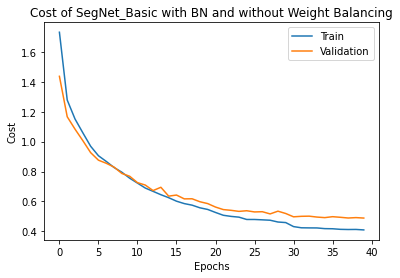

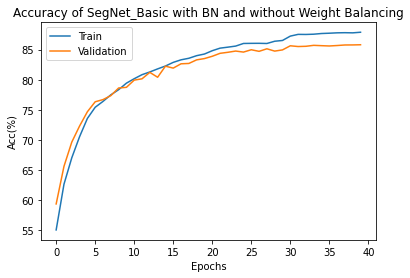

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet_Basic with BN and without Weight Balancing")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet_Basic with BN and without Weight Balancing")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/SegNet_BN.pth'
torch.save(Net.state_dict(), PATH)

#### Test SegNet Basic without weight Balancing










  0%|          | 0/1 [00:00<?, ?it/s]








100%|██████████| 1/1 [00:13<00:00, 13.02s/it]


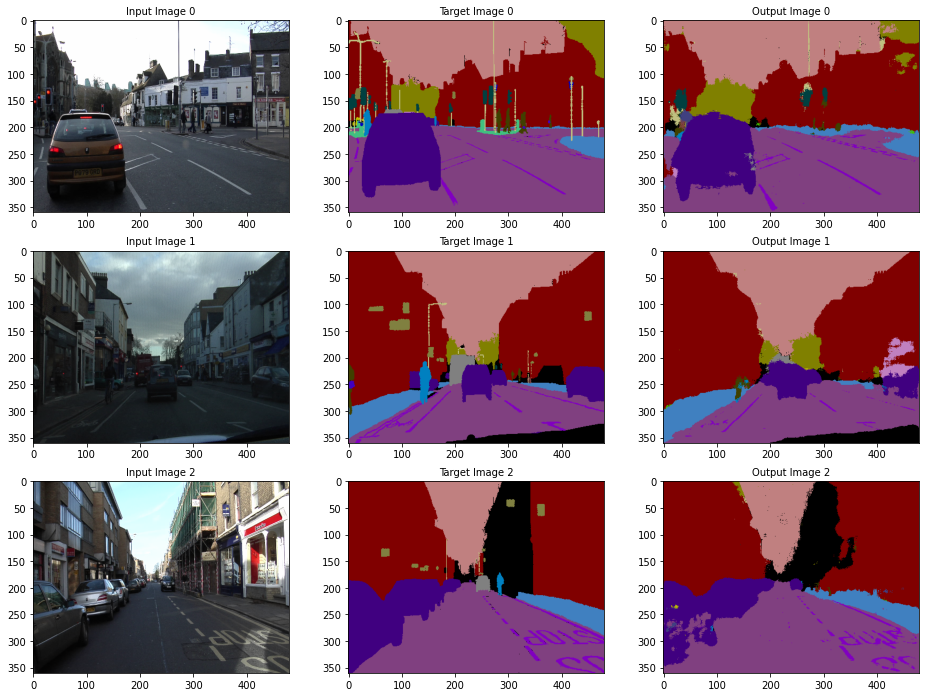

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}
          
PATH = '/content/drive/My Drive/SegNet_BN.pth'
 
net = SegNet_Basic_BN()
net.load_state_dict(torch.load(PATH))

test_set = CamVid_Dataset(data_root, partition['test'], **kwargs)
test_generator = torch.utils.data.DataLoader(test_set, **params)

for images, labels in tqdm(test_generator):
    outputs = net(images)
    test_set.test_network(images, outputs, labels)

### Train SegNet_Basic_BN with weight balancing

#### Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 6,
          'shuffle': False,
          'num_workers': 2}

max_epochs = 500

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic_BN()
Net.to(device)

# Calculate median frequency balancing 
class_weights = training_set.labels_weight()

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(weight = Tensor(class_weights).to(device))
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

dataiter = iter(training_generator)
batch_train_data, batch_train_labels = dataiter.next()

dataiter = iter(validation_generator)
batch_data, batch_labels = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training

    # Transfer to GPU
    batch_train_data, batch_train_labels = batch_train_data.to(device), batch_train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(batch_train_data)

    loss = criterion(batch_train_outputs, batch_train_labels.long())
    loss.backward()
    optimizer.step()

    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  batch_train_labels.long()) / torch.numel(batch_train_labels)

    if train_cnt % 10 == 9:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1

    

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for batch_data, batch_labels in tqdm(validation_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        val_loss = criterion(batch_outputs, batch_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)










  0%|          | 0/500 [00:00<?, ?it/s]








  0%|          | 1/500 [00:00<06:21,  1.31it/s]








  0%|          | 2/500 [00:01<06:08,  1.35it/s]








  1%|          | 3/500 [00:02<06:00,  1.38it/s]








  1%|          | 4/500 [00:02<05:54,  1.40it/s]








  1%|          | 5/500 [00:03<05:50,  1.41it/s]








  1%|          | 6/500 [00:04<05:47,  1.42it/s]








  1%|▏         | 7/500 [00:04<05:44,  1.43it/s]








  2%|▏         | 8/500 [00:05<05:42,  1.44it/s]








  2%|▏         | 9/500 [00:06<05:41,  1.44it/s]








  2%|▏         | 10/500 [00:06<05:40,  1.44it/s]








  2%|▏         | 11/500 [00:07<05:38,  1.44it/s]








  2%|▏         | 12/500 [00:08<05:38,  1.44it/s]








  3%|▎         | 13/500 [00:09<05:37,  1.44it/s]








  3%|▎         | 14/500 [00:09<05:37,  1.44it/s]








  3%|▎         | 15/500 [00:10<05:38,  1.43it/s]








  3%|▎         | 16/500 [00:11<05:37,  1.44it/s]








  3%|▎         | 17/500 [00:11<05:37,  1

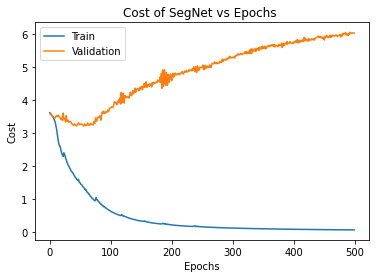

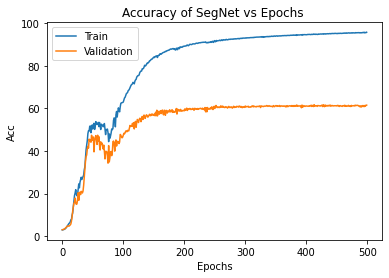

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet vs Epochs ")
    plt.ylabel('Acc')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

#### Training   

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 6,
          'shuffle': False,
          'num_workers': 2}

max_epochs = 10

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = SegNet_Basic_BN()
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []


# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 20 == 19:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 20))
            running_loss = 0.0
        
        train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)










  0%|          | 0/10 [00:00<?, ?it/s]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:36,  2.97s/it]









  2%|▏         | 2/94 [00:03<03:26,  2.25s/it]









  3%|▎         | 3/94 [00:05<03:11,  2.11s/it]









  4%|▍         | 4/94 [00:05<02:28,  1.64s/it]









  5%|▌         | 5/94 [00:07<02:33,  1.72s/it]









  6%|▋         | 6/94 [00:08<02:01,  1.38s/it]









  7%|▋         | 7/94 [00:10<02:15,  1.56s/it]









  9%|▊         | 8/94 [00:10<01:48,  1.27s/it]









 10%|▉         | 9/94 [00:12<02:06,  1.49s/it]









 11%|█         | 10/94 [00:13<01:42,  1.22s/it]









 12%|█▏        | 11/94 [00:15<01:53,  1.37s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.13s/it]









 14%|█▍        | 13/94 [00:17<01:47,  1.33s/it]









 15%|█▍        | 14/94 [00:18<01:28,  1.11s/it]









 16%|█▌        | 15/94 [00:20<01:45,  1.33s/it]









 17%|█▋        | 16/94 [00:20<01:26,  1.11s/it]



Cost of Train data after 20 iterations in epoch 1 : 2.678492












 22%|██▏       | 21/94 [00:27<01:40,  1.38s/it]









 23%|██▎       | 22/94 [00:28<01:22,  1.14s/it]









 24%|██▍       | 23/94 [00:30<01:36,  1.36s/it]









 26%|██▌       | 24/94 [00:30<01:19,  1.13s/it]









 27%|██▋       | 25/94 [00:32<01:32,  1.34s/it]









 28%|██▊       | 26/94 [00:33<01:15,  1.12s/it]









 29%|██▊       | 27/94 [00:34<01:30,  1.35s/it]









 30%|██▉       | 28/94 [00:35<01:14,  1.12s/it]









 31%|███       | 29/94 [00:37<01:26,  1.33s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.12s/it]









 33%|███▎      | 31/94 [00:39<01:24,  1.34s/it]









 34%|███▍      | 32/94 [00:40<01:09,  1.12s/it]









 35%|███▌      | 33/94 [00:42<01:20,  1.32s/it]









 36%|███▌      | 34/94 [00:42<01:06,  1.10s/it]









 37%|███▋      | 35/94 [00:44<01:16,  1.29s/it]









 38%|███▊      | 36/94 [00:45<01:02,  1.08s/it]









 39%|███▉      | 37/94 [00:46<01:11,  1.25s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 1 : 1.547812












 44%|████▎     | 41/94 [00:51<01:08,  1.29s/it]









 45%|████▍     | 42/94 [00:52<00:56,  1.08s/it]









 46%|████▌     | 43/94 [00:53<01:04,  1.27s/it]









 47%|████▋     | 44/94 [00:54<00:54,  1.10s/it]









 48%|████▊     | 45/94 [00:56<01:03,  1.30s/it]









 49%|████▉     | 46/94 [00:57<00:53,  1.12s/it]









 50%|█████     | 47/94 [00:58<01:00,  1.28s/it]









 51%|█████     | 48/94 [00:59<00:51,  1.11s/it]









 52%|█████▏    | 49/94 [01:01<00:57,  1.28s/it]









 53%|█████▎    | 50/94 [01:01<00:49,  1.12s/it]









 54%|█████▍    | 51/94 [01:03<00:55,  1.29s/it]









 55%|█████▌    | 52/94 [01:04<00:46,  1.12s/it]









 56%|█████▋    | 53/94 [01:05<00:52,  1.29s/it]









 57%|█████▋    | 54/94 [01:06<00:45,  1.14s/it]









 59%|█████▊    | 55/94 [01:08<00:50,  1.30s/it]









 60%|█████▉    | 56/94 [01:09<00:43,  1.14s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.32s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 1 : 1.606520












 65%|██████▍   | 61/94 [01:15<00:44,  1.34s/it]









 66%|██████▌   | 62/94 [01:16<00:35,  1.11s/it]









 67%|██████▋   | 63/94 [01:18<00:41,  1.35s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.12s/it]









 69%|██████▉   | 65/94 [01:20<00:39,  1.37s/it]









 70%|███████   | 66/94 [01:21<00:31,  1.13s/it]









 71%|███████▏  | 67/94 [01:23<00:36,  1.36s/it]









 72%|███████▏  | 68/94 [01:23<00:29,  1.13s/it]









 73%|███████▎  | 69/94 [01:25<00:32,  1.32s/it]









 74%|███████▍  | 70/94 [01:26<00:26,  1.10s/it]









 76%|███████▌  | 71/94 [01:28<00:30,  1.32s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.10s/it]









 78%|███████▊  | 73/94 [01:30<00:28,  1.37s/it]









 79%|███████▊  | 74/94 [01:31<00:22,  1.13s/it]









 80%|███████▉  | 75/94 [01:33<00:25,  1.32s/it]









 81%|████████  | 76/94 [01:33<00:19,  1.10s/it]









 82%|████████▏ | 77/94 [01:35<00:22,  1.30s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 1 : 1.416006












 86%|████████▌ | 81/94 [01:40<00:16,  1.30s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.09s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.35s/it]









 89%|████████▉ | 84/94 [01:43<00:11,  1.12s/it]









 90%|█████████ | 85/94 [01:45<00:11,  1.32s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.10s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.32s/it]









 94%|█████████▎| 88/94 [01:48<00:06,  1.11s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.34s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.12s/it]









 97%|█████████▋| 91/94 [01:52<00:03,  1.32s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.10s/it]









 99%|█████████▉| 93/94 [01:54<00:01,  1.14s/it]









100%|██████████| 94/94 [01:54<00:00,  1.22s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.41s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.74s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 1 : 1.318308












 48%|████▊     | 11/23 [00:13<00:14,  1.25s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.06it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.21s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.10it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.20s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.10it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.21s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.11it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.23s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.10it/s]

Cost of Validation data after 20 iterations in epoch 1 : 1.269864












 91%|█████████▏| 21/23 [00:23<00:02,  1.22s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.11it/s]









100%|██████████| 23/23 [00:24<00:00,  1.09s/it]









 10%|█         | 1/10 [02:19<20:55, 139.52s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:35,  2.96s/it]









  2%|▏         | 2/94 [00:03<03:26,  2.25s/it]









  3%|▎         | 3/94 [00:05<03:12,  2.11s/it]









  4%|▍         | 4/94 [00:05<02:28,  1.65s/it]









  5%|▌         | 5/94 [00:07<02:31,  1.70s/it]









  6%|▋         | 6/94 [00:08<02:00,  1.37s/it]









  7%|▋         | 7/94 [00:10<02:12,  1.52s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.24s/it]









 10%|▉         | 9/94 [00:12<02:03,  1.45s/it]









 11%|█         | 10/94 [00:13<01:40,  1.19s/it]









 12%|█▏        | 11/94 [00:15<01:53,  1.37s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.14s/it]









 14%|█▍        | 13/94 [00:17<01:51,  1

Cost of Train data after 20 iterations in epoch 2 : 1.388361












 22%|██▏       | 21/94 [00:27<01:38,  1.35s/it]









 23%|██▎       | 22/94 [00:28<01:20,  1.12s/it]









 24%|██▍       | 23/94 [00:30<01:36,  1.36s/it]









 26%|██▌       | 24/94 [00:30<01:19,  1.13s/it]









 27%|██▋       | 25/94 [00:32<01:32,  1.34s/it]









 28%|██▊       | 26/94 [00:32<01:15,  1.11s/it]









 29%|██▊       | 27/94 [00:34<01:30,  1.35s/it]









 30%|██▉       | 28/94 [00:35<01:13,  1.12s/it]









 31%|███       | 29/94 [00:37<01:27,  1.35s/it]









 32%|███▏      | 30/94 [00:37<01:11,  1.12s/it]









 33%|███▎      | 31/94 [00:39<01:24,  1.35s/it]









 34%|███▍      | 32/94 [00:40<01:09,  1.12s/it]









 35%|███▌      | 33/94 [00:42<01:18,  1.29s/it]









 36%|███▌      | 34/94 [00:42<01:04,  1.08s/it]









 37%|███▋      | 35/94 [00:44<01:19,  1.34s/it]









 38%|███▊      | 36/94 [00:45<01:04,  1.11s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.30s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 2 : 1.227160












 44%|████▎     | 41/94 [00:51<01:09,  1.31s/it]









 45%|████▍     | 42/94 [00:52<00:56,  1.09s/it]









 46%|████▌     | 43/94 [00:54<01:07,  1.31s/it]









 47%|████▋     | 44/94 [00:54<00:54,  1.10s/it]









 48%|████▊     | 45/94 [00:56<01:04,  1.32s/it]









 49%|████▉     | 46/94 [00:57<00:53,  1.10s/it]









 50%|█████     | 47/94 [00:59<01:02,  1.33s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.10s/it]









 52%|█████▏    | 49/94 [01:01<00:58,  1.29s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.08s/it]









 54%|█████▍    | 51/94 [01:03<00:55,  1.30s/it]









 55%|█████▌    | 52/94 [01:04<00:45,  1.08s/it]









 56%|█████▋    | 53/94 [01:06<00:53,  1.31s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.09s/it]









 59%|█████▊    | 55/94 [01:08<00:50,  1.29s/it]









 60%|█████▉    | 56/94 [01:09<00:41,  1.08s/it]









 61%|██████    | 57/94 [01:10<00:47,  1.29s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 2 : 1.290452












 65%|██████▍   | 61/94 [01:15<00:42,  1.28s/it]









 66%|██████▌   | 62/94 [01:16<00:35,  1.11s/it]









 67%|██████▋   | 63/94 [01:18<00:40,  1.29s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.10s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.29s/it]









 70%|███████   | 66/94 [01:21<00:30,  1.09s/it]









 71%|███████▏  | 67/94 [01:23<00:36,  1.34s/it]









 72%|███████▏  | 68/94 [01:23<00:29,  1.12s/it]









 73%|███████▎  | 69/94 [01:25<00:32,  1.29s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.11s/it]









 76%|███████▌  | 71/94 [01:27<00:29,  1.29s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.13s/it]









 78%|███████▊  | 73/94 [01:30<00:27,  1.29s/it]









 79%|███████▊  | 74/94 [01:30<00:22,  1.15s/it]









 80%|███████▉  | 75/94 [01:32<00:24,  1.28s/it]









 81%|████████  | 76/94 [01:33<00:20,  1.13s/it]









 82%|████████▏ | 77/94 [01:35<00:21,  1.29s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 2 : 1.223353












 86%|████████▌ | 81/94 [01:39<00:17,  1.33s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.10s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.30s/it]









 89%|████████▉ | 84/94 [01:42<00:11,  1.11s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.27s/it]









 91%|█████████▏| 86/94 [01:45<00:09,  1.15s/it]









 93%|█████████▎| 87/94 [01:46<00:08,  1.25s/it]









 94%|█████████▎| 88/94 [01:47<00:07,  1.18s/it]









 95%|█████████▍| 89/94 [01:49<00:06,  1.21s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.18s/it]









 97%|█████████▋| 91/94 [01:51<00:03,  1.25s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.16s/it]









 99%|█████████▉| 93/94 [01:54<00:01,  1.20s/it]









100%|██████████| 94/94 [01:54<00:00,  1.22s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.48s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.79s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 2 : 1.307549












 48%|████▊     | 11/23 [00:13<00:15,  1.29s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.04it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.26s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.23s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.10it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.24s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.09it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.24s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.09it/s]

Cost of Validation data after 20 iterations in epoch 2 : 1.243290












 91%|█████████▏| 21/23 [00:23<00:02,  1.23s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.11it/s]









100%|██████████| 23/23 [00:25<00:00,  1.09s/it]









 20%|██        | 2/10 [04:39<18:36, 139.53s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:24,  2.84s/it]









  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]









  3%|▎         | 3/94 [00:05<03:09,  2.08s/it]









  4%|▍         | 4/94 [00:05<02:27,  1.63s/it]









  5%|▌         | 5/94 [00:07<02:28,  1.67s/it]









  6%|▋         | 6/94 [00:08<01:58,  1.35s/it]









  7%|▋         | 7/94 [00:10<02:12,  1.52s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.24s/it]









 10%|▉         | 9/94 [00:12<02:04,  1.46s/it]









 11%|█         | 10/94 [00:13<01:40,  1.20s/it]









 12%|█▏        | 11/94 [00:15<01:56,  1.40s/it]









 13%|█▎        | 12/94 [00:15<01:35,  1.16s/it]









 14%|█▍        | 13/94 [00:17<01:51,  1

Cost of Train data after 20 iterations in epoch 3 : 1.269715












 22%|██▏       | 21/94 [00:27<01:37,  1.33s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.34s/it]









 26%|██▌       | 24/94 [00:30<01:18,  1.12s/it]









 27%|██▋       | 25/94 [00:32<01:33,  1.35s/it]









 28%|██▊       | 26/94 [00:32<01:16,  1.12s/it]









 29%|██▊       | 27/94 [00:34<01:30,  1.34s/it]









 30%|██▉       | 28/94 [00:35<01:13,  1.12s/it]









 31%|███       | 29/94 [00:37<01:25,  1.31s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.09s/it]









 33%|███▎      | 31/94 [00:39<01:22,  1.32s/it]









 34%|███▍      | 32/94 [00:40<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:42<01:22,  1.35s/it]









 36%|███▌      | 34/94 [00:42<01:07,  1.12s/it]









 37%|███▋      | 35/94 [00:44<01:20,  1.36s/it]









 38%|███▊      | 36/94 [00:45<01:05,  1.13s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.30s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 3 : 1.138347












 44%|████▎     | 41/94 [00:51<01:11,  1.34s/it]









 45%|████▍     | 42/94 [00:52<00:57,  1.11s/it]









 46%|████▌     | 43/94 [00:54<01:08,  1.34s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.11s/it]









 48%|████▊     | 45/94 [00:56<01:02,  1.27s/it]









 49%|████▉     | 46/94 [00:57<00:51,  1.06s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.30s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.09s/it]









 52%|█████▏    | 49/94 [01:01<00:58,  1.30s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.08s/it]









 54%|█████▍    | 51/94 [01:03<00:57,  1.33s/it]









 55%|█████▌    | 52/94 [01:04<00:46,  1.11s/it]









 56%|█████▋    | 53/94 [01:06<00:54,  1.34s/it]









 57%|█████▋    | 54/94 [01:06<00:44,  1.11s/it]









 59%|█████▊    | 55/94 [01:08<00:52,  1.36s/it]









 60%|█████▉    | 56/94 [01:09<00:42,  1.13s/it]









 61%|██████    | 57/94 [01:11<00:51,  1.38s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 3 : 1.178330












 65%|██████▍   | 61/94 [01:15<00:42,  1.29s/it]









 66%|██████▌   | 62/94 [01:16<00:34,  1.08s/it]









 67%|██████▋   | 63/94 [01:18<00:40,  1.31s/it]









 68%|██████▊   | 64/94 [01:18<00:32,  1.09s/it]









 69%|██████▉   | 65/94 [01:20<00:37,  1.29s/it]









 70%|███████   | 66/94 [01:21<00:30,  1.08s/it]









 71%|███████▏  | 67/94 [01:23<00:36,  1.34s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.11s/it]









 73%|███████▎  | 69/94 [01:25<00:33,  1.32s/it]









 74%|███████▍  | 70/94 [01:26<00:26,  1.10s/it]









 76%|███████▌  | 71/94 [01:28<00:29,  1.29s/it]









 77%|███████▋  | 72/94 [01:28<00:23,  1.08s/it]









 78%|███████▊  | 73/94 [01:30<00:27,  1.29s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.08s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.32s/it]









 81%|████████  | 76/94 [01:33<00:19,  1.11s/it]









 82%|████████▏ | 77/94 [01:35<00:22,  1.31s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 3 : 1.121899












 86%|████████▌ | 81/94 [01:40<00:17,  1.34s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.11s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.35s/it]









 89%|████████▉ | 84/94 [01:43<00:11,  1.12s/it]









 90%|█████████ | 85/94 [01:45<00:12,  1.35s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.12s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.36s/it]









 94%|█████████▎| 88/94 [01:48<00:06,  1.13s/it]









 95%|█████████▍| 89/94 [01:50<00:06,  1.34s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.11s/it]









 97%|█████████▋| 91/94 [01:52<00:04,  1.36s/it]









 98%|█████████▊| 92/94 [01:53<00:02,  1.12s/it]









 99%|█████████▉| 93/94 [01:54<00:01,  1.13s/it]









100%|██████████| 94/94 [01:54<00:00,  1.22s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.45s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.77s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 3 : 1.352306












 48%|████▊     | 11/23 [00:13<00:15,  1.29s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.05it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.25s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.09it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.25s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.09it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.24s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.09it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.25s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.09it/s]

Cost of Validation data after 20 iterations in epoch 3 : 1.263245












 91%|█████████▏| 21/23 [00:23<00:02,  1.17s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.16it/s]









100%|██████████| 23/23 [00:25<00:00,  1.09s/it]









 30%|███       | 3/10 [06:58<16:16, 139.57s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:27,  2.88s/it]









  2%|▏         | 2/94 [00:03<03:21,  2.19s/it]









  3%|▎         | 3/94 [00:05<03:08,  2.07s/it]









  4%|▍         | 4/94 [00:05<02:26,  1.63s/it]









  5%|▌         | 5/94 [00:07<02:31,  1.71s/it]









  6%|▋         | 6/94 [00:08<02:00,  1.37s/it]









  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.23s/it]









 10%|▉         | 9/94 [00:12<01:59,  1.41s/it]









 11%|█         | 10/94 [00:13<01:37,  1.17s/it]









 12%|█▏        | 11/94 [00:14<01:52,  1.36s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.13s/it]









 14%|█▍        | 13/94 [00:17<01:47,  1

Cost of Train data after 20 iterations in epoch 4 : 1.160268












 22%|██▏       | 21/94 [00:27<01:36,  1.32s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:33,  1.32s/it]









 26%|██▌       | 24/94 [00:30<01:17,  1.11s/it]









 27%|██▋       | 25/94 [00:31<01:26,  1.26s/it]









 28%|██▊       | 26/94 [00:32<01:12,  1.07s/it]









 29%|██▊       | 27/94 [00:33<01:22,  1.23s/it]









 30%|██▉       | 28/94 [00:34<01:10,  1.06s/it]









 31%|███       | 29/94 [00:36<01:21,  1.25s/it]









 32%|███▏      | 30/94 [00:36<01:08,  1.08s/it]









 33%|███▎      | 31/94 [00:38<01:21,  1.30s/it]









 34%|███▍      | 32/94 [00:39<01:10,  1.14s/it]









 35%|███▌      | 33/94 [00:41<01:17,  1.26s/it]









 36%|███▌      | 34/94 [00:41<01:09,  1.16s/it]









 37%|███▋      | 35/94 [00:43<01:13,  1.25s/it]









 38%|███▊      | 36/94 [00:44<01:07,  1.16s/it]









 39%|███▉      | 37/94 [00:45<01:09,  1.22s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 4 : 1.052003












 44%|████▎     | 41/94 [00:50<01:07,  1.27s/it]









 45%|████▍     | 42/94 [00:51<00:59,  1.14s/it]









 46%|████▌     | 43/94 [00:53<01:05,  1.28s/it]









 47%|████▋     | 44/94 [00:53<00:57,  1.15s/it]









 48%|████▊     | 45/94 [00:55<01:02,  1.28s/it]









 49%|████▉     | 46/94 [00:56<00:54,  1.14s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.30s/it]









 51%|█████     | 48/94 [00:58<00:51,  1.12s/it]









 52%|█████▏    | 49/94 [01:00<00:57,  1.28s/it]









 53%|█████▎    | 50/94 [01:01<00:50,  1.14s/it]









 54%|█████▍    | 51/94 [01:02<00:54,  1.26s/it]









 55%|█████▌    | 52/94 [01:03<00:47,  1.14s/it]









 56%|█████▋    | 53/94 [01:05<00:51,  1.27s/it]









 57%|█████▋    | 54/94 [01:06<00:46,  1.15s/it]









 59%|█████▊    | 55/94 [01:07<00:49,  1.26s/it]









 60%|█████▉    | 56/94 [01:08<00:44,  1.16s/it]









 61%|██████    | 57/94 [01:09<00:45,  1.24s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 4 : 1.088936












 65%|██████▍   | 61/94 [01:14<00:39,  1.21s/it]









 66%|██████▌   | 62/94 [01:15<00:38,  1.21s/it]









 67%|██████▋   | 63/94 [01:17<00:37,  1.22s/it]









 68%|██████▊   | 64/94 [01:18<00:37,  1.23s/it]









 69%|██████▉   | 65/94 [01:19<00:34,  1.19s/it]









 70%|███████   | 66/94 [01:20<00:33,  1.20s/it]









 71%|███████▏  | 67/94 [01:21<00:32,  1.21s/it]









 72%|███████▏  | 68/94 [01:23<00:31,  1.22s/it]









 73%|███████▎  | 69/94 [01:24<00:30,  1.22s/it]









 74%|███████▍  | 70/94 [01:25<00:29,  1.22s/it]









 76%|███████▌  | 71/94 [01:26<00:27,  1.19s/it]









 77%|███████▋  | 72/94 [01:27<00:25,  1.17s/it]









 78%|███████▊  | 73/94 [01:29<00:25,  1.20s/it]









 79%|███████▊  | 74/94 [01:30<00:24,  1.21s/it]









 80%|███████▉  | 75/94 [01:31<00:23,  1.22s/it]









 81%|████████  | 76/94 [01:32<00:21,  1.17s/it]









 82%|████████▏ | 77/94 [01:33<00:20,  1.21s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 4 : 1.024856












 86%|████████▌ | 81/94 [01:38<00:16,  1.23s/it]









 87%|████████▋ | 82/94 [01:39<00:14,  1.21s/it]









 88%|████████▊ | 83/94 [01:41<00:13,  1.21s/it]









 89%|████████▉ | 84/94 [01:42<00:12,  1.22s/it]









 90%|█████████ | 85/94 [01:43<00:10,  1.20s/it]









 91%|█████████▏| 86/94 [01:44<00:09,  1.25s/it]









 93%|█████████▎| 87/94 [01:45<00:08,  1.15s/it]









 94%|█████████▎| 88/94 [01:47<00:07,  1.22s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.21s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.20s/it]









 97%|█████████▋| 91/94 [01:50<00:03,  1.22s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.24s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.15s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:54,  2.47s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.77s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 4 : 1.043013












 48%|████▊     | 11/23 [00:13<00:14,  1.24s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.09it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.24s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.25s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.07it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.24s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.09it/s]









 83%|████████▎ | 19/23 [00:21<00:05,  1.25s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 4 : 1.023790












 91%|█████████▏| 21/23 [00:23<00:02,  1.18s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.15it/s]









100%|██████████| 23/23 [00:24<00:00,  1.08s/it]









 40%|████      | 4/10 [09:17<13:55, 139.22s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:28,  2.88s/it]









  2%|▏         | 2/94 [00:03<03:21,  2.19s/it]









  3%|▎         | 3/94 [00:05<03:06,  2.05s/it]









  4%|▍         | 4/94 [00:05<02:25,  1.61s/it]









  5%|▌         | 5/94 [00:07<02:31,  1.70s/it]









  6%|▋         | 6/94 [00:08<02:00,  1.37s/it]









  7%|▋         | 7/94 [00:10<02:12,  1.52s/it]









  9%|▊         | 8/94 [00:10<01:46,  1.24s/it]









 10%|▉         | 9/94 [00:12<01:59,  1.41s/it]









 11%|█         | 10/94 [00:13<01:37,  1.17s/it]









 12%|█▏        | 11/94 [00:14<01:52,  1.35s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.12s/it]









 14%|█▍        | 13/94 [00:17<01:44,  1

Cost of Train data after 20 iterations in epoch 5 : 1.029606












 22%|██▏       | 21/94 [00:26<01:33,  1.29s/it]









 23%|██▎       | 22/94 [00:27<01:17,  1.08s/it]









 24%|██▍       | 23/94 [00:29<01:32,  1.31s/it]









 26%|██▌       | 24/94 [00:29<01:16,  1.10s/it]









 27%|██▋       | 25/94 [00:31<01:30,  1.32s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.10s/it]









 29%|██▊       | 27/94 [00:34<01:26,  1.29s/it]









 30%|██▉       | 28/94 [00:34<01:11,  1.08s/it]









 31%|███       | 29/94 [00:36<01:23,  1.28s/it]









 32%|███▏      | 30/94 [00:36<01:08,  1.08s/it]









 33%|███▎      | 31/94 [00:38<01:22,  1.31s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:16,  1.26s/it]









 36%|███▌      | 34/94 [00:41<01:03,  1.06s/it]









 37%|███▋      | 35/94 [00:43<01:13,  1.25s/it]









 38%|███▊      | 36/94 [00:43<01:01,  1.05s/it]









 39%|███▉      | 37/94 [00:45<01:15,  1.32s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 5 : 0.940082












 44%|████▎     | 41/94 [00:50<01:09,  1.30s/it]









 45%|████▍     | 42/94 [00:51<00:56,  1.09s/it]









 46%|████▌     | 43/94 [00:53<01:06,  1.31s/it]









 47%|████▋     | 44/94 [00:53<00:54,  1.09s/it]









 48%|████▊     | 45/94 [00:55<01:03,  1.29s/it]









 49%|████▉     | 46/94 [00:55<00:51,  1.08s/it]









 50%|█████     | 47/94 [00:57<00:59,  1.26s/it]









 51%|█████     | 48/94 [00:58<00:48,  1.06s/it]









 52%|█████▏    | 49/94 [01:00<00:57,  1.28s/it]









 53%|█████▎    | 50/94 [01:00<00:47,  1.07s/it]









 54%|█████▍    | 51/94 [01:02<00:53,  1.25s/it]









 55%|█████▌    | 52/94 [01:02<00:44,  1.05s/it]









 56%|█████▋    | 53/94 [01:04<00:51,  1.25s/it]









 57%|█████▋    | 54/94 [01:05<00:42,  1.06s/it]









 59%|█████▊    | 55/94 [01:06<00:49,  1.26s/it]









 60%|█████▉    | 56/94 [01:07<00:40,  1.07s/it]









 61%|██████    | 57/94 [01:09<00:46,  1.25s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 5 : 1.002336












 65%|██████▍   | 61/94 [01:13<00:41,  1.25s/it]









 66%|██████▌   | 62/94 [01:14<00:35,  1.12s/it]









 67%|██████▋   | 63/94 [01:16<00:38,  1.24s/it]









 68%|██████▊   | 64/94 [01:17<00:33,  1.12s/it]









 69%|██████▉   | 65/94 [01:18<00:36,  1.25s/it]









 70%|███████   | 66/94 [01:19<00:31,  1.13s/it]









 71%|███████▏  | 67/94 [01:20<00:33,  1.23s/it]









 72%|███████▏  | 68/94 [01:21<00:29,  1.15s/it]









 73%|███████▎  | 69/94 [01:23<00:31,  1.27s/it]









 74%|███████▍  | 70/94 [01:24<00:26,  1.11s/it]









 76%|███████▌  | 71/94 [01:25<00:29,  1.27s/it]









 77%|███████▋  | 72/94 [01:26<00:25,  1.14s/it]









 78%|███████▊  | 73/94 [01:28<00:26,  1.25s/it]









 79%|███████▊  | 74/94 [01:29<00:22,  1.15s/it]









 80%|███████▉  | 75/94 [01:30<00:23,  1.23s/it]









 81%|████████  | 76/94 [01:31<00:21,  1.17s/it]









 82%|████████▏ | 77/94 [01:32<00:20,  1.19s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 5 : 0.954024












 86%|████████▌ | 81/94 [01:37<00:15,  1.23s/it]









 87%|████████▋ | 82/94 [01:38<00:14,  1.20s/it]









 88%|████████▊ | 83/94 [01:40<00:13,  1.19s/it]









 89%|████████▉ | 84/94 [01:41<00:12,  1.21s/it]









 90%|█████████ | 85/94 [01:42<00:10,  1.21s/it]









 91%|█████████▏| 86/94 [01:43<00:09,  1.22s/it]









 93%|█████████▎| 87/94 [01:44<00:08,  1.22s/it]









 94%|█████████▎| 88/94 [01:45<00:06,  1.16s/it]









 95%|█████████▍| 89/94 [01:47<00:06,  1.24s/it]









 96%|█████████▌| 90/94 [01:48<00:04,  1.16s/it]









 97%|█████████▋| 91/94 [01:49<00:03,  1.24s/it]









 98%|█████████▊| 92/94 [01:50<00:02,  1.13s/it]









 99%|█████████▉| 93/94 [01:51<00:01,  1.14s/it]









100%|██████████| 94/94 [01:52<00:00,  1.19s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:51,  2.36s/it]









  9%|▊         | 2/23 [00:02<00:35,  1.70s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 5 : 0.965737












 48%|████▊     | 11/23 [00:13<00:15,  1.25s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.08it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.26s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.22s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.11it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.23s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.11it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.19s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.13it/s]

Cost of Validation data after 20 iterations in epoch 5 : 0.934532












 91%|█████████▏| 21/23 [00:23<00:02,  1.20s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.12it/s]









100%|██████████| 23/23 [00:24<00:00,  1.08s/it]









 50%|█████     | 5/10 [11:34<11:32, 138.54s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:28,  2.89s/it]









  2%|▏         | 2/94 [00:03<03:22,  2.20s/it]









  3%|▎         | 3/94 [00:05<03:08,  2.07s/it]









  4%|▍         | 4/94 [00:05<02:26,  1.63s/it]









  5%|▌         | 5/94 [00:07<02:29,  1.68s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.36s/it]









  7%|▋         | 7/94 [00:10<02:09,  1.49s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.22s/it]









 10%|▉         | 9/94 [00:12<01:58,  1.39s/it]









 11%|█         | 10/94 [00:13<01:36,  1.15s/it]









 12%|█▏        | 11/94 [00:14<01:54,  1.38s/it]









 13%|█▎        | 12/94 [00:15<01:33,  1.15s/it]









 14%|█▍        | 13/94 [00:17<01:50,  1

Cost of Train data after 20 iterations in epoch 6 : 0.983455












 22%|██▏       | 21/94 [00:27<01:37,  1.33s/it]









 23%|██▎       | 22/94 [00:27<01:20,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:36,  1.35s/it]









 26%|██▌       | 24/94 [00:30<01:18,  1.13s/it]









 27%|██▋       | 25/94 [00:32<01:35,  1.38s/it]









 28%|██▊       | 26/94 [00:32<01:17,  1.14s/it]









 29%|██▊       | 27/94 [00:34<01:30,  1.35s/it]









 30%|██▉       | 28/94 [00:35<01:14,  1.12s/it]









 31%|███       | 29/94 [00:37<01:27,  1.35s/it]









 32%|███▏      | 30/94 [00:37<01:12,  1.13s/it]









 33%|███▎      | 31/94 [00:39<01:23,  1.33s/it]









 34%|███▍      | 32/94 [00:40<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:41<01:20,  1.33s/it]









 36%|███▌      | 34/94 [00:42<01:06,  1.10s/it]









 37%|███▋      | 35/94 [00:44<01:17,  1.31s/it]









 38%|███▊      | 36/94 [00:44<01:03,  1.10s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.31s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 6 : 0.881633












 44%|████▎     | 41/94 [00:51<01:10,  1.33s/it]









 45%|████▍     | 42/94 [00:52<00:57,  1.11s/it]









 46%|████▌     | 43/94 [00:54<01:07,  1.33s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.11s/it]









 48%|████▊     | 45/94 [00:56<01:04,  1.31s/it]









 49%|████▉     | 46/94 [00:57<00:52,  1.10s/it]









 50%|█████     | 47/94 [00:58<01:01,  1.30s/it]









 51%|█████     | 48/94 [00:59<00:50,  1.09s/it]









 52%|█████▏    | 49/94 [01:01<00:57,  1.29s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.08s/it]









 54%|█████▍    | 51/94 [01:03<00:57,  1.34s/it]









 55%|█████▌    | 52/94 [01:04<00:46,  1.11s/it]









 56%|█████▋    | 53/94 [01:06<00:54,  1.32s/it]









 57%|█████▋    | 54/94 [01:06<00:43,  1.10s/it]









 59%|█████▊    | 55/94 [01:08<00:50,  1.30s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.09s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.31s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 6 : 0.946868












 65%|██████▍   | 61/94 [01:15<00:44,  1.36s/it]









 66%|██████▌   | 62/94 [01:16<00:36,  1.13s/it]









 67%|██████▋   | 63/94 [01:18<00:41,  1.34s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.11s/it]









 69%|██████▉   | 65/94 [01:20<00:39,  1.36s/it]









 70%|███████   | 66/94 [01:21<00:31,  1.13s/it]









 71%|███████▏  | 67/94 [01:23<00:36,  1.35s/it]









 72%|███████▏  | 68/94 [01:23<00:29,  1.12s/it]









 73%|███████▎  | 69/94 [01:25<00:33,  1.34s/it]









 74%|███████▍  | 70/94 [01:26<00:26,  1.11s/it]









 76%|███████▌  | 71/94 [01:28<00:30,  1.32s/it]









 77%|███████▋  | 72/94 [01:28<00:24,  1.11s/it]









 78%|███████▊  | 73/94 [01:30<00:28,  1.34s/it]









 79%|███████▊  | 74/94 [01:31<00:22,  1.11s/it]









 80%|███████▉  | 75/94 [01:32<00:25,  1.34s/it]









 81%|████████  | 76/94 [01:33<00:20,  1.12s/it]









 82%|████████▏ | 77/94 [01:35<00:22,  1.33s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 6 : 0.870021












 86%|████████▌ | 81/94 [01:40<00:17,  1.33s/it]









 87%|████████▋ | 82/94 [01:40<00:13,  1.11s/it]









 88%|████████▊ | 83/94 [01:42<00:14,  1.33s/it]









 89%|████████▉ | 84/94 [01:43<00:11,  1.11s/it]









 90%|█████████ | 85/94 [01:45<00:11,  1.32s/it]









 91%|█████████▏| 86/94 [01:45<00:08,  1.10s/it]









 93%|█████████▎| 87/94 [01:47<00:09,  1.32s/it]









 94%|█████████▎| 88/94 [01:48<00:06,  1.10s/it]









 95%|█████████▍| 89/94 [01:50<00:06,  1.33s/it]









 96%|█████████▌| 90/94 [01:50<00:04,  1.11s/it]









 97%|█████████▋| 91/94 [01:52<00:03,  1.23s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.04s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.05s/it]









100%|██████████| 94/94 [01:54<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.41s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.73s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 6 : 0.903496












 48%|████▊     | 11/23 [00:12<00:15,  1.27s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.06it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.25s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.20s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.13it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.20s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.12it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.22s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.11it/s]

Cost of Validation data after 20 iterations in epoch 6 : 0.879651












 91%|█████████▏| 21/23 [00:23<00:02,  1.17s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.10it/s]









100%|██████████| 23/23 [00:24<00:00,  1.07s/it]









 60%|██████    | 6/10 [13:52<09:14, 138.60s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:30,  2.91s/it]









  2%|▏         | 2/94 [00:03<03:23,  2.22s/it]









  3%|▎         | 3/94 [00:05<03:06,  2.04s/it]









  4%|▍         | 4/94 [00:05<02:24,  1.61s/it]









  5%|▌         | 5/94 [00:07<02:29,  1.68s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.35s/it]









  7%|▋         | 7/94 [00:09<02:06,  1.46s/it]









  9%|▊         | 8/94 [00:10<01:43,  1.20s/it]









 10%|▉         | 9/94 [00:12<01:59,  1.41s/it]









 11%|█         | 10/94 [00:12<01:38,  1.17s/it]









 12%|█▏        | 11/94 [00:14<01:53,  1.36s/it]









 13%|█▎        | 12/94 [00:15<01:32,  1.13s/it]









 14%|█▍        | 13/94 [00:17<01:49,  1

Cost of Train data after 20 iterations in epoch 7 : 0.917979












 22%|██▏       | 21/94 [00:26<01:34,  1.29s/it]









 23%|██▎       | 22/94 [00:27<01:18,  1.08s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.34s/it]









 26%|██▌       | 24/94 [00:29<01:18,  1.12s/it]









 27%|██▋       | 25/94 [00:31<01:32,  1.34s/it]









 28%|██▊       | 26/94 [00:32<01:16,  1.12s/it]









 29%|██▊       | 27/94 [00:34<01:27,  1.31s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.09s/it]









 31%|███       | 29/94 [00:36<01:21,  1.26s/it]









 32%|███▏      | 30/94 [00:36<01:07,  1.06s/it]









 33%|███▎      | 31/94 [00:38<01:23,  1.33s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.11s/it]









 35%|███▌      | 33/94 [00:41<01:20,  1.32s/it]









 36%|███▌      | 34/94 [00:41<01:06,  1.10s/it]









 37%|███▋      | 35/94 [00:43<01:20,  1.36s/it]









 38%|███▊      | 36/94 [00:44<01:05,  1.13s/it]









 39%|███▉      | 37/94 [00:46<01:14,  1.31s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 7 : 0.838494












 44%|████▎     | 41/94 [00:50<01:06,  1.26s/it]









 45%|████▍     | 42/94 [00:51<00:55,  1.06s/it]









 46%|████▌     | 43/94 [00:53<01:04,  1.26s/it]









 47%|████▋     | 44/94 [00:53<00:53,  1.06s/it]









 48%|████▊     | 45/94 [00:55<01:05,  1.34s/it]









 49%|████▉     | 46/94 [00:56<00:53,  1.11s/it]









 50%|█████     | 47/94 [00:58<01:02,  1.33s/it]









 51%|█████     | 48/94 [00:58<00:50,  1.11s/it]









 52%|█████▏    | 49/94 [01:00<01:00,  1.35s/it]









 53%|█████▎    | 50/94 [01:01<00:49,  1.12s/it]









 54%|█████▍    | 51/94 [01:02<00:56,  1.31s/it]









 55%|█████▌    | 52/94 [01:03<00:45,  1.09s/it]









 56%|█████▋    | 53/94 [01:05<00:52,  1.28s/it]









 57%|█████▋    | 54/94 [01:05<00:43,  1.08s/it]









 59%|█████▊    | 55/94 [01:07<00:51,  1.31s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.10s/it]









 61%|██████    | 57/94 [01:10<00:50,  1.36s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 7 : 0.873164












 65%|██████▍   | 61/94 [01:15<00:45,  1.37s/it]









 66%|██████▌   | 62/94 [01:15<00:36,  1.13s/it]









 67%|██████▋   | 63/94 [01:17<00:41,  1.33s/it]









 68%|██████▊   | 64/94 [01:18<00:33,  1.11s/it]









 69%|██████▉   | 65/94 [01:20<00:39,  1.35s/it]









 70%|███████   | 66/94 [01:20<00:31,  1.12s/it]









 71%|███████▏  | 67/94 [01:22<00:35,  1.33s/it]









 72%|███████▏  | 68/94 [01:23<00:28,  1.11s/it]









 73%|███████▎  | 69/94 [01:24<00:32,  1.30s/it]









 74%|███████▍  | 70/94 [01:25<00:26,  1.09s/it]









 76%|███████▌  | 71/94 [01:27<00:30,  1.31s/it]









 77%|███████▋  | 72/94 [01:27<00:24,  1.09s/it]









 78%|███████▊  | 73/94 [01:29<00:27,  1.31s/it]









 79%|███████▊  | 74/94 [01:30<00:21,  1.09s/it]









 80%|███████▉  | 75/94 [01:31<00:24,  1.28s/it]









 81%|████████  | 76/94 [01:32<00:19,  1.08s/it]









 82%|████████▏ | 77/94 [01:34<00:21,  1.29s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 7 : 0.826827












 86%|████████▌ | 81/94 [01:39<00:17,  1.33s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.12s/it]









 88%|████████▊ | 83/94 [01:41<00:14,  1.34s/it]









 89%|████████▉ | 84/94 [01:42<00:11,  1.12s/it]









 90%|█████████ | 85/94 [01:44<00:11,  1.33s/it]









 91%|█████████▏| 86/94 [01:44<00:08,  1.11s/it]









 93%|█████████▎| 87/94 [01:46<00:09,  1.32s/it]









 94%|█████████▎| 88/94 [01:47<00:06,  1.11s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.28s/it]









 96%|█████████▌| 90/94 [01:49<00:04,  1.07s/it]









 97%|█████████▋| 91/94 [01:51<00:03,  1.27s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.06s/it]









 99%|█████████▉| 93/94 [01:52<00:01,  1.07s/it]









100%|██████████| 94/94 [01:53<00:00,  1.20s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:53,  2.45s/it]









  9%|▊         | 2/23 [00:02<00:37,  1.76s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 7 : 0.853943












 48%|████▊     | 11/23 [00:13<00:15,  1.29s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.05it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.27s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.22s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.11it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.25s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.24s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.08it/s]

Cost of Validation data after 20 iterations in epoch 7 : 0.844252












 91%|█████████▏| 21/23 [00:23<00:02,  1.22s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.12it/s]









100%|██████████| 23/23 [00:25<00:00,  1.09s/it]









 70%|███████   | 7/10 [16:11<06:55, 138.48s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:30,  2.91s/it]









  2%|▏         | 2/94 [00:03<03:23,  2.22s/it]









  3%|▎         | 3/94 [00:05<03:10,  2.09s/it]









  4%|▍         | 4/94 [00:05<02:27,  1.64s/it]









  5%|▌         | 5/94 [00:07<02:33,  1.72s/it]









  6%|▋         | 6/94 [00:08<02:01,  1.38s/it]









  7%|▋         | 7/94 [00:10<02:09,  1.49s/it]









  9%|▊         | 8/94 [00:10<01:44,  1.22s/it]









 10%|▉         | 9/94 [00:12<01:57,  1.38s/it]









 11%|█         | 10/94 [00:13<01:36,  1.14s/it]









 12%|█▏        | 11/94 [00:14<01:52,  1.35s/it]









 13%|█▎        | 12/94 [00:15<01:31,  1.12s/it]









 14%|█▍        | 13/94 [00:17<01:46,  1

Cost of Train data after 20 iterations in epoch 8 : 0.881453












 22%|██▏       | 21/94 [00:26<01:35,  1.31s/it]









 23%|██▎       | 22/94 [00:27<01:18,  1.10s/it]









 24%|██▍       | 23/94 [00:29<01:31,  1.29s/it]









 26%|██▌       | 24/94 [00:29<01:15,  1.08s/it]









 27%|██▋       | 25/94 [00:31<01:29,  1.30s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.09s/it]









 29%|██▊       | 27/94 [00:34<01:27,  1.31s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.10s/it]









 31%|███       | 29/94 [00:36<01:26,  1.33s/it]









 32%|███▏      | 30/94 [00:37<01:10,  1.11s/it]









 33%|███▎      | 31/94 [00:39<01:23,  1.32s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:41<01:20,  1.32s/it]









 36%|███▌      | 34/94 [00:42<01:06,  1.10s/it]









 37%|███▋      | 35/94 [00:43<01:17,  1.31s/it]









 38%|███▊      | 36/94 [00:44<01:03,  1.10s/it]









 39%|███▉      | 37/94 [00:46<01:17,  1.35s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 8 : 0.803490












 44%|████▎     | 41/94 [00:51<01:10,  1.33s/it]









 45%|████▍     | 42/94 [00:51<00:57,  1.11s/it]









 46%|████▌     | 43/94 [00:53<01:07,  1.32s/it]









 47%|████▋     | 44/94 [00:54<00:55,  1.10s/it]









 48%|████▊     | 45/94 [00:55<01:02,  1.27s/it]









 49%|████▉     | 46/94 [00:56<00:51,  1.06s/it]









 50%|█████     | 47/94 [00:58<01:00,  1.29s/it]









 51%|█████     | 48/94 [00:58<00:49,  1.08s/it]









 52%|█████▏    | 49/94 [01:00<00:57,  1.28s/it]









 53%|█████▎    | 50/94 [01:01<00:47,  1.07s/it]









 54%|█████▍    | 51/94 [01:03<00:56,  1.31s/it]









 55%|█████▌    | 52/94 [01:03<00:45,  1.09s/it]









 56%|█████▋    | 53/94 [01:05<00:53,  1.30s/it]









 57%|█████▋    | 54/94 [01:06<00:44,  1.11s/it]









 59%|█████▊    | 55/94 [01:07<00:50,  1.29s/it]









 60%|█████▉    | 56/94 [01:08<00:41,  1.10s/it]









 61%|██████    | 57/94 [01:10<00:48,  1.30s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 8 : 0.839686












 65%|██████▍   | 61/94 [01:15<00:42,  1.28s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.12s/it]









 67%|██████▋   | 63/94 [01:17<00:36,  1.19s/it]









 68%|██████▊   | 64/94 [01:18<00:35,  1.18s/it]









 69%|██████▉   | 65/94 [01:19<00:35,  1.21s/it]









 70%|███████   | 66/94 [01:20<00:33,  1.21s/it]









 71%|███████▏  | 67/94 [01:22<00:32,  1.21s/it]









 72%|███████▏  | 68/94 [01:23<00:31,  1.21s/it]









 73%|███████▎  | 69/94 [01:24<00:30,  1.21s/it]









 74%|███████▍  | 70/94 [01:25<00:30,  1.26s/it]









 76%|███████▌  | 71/94 [01:26<00:27,  1.21s/it]









 77%|███████▋  | 72/94 [01:28<00:26,  1.22s/it]









 78%|███████▊  | 73/94 [01:29<00:25,  1.19s/it]









 79%|███████▊  | 74/94 [01:30<00:24,  1.22s/it]









 80%|███████▉  | 75/94 [01:31<00:22,  1.19s/it]









 81%|████████  | 76/94 [01:33<00:22,  1.23s/it]









 82%|████████▏ | 77/94 [01:34<00:19,  1.17s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 8 : 0.795232












 86%|████████▌ | 81/94 [01:38<00:14,  1.15s/it]









 87%|████████▋ | 82/94 [01:40<00:14,  1.22s/it]









 88%|████████▊ | 83/94 [01:41<00:12,  1.11s/it]









 89%|████████▉ | 84/94 [01:42<00:12,  1.28s/it]









 90%|█████████ | 85/94 [01:43<00:09,  1.09s/it]









 91%|█████████▏| 86/94 [01:45<00:10,  1.30s/it]









 93%|█████████▎| 87/94 [01:45<00:07,  1.09s/it]









 94%|█████████▎| 88/94 [01:47<00:07,  1.30s/it]









 95%|█████████▍| 89/94 [01:48<00:05,  1.09s/it]









 96%|█████████▌| 90/94 [01:49<00:05,  1.28s/it]









 97%|█████████▋| 91/94 [01:50<00:03,  1.11s/it]









 98%|█████████▊| 92/94 [01:52<00:02,  1.25s/it]









 99%|█████████▉| 93/94 [01:53<00:01,  1.14s/it]









100%|██████████| 94/94 [01:53<00:00,  1.21s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.40s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.73s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 8 : 0.834081












 48%|████▊     | 11/23 [00:13<00:15,  1.31s/it]









 52%|█████▏    | 12/23 [00:13<00:10,  1.02it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.28s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.06it/s]









 65%|██████▌   | 15/23 [00:17<00:10,  1.26s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.07it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.24s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.08it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.22s/it]









 87%|████████▋ | 20/23 [00:22<00:02,  1.11it/s]

Cost of Validation data after 20 iterations in epoch 8 : 0.823390












 91%|█████████▏| 21/23 [00:23<00:02,  1.17s/it]









 96%|█████████▌| 22/23 [00:24<00:00,  1.16it/s]









100%|██████████| 23/23 [00:25<00:00,  1.09s/it]









 80%|████████  | 8/10 [18:29<04:36, 138.47s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:24,  2.84s/it]









  2%|▏         | 2/94 [00:03<03:19,  2.17s/it]









  3%|▎         | 3/94 [00:05<03:05,  2.04s/it]









  4%|▍         | 4/94 [00:05<02:24,  1.60s/it]









  5%|▌         | 5/94 [00:07<02:28,  1.67s/it]









  6%|▋         | 6/94 [00:08<01:58,  1.34s/it]









  7%|▋         | 7/94 [00:10<02:09,  1.49s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.22s/it]









 10%|▉         | 9/94 [00:12<01:55,  1.36s/it]









 11%|█         | 10/94 [00:12<01:35,  1.13s/it]









 12%|█▏        | 11/94 [00:14<01:49,  1.32s/it]









 13%|█▎        | 12/94 [00:15<01:30,  1.11s/it]









 14%|█▍        | 13/94 [00:16<01:44,  1

Cost of Train data after 20 iterations in epoch 9 : 0.859052












 22%|██▏       | 21/94 [00:26<01:35,  1.31s/it]









 23%|██▎       | 22/94 [00:27<01:18,  1.10s/it]









 24%|██▍       | 23/94 [00:28<01:30,  1.27s/it]









 26%|██▌       | 24/94 [00:29<01:15,  1.08s/it]









 27%|██▋       | 25/94 [00:31<01:27,  1.27s/it]









 28%|██▊       | 26/94 [00:31<01:13,  1.09s/it]









 29%|██▊       | 27/94 [00:33<01:24,  1.27s/it]









 30%|██▉       | 28/94 [00:34<01:12,  1.09s/it]









 31%|███       | 29/94 [00:35<01:24,  1.29s/it]









 32%|███▏      | 30/94 [00:36<01:09,  1.09s/it]









 33%|███▎      | 31/94 [00:38<01:21,  1.30s/it]









 34%|███▍      | 32/94 [00:39<01:08,  1.10s/it]









 35%|███▌      | 33/94 [00:40<01:18,  1.29s/it]









 36%|███▌      | 34/94 [00:41<01:05,  1.08s/it]









 37%|███▋      | 35/94 [00:43<01:15,  1.28s/it]









 38%|███▊      | 36/94 [00:43<01:03,  1.09s/it]









 39%|███▉      | 37/94 [00:45<01:12,  1.27s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 9 : 0.777498












 44%|████▎     | 41/94 [00:50<01:11,  1.34s/it]









 45%|████▍     | 42/94 [00:50<00:57,  1.12s/it]









 46%|████▌     | 43/94 [00:52<01:06,  1.30s/it]









 47%|████▋     | 44/94 [00:53<00:54,  1.09s/it]









 48%|████▊     | 45/94 [00:55<01:05,  1.34s/it]









 49%|████▉     | 46/94 [00:55<00:53,  1.11s/it]









 50%|█████     | 47/94 [00:57<01:02,  1.33s/it]









 51%|█████     | 48/94 [00:58<00:51,  1.11s/it]









 52%|█████▏    | 49/94 [01:00<01:00,  1.34s/it]









 53%|█████▎    | 50/94 [01:00<00:49,  1.12s/it]









 54%|█████▍    | 51/94 [01:02<00:56,  1.30s/it]









 55%|█████▌    | 52/94 [01:03<00:45,  1.09s/it]









 56%|█████▋    | 53/94 [01:04<00:54,  1.32s/it]









 57%|█████▋    | 54/94 [01:05<00:44,  1.11s/it]









 59%|█████▊    | 55/94 [01:07<00:50,  1.30s/it]









 60%|█████▉    | 56/94 [01:07<00:41,  1.09s/it]









 61%|██████    | 57/94 [01:09<00:47,  1.28s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 9 : 0.792904












 65%|██████▍   | 61/94 [01:14<00:43,  1.32s/it]









 66%|██████▌   | 62/94 [01:15<00:35,  1.10s/it]









 67%|██████▋   | 63/94 [01:16<00:40,  1.31s/it]









 68%|██████▊   | 64/94 [01:17<00:32,  1.10s/it]









 69%|██████▉   | 65/94 [01:19<00:37,  1.31s/it]









 70%|███████   | 66/94 [01:19<00:30,  1.09s/it]









 71%|███████▏  | 67/94 [01:21<00:35,  1.30s/it]









 72%|███████▏  | 68/94 [01:22<00:28,  1.10s/it]









 73%|███████▎  | 69/94 [01:23<00:32,  1.28s/it]









 74%|███████▍  | 70/94 [01:24<00:25,  1.07s/it]









 76%|███████▌  | 71/94 [01:26<00:28,  1.26s/it]









 77%|███████▋  | 72/94 [01:26<00:23,  1.06s/it]









 78%|███████▊  | 73/94 [01:28<00:27,  1.32s/it]









 79%|███████▊  | 74/94 [01:29<00:22,  1.11s/it]









 80%|███████▉  | 75/94 [01:31<00:25,  1.32s/it]









 81%|████████  | 76/94 [01:31<00:19,  1.11s/it]









 82%|████████▏ | 77/94 [01:33<00:22,  1.35s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 9 : 0.761942












 86%|████████▌ | 81/94 [01:38<00:17,  1.33s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.12s/it]









 88%|████████▊ | 83/94 [01:40<00:14,  1.32s/it]









 89%|████████▉ | 84/94 [01:41<00:11,  1.10s/it]









 90%|█████████ | 85/94 [01:43<00:11,  1.28s/it]









 91%|█████████▏| 86/94 [01:44<00:09,  1.14s/it]









 93%|█████████▎| 87/94 [01:45<00:08,  1.26s/it]









 94%|█████████▎| 88/94 [01:46<00:06,  1.13s/it]









 95%|█████████▍| 89/94 [01:48<00:06,  1.28s/it]









 96%|█████████▌| 90/94 [01:48<00:04,  1.12s/it]









 97%|█████████▋| 91/94 [01:50<00:03,  1.28s/it]









 98%|█████████▊| 92/94 [01:51<00:02,  1.12s/it]









 99%|█████████▉| 93/94 [01:52<00:01,  1.18s/it]









100%|██████████| 94/94 [01:52<00:00,  1.20s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.40s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.73s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 9 : 0.792555












 48%|████▊     | 11/23 [00:12<00:14,  1.21s/it]









 52%|█████▏    | 12/23 [00:12<00:10,  1.07it/s]









 57%|█████▋    | 13/23 [00:14<00:12,  1.22s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:16<00:09,  1.18s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.08it/s]









 74%|███████▍  | 17/23 [00:18<00:07,  1.17s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.06it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.20s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.05it/s]

Cost of Validation data after 20 iterations in epoch 9 : 0.784286












 91%|█████████▏| 21/23 [00:23<00:02,  1.17s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.06it/s]









100%|██████████| 23/23 [00:24<00:00,  1.07s/it]









 90%|█████████ | 9/10 [20:47<02:18, 138.18s/it]









  0%|          | 0/94 [00:00<?, ?it/s]









  1%|          | 1/94 [00:02<04:23,  2.83s/it]









  2%|▏         | 2/94 [00:03<03:18,  2.16s/it]









  3%|▎         | 3/94 [00:05<03:06,  2.05s/it]









  4%|▍         | 4/94 [00:05<02:25,  1.61s/it]









  5%|▌         | 5/94 [00:07<02:29,  1.68s/it]









  6%|▋         | 6/94 [00:08<01:59,  1.36s/it]









  7%|▋         | 7/94 [00:10<02:10,  1.50s/it]









  9%|▊         | 8/94 [00:10<01:45,  1.23s/it]









 10%|▉         | 9/94 [00:12<01:56,  1.37s/it]









 11%|█         | 10/94 [00:12<01:35,  1.14s/it]









 12%|█▏        | 11/94 [00:14<01:50,  1.33s/it]









 13%|█▎        | 12/94 [00:15<01:31,  1.12s/it]









 14%|█▍        | 13/94 [00:17<01:44,  1

Cost of Train data after 20 iterations in epoch 10 : 0.821129












 22%|██▏       | 21/94 [00:26<01:36,  1.32s/it]









 23%|██▎       | 22/94 [00:27<01:19,  1.11s/it]









 24%|██▍       | 23/94 [00:29<01:35,  1.34s/it]









 26%|██▌       | 24/94 [00:29<01:18,  1.12s/it]









 27%|██▋       | 25/94 [00:31<01:29,  1.30s/it]









 28%|██▊       | 26/94 [00:32<01:14,  1.09s/it]









 29%|██▊       | 27/94 [00:33<01:23,  1.25s/it]









 30%|██▉       | 28/94 [00:34<01:09,  1.05s/it]









 31%|███       | 29/94 [00:36<01:21,  1.26s/it]









 32%|███▏      | 30/94 [00:36<01:07,  1.06s/it]









 33%|███▎      | 31/94 [00:38<01:21,  1.29s/it]









 34%|███▍      | 32/94 [00:39<01:07,  1.09s/it]









 35%|███▌      | 33/94 [00:41<01:20,  1.33s/it]









 36%|███▌      | 34/94 [00:41<01:06,  1.11s/it]









 37%|███▋      | 35/94 [00:43<01:17,  1.31s/it]









 38%|███▊      | 36/94 [00:44<01:03,  1.10s/it]









 39%|███▉      | 37/94 [00:45<01:13,  1.29s/it]









 40%|████      | 38/9

Cost of Train data after 40 iterations in epoch 10 : 0.741599












 44%|████▎     | 41/94 [00:50<01:09,  1.31s/it]









 45%|████▍     | 42/94 [00:51<00:57,  1.10s/it]









 46%|████▌     | 43/94 [00:53<01:06,  1.31s/it]









 47%|████▋     | 44/94 [00:53<00:54,  1.10s/it]









 48%|████▊     | 45/94 [00:55<01:04,  1.31s/it]









 49%|████▉     | 46/94 [00:56<00:52,  1.10s/it]









 50%|█████     | 47/94 [00:57<01:01,  1.32s/it]









 51%|█████     | 48/94 [00:58<00:51,  1.12s/it]









 52%|█████▏    | 49/94 [01:00<00:58,  1.30s/it]









 53%|█████▎    | 50/94 [01:00<00:48,  1.11s/it]









 54%|█████▍    | 51/94 [01:02<00:54,  1.26s/it]









 55%|█████▌    | 52/94 [01:03<00:45,  1.09s/it]









 56%|█████▋    | 53/94 [01:04<00:52,  1.27s/it]









 57%|█████▋    | 54/94 [01:05<00:43,  1.09s/it]









 59%|█████▊    | 55/94 [01:07<00:48,  1.25s/it]









 60%|█████▉    | 56/94 [01:07<00:42,  1.11s/it]









 61%|██████    | 57/94 [01:09<00:46,  1.26s/it]









 62%|██████▏   | 58/9

Cost of Train data after 60 iterations in epoch 10 : 0.752888












 65%|██████▍   | 61/94 [01:14<00:40,  1.24s/it]









 66%|██████▌   | 62/94 [01:15<00:37,  1.16s/it]









 67%|██████▋   | 63/94 [01:16<00:39,  1.27s/it]









 68%|██████▊   | 64/94 [01:17<00:34,  1.15s/it]









 69%|██████▉   | 65/94 [01:19<00:37,  1.28s/it]









 70%|███████   | 66/94 [01:20<00:32,  1.16s/it]









 71%|███████▏  | 67/94 [01:21<00:32,  1.21s/it]









 72%|███████▏  | 68/94 [01:22<00:30,  1.15s/it]









 73%|███████▎  | 69/94 [01:23<00:30,  1.21s/it]









 74%|███████▍  | 70/94 [01:24<00:28,  1.17s/it]









 76%|███████▌  | 71/94 [01:26<00:27,  1.19s/it]









 77%|███████▋  | 72/94 [01:27<00:25,  1.16s/it]









 78%|███████▊  | 73/94 [01:28<00:26,  1.25s/it]









 79%|███████▊  | 74/94 [01:29<00:23,  1.15s/it]









 80%|███████▉  | 75/94 [01:31<00:23,  1.23s/it]









 81%|████████  | 76/94 [01:31<00:20,  1.13s/it]









 82%|████████▏ | 77/94 [01:33<00:21,  1.24s/it]









 83%|████████▎ | 78/9

Cost of Train data after 80 iterations in epoch 10 : 0.713996












 86%|████████▌ | 81/94 [01:38<00:15,  1.21s/it]









 87%|████████▋ | 82/94 [01:39<00:13,  1.16s/it]









 88%|████████▊ | 83/94 [01:40<00:13,  1.23s/it]









 89%|████████▉ | 84/94 [01:41<00:11,  1.13s/it]









 90%|█████████ | 85/94 [01:43<00:11,  1.26s/it]









 91%|█████████▏| 86/94 [01:43<00:09,  1.15s/it]









 93%|█████████▎| 87/94 [01:45<00:08,  1.21s/it]









 94%|█████████▎| 88/94 [01:46<00:06,  1.17s/it]









 95%|█████████▍| 89/94 [01:47<00:06,  1.21s/it]









 96%|█████████▌| 90/94 [01:48<00:04,  1.12s/it]









 97%|█████████▋| 91/94 [01:50<00:03,  1.23s/it]









 98%|█████████▊| 92/94 [01:50<00:02,  1.13s/it]









 99%|█████████▉| 93/94 [01:52<00:01,  1.16s/it]









100%|██████████| 94/94 [01:52<00:00,  1.20s/it]










  0%|          | 0/23 [00:00<?, ?it/s]









  4%|▍         | 1/23 [00:02<00:52,  2.39s/it]









  9%|▊         | 2/23 [00:02<00:36,  1.72s/it]









 13%|█▎        | 3/23 [00:04<00

Cost of Validation data after 10 iterations in epoch 10 : 0.743314












 48%|████▊     | 11/23 [00:12<00:14,  1.23s/it]









 52%|█████▏    | 12/23 [00:13<00:09,  1.10it/s]









 57%|█████▋    | 13/23 [00:15<00:12,  1.25s/it]









 61%|██████    | 14/23 [00:15<00:08,  1.08it/s]









 65%|██████▌   | 15/23 [00:17<00:09,  1.24s/it]









 70%|██████▉   | 16/23 [00:17<00:06,  1.10it/s]









 74%|███████▍  | 17/23 [00:19<00:07,  1.22s/it]









 78%|███████▊  | 18/23 [00:19<00:04,  1.11it/s]









 83%|████████▎ | 19/23 [00:21<00:04,  1.19s/it]









 87%|████████▋ | 20/23 [00:21<00:02,  1.14it/s]

Cost of Validation data after 20 iterations in epoch 10 : 0.742886












 91%|█████████▏| 21/23 [00:23<00:02,  1.22s/it]









 96%|█████████▌| 22/23 [00:23<00:00,  1.10it/s]









100%|██████████| 23/23 [00:24<00:00,  1.08s/it]









100%|██████████| 10/10 [23:04<00:00, 138.44s/it]


In [ ]:
# Parameters
params = {'batch_size': 12,
          'shuffle': True,
          'num_workers': 2}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)










  0%|          | 0/10 [00:00<?, ?it/s]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:08,  5.40s/it]









  4%|▍         | 2/47 [00:06<03:02,  4.05s/it]









  6%|▋         | 3/47 [00:10<02:56,  4.02s/it]









  9%|▊         | 4/47 [00:11<02:12,  3.09s/it]









 11%|█         | 5/47 [00:15<02:20,  3.34s/it]









 13%|█▎        | 6/47 [00:16<01:47,  2.62s/it]









 15%|█▍        | 7/47 [00:19<01:59,  2.98s/it]









 17%|█▋        | 8/47 [00:20<01:32,  2.37s/it]









 19%|█▉        | 9/47 [00:24<01:45,  2.77s/it]









 21%|██▏       | 10/47 [00:25<01:22,  2.23s/it]

Cost of Train data after 10 iterations in epoch 1 : 0.707000












 23%|██▎       | 11/47 [00:29<01:36,  2.69s/it]









 26%|██▌       | 12/47 [00:30<01:15,  2.17s/it]









 28%|██▊       | 13/47 [00:34<01:31,  2.68s/it]









 30%|██▉       | 14/47 [00:35<01:11,  2.16s/it]









 32%|███▏      | 15/47 [00:38<01:25,  2.66s/it]









 34%|███▍      | 16/47 [00:39<01:06,  2.15s/it]









 36%|███▌      | 17/47 [00:43<01:18,  2.63s/it]









 38%|███▊      | 18/47 [00:44<01:01,  2.13s/it]









 40%|████      | 19/47 [00:48<01:12,  2.61s/it]









 43%|████▎     | 20/47 [00:49<00:57,  2.11s/it]

Cost of Train data after 20 iterations in epoch 1 : 0.695484












 45%|████▍     | 21/47 [00:52<01:07,  2.61s/it]









 47%|████▋     | 22/47 [00:53<00:52,  2.11s/it]









 49%|████▉     | 23/47 [00:57<01:03,  2.66s/it]









 51%|█████     | 24/47 [00:58<00:49,  2.15s/it]









 53%|█████▎    | 25/47 [01:02<00:57,  2.61s/it]









 55%|█████▌    | 26/47 [01:03<00:44,  2.11s/it]









 57%|█████▋    | 27/47 [01:07<00:52,  2.63s/it]









 60%|█████▉    | 28/47 [01:08<00:40,  2.12s/it]









 62%|██████▏   | 29/47 [01:12<00:47,  2.64s/it]









 64%|██████▍   | 30/47 [01:13<00:36,  2.13s/it]

Cost of Train data after 30 iterations in epoch 1 : 0.665584












 66%|██████▌   | 31/47 [01:16<00:41,  2.62s/it]









 68%|██████▊   | 32/47 [01:17<00:31,  2.11s/it]









 70%|███████   | 33/47 [01:21<00:35,  2.56s/it]









 72%|███████▏  | 34/47 [01:22<00:26,  2.07s/it]









 74%|███████▍  | 35/47 [01:25<00:30,  2.57s/it]









 77%|███████▋  | 36/47 [01:26<00:22,  2.08s/it]









 79%|███████▊  | 37/47 [01:30<00:26,  2.62s/it]









 81%|████████  | 38/47 [01:31<00:19,  2.11s/it]









 83%|████████▎ | 39/47 [01:35<00:20,  2.59s/it]









 85%|████████▌ | 40/47 [01:36<00:14,  2.09s/it]

Cost of Train data after 40 iterations in epoch 1 : 0.692397












 87%|████████▋ | 41/47 [01:40<00:15,  2.60s/it]









 89%|████████▉ | 42/47 [01:41<00:10,  2.10s/it]









 91%|█████████▏| 43/47 [01:44<00:10,  2.65s/it]









 94%|█████████▎| 44/47 [01:45<00:06,  2.13s/it]









 96%|█████████▌| 45/47 [01:49<00:04,  2.49s/it]









 98%|█████████▊| 46/47 [01:50<00:02,  2.02s/it]









100%|██████████| 47/47 [01:51<00:00,  2.37s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:50,  4.55s/it]









 17%|█▋        | 2/12 [00:04<00:32,  3.25s/it]









 25%|██▌       | 3/12 [00:08<00:31,  3.49s/it]









 33%|███▎      | 4/12 [00:09<00:20,  2.51s/it]









 42%|████▏     | 5/12 [00:13<00:20,  2.98s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.15s/it]









 58%|█████▊    | 7/12 [00:17<00:13,  2.66s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.93s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.56s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 1 : 0.684387












 92%|█████████▏| 11/12 [00:24<00:02,  2.20s/it]









100%|██████████| 12/12 [00:24<00:00,  2.07s/it]









 10%|█         | 1/10 [02:16<20:26, 136.29s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:06,  5.36s/it]









  4%|▍         | 2/47 [00:06<03:01,  4.04s/it]









  6%|▋         | 3/47 [00:10<02:53,  3.95s/it]









  9%|▊         | 4/47 [00:11<02:11,  3.05s/it]









 11%|█         | 5/47 [00:14<02:19,  3.31s/it]









 13%|█▎        | 6/47 [00:15<01:46,  2.60s/it]









 15%|█▍        | 7/47 [00:19<01:57,  2.93s/it]









 17%|█▋        | 8/47 [00:20<01:31,  2.34s/it]









 19%|█▉        | 9/47 [00:24<01:45,  2.76s/it]









 21%|██▏       | 10/47 [00:25<01:22,  2.22s/it]

Cost of Train data after 10 iterations in epoch 2 : 0.665495












 23%|██▎       | 11/47 [00:29<01:36,  2.69s/it]









 26%|██▌       | 12/47 [00:30<01:16,  2.17s/it]









 28%|██▊       | 13/47 [00:33<01:29,  2.62s/it]









 30%|██▉       | 14/47 [00:34<01:09,  2.12s/it]









 32%|███▏      | 15/47 [00:38<01:21,  2.56s/it]









 34%|███▍      | 16/47 [00:39<01:04,  2.08s/it]









 36%|███▌      | 17/47 [00:43<01:18,  2.61s/it]









 38%|███▊      | 18/47 [00:43<01:01,  2.11s/it]









 40%|████      | 19/47 [00:47<01:11,  2.54s/it]









 43%|████▎     | 20/47 [00:48<00:55,  2.06s/it]

Cost of Train data after 20 iterations in epoch 2 : 0.653379












 45%|████▍     | 21/47 [00:52<01:06,  2.54s/it]









 47%|████▋     | 22/47 [00:53<00:51,  2.06s/it]









 49%|████▉     | 23/47 [00:56<01:01,  2.58s/it]









 51%|█████     | 24/47 [00:57<00:47,  2.09s/it]









 53%|█████▎    | 25/47 [01:01<00:56,  2.58s/it]









 55%|█████▌    | 26/47 [01:02<00:43,  2.09s/it]









 57%|█████▋    | 27/47 [01:06<00:51,  2.57s/it]









 60%|█████▉    | 28/47 [01:07<00:39,  2.08s/it]









 62%|██████▏   | 29/47 [01:10<00:46,  2.56s/it]









 64%|██████▍   | 30/47 [01:11<00:35,  2.07s/it]

Cost of Train data after 30 iterations in epoch 2 : 0.661664












 66%|██████▌   | 31/47 [01:15<00:41,  2.58s/it]









 68%|██████▊   | 32/47 [01:16<00:31,  2.09s/it]









 70%|███████   | 33/47 [01:20<00:36,  2.60s/it]









 72%|███████▏  | 34/47 [01:21<00:27,  2.10s/it]









 74%|███████▍  | 35/47 [01:24<00:30,  2.58s/it]









 77%|███████▋  | 36/47 [01:25<00:23,  2.09s/it]









 79%|███████▊  | 37/47 [01:29<00:25,  2.59s/it]









 81%|████████  | 38/47 [01:30<00:18,  2.10s/it]









 83%|████████▎ | 39/47 [01:34<00:20,  2.57s/it]









 85%|████████▌ | 40/47 [01:35<00:14,  2.08s/it]

Cost of Train data after 40 iterations in epoch 2 : 0.660512












 87%|████████▋ | 41/47 [01:38<00:15,  2.58s/it]









 89%|████████▉ | 42/47 [01:39<00:10,  2.09s/it]









 91%|█████████▏| 43/47 [01:43<00:10,  2.61s/it]









 94%|█████████▎| 44/47 [01:44<00:06,  2.11s/it]









 96%|█████████▌| 45/47 [01:48<00:05,  2.53s/it]









 98%|█████████▊| 46/47 [01:48<00:02,  2.05s/it]









100%|██████████| 47/47 [01:50<00:00,  2.34s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:50,  4.59s/it]









 17%|█▋        | 2/12 [00:04<00:32,  3.28s/it]









 25%|██▌       | 3/12 [00:08<00:31,  3.47s/it]









 33%|███▎      | 4/12 [00:08<00:20,  2.50s/it]









 42%|████▏     | 5/12 [00:12<00:20,  2.94s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.12s/it]









 58%|█████▊    | 7/12 [00:17<00:13,  2.69s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.95s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.54s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 2 : 0.665523












 92%|█████████▏| 11/12 [00:24<00:02,  2.21s/it]









100%|██████████| 12/12 [00:24<00:00,  2.07s/it]









 20%|██        | 2/10 [04:31<18:07, 135.92s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:06,  5.35s/it]









  4%|▍         | 2/47 [00:06<03:01,  4.03s/it]









  6%|▋         | 3/47 [00:10<02:53,  3.94s/it]









  9%|▊         | 4/47 [00:10<02:10,  3.04s/it]









 11%|█         | 5/47 [00:14<02:16,  3.24s/it]









 13%|█▎        | 6/47 [00:15<01:44,  2.55s/it]









 15%|█▍        | 7/47 [00:19<01:55,  2.90s/it]









 17%|█▋        | 8/47 [00:20<01:30,  2.31s/it]









 19%|█▉        | 9/47 [00:23<01:43,  2.72s/it]









 21%|██▏       | 10/47 [00:24<01:20,  2.19s/it]

Cost of Train data after 10 iterations in epoch 3 : 0.681360












 23%|██▎       | 11/47 [00:28<01:36,  2.67s/it]









 26%|██▌       | 12/47 [00:29<01:15,  2.16s/it]









 28%|██▊       | 13/47 [00:33<01:28,  2.60s/it]









 30%|██▉       | 14/47 [00:34<01:09,  2.11s/it]









 32%|███▏      | 15/47 [00:37<01:22,  2.59s/it]









 34%|███▍      | 16/47 [00:38<01:05,  2.10s/it]









 36%|███▌      | 17/47 [00:42<01:17,  2.58s/it]









 38%|███▊      | 18/47 [00:43<01:00,  2.10s/it]









 40%|████      | 19/47 [00:47<01:12,  2.57s/it]









 43%|████▎     | 20/47 [00:48<00:56,  2.09s/it]

Cost of Train data after 20 iterations in epoch 3 : 0.625083












 45%|████▍     | 21/47 [00:51<01:05,  2.53s/it]









 47%|████▋     | 22/47 [00:52<00:51,  2.06s/it]









 49%|████▉     | 23/47 [00:56<01:00,  2.54s/it]









 51%|█████     | 24/47 [00:57<00:47,  2.06s/it]









 53%|█████▎    | 25/47 [01:01<00:56,  2.55s/it]









 55%|█████▌    | 26/47 [01:01<00:43,  2.07s/it]









 57%|█████▋    | 27/47 [01:05<00:51,  2.55s/it]









 60%|█████▉    | 28/47 [01:06<00:39,  2.07s/it]









 62%|██████▏   | 29/47 [01:10<00:46,  2.60s/it]









 64%|██████▍   | 30/47 [01:11<00:35,  2.10s/it]

Cost of Train data after 30 iterations in epoch 3 : 0.678098












 66%|██████▌   | 31/47 [01:15<00:41,  2.57s/it]









 68%|██████▊   | 32/47 [01:15<00:31,  2.08s/it]









 70%|███████   | 33/47 [01:19<00:35,  2.56s/it]









 72%|███████▏  | 34/47 [01:20<00:27,  2.08s/it]









 74%|███████▍  | 35/47 [01:24<00:30,  2.55s/it]









 77%|███████▋  | 36/47 [01:25<00:22,  2.07s/it]









 79%|███████▊  | 37/47 [01:28<00:25,  2.55s/it]









 81%|████████  | 38/47 [01:29<00:18,  2.07s/it]









 83%|████████▎ | 39/47 [01:33<00:20,  2.54s/it]









 85%|████████▌ | 40/47 [01:34<00:14,  2.07s/it]

Cost of Train data after 40 iterations in epoch 3 : 0.646531












 87%|████████▋ | 41/47 [01:38<00:15,  2.57s/it]









 89%|████████▉ | 42/47 [01:39<00:10,  2.09s/it]









 91%|█████████▏| 43/47 [01:42<00:10,  2.60s/it]









 94%|█████████▎| 44/47 [01:43<00:06,  2.11s/it]









 96%|█████████▌| 45/47 [01:47<00:05,  2.53s/it]









 98%|█████████▊| 46/47 [01:48<00:02,  2.05s/it]









100%|██████████| 47/47 [01:49<00:00,  2.33s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:51,  4.65s/it]









 17%|█▋        | 2/12 [00:04<00:33,  3.31s/it]









 25%|██▌       | 3/12 [00:08<00:31,  3.52s/it]









 33%|███▎      | 4/12 [00:09<00:20,  2.53s/it]









 42%|████▏     | 5/12 [00:13<00:20,  2.97s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.14s/it]









 58%|█████▊    | 7/12 [00:17<00:13,  2.71s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.96s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.58s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 3 : 0.649114












 92%|█████████▏| 11/12 [00:24<00:02,  2.18s/it]









100%|██████████| 12/12 [00:24<00:00,  2.08s/it]









 30%|███       | 3/10 [06:45<15:48, 135.49s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:03,  5.29s/it]









  4%|▍         | 2/47 [00:06<02:59,  3.98s/it]









  6%|▋         | 3/47 [00:10<02:52,  3.92s/it]









  9%|▊         | 4/47 [00:10<02:10,  3.03s/it]









 11%|█         | 5/47 [00:14<02:16,  3.26s/it]









 13%|█▎        | 6/47 [00:15<01:45,  2.57s/it]









 15%|█▍        | 7/47 [00:19<01:56,  2.92s/it]









 17%|█▋        | 8/47 [00:20<01:30,  2.33s/it]









 19%|█▉        | 9/47 [00:24<01:46,  2.81s/it]









 21%|██▏       | 10/47 [00:25<01:23,  2.25s/it]

Cost of Train data after 10 iterations in epoch 4 : 0.658089












 23%|██▎       | 11/47 [00:28<01:36,  2.67s/it]









 26%|██▌       | 12/47 [00:29<01:15,  2.16s/it]









 28%|██▊       | 13/47 [00:33<01:31,  2.68s/it]









 30%|██▉       | 14/47 [00:34<01:11,  2.16s/it]









 32%|███▏      | 15/47 [00:38<01:25,  2.66s/it]









 34%|███▍      | 16/47 [00:39<01:06,  2.15s/it]









 36%|███▌      | 17/47 [00:43<01:16,  2.56s/it]









 38%|███▊      | 18/47 [00:43<01:00,  2.08s/it]









 40%|████      | 19/47 [00:47<01:11,  2.54s/it]









 43%|████▎     | 20/47 [00:48<00:55,  2.07s/it]

Cost of Train data after 20 iterations in epoch 4 : 0.630622












 45%|████▍     | 21/47 [00:52<01:05,  2.53s/it]









 47%|████▋     | 22/47 [00:53<00:51,  2.06s/it]









 49%|████▉     | 23/47 [00:56<01:01,  2.57s/it]









 51%|█████     | 24/47 [00:57<00:47,  2.08s/it]









 53%|█████▎    | 25/47 [01:01<00:55,  2.54s/it]









 55%|█████▌    | 26/47 [01:02<00:43,  2.06s/it]









 57%|█████▋    | 27/47 [01:06<00:52,  2.62s/it]









 60%|█████▉    | 28/47 [01:07<00:40,  2.11s/it]









 62%|██████▏   | 29/47 [01:11<00:46,  2.61s/it]









 64%|██████▍   | 30/47 [01:11<00:35,  2.11s/it]

Cost of Train data after 30 iterations in epoch 4 : 0.678932












 66%|██████▌   | 31/47 [01:15<00:41,  2.58s/it]









 68%|██████▊   | 32/47 [01:16<00:31,  2.09s/it]









 70%|███████   | 33/47 [01:20<00:36,  2.57s/it]









 72%|███████▏  | 34/47 [01:21<00:27,  2.08s/it]









 74%|███████▍  | 35/47 [01:24<00:30,  2.57s/it]









 77%|███████▋  | 36/47 [01:25<00:22,  2.08s/it]









 79%|███████▊  | 37/47 [01:29<00:25,  2.56s/it]









 81%|████████  | 38/47 [01:30<00:18,  2.08s/it]









 83%|████████▎ | 39/47 [01:34<00:20,  2.53s/it]









 85%|████████▌ | 40/47 [01:35<00:14,  2.05s/it]

Cost of Train data after 40 iterations in epoch 4 : 0.634710












 87%|████████▋ | 41/47 [01:38<00:15,  2.54s/it]









 89%|████████▉ | 42/47 [01:39<00:10,  2.07s/it]









 91%|█████████▏| 43/47 [01:43<00:10,  2.53s/it]









 94%|█████████▎| 44/47 [01:44<00:06,  2.06s/it]









 96%|█████████▌| 45/47 [01:47<00:04,  2.48s/it]









 98%|█████████▊| 46/47 [01:48<00:02,  2.02s/it]









100%|██████████| 47/47 [01:49<00:00,  2.34s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:51,  4.64s/it]









 17%|█▋        | 2/12 [00:04<00:33,  3.31s/it]









 25%|██▌       | 3/12 [00:08<00:31,  3.52s/it]









 33%|███▎      | 4/12 [00:09<00:20,  2.53s/it]









 42%|████▏     | 5/12 [00:13<00:20,  2.96s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.14s/it]









 58%|█████▊    | 7/12 [00:17<00:13,  2.69s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.95s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.56s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 4 : 0.665873












 92%|█████████▏| 11/12 [00:24<00:02,  2.22s/it]









100%|██████████| 12/12 [00:24<00:00,  2.08s/it]









 40%|████      | 4/10 [09:00<13:31, 135.30s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:03,  5.29s/it]









  4%|▍         | 2/47 [00:06<02:59,  3.99s/it]









  6%|▋         | 3/47 [00:10<02:55,  3.99s/it]









  9%|▊         | 4/47 [00:11<02:12,  3.08s/it]









 11%|█         | 5/47 [00:14<02:17,  3.27s/it]









 13%|█▎        | 6/47 [00:15<01:45,  2.58s/it]









 15%|█▍        | 7/47 [00:19<01:57,  2.93s/it]









 17%|█▋        | 8/47 [00:20<01:31,  2.34s/it]









 19%|█▉        | 9/47 [00:24<01:43,  2.73s/it]









 21%|██▏       | 10/47 [00:25<01:21,  2.19s/it]

Cost of Train data after 10 iterations in epoch 5 : 0.611737












 23%|██▎       | 11/47 [00:28<01:35,  2.66s/it]









 26%|██▌       | 12/47 [00:29<01:15,  2.15s/it]









 28%|██▊       | 13/47 [00:33<01:28,  2.59s/it]









 30%|██▉       | 14/47 [00:34<01:09,  2.10s/it]









 32%|███▏      | 15/47 [00:38<01:22,  2.58s/it]









 34%|███▍      | 16/47 [00:39<01:04,  2.09s/it]









 36%|███▌      | 17/47 [00:42<01:18,  2.63s/it]









 38%|███▊      | 18/47 [00:43<01:01,  2.12s/it]









 40%|████      | 19/47 [00:47<01:12,  2.58s/it]









 43%|████▎     | 20/47 [00:48<00:56,  2.09s/it]

Cost of Train data after 20 iterations in epoch 5 : 0.645951












 45%|████▍     | 21/47 [00:52<01:06,  2.56s/it]









 47%|████▋     | 22/47 [00:53<00:51,  2.08s/it]









 49%|████▉     | 23/47 [00:56<01:00,  2.52s/it]









 51%|█████     | 24/47 [00:57<00:47,  2.05s/it]









 53%|█████▎    | 25/47 [01:01<00:54,  2.49s/it]









 55%|█████▌    | 26/47 [01:02<00:42,  2.03s/it]









 57%|█████▋    | 27/47 [01:05<00:50,  2.53s/it]









 60%|█████▉    | 28/47 [01:06<00:38,  2.05s/it]









 62%|██████▏   | 29/47 [01:10<00:45,  2.53s/it]









 64%|██████▍   | 30/47 [01:11<00:34,  2.05s/it]

Cost of Train data after 30 iterations in epoch 5 : 0.644424












 66%|██████▌   | 31/47 [01:14<00:40,  2.54s/it]









 68%|██████▊   | 32/47 [01:15<00:30,  2.06s/it]









 70%|███████   | 33/47 [01:19<00:35,  2.57s/it]









 72%|███████▏  | 34/47 [01:20<00:27,  2.08s/it]









 74%|███████▍  | 35/47 [01:24<00:30,  2.57s/it]









 77%|███████▋  | 36/47 [01:25<00:22,  2.07s/it]









 79%|███████▊  | 37/47 [01:28<00:25,  2.54s/it]









 81%|████████  | 38/47 [01:29<00:18,  2.06s/it]









 83%|████████▎ | 39/47 [01:33<00:20,  2.55s/it]









 85%|████████▌ | 40/47 [01:34<00:14,  2.07s/it]

Cost of Train data after 40 iterations in epoch 5 : 0.630833












 87%|████████▋ | 41/47 [01:38<00:15,  2.56s/it]









 89%|████████▉ | 42/47 [01:39<00:10,  2.08s/it]









 91%|█████████▏| 43/47 [01:42<00:10,  2.57s/it]









 94%|█████████▎| 44/47 [01:43<00:06,  2.08s/it]









 96%|█████████▌| 45/47 [01:47<00:05,  2.52s/it]









 98%|█████████▊| 46/47 [01:48<00:02,  2.04s/it]









100%|██████████| 47/47 [01:49<00:00,  2.33s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:49,  4.48s/it]









 17%|█▋        | 2/12 [00:04<00:32,  3.21s/it]









 25%|██▌       | 3/12 [00:08<00:30,  3.40s/it]









 33%|███▎      | 4/12 [00:08<00:19,  2.45s/it]









 42%|████▏     | 5/12 [00:12<00:20,  2.90s/it]









 50%|█████     | 6/12 [00:12<00:12,  2.10s/it]









 58%|█████▊    | 7/12 [00:16<00:13,  2.65s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.92s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.54s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 5 : 0.635784












 92%|█████████▏| 11/12 [00:24<00:02,  2.16s/it]









100%|██████████| 12/12 [00:24<00:00,  2.04s/it]









 50%|█████     | 5/10 [11:14<11:14, 134.92s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:02,  5.27s/it]









  4%|▍         | 2/47 [00:06<02:58,  3.97s/it]









  6%|▋         | 3/47 [00:09<02:51,  3.89s/it]









  9%|▊         | 4/47 [00:10<02:09,  3.01s/it]









 11%|█         | 5/47 [00:14<02:14,  3.21s/it]









 13%|█▎        | 6/47 [00:15<01:43,  2.53s/it]









 15%|█▍        | 7/47 [00:19<01:56,  2.91s/it]









 17%|█▋        | 8/47 [00:20<01:30,  2.32s/it]









 19%|█▉        | 9/47 [00:23<01:43,  2.71s/it]









 21%|██▏       | 10/47 [00:24<01:21,  2.19s/it]

Cost of Train data after 10 iterations in epoch 6 : 0.612955












 23%|██▎       | 11/47 [00:28<01:36,  2.69s/it]









 26%|██▌       | 12/47 [00:29<01:16,  2.17s/it]









 28%|██▊       | 13/47 [00:33<01:30,  2.66s/it]









 30%|██▉       | 14/47 [00:34<01:11,  2.15s/it]









 32%|███▏      | 15/47 [00:38<01:24,  2.63s/it]









 34%|███▍      | 16/47 [00:39<01:06,  2.13s/it]









 36%|███▌      | 17/47 [00:43<01:19,  2.65s/it]









 38%|███▊      | 18/47 [00:43<01:02,  2.14s/it]









 40%|████      | 19/47 [00:47<01:13,  2.63s/it]









 43%|████▎     | 20/47 [00:48<00:57,  2.12s/it]

Cost of Train data after 20 iterations in epoch 6 : 0.635847












 45%|████▍     | 21/47 [00:52<01:06,  2.55s/it]









 47%|████▋     | 22/47 [00:53<00:51,  2.07s/it]









 49%|████▉     | 23/47 [00:56<01:01,  2.57s/it]









 51%|█████     | 24/47 [00:57<00:47,  2.08s/it]









 53%|█████▎    | 25/47 [01:01<00:56,  2.55s/it]









 55%|█████▌    | 26/47 [01:02<00:43,  2.07s/it]









 57%|█████▋    | 27/47 [01:06<00:51,  2.55s/it]









 60%|█████▉    | 28/47 [01:07<00:39,  2.07s/it]









 62%|██████▏   | 29/47 [01:10<00:46,  2.57s/it]









 64%|██████▍   | 30/47 [01:11<00:35,  2.08s/it]

Cost of Train data after 30 iterations in epoch 6 : 0.595589












 66%|██████▌   | 31/47 [01:15<00:40,  2.55s/it]









 68%|██████▊   | 32/47 [01:16<00:31,  2.07s/it]









 70%|███████   | 33/47 [01:20<00:35,  2.57s/it]









 72%|███████▏  | 34/47 [01:20<00:27,  2.08s/it]









 74%|███████▍  | 35/47 [01:24<00:30,  2.54s/it]









 77%|███████▋  | 36/47 [01:25<00:22,  2.06s/it]









 79%|███████▊  | 37/47 [01:29<00:25,  2.58s/it]









 81%|████████  | 38/47 [01:30<00:18,  2.09s/it]









 83%|████████▎ | 39/47 [01:33<00:20,  2.56s/it]









 85%|████████▌ | 40/47 [01:34<00:14,  2.08s/it]

Cost of Train data after 40 iterations in epoch 6 : 0.615198












 87%|████████▋ | 41/47 [01:38<00:15,  2.57s/it]









 89%|████████▉ | 42/47 [01:39<00:10,  2.08s/it]









 91%|█████████▏| 43/47 [01:43<00:10,  2.62s/it]









 94%|█████████▎| 44/47 [01:44<00:06,  2.12s/it]









 96%|█████████▌| 45/47 [01:47<00:04,  2.46s/it]









 98%|█████████▊| 46/47 [01:48<00:02,  2.01s/it]









100%|██████████| 47/47 [01:49<00:00,  2.34s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:49,  4.49s/it]









 17%|█▋        | 2/12 [00:04<00:32,  3.21s/it]









 25%|██▌       | 3/12 [00:08<00:30,  3.44s/it]









 33%|███▎      | 4/12 [00:08<00:19,  2.47s/it]









 42%|████▏     | 5/12 [00:12<00:20,  2.92s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.11s/it]









 58%|█████▊    | 7/12 [00:17<00:13,  2.67s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.94s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.51s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 6 : 0.647645












 92%|█████████▏| 11/12 [00:24<00:02,  2.15s/it]









100%|██████████| 12/12 [00:24<00:00,  2.04s/it]









 60%|██████    | 6/10 [13:29<08:58, 134.74s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:00,  5.23s/it]









  4%|▍         | 2/47 [00:06<02:57,  3.94s/it]









  6%|▋         | 3/47 [00:09<02:51,  3.89s/it]









  9%|▊         | 4/47 [00:10<02:09,  3.01s/it]









 11%|█         | 5/47 [00:14<02:17,  3.27s/it]









 13%|█▎        | 6/47 [00:15<01:45,  2.57s/it]









 15%|█▍        | 7/47 [00:19<01:54,  2.86s/it]









 17%|█▋        | 8/47 [00:20<01:29,  2.29s/it]









 19%|█▉        | 9/47 [00:23<01:43,  2.71s/it]









 21%|██▏       | 10/47 [00:24<01:20,  2.18s/it]

Cost of Train data after 10 iterations in epoch 7 : 0.582853












 23%|██▎       | 11/47 [00:28<01:34,  2.63s/it]









 26%|██▌       | 12/47 [00:29<01:14,  2.13s/it]









 28%|██▊       | 13/47 [00:33<01:28,  2.60s/it]









 30%|██▉       | 14/47 [00:34<01:09,  2.11s/it]









 32%|███▏      | 15/47 [00:37<01:23,  2.61s/it]









 34%|███▍      | 16/47 [00:38<01:05,  2.11s/it]









 36%|███▌      | 17/47 [00:42<01:17,  2.59s/it]









 38%|███▊      | 18/47 [00:43<01:00,  2.10s/it]









 40%|████      | 19/47 [00:47<01:12,  2.60s/it]









 43%|████▎     | 20/47 [00:48<00:56,  2.10s/it]

Cost of Train data after 20 iterations in epoch 7 : 0.638823












 45%|████▍     | 21/47 [00:52<01:07,  2.61s/it]









 47%|████▋     | 22/47 [00:53<00:52,  2.11s/it]









 49%|████▉     | 23/47 [00:56<01:02,  2.60s/it]









 51%|█████     | 24/47 [00:57<00:48,  2.10s/it]









 53%|█████▎    | 25/47 [01:01<00:57,  2.62s/it]









 55%|█████▌    | 26/47 [01:02<00:44,  2.12s/it]









 57%|█████▋    | 27/47 [01:05<00:50,  2.54s/it]









 60%|█████▉    | 28/47 [01:06<00:39,  2.06s/it]









 62%|██████▏   | 29/47 [01:10<00:46,  2.57s/it]









 64%|██████▍   | 30/47 [01:11<00:35,  2.08s/it]

Cost of Train data after 30 iterations in epoch 7 : 0.611610












 66%|██████▌   | 31/47 [01:15<00:41,  2.57s/it]









 68%|██████▊   | 32/47 [01:16<00:31,  2.08s/it]









 70%|███████   | 33/47 [01:19<00:35,  2.55s/it]









 72%|███████▏  | 34/47 [01:20<00:26,  2.07s/it]









 74%|███████▍  | 35/47 [01:24<00:31,  2.58s/it]









 77%|███████▋  | 36/47 [01:25<00:23,  2.09s/it]









 79%|███████▊  | 37/47 [01:29<00:25,  2.56s/it]









 81%|████████  | 38/47 [01:30<00:18,  2.08s/it]









 83%|████████▎ | 39/47 [01:33<00:20,  2.54s/it]









 85%|████████▌ | 40/47 [01:34<00:14,  2.07s/it]

Cost of Train data after 40 iterations in epoch 7 : 0.570143












 87%|████████▋ | 41/47 [01:38<00:15,  2.60s/it]









 89%|████████▉ | 42/47 [01:39<00:10,  2.11s/it]









 91%|█████████▏| 43/47 [01:43<00:10,  2.56s/it]









 94%|█████████▎| 44/47 [01:44<00:06,  2.08s/it]









 96%|█████████▌| 45/47 [01:47<00:04,  2.47s/it]









 98%|█████████▊| 46/47 [01:48<00:02,  2.01s/it]









100%|██████████| 47/47 [01:49<00:00,  2.33s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:48,  4.40s/it]









 17%|█▋        | 2/12 [00:04<00:31,  3.15s/it]









 25%|██▌       | 3/12 [00:08<00:30,  3.35s/it]









 33%|███▎      | 4/12 [00:08<00:19,  2.44s/it]









 42%|████▏     | 5/12 [00:12<00:19,  2.85s/it]









 50%|█████     | 6/12 [00:12<00:12,  2.08s/it]









 58%|█████▊    | 7/12 [00:16<00:13,  2.63s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.98s/it]









 75%|███████▌  | 9/12 [00:20<00:07,  2.46s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 7 : 0.632571












 92%|█████████▏| 11/12 [00:24<00:02,  2.18s/it]









100%|██████████| 12/12 [00:24<00:00,  2.04s/it]









 70%|███████   | 7/10 [15:43<06:43, 134.58s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<03:58,  5.20s/it]









  4%|▍         | 2/47 [00:06<02:56,  3.92s/it]









  6%|▋         | 3/47 [00:09<02:49,  3.84s/it]









  9%|▊         | 4/47 [00:10<02:07,  2.97s/it]









 11%|█         | 5/47 [00:14<02:12,  3.16s/it]









 13%|█▎        | 6/47 [00:15<01:42,  2.49s/it]









 15%|█▍        | 7/47 [00:18<01:52,  2.81s/it]









 17%|█▋        | 8/47 [00:19<01:27,  2.25s/it]









 19%|█▉        | 9/47 [00:23<01:42,  2.69s/it]









 21%|██▏       | 10/47 [00:24<01:20,  2.17s/it]

Cost of Train data after 10 iterations in epoch 8 : 0.597255












 23%|██▎       | 11/47 [00:28<01:36,  2.67s/it]









 26%|██▌       | 12/47 [00:29<01:15,  2.16s/it]









 28%|██▊       | 13/47 [00:32<01:26,  2.54s/it]









 30%|██▉       | 14/47 [00:33<01:08,  2.07s/it]









 32%|███▏      | 15/47 [00:37<01:22,  2.57s/it]









 34%|███▍      | 16/47 [00:38<01:04,  2.09s/it]









 36%|███▌      | 17/47 [00:41<01:15,  2.53s/it]









 38%|███▊      | 18/47 [00:42<00:59,  2.06s/it]









 40%|████      | 19/47 [00:46<01:11,  2.54s/it]









 43%|████▎     | 20/47 [00:47<00:55,  2.07s/it]

Cost of Train data after 20 iterations in epoch 8 : 0.583328












 45%|████▍     | 21/47 [00:51<01:06,  2.54s/it]









 47%|████▋     | 22/47 [00:52<00:51,  2.07s/it]









 49%|████▉     | 23/47 [00:55<01:01,  2.55s/it]









 51%|█████     | 24/47 [00:56<00:47,  2.07s/it]









 53%|█████▎    | 25/47 [01:00<00:55,  2.51s/it]









 55%|█████▌    | 26/47 [01:01<00:42,  2.04s/it]









 57%|█████▋    | 27/47 [01:04<00:50,  2.54s/it]









 60%|█████▉    | 28/47 [01:05<00:39,  2.06s/it]









 62%|██████▏   | 29/47 [01:09<00:46,  2.56s/it]









 64%|██████▍   | 30/47 [01:10<00:35,  2.08s/it]

Cost of Train data after 30 iterations in epoch 8 : 0.599556












 66%|██████▌   | 31/47 [01:14<00:40,  2.51s/it]









 68%|██████▊   | 32/47 [01:14<00:30,  2.04s/it]









 70%|███████   | 33/47 [01:18<00:35,  2.54s/it]









 72%|███████▏  | 34/47 [01:19<00:26,  2.07s/it]









 74%|███████▍  | 35/47 [01:23<00:30,  2.55s/it]









 77%|███████▋  | 36/47 [01:24<00:22,  2.07s/it]









 79%|███████▊  | 37/47 [01:28<00:25,  2.58s/it]









 81%|████████  | 38/47 [01:29<00:18,  2.09s/it]









 83%|████████▎ | 39/47 [01:32<00:20,  2.55s/it]









 85%|████████▌ | 40/47 [01:33<00:14,  2.07s/it]

Cost of Train data after 40 iterations in epoch 8 : 0.606632












 87%|████████▋ | 41/47 [01:37<00:15,  2.55s/it]









 89%|████████▉ | 42/47 [01:38<00:10,  2.07s/it]









 91%|█████████▏| 43/47 [01:41<00:10,  2.55s/it]









 94%|█████████▎| 44/47 [01:42<00:06,  2.08s/it]









 96%|█████████▌| 45/47 [01:46<00:05,  2.57s/it]









 98%|█████████▊| 46/47 [01:47<00:02,  2.08s/it]









100%|██████████| 47/47 [01:48<00:00,  2.31s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:49,  4.53s/it]









 17%|█▋        | 2/12 [00:04<00:32,  3.24s/it]









 25%|██▌       | 3/12 [00:08<00:31,  3.47s/it]









 33%|███▎      | 4/12 [00:08<00:19,  2.50s/it]









 42%|████▏     | 5/12 [00:12<00:20,  2.94s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.12s/it]









 58%|█████▊    | 7/12 [00:17<00:13,  2.68s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.94s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.58s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 8 : 0.621414












 92%|█████████▏| 11/12 [00:24<00:02,  2.19s/it]









100%|██████████| 12/12 [00:24<00:00,  2.07s/it]









 80%|████████  | 8/10 [17:56<04:28, 134.30s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:00,  5.22s/it]









  4%|▍         | 2/47 [00:06<02:57,  3.94s/it]









  6%|▋         | 3/47 [00:09<02:49,  3.86s/it]









  9%|▊         | 4/47 [00:10<02:08,  2.99s/it]









 11%|█         | 5/47 [00:14<02:17,  3.27s/it]









 13%|█▎        | 6/47 [00:15<01:45,  2.58s/it]









 15%|█▍        | 7/47 [00:19<01:54,  2.85s/it]









 17%|█▋        | 8/47 [00:20<01:29,  2.28s/it]









 19%|█▉        | 9/47 [00:23<01:40,  2.64s/it]









 21%|██▏       | 10/47 [00:24<01:19,  2.14s/it]

Cost of Train data after 10 iterations in epoch 9 : 0.578766












 23%|██▎       | 11/47 [00:28<01:32,  2.57s/it]









 26%|██▌       | 12/47 [00:29<01:13,  2.10s/it]









 28%|██▊       | 13/47 [00:32<01:26,  2.53s/it]









 30%|██▉       | 14/47 [00:33<01:07,  2.06s/it]









 32%|███▏      | 15/47 [00:37<01:21,  2.56s/it]









 34%|███▍      | 16/47 [00:38<01:04,  2.08s/it]









 36%|███▌      | 17/47 [00:42<01:16,  2.57s/it]









 38%|███▊      | 18/47 [00:43<01:00,  2.09s/it]









 40%|████      | 19/47 [00:46<01:12,  2.57s/it]









 43%|████▎     | 20/47 [00:47<00:56,  2.09s/it]

Cost of Train data after 20 iterations in epoch 9 : 0.578908












 45%|████▍     | 21/47 [00:51<01:06,  2.56s/it]









 47%|████▋     | 22/47 [00:52<00:51,  2.08s/it]









 49%|████▉     | 23/47 [00:55<01:01,  2.56s/it]









 51%|█████     | 24/47 [00:56<00:47,  2.08s/it]









 53%|█████▎    | 25/47 [01:00<00:56,  2.55s/it]









 55%|█████▌    | 26/47 [01:01<00:43,  2.07s/it]









 57%|█████▋    | 27/47 [01:05<00:51,  2.60s/it]









 60%|█████▉    | 28/47 [01:06<00:39,  2.10s/it]









 62%|██████▏   | 29/47 [01:10<00:47,  2.62s/it]









 64%|██████▍   | 30/47 [01:11<00:36,  2.12s/it]

Cost of Train data after 30 iterations in epoch 9 : 0.577793












 66%|██████▌   | 31/47 [01:14<00:41,  2.56s/it]









 68%|██████▊   | 32/47 [01:15<00:31,  2.08s/it]









 70%|███████   | 33/47 [01:19<00:36,  2.58s/it]









 72%|███████▏  | 34/47 [01:20<00:27,  2.09s/it]









 74%|███████▍  | 35/47 [01:24<00:31,  2.64s/it]









 77%|███████▋  | 36/47 [01:25<00:23,  2.13s/it]









 79%|███████▊  | 37/47 [01:28<00:26,  2.62s/it]









 81%|████████  | 38/47 [01:29<00:19,  2.12s/it]









 83%|████████▎ | 39/47 [01:33<00:20,  2.61s/it]









 85%|████████▌ | 40/47 [01:34<00:14,  2.12s/it]

Cost of Train data after 40 iterations in epoch 9 : 0.580841












 87%|████████▋ | 41/47 [01:38<00:15,  2.60s/it]









 89%|████████▉ | 42/47 [01:39<00:10,  2.11s/it]









 91%|█████████▏| 43/47 [01:43<00:10,  2.63s/it]









 94%|█████████▎| 44/47 [01:44<00:06,  2.13s/it]









 96%|█████████▌| 45/47 [01:47<00:04,  2.43s/it]









 98%|█████████▊| 46/47 [01:48<00:01,  1.98s/it]









100%|██████████| 47/47 [01:49<00:00,  2.33s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:49,  4.46s/it]









 17%|█▋        | 2/12 [00:04<00:31,  3.19s/it]









 25%|██▌       | 3/12 [00:08<00:31,  3.44s/it]









 33%|███▎      | 4/12 [00:08<00:19,  2.48s/it]









 42%|████▏     | 5/12 [00:12<00:20,  2.94s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.12s/it]









 58%|█████▊    | 7/12 [00:17<00:13,  2.65s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.92s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.55s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 9 : 0.609754












 92%|█████████▏| 11/12 [00:24<00:02,  2.16s/it]









100%|██████████| 12/12 [00:24<00:00,  2.05s/it]









 90%|█████████ | 9/10 [20:11<02:14, 134.25s/it]









  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:05<04:00,  5.22s/it]









  4%|▍         | 2/47 [00:06<02:57,  3.94s/it]









  6%|▋         | 3/47 [00:09<02:50,  3.89s/it]









  9%|▊         | 4/47 [00:10<02:09,  3.00s/it]









 11%|█         | 5/47 [00:14<02:13,  3.18s/it]









 13%|█▎        | 6/47 [00:15<01:43,  2.51s/it]









 15%|█▍        | 7/47 [00:19<01:54,  2.87s/it]









 17%|█▋        | 8/47 [00:20<01:29,  2.30s/it]









 19%|█▉        | 9/47 [00:23<01:43,  2.72s/it]









 21%|██▏       | 10/47 [00:24<01:20,  2.19s/it]

Cost of Train data after 10 iterations in epoch 10 : 0.568495












 23%|██▎       | 11/47 [00:28<01:35,  2.66s/it]









 26%|██▌       | 12/47 [00:29<01:15,  2.16s/it]









 28%|██▊       | 13/47 [00:33<01:29,  2.63s/it]









 30%|██▉       | 14/47 [00:34<01:10,  2.14s/it]









 32%|███▏      | 15/47 [00:37<01:22,  2.59s/it]









 34%|███▍      | 16/47 [00:38<01:05,  2.10s/it]









 36%|███▌      | 17/47 [00:42<01:16,  2.56s/it]









 38%|███▊      | 18/47 [00:43<01:00,  2.08s/it]









 40%|████      | 19/47 [00:47<01:11,  2.56s/it]









 43%|████▎     | 20/47 [00:48<00:55,  2.07s/it]

Cost of Train data after 20 iterations in epoch 10 : 0.584412












 45%|████▍     | 21/47 [00:51<01:05,  2.52s/it]









 47%|████▋     | 22/47 [00:52<00:51,  2.05s/it]









 49%|████▉     | 23/47 [00:56<00:59,  2.48s/it]









 51%|█████     | 24/47 [00:56<00:46,  2.02s/it]









 53%|█████▎    | 25/47 [01:00<00:56,  2.58s/it]









 55%|█████▌    | 26/47 [01:01<00:43,  2.09s/it]









 57%|█████▋    | 27/47 [01:05<00:52,  2.61s/it]









 60%|█████▉    | 28/47 [01:06<00:40,  2.11s/it]









 62%|██████▏   | 29/47 [01:10<00:46,  2.58s/it]









 64%|██████▍   | 30/47 [01:11<00:35,  2.09s/it]

Cost of Train data after 30 iterations in epoch 10 : 0.570668












 66%|██████▌   | 31/47 [01:14<00:40,  2.55s/it]









 68%|██████▊   | 32/47 [01:15<00:31,  2.07s/it]









 70%|███████   | 33/47 [01:19<00:34,  2.47s/it]









 72%|███████▏  | 34/47 [01:20<00:26,  2.01s/it]









 74%|███████▍  | 35/47 [01:23<00:30,  2.52s/it]









 77%|███████▋  | 36/47 [01:24<00:22,  2.05s/it]









 79%|███████▊  | 37/47 [01:28<00:25,  2.58s/it]









 81%|████████  | 38/47 [01:29<00:18,  2.09s/it]









 83%|████████▎ | 39/47 [01:33<00:20,  2.56s/it]









 85%|████████▌ | 40/47 [01:34<00:14,  2.07s/it]

Cost of Train data after 40 iterations in epoch 10 : 0.548294












 87%|████████▋ | 41/47 [01:37<00:15,  2.52s/it]









 89%|████████▉ | 42/47 [01:38<00:10,  2.05s/it]









 91%|█████████▏| 43/47 [01:42<00:10,  2.55s/it]









 94%|█████████▎| 44/47 [01:43<00:06,  2.07s/it]









 96%|█████████▌| 45/47 [01:46<00:05,  2.50s/it]









 98%|█████████▊| 46/47 [01:47<00:02,  2.04s/it]









100%|██████████| 47/47 [01:48<00:00,  2.32s/it]










  0%|          | 0/12 [00:00<?, ?it/s]









  8%|▊         | 1/12 [00:04<00:49,  4.54s/it]









 17%|█▋        | 2/12 [00:04<00:32,  3.25s/it]









 25%|██▌       | 3/12 [00:08<00:31,  3.48s/it]









 33%|███▎      | 4/12 [00:09<00:20,  2.50s/it]









 42%|████▏     | 5/12 [00:12<00:20,  2.91s/it]









 50%|█████     | 6/12 [00:13<00:12,  2.12s/it]









 58%|█████▊    | 7/12 [00:16<00:13,  2.62s/it]









 67%|██████▋   | 8/12 [00:17<00:07,  1.94s/it]









 75%|███████▌  | 9/12 [00:21<00:07,  2.49s/it]









 83%|████████▎ | 10/12 [00:21<00:03,  

Cost of Validation data after 10 iterations in epoch 10 : 0.616039












 92%|█████████▏| 11/12 [00:24<00:02,  2.17s/it]









100%|██████████| 12/12 [00:24<00:00,  2.04s/it]









100%|██████████| 10/10 [22:24<00:00, 134.45s/it]


In [ ]:
max_epochs = 10 

# Parameters
params = {'batch_size': 24,
          'shuffle': True,
          'num_workers': 2}

# Training and validation Data Generators
training_set = CamVid_Dataset(data_root, partition['train'], **kwargs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = CamVid_Dataset(data_root, partition['validation'], **kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

optimizer = optim.SGD(Net.parameters(), lr = 0.005, momentum = 0.9)
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
        
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)

        loss = criterion(batch_outputs, batch_labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

        if train_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0
        
        train_cnt += 1


    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = criterion(batch_outputs, batch_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  batch_labels.long()) / torch.numel(batch_labels)

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)










  0%|          | 0/10 [00:00<?, ?it/s]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<04:02, 10.53s/it]









  8%|▊         | 2/24 [00:12<02:53,  7.88s/it]









 12%|█▎        | 3/24 [00:19<02:44,  7.85s/it]









 17%|█▋        | 4/24 [00:21<02:00,  6.00s/it]









 21%|██        | 5/24 [00:29<02:03,  6.51s/it]









 25%|██▌       | 6/24 [00:31<01:31,  5.08s/it]









 29%|██▉       | 7/24 [00:38<01:40,  5.90s/it]









 33%|███▎      | 8/24 [00:40<01:14,  4.64s/it]









 38%|███▊      | 9/24 [00:48<01:23,  5.55s/it]









 42%|████▏     | 10/24 [00:49<01:01,  4.39s/it]

Cost of Train data after 10 iterations in epoch 1 : 0.496215












 46%|████▌     | 11/24 [00:57<01:09,  5.34s/it]









 50%|█████     | 12/24 [00:59<00:50,  4.24s/it]









 54%|█████▍    | 13/24 [01:07<00:58,  5.30s/it]









 58%|█████▊    | 14/24 [01:08<00:42,  4.22s/it]









 62%|██████▎   | 15/24 [01:16<00:47,  5.27s/it]









 67%|██████▋   | 16/24 [01:18<00:33,  4.19s/it]









 71%|███████   | 17/24 [01:25<00:36,  5.24s/it]









 75%|███████▌  | 18/24 [01:27<00:25,  4.18s/it]









 79%|███████▉  | 19/24 [01:35<00:26,  5.23s/it]









 83%|████████▎ | 20/24 [01:36<00:16,  4.17s/it]

Cost of Train data after 20 iterations in epoch 1 : 0.488205












 88%|████████▊ | 21/24 [01:44<00:15,  5.19s/it]









 92%|█████████▏| 22/24 [01:46<00:08,  4.14s/it]









 96%|█████████▌| 23/24 [01:51<00:04,  4.44s/it]









100%|██████████| 24/24 [01:52<00:00,  4.67s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:08<00:44,  8.94s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.37s/it]









 50%|█████     | 3/6 [00:17<00:20,  6.88s/it]









 67%|██████▋   | 4/6 [00:17<00:09,  4.93s/it]









 83%|████████▎ | 5/6 [00:24<00:05,  5.58s/it]









100%|██████████| 6/6 [00:25<00:00,  4.20s/it]









 10%|█         | 1/10 [02:17<20:35, 137.29s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:55, 10.25s/it]









  8%|▊         | 2/24 [00:11<02:49,  7.68s/it]









 12%|█▎        | 3/24 [00:19<02:40,  7.66s/it]









 17%|█▋        | 4/24 [00:21<01:57,  5.87s/it]









 21%|██        | 5/24 [00:29<02:03,  6.48s/it]










Cost of Train data after 10 iterations in epoch 2 : 0.479380












 46%|████▌     | 11/24 [00:57<01:09,  5.32s/it]









 50%|█████     | 12/24 [00:58<00:50,  4.22s/it]









 54%|█████▍    | 13/24 [01:06<00:57,  5.26s/it]









 58%|█████▊    | 14/24 [01:08<00:41,  4.19s/it]









 62%|██████▎   | 15/24 [01:15<00:47,  5.27s/it]









 67%|██████▋   | 16/24 [01:17<00:33,  4.19s/it]









 71%|███████   | 17/24 [01:25<00:36,  5.26s/it]









 75%|███████▌  | 18/24 [01:27<00:25,  4.19s/it]









 79%|███████▉  | 19/24 [01:34<00:25,  5.19s/it]









 83%|████████▎ | 20/24 [01:36<00:16,  4.14s/it]

Cost of Train data after 20 iterations in epoch 2 : 0.493869












 88%|████████▊ | 21/24 [01:44<00:15,  5.23s/it]









 92%|█████████▏| 22/24 [01:45<00:08,  4.17s/it]









 96%|█████████▌| 23/24 [01:50<00:04,  4.47s/it]









100%|██████████| 24/24 [01:51<00:00,  4.65s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:09<00:45,  9.08s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.47s/it]









 50%|█████     | 3/6 [00:17<00:21,  7.02s/it]









 67%|██████▋   | 4/6 [00:18<00:10,  5.02s/it]









 83%|████████▎ | 5/6 [00:25<00:05,  5.69s/it]









100%|██████████| 6/6 [00:25<00:00,  4.29s/it]









 20%|██        | 2/10 [04:34<18:18, 137.33s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:57, 10.34s/it]









  8%|▊         | 2/24 [00:12<02:50,  7.75s/it]









 12%|█▎        | 3/24 [00:19<02:43,  7.76s/it]









 17%|█▋        | 4/24 [00:21<01:58,  5.94s/it]









 21%|██        | 5/24 [00:29<02:02,  6.43s/it]










Cost of Train data after 10 iterations in epoch 3 : 0.479357












 46%|████▌     | 11/24 [00:57<01:11,  5.47s/it]









 50%|█████     | 12/24 [00:59<00:52,  4.34s/it]









 54%|█████▍    | 13/24 [01:07<00:59,  5.39s/it]









 58%|█████▊    | 14/24 [01:09<00:42,  4.28s/it]









 62%|██████▎   | 15/24 [01:16<00:47,  5.32s/it]









 67%|██████▋   | 16/24 [01:18<00:33,  4.23s/it]









 71%|███████   | 17/24 [01:26<00:37,  5.31s/it]









 75%|███████▌  | 18/24 [01:28<00:25,  4.22s/it]









 79%|███████▉  | 19/24 [01:35<00:26,  5.30s/it]









 83%|████████▎ | 20/24 [01:37<00:16,  4.22s/it]

Cost of Train data after 20 iterations in epoch 3 : 0.495075












 88%|████████▊ | 21/24 [01:45<00:16,  5.34s/it]









 92%|█████████▏| 22/24 [01:47<00:08,  4.25s/it]









 96%|█████████▌| 23/24 [01:52<00:04,  4.55s/it]









100%|██████████| 24/24 [01:53<00:00,  4.72s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:08<00:44,  8.91s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.35s/it]









 50%|█████     | 3/6 [00:17<00:20,  6.95s/it]









 67%|██████▋   | 4/6 [00:18<00:09,  4.98s/it]









 83%|████████▎ | 5/6 [00:25<00:05,  5.63s/it]









100%|██████████| 6/6 [00:25<00:00,  4.26s/it]









 30%|███       | 3/10 [06:53<16:04, 137.80s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:58, 10.39s/it]









  8%|▊         | 2/24 [00:12<02:51,  7.79s/it]









 12%|█▎        | 3/24 [00:19<02:43,  7.80s/it]









 17%|█▋        | 4/24 [00:21<01:59,  5.97s/it]









 21%|██        | 5/24 [00:29<02:04,  6.53s/it]










Cost of Train data after 10 iterations in epoch 4 : 0.491991












 46%|████▌     | 11/24 [00:58<01:11,  5.52s/it]









 50%|█████     | 12/24 [00:59<00:52,  4.38s/it]









 54%|█████▍    | 13/24 [01:07<00:58,  5.33s/it]









 58%|█████▊    | 14/24 [01:09<00:42,  4.24s/it]









 62%|██████▎   | 15/24 [01:17<00:47,  5.31s/it]









 67%|██████▋   | 16/24 [01:18<00:33,  4.23s/it]









 71%|███████   | 17/24 [01:26<00:36,  5.28s/it]









 75%|███████▌  | 18/24 [01:28<00:25,  4.20s/it]









 79%|███████▉  | 19/24 [01:35<00:26,  5.20s/it]









 83%|████████▎ | 20/24 [01:37<00:16,  4.15s/it]

Cost of Train data after 20 iterations in epoch 4 : 0.500412












 88%|████████▊ | 21/24 [01:45<00:15,  5.21s/it]









 92%|█████████▏| 22/24 [01:46<00:08,  4.15s/it]









 96%|█████████▌| 23/24 [01:52<00:04,  4.53s/it]









100%|██████████| 24/24 [01:52<00:00,  4.71s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:09<00:45,  9.11s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.48s/it]









 50%|█████     | 3/6 [00:17<00:21,  7.04s/it]









 67%|██████▋   | 4/6 [00:18<00:10,  5.04s/it]









 83%|████████▎ | 5/6 [00:25<00:05,  5.68s/it]









100%|██████████| 6/6 [00:25<00:00,  4.29s/it]









 40%|████      | 4/10 [09:12<13:48, 138.07s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:59, 10.41s/it]









  8%|▊         | 2/24 [00:12<02:51,  7.79s/it]









 12%|█▎        | 3/24 [00:19<02:42,  7.74s/it]









 17%|█▋        | 4/24 [00:21<01:58,  5.93s/it]









 21%|██        | 5/24 [00:29<02:04,  6.53s/it]










Cost of Train data after 10 iterations in epoch 5 : 0.486136












 46%|████▌     | 11/24 [00:57<01:09,  5.38s/it]









 50%|█████     | 12/24 [00:59<00:51,  4.27s/it]









 54%|█████▍    | 13/24 [01:06<00:57,  5.24s/it]









 58%|█████▊    | 14/24 [01:08<00:41,  4.18s/it]









 62%|██████▎   | 15/24 [01:16<00:47,  5.28s/it]









 67%|██████▋   | 16/24 [01:17<00:33,  4.20s/it]









 71%|███████   | 17/24 [01:25<00:36,  5.26s/it]









 75%|███████▌  | 18/24 [01:27<00:25,  4.18s/it]









 79%|███████▉  | 19/24 [01:34<00:26,  5.25s/it]









 83%|████████▎ | 20/24 [01:36<00:16,  4.19s/it]

Cost of Train data after 20 iterations in epoch 5 : 0.497277












 88%|████████▊ | 21/24 [01:44<00:16,  5.34s/it]









 92%|█████████▏| 22/24 [01:46<00:08,  4.24s/it]









 96%|█████████▌| 23/24 [01:52<00:04,  4.66s/it]









100%|██████████| 24/24 [01:52<00:00,  4.70s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:08<00:44,  8.99s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.41s/it]









 50%|█████     | 3/6 [00:17<00:20,  6.91s/it]









 67%|██████▋   | 4/6 [00:17<00:09,  4.95s/it]









 83%|████████▎ | 5/6 [00:24<00:05,  5.60s/it]









100%|██████████| 6/6 [00:25<00:00,  4.22s/it]









 50%|█████     | 5/10 [11:30<11:30, 138.10s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:57, 10.31s/it]









  8%|▊         | 2/24 [00:12<02:50,  7.73s/it]









 12%|█▎        | 3/24 [00:19<02:41,  7.71s/it]









 17%|█▋        | 4/24 [00:21<01:58,  5.92s/it]









 21%|██        | 5/24 [00:29<02:03,  6.51s/it]










Cost of Train data after 10 iterations in epoch 6 : 0.488690












 46%|████▌     | 11/24 [00:57<01:10,  5.45s/it]









 50%|█████     | 12/24 [00:59<00:51,  4.32s/it]









 54%|█████▍    | 13/24 [01:07<00:59,  5.45s/it]









 58%|█████▊    | 14/24 [01:09<00:43,  4.32s/it]









 62%|██████▎   | 15/24 [01:17<00:48,  5.35s/it]









 67%|██████▋   | 16/24 [01:18<00:33,  4.25s/it]









 71%|███████   | 17/24 [01:26<00:37,  5.29s/it]









 75%|███████▌  | 18/24 [01:28<00:25,  4.22s/it]









 79%|███████▉  | 19/24 [01:36<00:26,  5.29s/it]









 83%|████████▎ | 20/24 [01:37<00:16,  4.22s/it]

Cost of Train data after 20 iterations in epoch 6 : 0.480398












 88%|████████▊ | 21/24 [01:45<00:15,  5.24s/it]









 92%|█████████▏| 22/24 [01:47<00:08,  4.17s/it]









 96%|█████████▌| 23/24 [01:52<00:04,  4.44s/it]









100%|██████████| 24/24 [01:52<00:00,  4.71s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:09<00:45,  9.16s/it]









 33%|███▎      | 2/6 [00:09<00:26,  6.52s/it]









 50%|█████     | 3/6 [00:17<00:21,  7.09s/it]









 67%|██████▋   | 4/6 [00:18<00:10,  5.07s/it]









 83%|████████▎ | 5/6 [00:25<00:05,  5.69s/it]









100%|██████████| 6/6 [00:25<00:00,  4.30s/it]









 60%|██████    | 6/10 [13:49<09:13, 138.31s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:58, 10.35s/it]









  8%|▊         | 2/24 [00:12<02:50,  7.76s/it]









 12%|█▎        | 3/24 [00:19<02:41,  7.71s/it]









 17%|█▋        | 4/24 [00:21<01:58,  5.91s/it]









 21%|██        | 5/24 [00:29<02:03,  6.50s/it]










Cost of Train data after 10 iterations in epoch 7 : 0.489994












 46%|████▌     | 11/24 [00:57<01:10,  5.41s/it]









 50%|█████     | 12/24 [00:59<00:51,  4.29s/it]









 54%|█████▍    | 13/24 [01:06<00:57,  5.27s/it]









 58%|█████▊    | 14/24 [01:08<00:41,  4.20s/it]









 62%|██████▎   | 15/24 [01:16<00:46,  5.21s/it]









 67%|██████▋   | 16/24 [01:17<00:33,  4.15s/it]









 71%|███████   | 17/24 [01:25<00:36,  5.22s/it]









 75%|███████▌  | 18/24 [01:27<00:24,  4.16s/it]









 79%|███████▉  | 19/24 [01:34<00:25,  5.18s/it]









 83%|████████▎ | 20/24 [01:36<00:16,  4.13s/it]

Cost of Train data after 20 iterations in epoch 7 : 0.469898












 88%|████████▊ | 21/24 [01:44<00:15,  5.33s/it]









 92%|█████████▏| 22/24 [01:46<00:08,  4.24s/it]









 96%|█████████▌| 23/24 [01:51<00:04,  4.63s/it]









100%|██████████| 24/24 [01:52<00:00,  4.69s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:09<00:45,  9.02s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.43s/it]









 50%|█████     | 3/6 [00:17<00:21,  7.00s/it]









 67%|██████▋   | 4/6 [00:18<00:10,  5.01s/it]









 83%|████████▎ | 5/6 [00:25<00:05,  5.68s/it]









100%|██████████| 6/6 [00:25<00:00,  4.29s/it]









 70%|███████   | 7/10 [16:07<06:55, 138.33s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:59, 10.39s/it]









  8%|▊         | 2/24 [00:12<02:51,  7.78s/it]









 12%|█▎        | 3/24 [00:19<02:42,  7.72s/it]









 17%|█▋        | 4/24 [00:21<01:58,  5.92s/it]









 21%|██        | 5/24 [00:29<02:03,  6.51s/it]










Cost of Train data after 10 iterations in epoch 8 : 0.473004












 46%|████▌     | 11/24 [00:57<01:09,  5.34s/it]









 50%|█████     | 12/24 [00:58<00:50,  4.25s/it]









 54%|█████▍    | 13/24 [01:06<00:58,  5.30s/it]









 58%|█████▊    | 14/24 [01:08<00:42,  4.23s/it]









 62%|██████▎   | 15/24 [01:15<00:46,  5.22s/it]









 67%|██████▋   | 16/24 [01:17<00:33,  4.16s/it]









 71%|███████   | 17/24 [01:25<00:36,  5.21s/it]









 75%|███████▌  | 18/24 [01:26<00:24,  4.15s/it]









 79%|███████▉  | 19/24 [01:34<00:25,  5.18s/it]









 83%|████████▎ | 20/24 [01:36<00:16,  4.15s/it]

Cost of Train data after 20 iterations in epoch 8 : 0.490122












 88%|████████▊ | 21/24 [01:43<00:15,  5.17s/it]









 92%|█████████▏| 22/24 [01:45<00:08,  4.13s/it]









 96%|█████████▌| 23/24 [01:51<00:04,  4.60s/it]









100%|██████████| 24/24 [01:51<00:00,  4.67s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:09<00:45,  9.11s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.48s/it]









 50%|█████     | 3/6 [00:17<00:21,  7.06s/it]









 67%|██████▋   | 4/6 [00:18<00:10,  5.04s/it]









 83%|████████▎ | 5/6 [00:25<00:05,  5.69s/it]









100%|██████████| 6/6 [00:25<00:00,  4.29s/it]









 80%|████████  | 8/10 [18:25<04:36, 138.18s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<04:01, 10.48s/it]









  8%|▊         | 2/24 [00:12<02:52,  7.84s/it]









 12%|█▎        | 3/24 [00:20<02:46,  7.94s/it]









 17%|█▋        | 4/24 [00:22<02:01,  6.07s/it]









 21%|██        | 5/24 [00:29<02:03,  6.50s/it]










Cost of Train data after 10 iterations in epoch 9 : 0.474798












 46%|████▌     | 11/24 [00:57<01:09,  5.38s/it]









 50%|█████     | 12/24 [00:59<00:51,  4.28s/it]









 54%|█████▍    | 13/24 [01:07<00:58,  5.29s/it]









 58%|█████▊    | 14/24 [01:08<00:42,  4.21s/it]









 62%|██████▎   | 15/24 [01:16<00:47,  5.32s/it]









 67%|██████▋   | 16/24 [01:18<00:33,  4.23s/it]









 71%|███████   | 17/24 [01:25<00:36,  5.23s/it]









 75%|███████▌  | 18/24 [01:27<00:25,  4.17s/it]









 79%|███████▉  | 19/24 [01:35<00:25,  5.19s/it]









 83%|████████▎ | 20/24 [01:36<00:16,  4.14s/it]

Cost of Train data after 20 iterations in epoch 9 : 0.472166












 88%|████████▊ | 21/24 [01:44<00:15,  5.25s/it]









 92%|█████████▏| 22/24 [01:46<00:08,  4.19s/it]









 96%|█████████▌| 23/24 [01:51<00:04,  4.45s/it]









100%|██████████| 24/24 [01:52<00:00,  4.68s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:08<00:44,  8.99s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.41s/it]









 50%|█████     | 3/6 [00:17<00:20,  6.99s/it]









 67%|██████▋   | 4/6 [00:18<00:10,  5.00s/it]









 83%|████████▎ | 5/6 [00:25<00:05,  5.65s/it]









100%|██████████| 6/6 [00:25<00:00,  4.27s/it]









 90%|█████████ | 9/10 [20:43<02:18, 138.12s/it]









  0%|          | 0/24 [00:00<?, ?it/s]









  4%|▍         | 1/24 [00:10<03:59, 10.41s/it]









  8%|▊         | 2/24 [00:12<02:51,  7.79s/it]









 12%|█▎        | 3/24 [00:19<02:42,  7.74s/it]









 17%|█▋        | 4/24 [00:21<01:58,  5.93s/it]









 21%|██        | 5/24 [00:28<02:01,  6.40s/it]










Cost of Train data after 10 iterations in epoch 10 : 0.474965












 46%|████▌     | 11/24 [00:57<01:09,  5.35s/it]









 50%|█████     | 12/24 [00:59<00:51,  4.25s/it]









 54%|█████▍    | 13/24 [01:06<00:57,  5.18s/it]









 58%|█████▊    | 14/24 [01:08<00:41,  4.13s/it]









 62%|██████▎   | 15/24 [01:15<00:47,  5.25s/it]









 67%|██████▋   | 16/24 [01:17<00:33,  4.18s/it]









 71%|███████   | 17/24 [01:25<00:35,  5.14s/it]









 75%|███████▌  | 18/24 [01:26<00:24,  4.11s/it]









 79%|███████▉  | 19/24 [01:34<00:26,  5.20s/it]









 83%|████████▎ | 20/24 [01:36<00:16,  4.14s/it]

Cost of Train data after 20 iterations in epoch 10 : 0.471812












 88%|████████▊ | 21/24 [01:43<00:15,  5.23s/it]









 92%|█████████▏| 22/24 [01:45<00:08,  4.17s/it]









 96%|█████████▌| 23/24 [01:50<00:04,  4.43s/it]









100%|██████████| 24/24 [01:51<00:00,  4.64s/it]










  0%|          | 0/6 [00:00<?, ?it/s]









 17%|█▋        | 1/6 [00:08<00:44,  8.86s/it]









 33%|███▎      | 2/6 [00:09<00:25,  6.31s/it]









 50%|█████     | 3/6 [00:17<00:20,  6.90s/it]









 67%|██████▋   | 4/6 [00:17<00:09,  4.94s/it]









 83%|████████▎ | 5/6 [00:24<00:05,  5.58s/it]









100%|██████████| 6/6 [00:25<00:00,  4.22s/it]









100%|██████████| 10/10 [23:00<00:00, 138.03s/it]


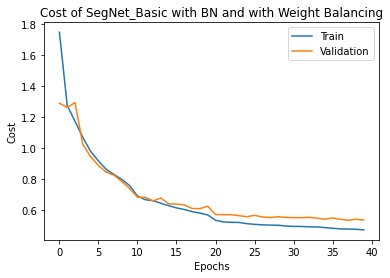

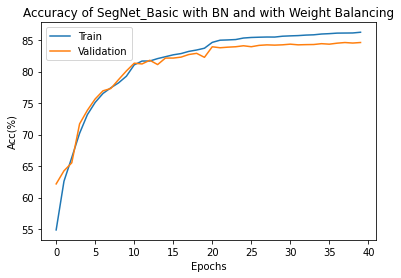

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet_Basic with BN and with Weight Balancing")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of SegNet_Basic with BN and with Weight Balancing")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/SegNet_BN_WB.pth'
torch.save(Net.state_dict(), PATH)

#### Test SegNet Basic without weight Balancing










  0%|          | 0/1 [00:00<?, ?it/s]








100%|██████████| 1/1 [00:12<00:00, 12.49s/it]


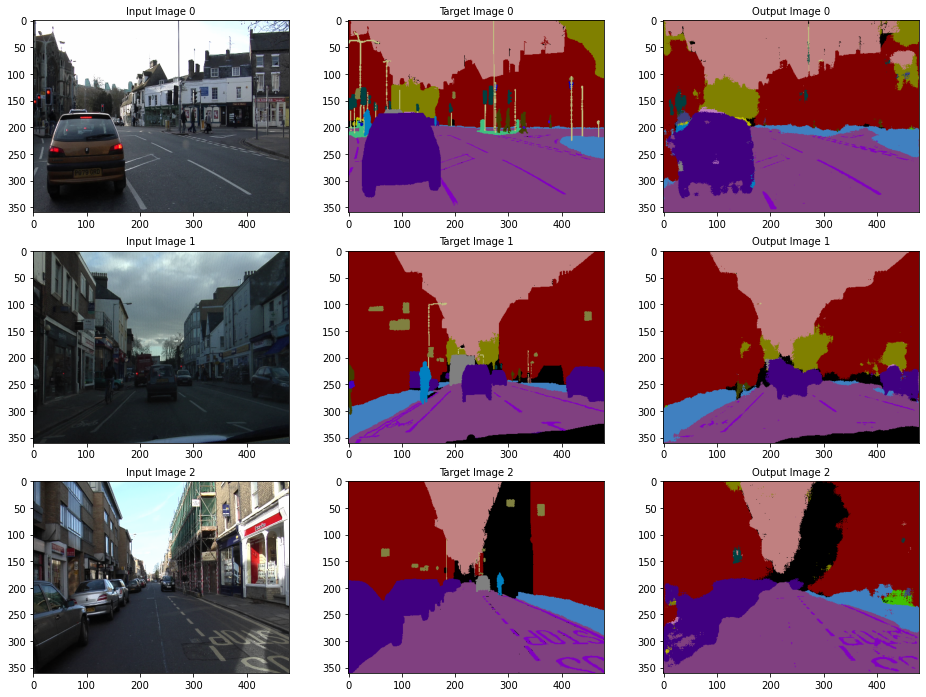

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

## composes multiple transforms into single one
transform1 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 transforms.ToTensor(),
                                 nn.LocalResponseNorm(2)])

transform2 = transforms.Compose([transforms.Resize((360,480),interpolation = InterpolationMode.NEAREST),
                                 CustomToTensor()])

data_root = "/content/camvid/images"

kwargs = {'labels_root' : "/content/labels",
          'data_transform' : transform1,
          'label_transform' : transform2,
          'labelcolors_root' : "/content/label_colors.txt"}
          
PATH = '/content/drive/My Drive/SegNet_BN_WB.pth'
 
net = SegNet_Basic_BN()
net.load_state_dict(torch.load(PATH))

test_set = CamVid_Dataset(data_root, partition['test'], **kwargs)
test_generator = torch.utils.data.DataLoader(test_set, **params)

for images, labels in tqdm(test_generator):
    outputs = net(images)
    test_set.test_network(images, outputs, labels)